## **<span style="color:#0918D5 ;">This notebook contains 9 different models with tuned-parameters using Optuna. Also submission done using random 5 models (using VotingClassifier).</span>**

## **<span style="color:#0918D5 ;">Each model is tuned for 100 iteration and using 5-Stratified-Folds.</span>**

## **<span style="color:#0918D5 ;">I hope this helps some of us. If yes, don't forget to upvote ;-)</span>**

## **<span style="color:#0918D5 ;">Introduction</span>**
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

## **<span style="color:#0918D5 ;">Data Dictionary</span>**
- **<span style="color:#0918D5 ;">PassengerId</span>** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **<span style="color:#0918D5 ;">HomePlanet</span>** - The planet the passenger departed from, typically their planet of permanent residence.
- **<span style="color:#0918D5 ;">CryoSleep</span>** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **<span style="color:#0918D5 ;">Cabin</span>** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **<span style="color:#0918D5 ;">Destination</span>** - The planet the passenger will be debarking to.
- **<span style="color:#0918D5 ;">Age</span>** - The age of the passenger.
- **<span style="color:#0918D5 ;">VIP</span>** - Whether the passenger has paid for special VIP service during the voyage.
- **<span style="color:#0918D5 ;">RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</span>** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **<span style="color:#0918D5 ;">Name</span>** - The first and last names of the passenger.
- **<span style="color:#0918D5 ;">Transported</span>** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# **<span style="color:#0918D5 ;">Importing Required Libraries</span>**

In [1]:
!pip install proplot

     |████████████████████████████████| 8.0 MB 913 kB/s            


In [2]:
!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split, StratifiedKFold

import statsmodels.api as sm

import optuna
from sklearn import preprocessing
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier, BaggingClassifier,
                              GradientBoostingClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# **<span style="color:#0918D5 ;">Loading Data</span>**

In [4]:
df = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# **<span style="color:#0918D5 ;">Missing Values Analysis</span>**

In [5]:
display(((df.isnull().sum() / df.shape[0])*100).to_frame().rename({0: 'Missing Values % (Train)'}, axis = 1).style.background_gradient('gist_heat_r'))
display(((df_test.isnull().sum() / df_test.shape[0])*100).to_frame().rename({0: 'Missing Values % (Test)'}, axis = 1).style.background_gradient('gist_heat_r'))

,Missing Values % (Train)
PassengerId,0.000000
HomePlanet,2.312205
CryoSleep,2.496261
Cabin,2.289198
Destination,2.093639
Age,2.059128
VIP,2.335212
RoomService,2.082135
FoodCourt,2.105142
ShoppingMall,2.392730


,Missing Values % (Test)
PassengerId,0.000000
HomePlanet,2.034136
CryoSleep,2.174421
Cabin,2.338087
Destination,2.151040
Age,2.127660
VIP,2.174421
RoomService,1.917232
FoodCourt,2.478373
ShoppingMall,2.291326


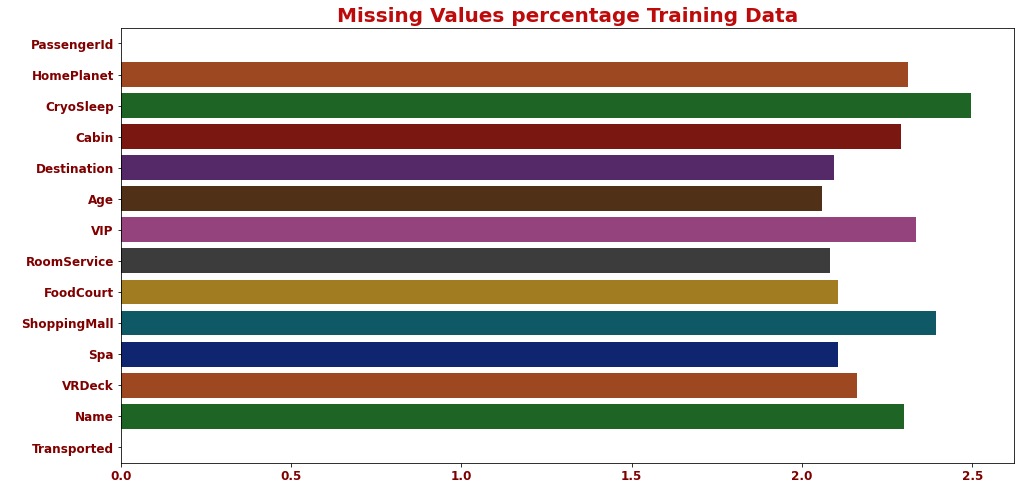

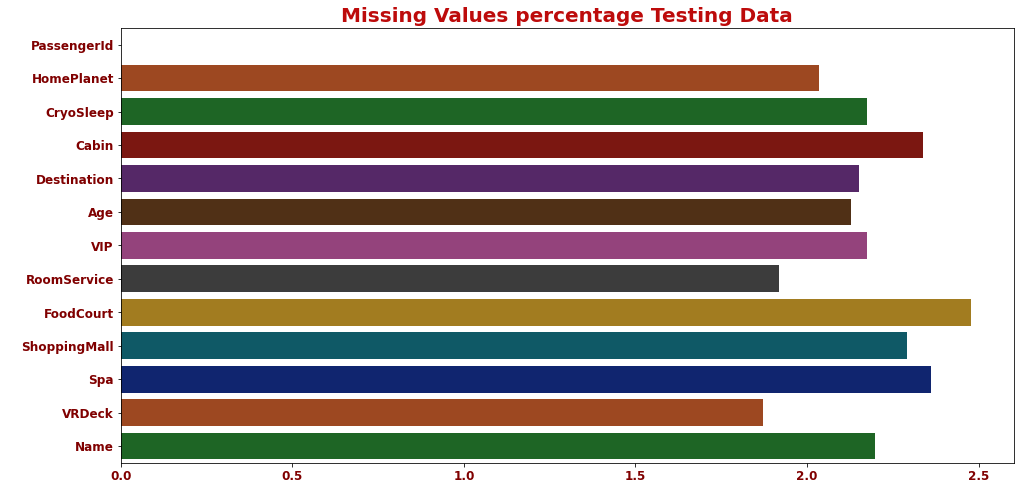

In [6]:
missing_val_df = ((df.isnull().sum() / df.shape[0])*100).to_frame().reset_index().rename({'index': 'columns', 0: 'Missing Values percentage'}, axis = 1)

plt.figure(figsize = (16,8))
sns.barplot(data = missing_val_df, x = 'Missing Values percentage', y = 'columns',palette='dark')
plt.title('Missing Values percentage Training Data', fontsize = 20, fontweight = 'bold', color = '#bd0b0b')
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 12, fontweight = 'bold', color = 'maroon')
plt.yticks(fontsize = 12, fontweight = 'bold', color = 'maroon');


missing_val_df_test = ((df_test.isnull().sum() / df_test.shape[0])*100).to_frame().reset_index().rename({'index': 'columns', 0: 'Missing Values percentage'}, axis = 1)

plt.figure(figsize = (16,8))
sns.barplot(data = missing_val_df_test, x = 'Missing Values percentage', y = 'columns',palette='dark')
plt.title('Missing Values percentage Testing Data', fontsize = 20, fontweight = 'bold', color = '#bd0b0b')
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 12, fontweight = 'bold', color = 'maroon')
plt.yticks(fontsize = 12, fontweight = 'bold', color = 'maroon');

### **<span style="color:#0918D5 ;">Observations:</span>**
- Missing values doesnt seem to follow a pattern in training and testing datasets.
- In training data: **CryoSleep** and **Age** has highest and second lowest missing values percentages. **PassengerId** and **Transported** doesn't have any missing values (lowest %age).
- In testing data: **FoodCourt** and **VRDeck** has highest and second lowest missing values percentages. **PassengerId** doesn't have any missing values (lowest %age).

## **<span style="color:#0918D5 ;">Missing values imputation</span>**
- Categorical : Group by + Mode
- Float: Iterative Imputer

## **<span style="color:#0918D5 ;">Combining train and test dataset</span>**
- Plan here is to get mode from maximum data available for categorical variables and 
- Get best prediction of missing values using MICE methodology (using iterative imputer). To make sure data leakage doesn't happen:
    - Removed target variable when using iterative imputer
    - Make copy of the dataset and perform missing imputation in copied dataset and take only required columns from the copied set. 

In [7]:
df['isTrain'] = True
df_test['isTrain'] = False
tt = pd.concat([df, df_test]).reset_index(drop = True).copy()
tt.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,isTrain
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True


## **<span style="color:#0918D5 ;">Imputing Missing values in Categorical columns</span>**

In [8]:
"""Mode for Destination and VIP """
tt['Destination'] = tt['Destination'].fillna(tt['Destination'].mode()[0])
tt['VIP'] = tt['VIP'].fillna(tt['VIP'].mode()[0])

"""For CyroSleep, Cabin, HomePlanet: Mode after Grouping by Destination and VIP"""
tt['CryoSleep'] = tt.groupby(['Destination', 'VIP'])['CryoSleep'].transform(lambda x: x.fillna(x.mode()[0]))
tt['Cabin'] = tt.groupby(['CryoSleep', 'VIP'])['Cabin'].transform(lambda x: x.fillna(x.mode()[0]))
tt['HomePlanet'] = tt.groupby(['CryoSleep', 'VIP'])['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0]))

"""For missing Names: Used keyword- Missing"""
tt['Name'] = tt['Name'].fillna("MISSING")

## **<span style="color:#0918D5 ;">Imputing Missing values in Numerical columns</span>**

In [9]:
"""Created List of columns according to the data-types"""
useful_cols = [col for col in tt.columns if col not in ['PassengerId','isTrain','Transported']]
cat_cols = [col for col in useful_cols if tt[col].dtype == 'object']
bool_cols = ['VIP', 'CryoSleep']
col_num = [col for col in useful_cols if col not in (cat_cols+bool_cols)]

"""Preprocessing for Using Iterative Imputer"""
comb_df = tt.copy()                # Making copy of combined data
le = preprocessing.LabelEncoder()  # Label Encoding Categrorical columns
for i in cat_cols:
    comb_df[i] = le.fit_transform(comb_df[i])

"""Imputing missing values of Float-type data using Iterative Imputer"""
it_imputer = IterativeImputer(max_iter=1000)
iterimp = it_imputer.fit_transform(comb_df[useful_cols])
imp_df = pd.DataFrame(iterimp, columns=comb_df[useful_cols].columns)

for col in comb_df[col_num].columns:
    tt[col] = imp_df[col]

tt.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,isTrain
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True


## **<span style="color:#0918D5 ;">Taking out Training and Testing set from combined Dataset.</span>**

In [10]:
for col in comb_df[col_num].columns:
    comb_df[col] = imp_df[col]
    
    
"""Taking out Training and Testing set from combined Dataset."""
train = comb_df[comb_df.isTrain == True].drop('isTrain', axis= 1)
test = comb_df[comb_df.isTrain != True].drop(['isTrain','Transported'], axis =1)

"""Checking missing values"""
print(f"Missing values in Training Set: {train.isnull().sum().sum()} \
\nMissing values in Test Set: {test.isnull().sum().sum()}")

Missing values in Training Set: 0 
Missing values in Test Set: 0


## **<span style="color:#0918D5 ;">Describing the Imputed Dataset (Training)</span>**


In [11]:
train.describe().style.background_gradient(cmap="Pastel1")

,HomePlanet,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.650408,4664.202462,1.494306,28.826712,224.123100,457.284393,173.732837,310.880158,303.753258,6351.587369
std,0.795075,2981.439322,0.814966,14.350396,660.767517,1596.098491,597.472207,1125.626440,1133.834432,3612.884447
min,0.000000,0.000000,0.000000,0.000000,-395.162658,-230.450891,0.000000,-341.169764,-110.050022,1.000000
25%,0.000000,1858.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3246.000000
50%,0.000000,4557.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6453.000000
75%,1.000000,7326.000000,2.000000,37.000000,63.000000,100.000000,45.000000,80.000000,62.000000,9384.000000
max,2.000000,9822.000000,2.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,12627.000000


# **<span style="color:#0918D5 ;">Exploratory Data Analysis (EDA)</span>**
### Refer to: https://www.kaggle.com/code/snikhil17/titanic-eda-in-2912

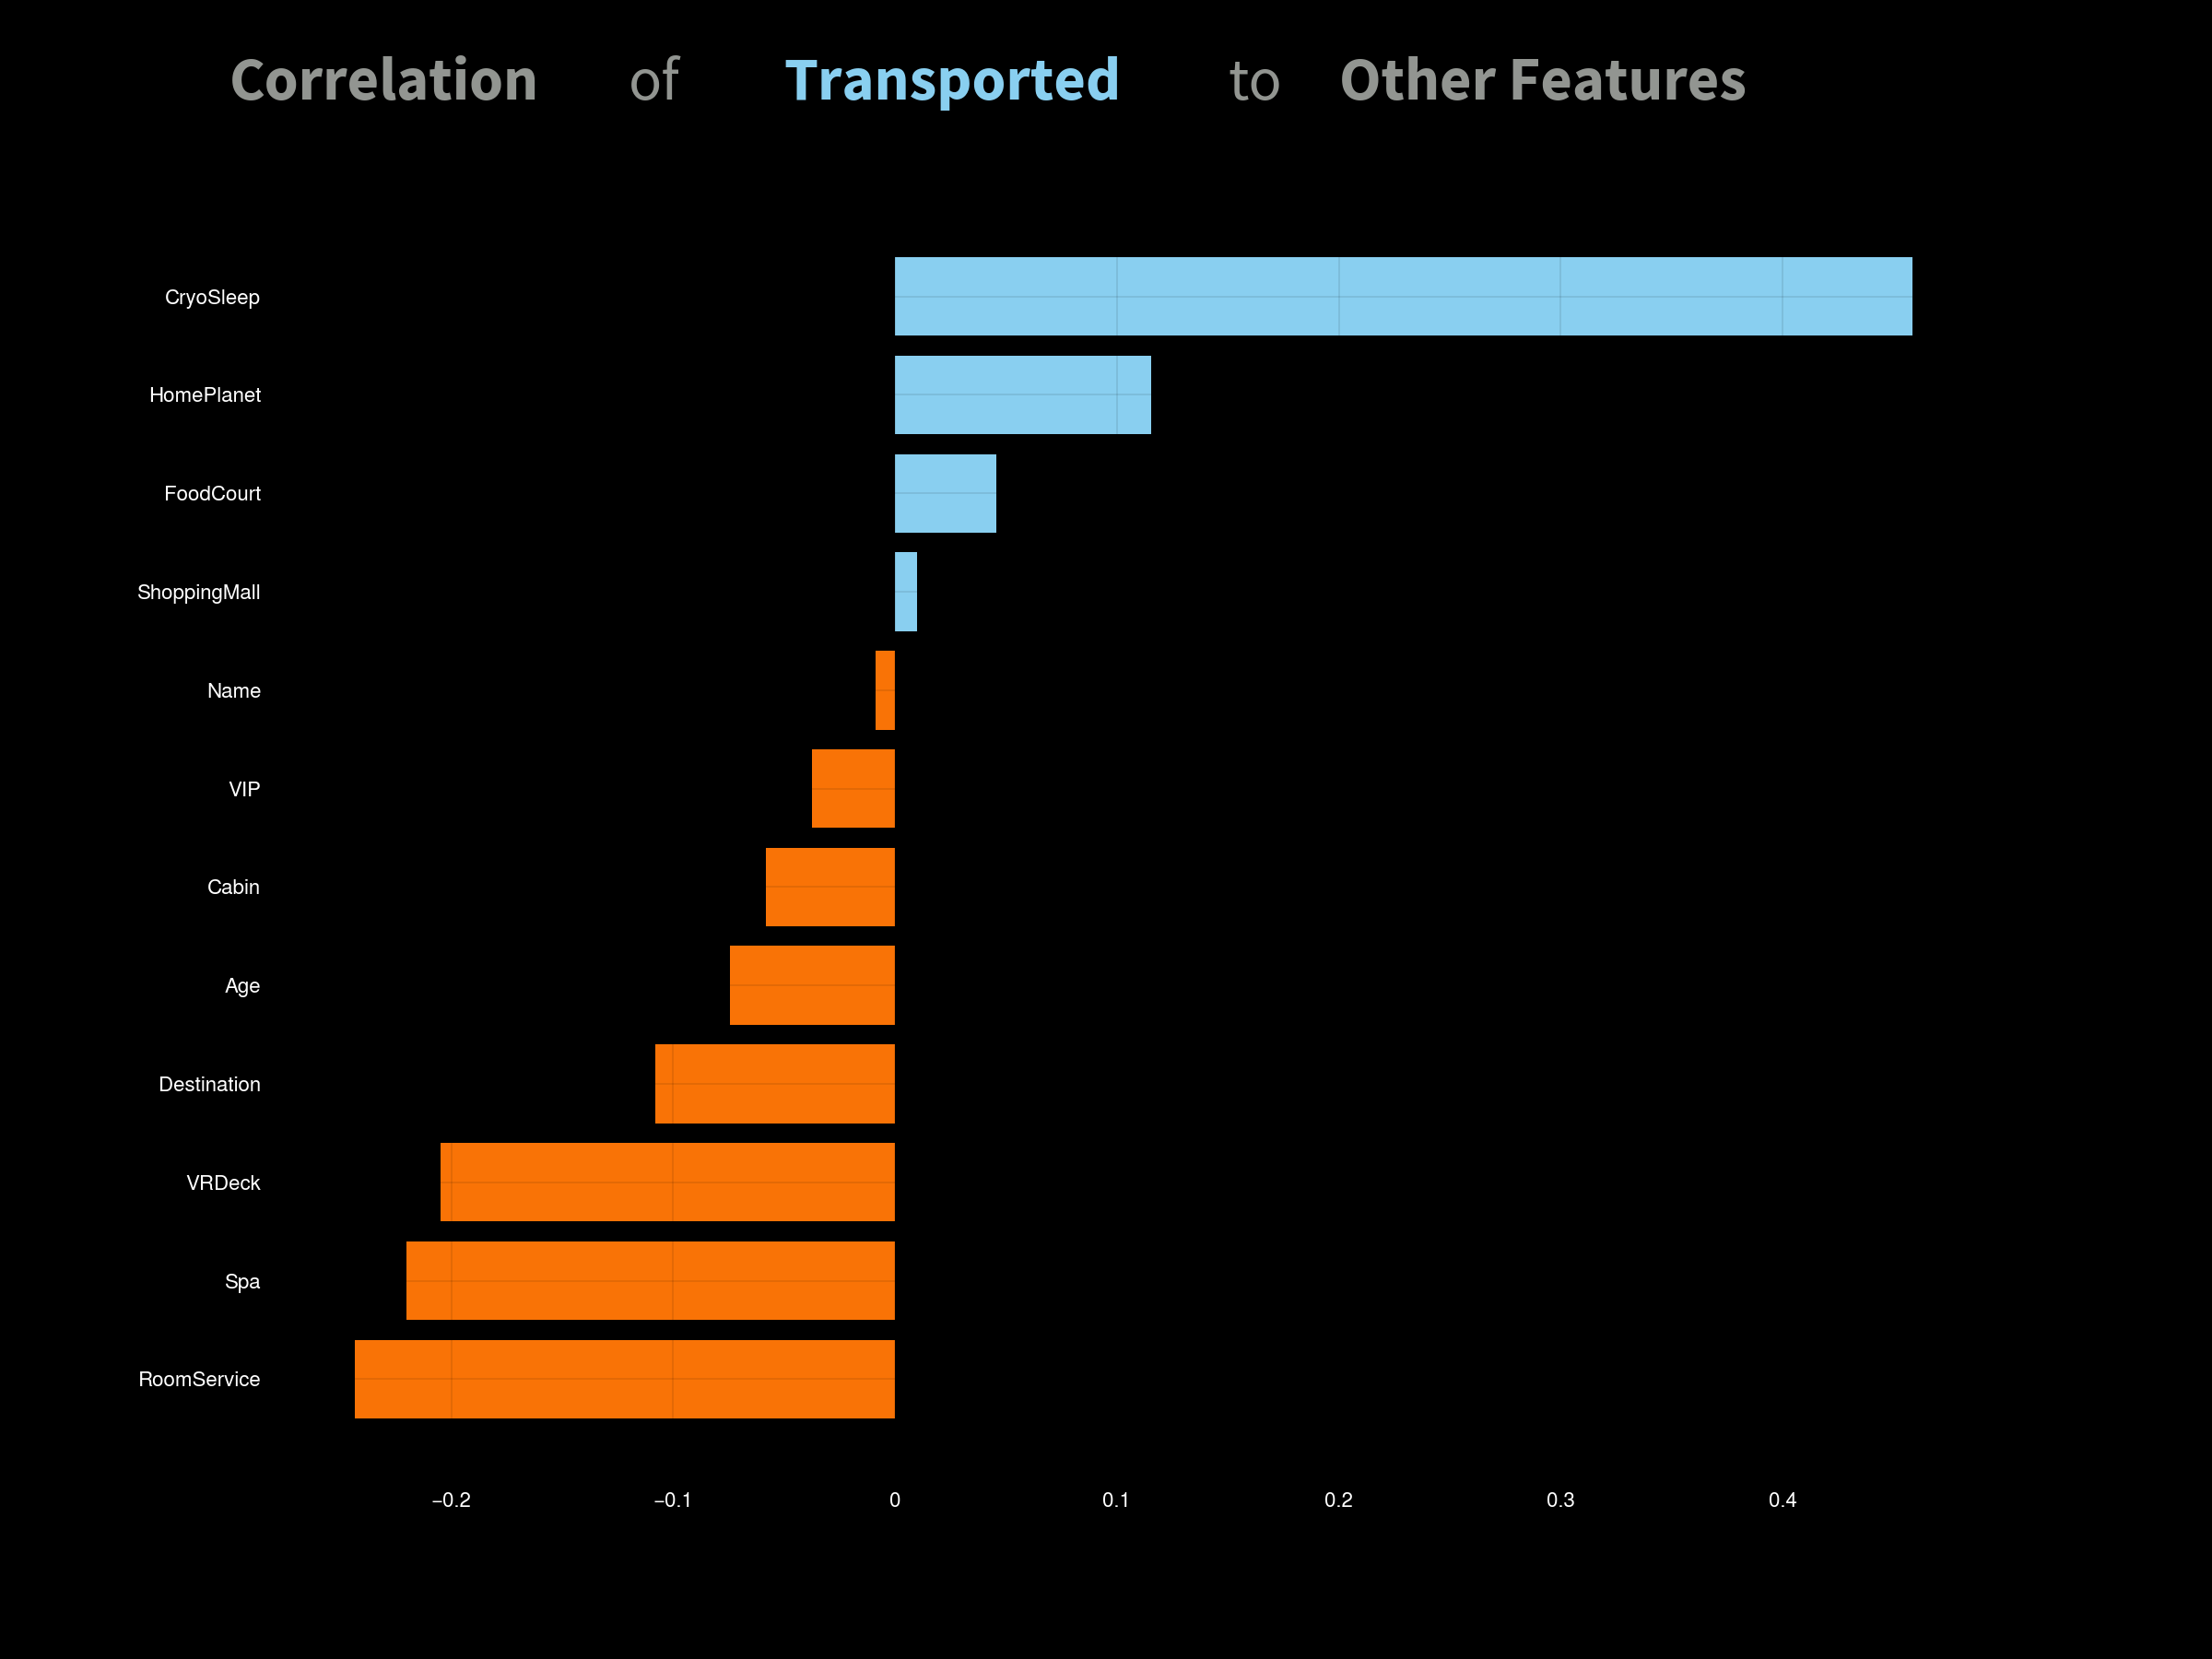

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import proplot as pplt

# Defining plots design
def plots_design():
    fig.patch.set_facecolor('black')
    ax.patch.set_facecolor('black')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.set_label_coords(0, 0)
#     ax.grid(color='white', linewidth=2)
    # Remove ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # Remove axes splines
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    # Font
    mpl.rcParams['font.family'] = 'Source Sans Pro'

df_eda = train.copy()
df_eda['Transported'] = df_eda['Transported'].astype(int)
corr = df_eda[df_eda.columns].corr()['Transported'][:].sort_values(ascending=True).to_frame()
corr = corr.drop(corr[corr.Transported > 0.99].index)

# Visualization
fig, ax = plt.subplots(figsize =(12, 9))

ax.barh(corr.index, corr.Transported, align='center', color = np.where(corr['Transported'] < 0, 'orange', '#89CFF0'))

plots_design()

plt.text(-.3, 13, "Correlation", size=24, color="grey", fontweight="bold");
plt.text(-0.12, 13, "of", size=24, color="grey");
plt.text(-0.05, 13, "Transported", size=24, color="#89CFF0", fontweight="bold");
plt.text(0.15, 13, "to", size=24, color="grey");
plt.text(0.20, 13, "Other Features", size=24, color="grey", fontweight="bold");

In [12]:
"""Converting Boolean Cols to Numerical Columns"""
train['Transported'] = train['Transported'].astype(int)

train['VIP'] = train['VIP'].astype(int)
test['VIP'] = test['VIP'].astype(int)

train['CryoSleep'] = train['CryoSleep'].astype(int)
test['CryoSleep'] = test['CryoSleep'].astype(int)

"""Making lists of columns with different datatypes"""
useful_cols = [col for col in train.columns if col not in ['PassengerId','Transported']]
cat_cols = [col for col in useful_cols if train[col].dtype == 'object']
col_num = [col for col in useful_cols if col not in cat_cols]

# **<span style="color:#0918D5 ;">Evaluation</span>**
## **<span style="color:#0918D5 ;">Confusion Matrix</span>**

- **<span style="color:#0918D5 ;">Confusion Matrix</span>**: A confusion matrix is a table that is often used to describe the performance of a classification model true positives (TP): These are cases in which we predicted yes.

- **<span style="color:#0918D5 ;">true negatives (TN):</span>** We predicted no, and they don't have the disease.

- **<span style="color:#0918D5 ;">false positives (FP):</span>** We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

- **<span style="color:#0918D5 ;">false negatives (FN):</span>** We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

- **<span style="color:#0918D5 ;">precision</span>** - What proportion of positive identifications was actually correct? 

- **<span style="color:#0918D5 ;">recall</span>** - What proportion of actual positives was identified correctly?

- **<span style="color:#0918D5 ;">F1 Score:</span>**
    - F1 Score is the weighted average of Precision and Recall
    - F1 is usually more useful than accuracy, especially if you have an uneven class distribution.

# **<span style="color:#0918D5 ;">Hyperparameter Tuning</span>**
### **<span style="color:#0918D5 ;">Now, let’s see where will a hyperparameter optimizer stands in the whole process of learning the algorithm.</span>**
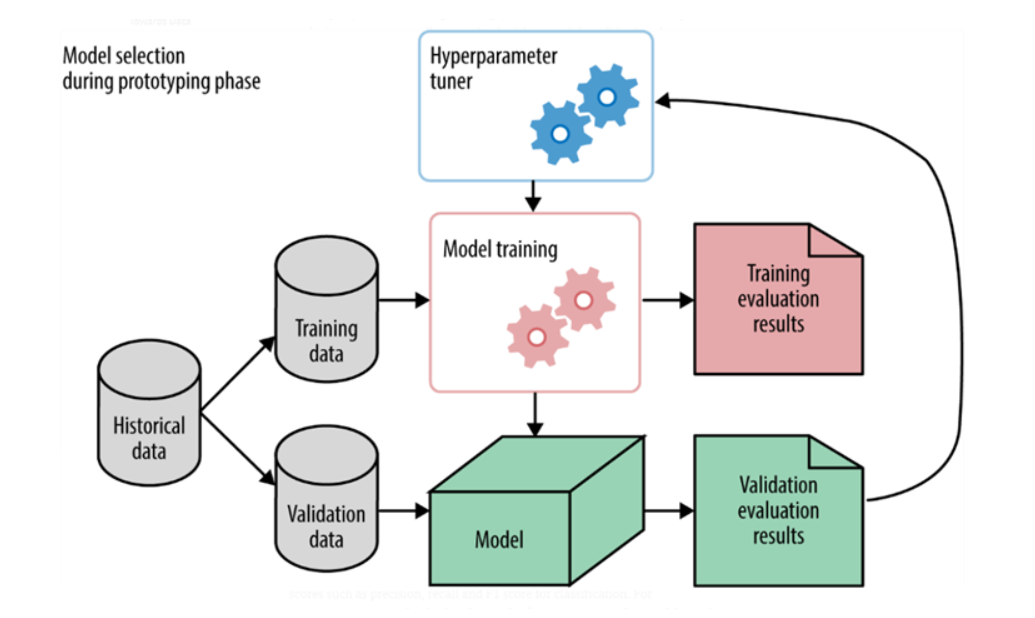

**<span style="color:#0918D5 ;">As can be seen in the above figure, the hyperparameter tuner is external to the model and the tuning is done before model training. The result of the tuning process is the optimal values of hyperparameters which is then fed to the model training stage. Let me now introduce Optuna, an optimization library in Python that can be employed for hyperparameter optimization.</span>**

## **<span style="color:#0918D5 ;">Optuna</span>**

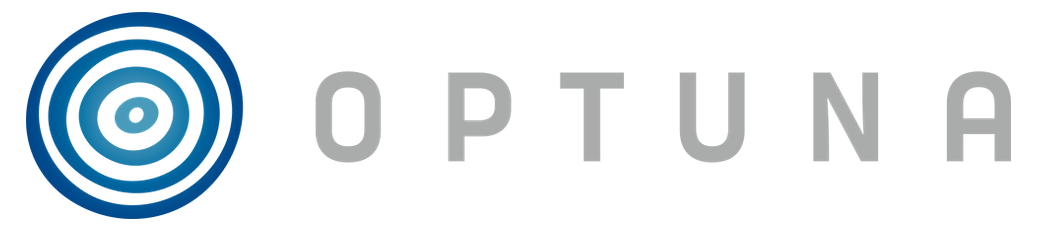

**<span style="color:#0918D5 ;">Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically finds optimal hyperparameter values by making use of different samplers such as grid search, random, bayesian, and evolutionary algorithms. Let me first briefly describe the different samplers available in optuna.</span>**

- Grid Search: The search space of each hyper-parameter is discretized. The optimizer launches learning for each of the hyper-parameter configurations and selects the best at the end.
- Random: Randomly samples the search space and continues until the stopping criteria are met.
- Bayesian: Probabilistic model-based approach for finding the optimal hyperparameters
- Evolutionary algorithms: •Meta-heuristic approaches that employ the value of the fitness function to find the optimal hyperparameters.

## **<span style="color:#0918D5 ;">Why Optuna?</span>**
The following features of optuna encouraged us to use it for hyperparameter tuning for the problems we were trying to solve!
- Eager dynamic search spaces
- Efficient sampling and pruning algorithms
- Easy integration
- Good visualizations
- Distributed optimization

In [15]:
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Hide grid lines
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
"""Creating Features and Label"""
features = train.drop('Transported', axis =1)
label = train.Transported

## **<span style="color:#0918D5 ;">Hyper-Parameter Tuning for KNN</span>**

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [119]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid


        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])
        
        # Modelling 
        params =   {'n_neighbors' : trial.suggest_int('n_neighbors', 2, 100)
        ,'algorithm' : trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        ,'weights' : trial.suggest_categorical('weights', ['uniform','distance'])
        ,'metric' : trial.suggest_categorical('metric', ['minkowski','euclidean'])
        , 'leaf_size' : trial.suggest_int('leaf_size', 10, 300)
        }
        model = KNeighborsClassifier(**params)                          # Initialization of KNeighborsClassifier Class
        model.fit(xtrain,ytrain)                                        # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                              # Validating the model on Validation data.
        acc_score = metrics.accuracy_score(yvalid, preds_valid)          # Evaluating the model using accuracy
        final_scores.append(acc_score)
        print(fold, acc_score)
    print(f"Mean Score{np.mean(final_scores)}")
    return np.mean(final_scores)
study_knn = optuna.create_study(direction='maximize')                       # direction = "maximize", optuna will try to maximize the accuracy
study_knn.optimize(objective, n_trials=100)                                 # Running our objective function for 100 trials.

[I 2022-04-01 11:44:09,649] A new study created in memory with name: no-name-8fd6237b-10d3-4dd3-808a-573d32bc9948


0 0.7814836112708453
1 0.7860839562967222
2 0.777458309373203
3 0.7807825086306099


[I 2022-04-01 11:44:11,517] Trial 0 finished with value: 0.7794769820624924 and parameters: {'n_neighbors': 64, 'algorithm': 'auto', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 277}. Best is trial 0 with value: 0.7794769820624924.


4 0.7715765247410817
Mean Score0.7794769820624924
0 0.780333525014376
1 0.7791834387579069
2 0.7740080506037953
3 0.7813578826237054


[I 2022-04-01 11:44:13,572] Trial 1 finished with value: 0.7770617347509348 and parameters: {'n_neighbors': 84, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 29}. Best is trial 0 with value: 0.7794769820624924.


4 0.7704257767548907
Mean Score0.7770617347509348
0 0.7763082231167338
1 0.7722829212190915
2 0.780333525014376
3 0.7767548906789413


[I 2022-04-01 11:44:15,918] Trial 2 finished with value: 0.7751059925581876 and parameters: {'n_neighbors': 77, 'algorithm': 'auto', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 103}. Best is trial 0 with value: 0.7794769820624924.


4 0.7698504027617952
Mean Score0.7751059925581876
0 0.7814836112708453
1 0.7843588269120184
2 0.7734330074755607
3 0.7859608745684695


[I 2022-04-01 11:44:18,513] Trial 3 finished with value: 0.7790173445977379 and parameters: {'n_neighbors': 70, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 292}. Best is trial 0 with value: 0.7794769820624924.


4 0.7698504027617952
Mean Score0.7790173445977379
0 0.7837837837837838
1 0.777458309373203
2 0.7636572742955722
3 0.7796317606444189


[I 2022-04-01 11:44:21,157] Trial 4 finished with value: 0.7738406329841826 and parameters: {'n_neighbors': 14, 'algorithm': 'brute', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 81}. Best is trial 0 with value: 0.7794769820624924.


4 0.7646720368239356
Mean Score0.7738406329841826
0 0.7849338700402531
1 0.772857964347326
2 0.7763082231167338
3 0.7784810126582279


[I 2022-04-01 11:44:23,155] Trial 5 finished with value: 0.7767164441821054 and parameters: {'n_neighbors': 97, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 123}. Best is trial 0 with value: 0.7794769820624924.


4 0.7710011507479861
Mean Score0.7767164441821054
0 0.7809085681426107
1 0.7768832662449684
2 0.7763082231167338
3 0.7802071346375143


[I 2022-04-01 11:44:25,201] Trial 6 finished with value: 0.7769465937793435 and parameters: {'n_neighbors': 85, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 200}. Best is trial 0 with value: 0.7794769820624924.


4 0.7704257767548907
Mean Score0.7769465937793435
0 0.7527314548591144
1 0.7561817136285222
2 0.7429557216791259
3 0.7439585730724971


[I 2022-04-01 11:44:26,740] Trial 7 finished with value: 0.7488778056513041 and parameters: {'n_neighbors': 4, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 55}. Best is trial 0 with value: 0.7794769820624924.


4 0.7485615650172612
Mean Score0.7488778056513041
0 0.7849338700402531
1 0.7866589994249569
2 0.7832087406555491
3 0.7836593785960875


[I 2022-04-01 11:44:29,091] Trial 8 finished with value: 0.7818924278929665 and parameters: {'n_neighbors': 44, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 121}. Best is trial 8 with value: 0.7818924278929665.


4 0.7710011507479861
Mean Score0.7818924278929665
0 0.7855089131684876
1 0.7849338700402531
2 0.7809085681426107
3 0.7876869965477561


[I 2022-04-01 11:44:30,883] Trial 9 finished with value: 0.7814325257363233 and parameters: {'n_neighbors': 36, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 88}. Best is trial 8 with value: 0.7818924278929665.


4 0.7681242807825086
Mean Score0.7814325257363233
0 0.7837837837837838
1 0.7786083956296722
2 0.780333525014376
3 0.785385500575374


[I 2022-04-01 11:44:33,562] Trial 10 finished with value: 0.7795923215530003 and parameters: {'n_neighbors': 40, 'algorithm': 'brute', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 181}. Best is trial 8 with value: 0.7818924278929665.


4 0.7698504027617952
Mean Score0.7795923215530003
0 0.7855089131684876
1 0.7849338700402531
2 0.7809085681426107
3 0.7876869965477561


[I 2022-04-01 11:44:35,355] Trial 11 finished with value: 0.7814325257363233 and parameters: {'n_neighbors': 36, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 140}. Best is trial 8 with value: 0.7818924278929665.


4 0.7681242807825086
Mean Score0.7814325257363233
0 0.7855089131684876
1 0.7878090856814262
2 0.777458309373203
3 0.785385500575374


[I 2022-04-01 11:44:37,756] Trial 12 finished with value: 0.7810873675134381 and parameters: {'n_neighbors': 29, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 225}. Best is trial 8 with value: 0.7818924278929665.


4 0.7692750287686997
Mean Score0.7810873675134381
0 0.7912593444508338
1 0.7837837837837838
2 0.7757331799884991
3 0.7802071346375143


[I 2022-04-01 11:44:39,631] Trial 13 finished with value: 0.7815476667079144 and parameters: {'n_neighbors': 53, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 82}. Best is trial 8 with value: 0.7818924278929665.


4 0.7767548906789413
Mean Score0.7815476667079144
0 0.7814836112708453
1 0.7745830937320299
2 0.7797584818861415
3 0.7761795166858458


[I 2022-04-01 11:44:42,334] Trial 14 finished with value: 0.7763710212673315 and parameters: {'n_neighbors': 54, 'algorithm': 'brute', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 20}. Best is trial 8 with value: 0.7818924278929665.


4 0.7698504027617952
Mean Score0.7763710212673315
0 0.7889591719378953
1 0.78205865439908
2 0.777458309373203
3 0.7756041426927502


[I 2022-04-01 11:44:44,218] Trial 15 finished with value: 0.7798218094205167 and parameters: {'n_neighbors': 54, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 159}. Best is trial 8 with value: 0.7818924278929665.


4 0.7750287686996548
Mean Score0.7798218094205167
0 0.7889591719378953
1 0.7791834387579069
2 0.7797584818861415
3 0.7836593785960875


[I 2022-04-01 11:44:46,109] Trial 16 finished with value: 0.7803972495865843 and parameters: {'n_neighbors': 48, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 72}. Best is trial 8 with value: 0.7818924278929665.


4 0.7704257767548907
Mean Score0.7803972495865843
0 0.7837837837837838
1 0.7768832662449684
2 0.7751581368602645
3 0.783084004602992


[I 2022-04-01 11:44:47,819] Trial 17 finished with value: 0.7769463952604271 and parameters: {'n_neighbors': 24, 'algorithm': 'auto', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 125}. Best is trial 8 with value: 0.7818924278929665.


4 0.7658227848101266
Mean Score0.7769463952604271
0 0.780333525014376
1 0.7734330074755607
2 0.7791834387579069
3 0.7825086306098964


[I 2022-04-01 11:44:50,065] Trial 18 finished with value: 0.7764864269308115 and parameters: {'n_neighbors': 61, 'algorithm': 'ball_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 47}. Best is trial 8 with value: 0.7818924278929665.


4 0.7669735327963176
Mean Score0.7764864269308115
0 0.7860839562967222
1 0.7814836112708453
2 0.7832087406555491
3 0.7836593785960875


[I 2022-04-01 11:44:52,484] Trial 19 finished with value: 0.781087367513438 and parameters: {'n_neighbors': 46, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 246}. Best is trial 8 with value: 0.7818924278929665.


4 0.7710011507479861
Mean Score0.781087367513438
0 0.7855089131684876
1 0.7866589994249569
2 0.772857964347326
3 0.7813578826237054


[I 2022-04-01 11:44:54,227] Trial 20 finished with value: 0.7787865332707777 and parameters: {'n_neighbors': 25, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 166}. Best is trial 8 with value: 0.7818924278929665.


4 0.7675489067894131
Mean Score0.7787865332707777
0 0.7866589994249569
1 0.7855089131684876
2 0.7826336975273146
3 0.7888377445339471


[I 2022-04-01 11:44:56,010] Trial 21 finished with value: 0.782467801886062 and parameters: {'n_neighbors': 37, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 109}. Best is trial 21 with value: 0.782467801886062.


4 0.7686996547756041
Mean Score0.782467801886062
0 0.7860839562967222
1 0.7860839562967222
2 0.780333525014376
3 0.784234752589183


[I 2022-04-01 11:44:57,902] Trial 22 finished with value: 0.7820077673834743 and parameters: {'n_neighbors': 45, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 102}. Best is trial 21 with value: 0.782467801886062.


4 0.7733026467203682
Mean Score0.7820077673834743
0 0.7837837837837838
1 0.7837837837837838
2 0.7855089131684876
3 0.7825086306098964


[I 2022-04-01 11:44:59,747] Trial 23 finished with value: 0.7810871028215493 and parameters: {'n_neighbors': 42, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 110}. Best is trial 21 with value: 0.782467801886062.


4 0.7698504027617952
Mean Score0.7810871028215493
0 0.78205865439908
1 0.78205865439908
2 0.765382403680276
3 0.7813578826237054


[I 2022-04-01 11:45:01,416] Trial 24 finished with value: 0.7755662255796919 and parameters: {'n_neighbors': 14, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 138}. Best is trial 21 with value: 0.782467801886062.


4 0.7669735327963176
Mean Score0.7755662255796919
0 0.7843588269120184
1 0.7837837837837838
2 0.7780333525014376
3 0.7922899884925202


[I 2022-04-01 11:45:03,825] Trial 25 finished with value: 0.780627597702739 and parameters: {'n_neighbors': 32, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 102}. Best is trial 21 with value: 0.782467801886062.


4 0.7646720368239356
Mean Score0.780627597702739
0 0.7860839562967222
1 0.7809085681426107
2 0.7688326624496837
3 0.784234752589183


[I 2022-04-01 11:45:05,768] Trial 26 finished with value: 0.7776368440521416 and parameters: {'n_neighbors': 17, 'algorithm': 'auto', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 183}. Best is trial 21 with value: 0.782467801886062.


4 0.7681242807825086
Mean Score0.7776368440521416
0 0.7849338700402531
1 0.78205865439908
2 0.772857964347326
3 0.7784810126582279


[I 2022-04-01 11:45:07,714] Trial 27 finished with value: 0.7782117548344318 and parameters: {'n_neighbors': 61, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 59}. Best is trial 21 with value: 0.782467801886062.


4 0.7727272727272727
Mean Score0.7782117548344318
0 0.7872340425531915
1 0.7866589994249569
2 0.7826336975273146
3 0.785385500575374


[I 2022-04-01 11:45:09,526] Trial 28 finished with value: 0.7825826781657648 and parameters: {'n_neighbors': 43, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 145}. Best is trial 28 with value: 0.7825826781657648.


4 0.7710011507479861
Mean Score0.7825826781657648
0 0.7843588269120184
1 0.7872340425531915
2 0.7745830937320299
3 0.7813578826237054


[I 2022-04-01 11:45:11,485] Trial 29 finished with value: 0.7797069993137863 and parameters: {'n_neighbors': 66, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 144}. Best is trial 28 with value: 0.7825826781657648.


4 0.7710011507479861
Mean Score0.7797069993137863
0 0.7843588269120184
1 0.7797584818861415
2 0.7705577918343876
3 0.7813578826237054


[I 2022-04-01 11:45:13,213] Trial 30 finished with value: 0.7770616024049906 and parameters: {'n_neighbors': 21, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 213}. Best is trial 28 with value: 0.7825826781657648.


4 0.7692750287686997
Mean Score0.7770616024049906
0 0.7849338700402531
1 0.7866589994249569
2 0.7832087406555491
3 0.7836593785960875


[I 2022-04-01 11:45:15,076] Trial 31 finished with value: 0.7818924278929665 and parameters: {'n_neighbors': 44, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 129}. Best is trial 28 with value: 0.7825826781657648.


4 0.7710011507479861
Mean Score0.7818924278929665
0 0.7855089131684876
1 0.7849338700402531
2 0.7809085681426107
3 0.7876869965477561


[I 2022-04-01 11:45:16,868] Trial 32 finished with value: 0.7814325257363233 and parameters: {'n_neighbors': 36, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 170}. Best is trial 28 with value: 0.7825826781657648.


4 0.7681242807825086
Mean Score0.7814325257363233
0 0.78953421506613
1 0.7809085681426107
2 0.7768832662449684
3 0.7790563866513234


[I 2022-04-01 11:45:18,746] Trial 33 finished with value: 0.7802822409609375 and parameters: {'n_neighbors': 50, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 105}. Best is trial 28 with value: 0.7825826781657648.


4 0.7750287686996548
Mean Score0.7802822409609375
0 0.7855089131684876
1 0.7878090856814262
2 0.777458309373203
3 0.785385500575374


[I 2022-04-01 11:45:20,530] Trial 34 finished with value: 0.7810873675134381 and parameters: {'n_neighbors': 29, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 146}. Best is trial 28 with value: 0.7825826781657648.


4 0.7692750287686997
Mean Score0.7810873675134381
0 0.7883841288096607
1 0.78205865439908
2 0.7786083956296722
3 0.7784810126582279


[I 2022-04-01 11:45:22,702] Trial 35 finished with value: 0.7799368180461637 and parameters: {'n_neighbors': 56, 'algorithm': 'auto', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 39}. Best is trial 28 with value: 0.7825826781657648.


4 0.7721518987341772
Mean Score0.7799368180461637
0 0.78953421506613
1 0.78205865439908
2 0.7826336975273146
3 0.7836593785960875


[I 2022-04-01 11:45:24,812] Trial 36 finished with value: 0.7807417460797478 and parameters: {'n_neighbors': 41, 'algorithm': 'ball_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 89}. Best is trial 28 with value: 0.7825826781657648.


4 0.7658227848101266
Mean Score0.7807417460797478
0 0.78205865439908
1 0.7843588269120184
2 0.7722829212190915
3 0.785385500575374


[I 2022-04-01 11:45:26,749] Trial 37 finished with value: 0.7786721863748527 and parameters: {'n_neighbors': 72, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 130}. Best is trial 28 with value: 0.7825826781657648.


4 0.7692750287686997
Mean Score0.7786721863748527
0 0.7860839562967222
1 0.7814836112708453
2 0.7832087406555491
3 0.783084004602992


[I 2022-04-01 11:45:28,585] Trial 38 finished with value: 0.7812024423120572 and parameters: {'n_neighbors': 47, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 114}. Best is trial 28 with value: 0.7825826781657648.


4 0.7721518987341772
Mean Score0.7812024423120572
0 0.7814836112708453
1 0.777458309373203
2 0.7740080506037953
3 0.7807825086306099


[I 2022-04-01 11:45:30,729] Trial 39 finished with value: 0.7768316513266689 and parameters: {'n_neighbors': 83, 'algorithm': 'ball_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 94}. Best is trial 28 with value: 0.7825826781657648.


4 0.7704257767548907
Mean Score0.7768316513266689
0 0.7791834387579069
1 0.7745830937320299
2 0.7734330074755607
3 0.7796317606444189


[I 2022-04-01 11:45:32,997] Trial 40 finished with value: 0.7746458918826276 and parameters: {'n_neighbors': 60, 'algorithm': 'auto', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 71}. Best is trial 28 with value: 0.7825826781657648.


4 0.766398158803222
Mean Score0.7746458918826276
0 0.7849338700402531
1 0.7866589994249569
2 0.7832087406555491
3 0.7836593785960875


[I 2022-04-01 11:45:35,415] Trial 41 finished with value: 0.7818924278929665 and parameters: {'n_neighbors': 44, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 127}. Best is trial 28 with value: 0.7825826781657648.


4 0.7710011507479861
Mean Score0.7818924278929665
0 0.7832087406555491
1 0.7878090856814262
2 0.7837837837837838
3 0.7882623705408516


[I 2022-04-01 11:45:37,157] Trial 42 finished with value: 0.7828130262819193 and parameters: {'n_neighbors': 38, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 115}. Best is trial 42 with value: 0.7828130262819193.


4 0.7710011507479861
Mean Score0.7828130262819193
0 0.7832087406555491
1 0.7878090856814262
2 0.7837837837837838
3 0.7882623705408516


[I 2022-04-01 11:45:38,922] Trial 43 finished with value: 0.7828130262819193 and parameters: {'n_neighbors': 38, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 113}. Best is trial 42 with value: 0.7828130262819193.


4 0.7710011507479861
Mean Score0.7828130262819193
0 0.7883841288096607
1 0.7849338700402531
2 0.7791834387579069
3 0.7876869965477561


[I 2022-04-01 11:45:40,674] Trial 44 finished with value: 0.7815474681889979 and parameters: {'n_neighbors': 33, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 154}. Best is trial 42 with value: 0.7828130262819193.


4 0.7675489067894131
Mean Score0.7815474681889979
0 0.7699827487061529
1 0.7607820586543991
2 0.7538815411155837
3 0.762945914844649


[I 2022-04-01 11:45:42,228] Trial 45 finished with value: 0.7616473364386103 and parameters: {'n_neighbors': 6, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 73}. Best is trial 42 with value: 0.7828130262819193.


4 0.760644418872267
Mean Score0.7616473364386103
0 0.7837837837837838
1 0.7855089131684876
2 0.7849338700402531
3 0.7876869965477561


[I 2022-04-01 11:45:44,034] Trial 46 finished with value: 0.7824678680590342 and parameters: {'n_neighbors': 40, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 111}. Best is trial 42 with value: 0.7828130262819193.


4 0.7704257767548907
Mean Score0.7824678680590342
0 0.7872340425531915
1 0.7745830937320299
2 0.7757331799884991
3 0.7767548906789413


[I 2022-04-01 11:45:46,072] Trial 47 finished with value: 0.7771763463387487 and parameters: {'n_neighbors': 99, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 185}. Best is trial 42 with value: 0.7828130262819193.


4 0.7715765247410817
Mean Score0.7771763463387487
0 0.7860839562967222
1 0.7855089131684876
2 0.7843588269120184
3 0.7871116225546605


[I 2022-04-01 11:45:47,850] Trial 48 finished with value: 0.7823525947414987 and parameters: {'n_neighbors': 39, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 115}. Best is trial 42 with value: 0.7828130262819193.


4 0.7686996547756041
Mean Score0.7823525947414987
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:45:49,531] Trial 49 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 282}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.78953421506613
1 0.7809085681426107
2 0.7832087406555491
3 0.7957422324510932


[I 2022-04-01 11:45:51,503] Trial 50 finished with value: 0.7833885326209592 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 291}. Best is trial 49 with value: 0.7838485671235469.


4 0.7675489067894131
Mean Score0.7833885326209592
0 0.7889591719378953
1 0.7832087406555491
2 0.7740080506037953
3 0.7894131185270425


[I 2022-04-01 11:45:53,466] Trial 51 finished with value: 0.7813180464944537 and parameters: {'n_neighbors': 29, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 300}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7813180464944537
0 0.7860839562967222
1 0.7751581368602645
2 0.7786083956296722
3 0.7917146144994246


[I 2022-04-01 11:45:55,467] Trial 52 finished with value: 0.7793625028206229 and parameters: {'n_neighbors': 33, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 270}. Best is trial 49 with value: 0.7838485671235469.


4 0.7652474108170311
Mean Score0.7793625028206229
0 0.7860839562967222
1 0.7849338700402531
2 0.7717078780908568
3 0.7905638665132336


[I 2022-04-01 11:45:57,397] Trial 53 finished with value: 0.7806279947405722 and parameters: {'n_neighbors': 25, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 278}. Best is trial 49 with value: 0.7838485671235469.


4 0.7698504027617952
Mean Score0.7806279947405722
0 0.7843588269120184
1 0.7705577918343876
2 0.7630822311673375
3 0.783084004602992


[I 2022-04-01 11:45:59,312] Trial 54 finished with value: 0.7738414270598488 and parameters: {'n_neighbors': 20, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 258}. Best is trial 49 with value: 0.7838485671235469.


4 0.7681242807825086
Mean Score0.7738414270598488
0 0.7866589994249569
1 0.7791834387579069
2 0.7837837837837838
3 0.7882623705408516


[I 2022-04-01 11:46:01,345] Trial 55 finished with value: 0.7802819762690488 and parameters: {'n_neighbors': 39, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 289}. Best is trial 49 with value: 0.7838485671235469.


4 0.7635212888377445
Mean Score0.7802819762690488
0 0.78953421506613
1 0.7809085681426107
2 0.7768832662449684
3 0.7790563866513234


[I 2022-04-01 11:46:03,218] Trial 56 finished with value: 0.7802822409609375 and parameters: {'n_neighbors': 50, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 239}. Best is trial 49 with value: 0.7838485671235469.


4 0.7750287686996548
Mean Score0.7802822409609375
0 0.78953421506613
1 0.7809085681426107
2 0.7832087406555491
3 0.7957422324510932


[I 2022-04-01 11:46:05,203] Trial 57 finished with value: 0.7833885326209592 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 199}. Best is trial 49 with value: 0.7838485671235469.


4 0.7675489067894131
Mean Score0.7833885326209592
0 0.7906843013225991
1 0.7809085681426107
2 0.7694077055779184
3 0.784234752589183


[I 2022-04-01 11:46:07,113] Trial 58 finished with value: 0.7799377444677742 and parameters: {'n_neighbors': 13, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 203}. Best is trial 49 with value: 0.7838485671235469.


4 0.7744533947065593
Mean Score0.7799377444677742
0 0.7814836112708453
1 0.7855089131684876
2 0.7676825761932144
3 0.7859608745684695


[I 2022-04-01 11:46:09,068] Trial 59 finished with value: 0.7777520511967051 and parameters: {'n_neighbors': 28, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 238}. Best is trial 49 with value: 0.7838485671235469.


4 0.7681242807825086
Mean Score0.7777520511967051
0 0.7814836112708453
1 0.7711328349626222
2 0.772857964347326
3 0.7871116225546605


[I 2022-04-01 11:46:11,055] Trial 60 finished with value: 0.7755666887904971 and parameters: {'n_neighbors': 34, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 262}. Best is trial 49 with value: 0.7838485671235469.


4 0.7652474108170311
Mean Score0.7755666887904971
0 0.7826336975273146
1 0.7768832662449684
2 0.7814836112708453
3 0.7928653624856157


[I 2022-04-01 11:46:13,040] Trial 61 finished with value: 0.7794774452732977 and parameters: {'n_neighbors': 37, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 281}. Best is trial 49 with value: 0.7838485671235469.


4 0.7635212888377445
Mean Score0.7794774452732977
0 0.78953421506613
1 0.7809085681426107
2 0.7832087406555491
3 0.7957422324510932


[I 2022-04-01 11:46:15,026] Trial 62 finished with value: 0.7833885326209592 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 296}. Best is trial 49 with value: 0.7838485671235469.


4 0.7675489067894131
Mean Score0.7833885326209592
0 0.7843588269120184
1 0.7734330074755607
2 0.7711328349626222
3 0.7848101265822784


[I 2022-04-01 11:46:16,984] Trial 63 finished with value: 0.775566291752664 and parameters: {'n_neighbors': 22, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 298}. Best is trial 49 with value: 0.7838485671235469.


4 0.7640966628308401
Mean Score0.775566291752664
0 0.7826336975273146
1 0.7809085681426107
2 0.7751581368602645
3 0.7888377445339471


[I 2022-04-01 11:46:18,953] Trial 64 finished with value: 0.7791324855693291 and parameters: {'n_neighbors': 32, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 284}. Best is trial 49 with value: 0.7838485671235469.


4 0.7681242807825086
Mean Score0.7791324855693291
0 0.7809085681426107
1 0.780333525014376
2 0.7688326624496837
3 0.786536248561565


[I 2022-04-01 11:46:20,875] Trial 65 finished with value: 0.7775224309832443 and parameters: {'n_neighbors': 26, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 254}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7775224309832443
0 0.7849338700402531
1 0.7826336975273146
2 0.7763082231167338
3 0.7876869965477561


[I 2022-04-01 11:46:22,823] Trial 66 finished with value: 0.7799374136029132 and parameters: {'n_neighbors': 30, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 270}. Best is trial 49 with value: 0.7838485671235469.


4 0.7681242807825086
Mean Score0.7799374136029132
0 0.7860839562967222
1 0.7809085681426107
2 0.7688326624496837
3 0.784234752589183


[I 2022-04-01 11:46:24,711] Trial 67 finished with value: 0.7776368440521416 and parameters: {'n_neighbors': 17, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 228}. Best is trial 49 with value: 0.7838485671235469.


4 0.7681242807825086
Mean Score0.7776368440521416
0 0.7814836112708453
1 0.7711328349626222
2 0.772857964347326
3 0.7871116225546605


[I 2022-04-01 11:46:26,677] Trial 68 finished with value: 0.7755666887904971 and parameters: {'n_neighbors': 34, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 270}. Best is trial 49 with value: 0.7838485671235469.


4 0.7652474108170311
Mean Score0.7755666887904971
0 0.7843588269120184
1 0.78205865439908
2 0.7814836112708453
3 0.7825086306098964


[I 2022-04-01 11:46:28,734] Trial 69 finished with value: 0.7797068007948698 and parameters: {'n_neighbors': 43, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 174}. Best is trial 49 with value: 0.7838485671235469.


4 0.7681242807825086
Mean Score0.7797068007948698
0 0.7866589994249569
1 0.7855089131684876
2 0.7826336975273146
3 0.7888377445339471


[I 2022-04-01 11:46:30,451] Trial 70 finished with value: 0.782467801886062 and parameters: {'n_neighbors': 37, 'algorithm': 'auto', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 156}. Best is trial 49 with value: 0.7838485671235469.


4 0.7686996547756041
Mean Score0.782467801886062
0 0.7860839562967222
1 0.7855089131684876
2 0.7832087406555491
3 0.7859608745684695


[I 2022-04-01 11:46:32,195] Trial 71 finished with value: 0.7815472034971093 and parameters: {'n_neighbors': 41, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 135}. Best is trial 49 with value: 0.7838485671235469.


4 0.7669735327963176
Mean Score0.7815472034971093
0 0.7889591719378953
1 0.7791834387579069
2 0.7797584818861415
3 0.7836593785960875


[I 2022-04-01 11:46:34,029] Trial 72 finished with value: 0.7803972495865843 and parameters: {'n_neighbors': 48, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 96}. Best is trial 49 with value: 0.7838485671235469.


4 0.7704257767548907
Mean Score0.7803972495865843
0 0.7837837837837838
1 0.7855089131684876
2 0.7849338700402531
3 0.7876869965477561


[I 2022-04-01 11:46:35,884] Trial 73 finished with value: 0.7824678680590342 and parameters: {'n_neighbors': 40, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 291}. Best is trial 49 with value: 0.7838485671235469.


4 0.7704257767548907
Mean Score0.7824678680590342
0 0.7837837837837838
1 0.7901092581943646
2 0.7757331799884991
3 0.7796317606444189


[I 2022-04-01 11:46:37,677] Trial 74 finished with value: 0.7797066022759532 and parameters: {'n_neighbors': 27, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 118}. Best is trial 49 with value: 0.7838485671235469.


4 0.7692750287686997
Mean Score0.7797066022759532
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:46:39,510] Trial 75 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 146}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.7860839562967222
1 0.7837837837837838
2 0.7745830937320299
3 0.7796317606444189


[I 2022-04-01 11:46:41,911] Trial 76 finished with value: 0.777750926256178 and parameters: {'n_neighbors': 23, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 149}. Best is trial 49 with value: 0.7838485671235469.


4 0.7646720368239356
Mean Score0.777750926256178
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:46:43,598] Trial 77 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 166}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.7843588269120184
1 0.7837837837837838
2 0.777458309373203
3 0.786536248561565


[I 2022-04-01 11:46:45,288] Trial 78 finished with value: 0.7808578134729495 and parameters: {'n_neighbors': 30, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 192}. Best is trial 49 with value: 0.7838485671235469.


4 0.7721518987341772
Mean Score0.7808578134729495
0 0.7809085681426107
1 0.780333525014376
2 0.7688326624496837
3 0.786536248561565


[I 2022-04-01 11:46:47,222] Trial 79 finished with value: 0.7775224309832443 and parameters: {'n_neighbors': 26, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 166}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7775224309832443
0 0.7832087406555491
1 0.7797584818861415
2 0.7705577918343876
3 0.7796317606444189


[I 2022-04-01 11:46:48,831] Trial 80 finished with value: 0.7752205379730291 and parameters: {'n_neighbors': 19, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 212}. Best is trial 49 with value: 0.7838485671235469.


4 0.762945914844649
Mean Score0.7752205379730291
0 0.7855089131684876
1 0.7832087406555491
2 0.780333525014376
3 0.7894131185270425


[I 2022-04-01 11:46:50,579] Trial 81 finished with value: 0.7814327904282119 and parameters: {'n_neighbors': 35, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 137}. Best is trial 49 with value: 0.7838485671235469.


4 0.7686996547756041
Mean Score0.7814327904282119
0 0.7832087406555491
1 0.7878090856814262
2 0.7837837837837838
3 0.7882623705408516


[I 2022-04-01 11:46:52,321] Trial 82 finished with value: 0.7828130262819193 and parameters: {'n_neighbors': 38, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 120}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7828130262819193
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:46:54,012] Trial 83 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 123}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:46:55,704] Trial 84 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 159}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.7843588269120184
1 0.7837837837837838
2 0.7780333525014376
3 0.7922899884925202


[I 2022-04-01 11:46:57,402] Trial 85 finished with value: 0.780627597702739 and parameters: {'n_neighbors': 32, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 162}. Best is trial 49 with value: 0.7838485671235469.


4 0.7646720368239356
Mean Score0.780627597702739
0 0.7837837837837838
1 0.7768832662449684
2 0.7751581368602645
3 0.783084004602992


[I 2022-04-01 11:46:59,048] Trial 86 finished with value: 0.7769463952604271 and parameters: {'n_neighbors': 24, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 172}. Best is trial 49 with value: 0.7838485671235469.


4 0.7658227848101266
Mean Score0.7769463952604271
0 0.7826336975273146
1 0.7866589994249569
2 0.7751581368602645
3 0.7836593785960875


[I 2022-04-01 11:47:00,756] Trial 87 finished with value: 0.7789016742423691 and parameters: {'n_neighbors': 28, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 152}. Best is trial 49 with value: 0.7838485671235469.


4 0.766398158803222
Mean Score0.7789016742423691
0 0.7843588269120184
1 0.7837837837837838
2 0.7780333525014376
3 0.7922899884925202


[I 2022-04-01 11:47:02,453] Trial 88 finished with value: 0.780627597702739 and parameters: {'n_neighbors': 32, 'algorithm': 'auto', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 186}. Best is trial 49 with value: 0.7838485671235469.


4 0.7646720368239356
Mean Score0.780627597702739
0 0.7849338700402531
1 0.7826336975273146
2 0.7763082231167338
3 0.7876869965477561


[I 2022-04-01 11:47:04,408] Trial 89 finished with value: 0.7799374136029132 and parameters: {'n_neighbors': 30, 'algorithm': 'kd_tree', 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 142}. Best is trial 49 with value: 0.7838485671235469.


4 0.7681242807825086
Mean Score0.7799374136029132
0 0.7786083956296722
1 0.7757331799884991
2 0.7688326624496837
3 0.7761795166858458


[I 2022-04-01 11:47:05,960] Trial 90 finished with value: 0.7722297843224318 and parameters: {'n_neighbors': 12, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 177}. Best is trial 49 with value: 0.7838485671235469.


4 0.761795166858458
Mean Score0.7722297843224318
0 0.7826336975273146
1 0.7734330074755607
2 0.7757331799884991
3 0.7813578826237054


[I 2022-04-01 11:47:07,962] Trial 91 finished with value: 0.7774071576657087 and parameters: {'n_neighbors': 93, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 136}. Best is trial 49 with value: 0.7838485671235469.


4 0.7738780207134638
Mean Score0.7774071576657087
0 0.7855089131684876
1 0.7832087406555491
2 0.780333525014376
3 0.7894131185270425


[I 2022-04-01 11:47:09,770] Trial 92 finished with value: 0.7814327904282119 and parameters: {'n_neighbors': 35, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 127}. Best is trial 49 with value: 0.7838485671235469.


4 0.7686996547756041
Mean Score0.7814327904282119
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:47:11,480] Trial 93 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 120}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:47:13,241] Trial 94 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 125}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.7843588269120184
1 0.7832087406555491
2 0.7665324899367453
3 0.7819332566168009


[I 2022-04-01 11:47:15,613] Trial 95 finished with value: 0.7764862945848672 and parameters: {'n_neighbors': 17, 'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 162}. Best is trial 49 with value: 0.7838485671235469.


4 0.766398158803222
Mean Score0.7764862945848672
0 0.7837837837837838
1 0.7768832662449684
2 0.7751581368602645
3 0.783084004602992


[I 2022-04-01 11:47:17,266] Trial 96 finished with value: 0.7769463952604271 and parameters: {'n_neighbors': 24, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 292}. Best is trial 49 with value: 0.7838485671235469.


4 0.7658227848101266
Mean Score0.7769463952604271
0 0.7872340425531915
1 0.7872340425531915
2 0.7814836112708453
3 0.7922899884925202


[I 2022-04-01 11:47:18,980] Trial 97 finished with value: 0.7838485671235469 and parameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 133}. Best is trial 49 with value: 0.7838485671235469.


4 0.7710011507479861
Mean Score0.7838485671235469
0 0.7837837837837838
1 0.7901092581943646
2 0.7757331799884991
3 0.7796317606444189


[I 2022-04-01 11:47:20,678] Trial 98 finished with value: 0.7797066022759532 and parameters: {'n_neighbors': 27, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 132}. Best is trial 49 with value: 0.7838485671235469.


4 0.7692750287686997
Mean Score0.7797066022759532
0 0.7855089131684876
1 0.7832087406555491
2 0.780333525014376
3 0.7894131185270425


[I 2022-04-01 11:47:22,518] Trial 99 finished with value: 0.7814327904282119 and parameters: {'n_neighbors': 35, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 103}. Best is trial 49 with value: 0.7838485671235469.


4 0.7686996547756041
Mean Score0.7814327904282119


In [120]:
trial_knn = study_knn.best_trial
print('roc_auc_score: {}'.format(trial_knn.value))
print("Best hyperparameters: {}".format(trial_knn.params))

roc_auc_score: 0.7838485671235469
Best hyperparameters: {'n_neighbors': 31, 'algorithm': 'kd_tree', 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 282}


In [121]:
optuna.visualization.plot_optimization_history(study_knn)

In [122]:
optuna.visualization.plot_slice(study_knn)

## **<span style="color:#0918D5 ;">Hypertuning Random Forest using Optuna</span>**

In [33]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])
        
        # Modelling 
        params =   {'n_estimators' : trial.suggest_int('n_estimators', 50, 800)
        ,'max_depth' : trial.suggest_int('max_depth', 7, 150)
        , 'criterion' : trial.suggest_categorical('criterion',['gini', 'entropy'])
        , 'max_features' : trial.suggest_categorical('max_features',['auto', 'sqrt', 'log2'])
        , 'oob_score' : trial.suggest_categorical('oob_score',[True, False])
        }
        model = RandomForestClassifier(**params)                        # Initialization of RandomForestClassifier Class
        model.fit(xtrain,ytrain)                                        # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                             # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)      # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)

        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_rf = optuna.create_study(direction='maximize')                    # direction = "maximize", optuna will try to maximize the roc_auc_score
study_rf.optimize(objective, n_trials=100)                                # Running our objective function for 100 trials.

[I 2022-04-01 03:51:54,755] A new study created in memory with name: no-name-1a71210c-0342-439b-8983-c296c8213da0


0 0.8004600345025877
1 0.7883841288096607
2 0.7981598619896493
3 0.8014959723820483


[I 2022-04-01 03:52:44,750] Trial 0 finished with value: 0.7943168004573875 and parameters: {'n_estimators': 775, 'max_depth': 80, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 0 with value: 0.7943168004573875.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7987349051178838
1 0.7855089131684876
2 0.8021851638872916
3 0.8026467203682394


[I 2022-04-01 03:53:13,253] Trial 1 finished with value: 0.7946620910262171 and parameters: {'n_estimators': 493, 'max_depth': 92, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 1 with value: 0.7946620910262171.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7952846463484762
1 0.78953421506613
2 0.79700977573318
3 0.8003452243958573


[I 2022-04-01 03:53:36,490] Trial 2 finished with value: 0.7935118724238034 and parameters: {'n_estimators': 360, 'max_depth': 66, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 1 with value: 0.7946620910262171.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7998849913743531
1 0.7883841288096607
2 0.7987349051178838
3 0.8037974683544303


[I 2022-04-01 03:54:25,124] Trial 3 finished with value: 0.7948921744504831 and parameters: {'n_estimators': 696, 'max_depth': 127, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7948921744504831.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7975848188614146
1 0.7872340425531915
2 0.7993099482461185
3 0.8026467203682394


[I 2022-04-01 03:54:49,663] Trial 4 finished with value: 0.7944322061208677 and parameters: {'n_estimators': 318, 'max_depth': 55, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 3 with value: 0.7948921744504831.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8027602070155262
1 0.7889591719378953
2 0.7964347326049454
3 0.7991944764096662


[I 2022-04-01 03:55:02,643] Trial 5 finished with value: 0.794086518514205 and parameters: {'n_estimators': 199, 'max_depth': 22, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 3 with value: 0.7948921744504831.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8027602070155262
1 0.7837837837837838
2 0.7947096032202415
3 0.8009205983889528


[I 2022-04-01 03:55:24,423] Trial 6 finished with value: 0.7929365646036801 and parameters: {'n_estimators': 309, 'max_depth': 112, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 3 with value: 0.7948921744504831.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7958596894767107
1 0.78205865439908
2 0.7987349051178838
3 0.8020713463751439


[I 2022-04-01 03:56:10,100] Trial 7 finished with value: 0.7930521687860768 and parameters: {'n_estimators': 600, 'max_depth': 47, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 3 with value: 0.7948921744504831.


4 0.786536248561565
Mean Score0.786536248561565
0 0.7935595169637722
1 0.7843588269120184
2 0.7952846463484762
3 0.7997698504027618


[I 2022-04-01 03:56:14,742] Trial 8 finished with value: 0.7916716682404805 and parameters: {'n_estimators': 58, 'max_depth': 123, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 3 with value: 0.7948921744504831.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7993099482461185
1 0.7809085681426107
2 0.7924094307073031
3 0.7991944764096662


[I 2022-04-01 03:56:20,387] Trial 9 finished with value: 0.7910963604203572 and parameters: {'n_estimators': 88, 'max_depth': 29, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 3 with value: 0.7948921744504831.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8004600345025877
1 0.7878090856814262
2 0.79700977573318
3 0.7980437284234753


[I 2022-04-01 03:57:14,972] Trial 10 finished with value: 0.7950074477680187 and parameters: {'n_estimators': 790, 'max_depth': 133, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 10 with value: 0.7950074477680187.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.7964347326049454
1 0.7883841288096607
2 0.7975848188614146
3 0.8014959723820483


[I 2022-04-01 03:58:09,903] Trial 11 finished with value: 0.7942022550425459 and parameters: {'n_estimators': 794, 'max_depth': 149, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 10 with value: 0.7950074477680187.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.8010350776308223
1 0.7889591719378953
2 0.7987349051178838
3 0.7997698504027618


[I 2022-04-01 03:58:54,666] Trial 12 finished with value: 0.7955824247232812 and parameters: {'n_estimators': 647, 'max_depth': 149, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 12 with value: 0.7955824247232812.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8004600345025877
1 0.7878090856814262
2 0.79700977573318
3 0.8037974683544303


[I 2022-04-01 03:59:36,444] Trial 13 finished with value: 0.7953526721638761 and parameters: {'n_estimators': 600, 'max_depth': 148, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 12 with value: 0.7955824247232812.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7987349051178838
1 0.7906843013225991
2 0.7975848188614146
3 0.7968929804372842


[I 2022-04-01 04:00:14,530] Trial 14 finished with value: 0.7938565012629111 and parameters: {'n_estimators': 548, 'max_depth': 148, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 12 with value: 0.7955824247232812.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7993099482461185
1 0.7878090856814262
2 0.79700977573318
3 0.8020713463751439


[I 2022-04-01 04:00:57,863] Trial 15 finished with value: 0.7950075801139631 and parameters: {'n_estimators': 625, 'max_depth': 102, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 12 with value: 0.7955824247232812.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8027602070155262
1 0.7860839562967222
2 0.7987349051178838
3 0.8020713463751439


[I 2022-04-01 04:01:29,688] Trial 16 finished with value: 0.7955825570692255 and parameters: {'n_estimators': 455, 'max_depth': 139, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.7981598619896493
1 0.7860839562967222
2 0.7993099482461185
3 0.7991944764096662


[I 2022-04-01 04:01:59,364] Trial 17 finished with value: 0.793626748703506 and parameters: {'n_estimators': 424, 'max_depth': 114, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8004600345025877
1 0.7860839562967222
2 0.7981598619896493
3 0.8020713463751439


[I 2022-04-01 04:02:32,683] Trial 18 finished with value: 0.7944321399478955 and parameters: {'n_estimators': 472, 'max_depth': 136, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7998849913743531
1 0.7883841288096607
2 0.7981598619896493
3 0.8003452243958573


[I 2022-04-01 04:03:21,022] Trial 19 finished with value: 0.7950073154220745 and parameters: {'n_estimators': 697, 'max_depth': 89, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.80448533640023
1 0.7849338700402531
2 0.7941345600920069
3 0.8009205983889528


[I 2022-04-01 04:03:37,573] Trial 20 finished with value: 0.7942021226966015 and parameters: {'n_estimators': 233, 'max_depth': 110, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.786536248561565
Mean Score0.786536248561565
0 0.7998849913743531
1 0.7883841288096607
2 0.7964347326049454
3 0.8014959723820483


[I 2022-04-01 04:04:17,676] Trial 21 finished with value: 0.7947773643437527 and parameters: {'n_estimators': 576, 'max_depth': 150, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7993099482461185
1 0.7866589994249569
2 0.7981598619896493
3 0.8032220943613348


[I 2022-04-01 04:05:03,897] Trial 22 finished with value: 0.7953528045098204 and parameters: {'n_estimators': 669, 'max_depth': 136, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.7987349051178838
1 0.7849338700402531
2 0.7964347326049454
3 0.8009205983889528


[I 2022-04-01 04:05:51,587] Trial 23 finished with value: 0.7936271457413391 and parameters: {'n_estimators': 682, 'max_depth': 132, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7993099482461185
1 0.7832087406555491
2 0.79700977573318
3 0.8043728423475259


[I 2022-04-01 04:06:27,674] Trial 24 finished with value: 0.7936272119143113 and parameters: {'n_estimators': 516, 'max_depth': 122, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7993099482461185
1 0.7866589994249569
2 0.79700977573318
3 0.7997698504027618


[I 2022-04-01 04:06:58,149] Trial 25 finished with value: 0.7939720392723355 and parameters: {'n_estimators': 436, 'max_depth': 140, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7964347326049454
1 0.7889591719378953
2 0.7998849913743531
3 0.8003452243958573


[I 2022-04-01 04:07:40,238] Trial 26 finished with value: 0.7945471485735423 and parameters: {'n_estimators': 655, 'max_depth': 100, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': True}. Best is trial 16 with value: 0.7955825570692255.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.8010350776308223
1 0.7751581368602645
2 0.8027602070155262
3 0.7957422324510932


[I 2022-04-01 04:08:09,621] Trial 27 finished with value: 0.7927066796983306 and parameters: {'n_estimators': 715, 'max_depth': 7, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.7952846463484762
1 0.7849338700402531
2 0.8033352501437608
3 0.7991944764096662


[I 2022-04-01 04:09:01,562] Trial 28 finished with value: 0.7937418235021252 and parameters: {'n_estimators': 746, 'max_depth': 118, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 16 with value: 0.7955825570692255.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8027602070155262
1 0.7826336975273146
2 0.7941345600920069
3 0.7980437284234753


[I 2022-04-01 04:09:27,674] Trial 29 finished with value: 0.7920161647336438 and parameters: {'n_estimators': 403, 'max_depth': 77, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': True}. Best is trial 16 with value: 0.7955825570692255.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8004600345025877
1 0.7860839562967222
2 0.8010350776308223
3 0.8020713463751439


[I 2022-04-01 04:10:04,530] Trial 30 finished with value: 0.796042856263702 and parameters: {'n_estimators': 530, 'max_depth': 140, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7905638665132336
Mean Score0.7905638665132336
0 0.7981598619896493
1 0.7901092581943646
2 0.7981598619896493
3 0.8020713463751439


[I 2022-04-01 04:10:43,443] Trial 31 finished with value: 0.7945470162275979 and parameters: {'n_estimators': 556, 'max_depth': 141, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7964347326049454
1 0.7872340425531915
2 0.7964347326049454
3 0.7997698504027618


[I 2022-04-01 04:11:18,935] Trial 32 finished with value: 0.7935120709427201 and parameters: {'n_estimators': 507, 'max_depth': 139, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7947096032202415
1 0.7866589994249569
2 0.7964347326049454
3 0.7991944764096662


[I 2022-04-01 04:12:04,529] Trial 33 finished with value: 0.7921314380511795 and parameters: {'n_estimators': 654, 'max_depth': 128, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.79700977573318
1 0.7924094307073031
2 0.7958596894767107
3 0.8009205983889528


[I 2022-04-01 04:12:30,943] Trial 34 finished with value: 0.7944320737749232 and parameters: {'n_estimators': 451, 'max_depth': 130, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8016101207590569
1 0.7849338700402531
2 0.7975848188614146
3 0.7968929804372842


[I 2022-04-01 04:12:57,784] Trial 35 finished with value: 0.7938568321277721 and parameters: {'n_estimators': 382, 'max_depth': 106, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.7964347326049454
1 0.7878090856814262
2 0.7981598619896493
3 0.8003452243958573


[I 2022-04-01 04:13:54,161] Trial 36 finished with value: 0.7938570306466886 and parameters: {'n_estimators': 742, 'max_depth': 143, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 30 with value: 0.796042856263702.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8027602070155262
1 0.78953421506613
2 0.7964347326049454
3 0.8043728423475259


[I 2022-04-01 04:14:24,912] Trial 37 finished with value: 0.7960427239177575 and parameters: {'n_estimators': 526, 'max_depth': 123, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7993099482461185
1 0.7883841288096607
2 0.7941345600920069
3 0.7951668584579977


[I 2022-04-01 04:14:58,824] Trial 38 finished with value: 0.7929364984307079 and parameters: {'n_estimators': 523, 'max_depth': 122, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': True}. Best is trial 30 with value: 0.796042856263702.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.79700977573318
1 0.7866589994249569
2 0.7998849913743531
3 0.8014959723820483


[I 2022-04-01 04:15:18,980] Trial 39 finished with value: 0.7933965991062678 and parameters: {'n_estimators': 342, 'max_depth': 91, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.7998849913743531
1 0.7843588269120184
2 0.8010350776308223
3 0.8014959723820483


[I 2022-04-01 04:15:47,464] Trial 40 finished with value: 0.794201924177685 and parameters: {'n_estimators': 489, 'max_depth': 80, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8010350776308223
1 0.7883841288096607
2 0.7947096032202415
3 0.8003452243958573


[I 2022-04-01 04:16:23,968] Trial 41 finished with value: 0.7937417573291529 and parameters: {'n_estimators': 623, 'max_depth': 136, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7964347326049454
1 0.7860839562967222
2 0.7964347326049454
3 0.7974683544303798


[I 2022-04-01 04:16:56,532] Trial 42 finished with value: 0.793166978892807 and parameters: {'n_estimators': 552, 'max_depth': 123, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.7993099482461185
1 0.7860839562967222
2 0.7998849913743531
3 0.8037974683544303


[I 2022-04-01 04:17:38,534] Trial 43 finished with value: 0.7947772981707806 and parameters: {'n_estimators': 589, 'max_depth': 144, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7998849913743531
1 0.7860839562967222
2 0.7964347326049454
3 0.7980437284234753


[I 2022-04-01 04:18:16,676] Trial 44 finished with value: 0.7930515070563547 and parameters: {'n_estimators': 650, 'max_depth': 62, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7981598619896493
1 0.7860839562967222
2 0.7952846463484762
3 0.7997698504027618


[I 2022-04-01 04:18:37,561] Trial 45 finished with value: 0.7935121371156922 and parameters: {'n_estimators': 291, 'max_depth': 129, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8004600345025877
1 0.7849338700402531
2 0.7975848188614146
3 0.7980437284234753


[I 2022-04-01 04:19:13,459] Trial 46 finished with value: 0.7931665156820019 and parameters: {'n_estimators': 464, 'max_depth': 117, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': True}. Best is trial 30 with value: 0.796042856263702.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7998849913743531
1 0.7878090856814262
2 0.8010350776308223
3 0.8009205983889528


[I 2022-04-01 04:19:56,731] Trial 47 finished with value: 0.7953522751260429 and parameters: {'n_estimators': 616, 'max_depth': 135, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.8010350776308223
1 0.7901092581943646
2 0.7964347326049454
3 0.7951668584579977


[I 2022-04-01 04:20:27,749] Trial 48 finished with value: 0.7933961358954627 and parameters: {'n_estimators': 527, 'max_depth': 144, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7993099482461185
1 0.7918343875790684
2 0.79700977573318
3 0.7980437284234753


[I 2022-04-01 04:21:20,763] Trial 49 finished with value: 0.7944317429100624 and parameters: {'n_estimators': 754, 'max_depth': 146, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7993099482461185
1 0.7849338700402531
2 0.8010350776308223
3 0.7986191024165707


[I 2022-04-01 04:22:01,474] Trial 50 finished with value: 0.7932813257887321 and parameters: {'n_estimators': 575, 'max_depth': 150, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7981598619896493
1 0.7866589994249569
2 0.7952846463484762
3 0.8020713463751439


[I 2022-04-01 04:22:44,524] Trial 51 finished with value: 0.7935120709427201 and parameters: {'n_estimators': 603, 'max_depth': 45, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7981598619896493
1 0.7878090856814262
2 0.7958596894767107
3 0.7997698504027618


[I 2022-04-01 04:23:31,398] Trial 52 finished with value: 0.7944324708127564 and parameters: {'n_estimators': 665, 'max_depth': 134, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7905638665132336
Mean Score0.7905638665132336
0 0.8010350776308223
1 0.7843588269120184
2 0.7975848188614146
3 0.8043728423475259


[I 2022-04-01 04:24:05,583] Trial 53 finished with value: 0.794547413265431 and parameters: {'n_estimators': 488, 'max_depth': 138, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7964347326049454
1 0.7860839562967222
2 0.7987349051178838
3 0.7991944764096662


[I 2022-04-01 04:24:55,068] Trial 54 finished with value: 0.7932817889995374 and parameters: {'n_estimators': 707, 'max_depth': 127, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8021851638872916
1 0.7883841288096607
2 0.7998849913743531
3 0.8009205983889528


[I 2022-04-01 04:25:33,935] Trial 55 finished with value: 0.7954671514057454 and parameters: {'n_estimators': 549, 'max_depth': 146, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8016101207590569
1 0.78953421506613
2 0.79700977573318
3 0.8009205983889528


[I 2022-04-01 04:26:02,081] Trial 56 finished with value: 0.7955824908962533 and parameters: {'n_estimators': 399, 'max_depth': 150, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8004600345025877
1 0.780333525014376
2 0.7958596894767107
3 0.8037974683544303


[I 2022-04-01 04:26:31,918] Trial 57 finished with value: 0.7943179915708868 and parameters: {'n_estimators': 424, 'max_depth': 150, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.7958596894767107
1 0.7883841288096607
2 0.8004600345025877
3 0.8043728423475259


[I 2022-04-01 04:26:59,216] Trial 58 finished with value: 0.7943170651492762 and parameters: {'n_estimators': 387, 'max_depth': 143, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8050603795284647
1 0.7849338700402531
2 0.7941345600920069
3 0.7980437284234753


[I 2022-04-01 04:27:26,109] Trial 59 finished with value: 0.7933965329332956 and parameters: {'n_estimators': 350, 'max_depth': 131, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': True}. Best is trial 30 with value: 0.796042856263702.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8033352501437608
1 0.7866589994249569
2 0.7993099482461185
3 0.7980437284234753


[I 2022-04-01 04:27:47,970] Trial 60 finished with value: 0.7946617601613561 and parameters: {'n_estimators': 305, 'max_depth': 145, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 30 with value: 0.796042856263702.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7981598619896493
1 0.7883841288096607
2 0.7981598619896493
3 0.8043728423475259


[I 2022-04-01 04:28:25,531] Trial 61 finished with value: 0.796158261927182 and parameters: {'n_estimators': 536, 'max_depth': 139, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.8004600345025877
1 0.7843588269120184
2 0.7987349051178838
3 0.8014959723820483


[I 2022-04-01 04:29:03,753] Trial 62 finished with value: 0.794777496689697 and parameters: {'n_estimators': 544, 'max_depth': 140, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.7998849913743531
1 0.7906843013225991
2 0.79700977573318
3 0.7986191024165707


[I 2022-04-01 04:29:35,992] Trial 63 finished with value: 0.7951222578747491 and parameters: {'n_estimators': 461, 'max_depth': 150, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.7958596894767107
1 0.7855089131684876
2 0.7993099482461185
3 0.8032220943613348


[I 2022-04-01 04:30:04,632] Trial 64 finished with value: 0.793627079568367 and parameters: {'n_estimators': 410, 'max_depth': 125, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7958596894767107
1 0.7855089131684876
2 0.7964347326049454
3 0.8026467203682394


[I 2022-04-01 04:30:38,934] Trial 65 finished with value: 0.7933972608359896 and parameters: {'n_estimators': 490, 'max_depth': 118, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.786536248561565
Mean Score0.786536248561565
0 0.7958596894767107
1 0.7878090856814262
2 0.7981598619896493
3 0.8055235903337169


[I 2022-04-01 04:31:19,021] Trial 66 finished with value: 0.794087246416899 and parameters: {'n_estimators': 570, 'max_depth': 139, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.783084004602992
Mean Score0.783084004602992
0 0.79700977573318
1 0.7878090856814262
2 0.7929844738355377
3 0.8037974683544303


[I 2022-04-01 04:31:44,614] Trial 67 finished with value: 0.7929369616415132 and parameters: {'n_estimators': 438, 'max_depth': 133, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7998849913743531
1 0.7878090856814262
2 0.7993099482461185
3 0.8003452243958573


[I 2022-04-01 04:32:21,533] Trial 68 finished with value: 0.7952373988463404 and parameters: {'n_estimators': 526, 'max_depth': 97, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.7987349051178838
1 0.7889591719378953
2 0.7998849913743531
3 0.8003452243958573


[I 2022-04-01 04:32:56,378] Trial 69 finished with value: 0.7939715098885582 and parameters: {'n_estimators': 499, 'max_depth': 147, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8016101207590569
1 0.7901092581943646
2 0.7935595169637722
3 0.8037974683544303


[I 2022-04-01 04:33:07,747] Trial 70 finished with value: 0.7950074477680187 and parameters: {'n_estimators': 142, 'max_depth': 108, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 61 with value: 0.796158261927182.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7981598619896493
1 0.7872340425531915
2 0.7935595169637722
3 0.8014959723820483


[I 2022-04-01 04:33:52,770] Trial 71 finished with value: 0.7936272780872835 and parameters: {'n_estimators': 644, 'max_depth': 137, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7975848188614146
1 0.7866589994249569
2 0.7981598619896493
3 0.7986191024165707


[I 2022-04-01 04:34:40,292] Trial 72 finished with value: 0.7939721054453076 and parameters: {'n_estimators': 680, 'max_depth': 141, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8004600345025877
1 0.7826336975273146
2 0.8004600345025877
3 0.7974683544303798


[I 2022-04-01 04:35:19,322] Trial 73 finished with value: 0.7938568983007442 and parameters: {'n_estimators': 551, 'max_depth': 133, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8010350776308223
1 0.7855089131684876
2 0.7964347326049454
3 0.8037974683544303


[I 2022-04-01 04:35:52,395] Trial 74 finished with value: 0.794547413265431 and parameters: {'n_estimators': 471, 'max_depth': 145, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8027602070155262
1 0.7866589994249569
2 0.7993099482461185
3 0.8037974683544303


[I 2022-04-01 04:36:27,107] Trial 75 finished with value: 0.7958125743205193 and parameters: {'n_estimators': 589, 'max_depth': 127, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8010350776308223
1 0.7901092581943646
2 0.7993099482461185
3 0.8003452243958573


[I 2022-04-01 04:37:02,386] Trial 76 finished with value: 0.7953520766071265 and parameters: {'n_estimators': 607, 'max_depth': 114, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7993099482461185
1 0.7843588269120184
2 0.7981598619896493
3 0.8009205983889528


[I 2022-04-01 04:37:33,868] Trial 77 finished with value: 0.7930515732293271 and parameters: {'n_estimators': 537, 'max_depth': 125, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8050603795284647
1 0.7855089131684876
2 0.7964347326049454
3 0.8009205983889528


[I 2022-04-01 04:38:08,153] Trial 78 finished with value: 0.7944318752560067 and parameters: {'n_estimators': 589, 'max_depth': 130, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 61 with value: 0.796158261927182.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8039102932719954
1 0.7912593444508338
2 0.7993099482461185
3 0.8032220943613348


[I 2022-04-01 04:38:38,143] Trial 79 finished with value: 0.7967325109797503 and parameters: {'n_estimators': 510, 'max_depth': 86, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7987349051178838
1 0.7843588269120184
2 0.7998849913743531
3 0.8026467203682394


[I 2022-04-01 04:39:15,227] Trial 80 finished with value: 0.7945474132654311 and parameters: {'n_estimators': 637, 'max_depth': 83, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.8027602070155262
1 0.7860839562967222
2 0.8004600345025877
3 0.7997698504027618


[I 2022-04-01 04:39:43,785] Trial 81 finished with value: 0.7943165357654989 and parameters: {'n_estimators': 483, 'max_depth': 74, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.79700977573318
1 0.7906843013225991
2 0.7975848188614146
3 0.8014959723820483


[I 2022-04-01 04:40:13,896] Trial 82 finished with value: 0.7953526721638761 and parameters: {'n_estimators': 509, 'max_depth': 41, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.8050603795284647
1 0.7866589994249569
2 0.7941345600920069
3 0.8072497123130035


[I 2022-04-01 04:40:47,309] Trial 83 finished with value: 0.7955827555881421 and parameters: {'n_estimators': 564, 'max_depth': 66, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7998849913743531
1 0.78953421506613
2 0.7998849913743531
3 0.8003452243958573


[I 2022-04-01 04:41:21,064] Trial 84 finished with value: 0.7950069845572134 and parameters: {'n_estimators': 571, 'max_depth': 68, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8016101207590569
1 0.7849338700402531
2 0.7981598619896493
3 0.8003452243958573


[I 2022-04-01 04:41:55,866] Trial 85 finished with value: 0.7938567659548 and parameters: {'n_estimators': 588, 'max_depth': 56, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8010350776308223
1 0.7849338700402531
2 0.7981598619896493
3 0.7974683544303798


[I 2022-04-01 04:42:22,335] Trial 86 finished with value: 0.7928211589402001 and parameters: {'n_estimators': 450, 'max_depth': 74, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.79700977573318
1 0.7878090856814262
2 0.7993099482461185
3 0.7991944764096662


[I 2022-04-01 04:42:58,836] Trial 87 finished with value: 0.7943171313222486 and parameters: {'n_estimators': 561, 'max_depth': 85, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': True}. Best is trial 79 with value: 0.7967325109797503.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8021851638872916
1 0.7883841288096607
2 0.7958596894767107
3 0.7997698504027618


[I 2022-04-01 04:43:28,580] Trial 88 finished with value: 0.7936264178386452 and parameters: {'n_estimators': 505, 'max_depth': 62, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.7964347326049454
1 0.7883841288096607
2 0.7958596894767107
3 0.8032220943613348


[I 2022-04-01 04:43:50,890] Trial 89 finished with value: 0.7940873787628433 and parameters: {'n_estimators': 378, 'max_depth': 35, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8004600345025877
1 0.7860839562967222
2 0.7964347326049454
3 0.7957422324510932


[I 2022-04-01 04:44:22,015] Trial 90 finished with value: 0.7930514408833826 and parameters: {'n_estimators': 532, 'max_depth': 53, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.786536248561565
Mean Score0.786536248561565
0 0.7993099482461185
1 0.7883841288096607
2 0.7935595169637722
3 0.8026467203682394


[I 2022-04-01 04:44:52,472] Trial 91 finished with value: 0.793857162992633 and parameters: {'n_estimators': 523, 'max_depth': 142, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8016101207590569
1 0.7878090856814262
2 0.7958596894767107
3 0.8026467203682394


[I 2022-04-01 04:45:29,407] Trial 92 finished with value: 0.7947772981707806 and parameters: {'n_estimators': 628, 'max_depth': 147, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8016101207590569
1 0.7855089131684876
2 0.7993099482461185
3 0.8014959723820483


[I 2022-04-01 04:46:03,675] Trial 93 finished with value: 0.7940867170331215 and parameters: {'n_estimators': 586, 'max_depth': 137, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7998849913743531
1 0.7855089131684876
2 0.7993099482461185
3 0.7991944764096662


[I 2022-04-01 04:46:32,452] Trial 94 finished with value: 0.7936266163575617 and parameters: {'n_estimators': 406, 'max_depth': 66, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8010350776308223
1 0.7901092581943646
2 0.7952846463484762
3 0.8009205983889528


[I 2022-04-01 04:47:11,400] Trial 95 finished with value: 0.7953525398179316 and parameters: {'n_estimators': 552, 'max_depth': 120, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8021851638872916
1 0.7849338700402531
2 0.7993099482461185
3 0.7980437284234753


[I 2022-04-01 04:47:40,499] Trial 96 finished with value: 0.7931661186441687 and parameters: {'n_estimators': 477, 'max_depth': 143, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.7975848188614146
1 0.7860839562967222
2 0.7981598619896493
3 0.7974683544303798


[I 2022-04-01 04:48:11,977] Trial 97 finished with value: 0.7943173960141372 and parameters: {'n_estimators': 444, 'max_depth': 127, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.7981598619896493
1 0.7849338700402531
2 0.79700977573318
3 0.7980437284234753


[I 2022-04-01 04:48:55,041] Trial 98 finished with value: 0.79351207094272 and parameters: {'n_estimators': 610, 'max_depth': 148, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 79 with value: 0.7967325109797503.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8131109833237493
1 0.7924094307073031
2 0.8090856814261069
3 0.7974683544303798


[I 2022-04-01 04:49:18,812] Trial 99 finished with value: 0.8005276632801545 and parameters: {'n_estimators': 509, 'max_depth': 11, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 99 with value: 0.8005276632801545.


4 0.7905638665132336
Mean Score0.7905638665132336


In [34]:
trial_rf = study_rf.best_trial
print(f'roc_auc_score: {trial_rf.value}')
print(f"Best hyperparameters: {trial_rf.params}")

roc_auc_score: 0.8005276632801545
Best hyperparameters: {'n_estimators': 509, 'max_depth': 11, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}


In [35]:
optuna.visualization.plot_optimization_history(study_rf)

In [36]:
optuna.visualization.plot_slice(study_rf)

## **<span style="color:#0918D5 ;">Hypertune ExtraTreeClassifier using Optuna</span>**

In [37]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params =   {'n_estimators' : trial.suggest_int('n_estimators', 10, 1000)
        ,'max_depth' : trial.suggest_int('max_depth', 3, 300)
        , 'criterion' : trial.suggest_categorical('criterion',['gini', 'entropy'])
        , 'max_features' : trial.suggest_categorical('max_features',['auto', 'sqrt', 'log2'])
        , 'oob_score' : trial.suggest_categorical('oob_score',[True, False])
        }
        model = ExtraTreesClassifier(**params, bootstrap = True)                      # Initialization of ExtraTreesClassifier Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                           # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_etc = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_etc.optimize(objective, n_trials=100)                                        # Running our objective function for 15 trials.

[I 2022-04-01 04:49:19,046] A new study created in memory with name: no-name-4aa2837d-0ba2-4c68-a1c0-63aea51390b2


0 0.7924094307073031
1 0.7883841288096607
2 0.7964347326049454
3 0.7968929804372842


[I 2022-04-01 04:49:26,672] Trial 0 finished with value: 0.7899450830503888 and parameters: {'n_estimators': 218, 'max_depth': 273, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 0 with value: 0.7899450830503888.


4 0.7756041426927502
Mean Score0.7756041426927502
0 0.7947096032202415
1 0.7832087406555491
2 0.7981598619896493
3 0.8060989643268124


[I 2022-04-01 04:49:58,128] Trial 1 finished with value: 0.7924768609659534 and parameters: {'n_estimators': 986, 'max_depth': 148, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 1 with value: 0.7924768609659534.


4 0.7802071346375143
Mean Score0.7802071346375143
0 0.7964347326049454
1 0.7809085681426107
2 0.7947096032202415
3 0.8032220943613348


[I 2022-04-01 04:50:18,948] Trial 2 finished with value: 0.7913265761905676 and parameters: {'n_estimators': 647, 'max_depth': 216, 'criterion': 'gini', 'max_features': 'auto', 'oob_score': False}. Best is trial 1 with value: 0.7924768609659534.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.7981598619896493
1 0.7849338700402531
2 0.7947096032202415
3 0.8037974683544303


[I 2022-04-01 04:50:49,820] Trial 3 finished with value: 0.7937424852318469 and parameters: {'n_estimators': 931, 'max_depth': 68, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7947096032202415
1 0.7826336975273146
2 0.79700977573318
3 0.7991944764096662


[I 2022-04-01 04:51:12,801] Trial 4 finished with value: 0.7912112367000598 and parameters: {'n_estimators': 691, 'max_depth': 173, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7941345600920069
1 0.7872340425531915
2 0.7901092581943646
3 0.7991944764096662


[I 2022-04-01 04:51:18,820] Trial 5 finished with value: 0.791556791960778 and parameters: {'n_estimators': 166, 'max_depth': 185, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7987349051178838
1 0.7791834387579069
2 0.7883841288096607
3 0.8009205983889528


[I 2022-04-01 04:51:24,930] Trial 6 finished with value: 0.7883352931561927 and parameters: {'n_estimators': 172, 'max_depth': 183, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7744533947065593
Mean Score0.7744533947065593
0 0.79700977573318
1 0.7809085681426107
2 0.7901092581943646
3 0.7986191024165707


[I 2022-04-01 04:51:57,525] Trial 7 finished with value: 0.7898310670193245 and parameters: {'n_estimators': 844, 'max_depth': 119, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 3 with value: 0.7937424852318469.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.79700977573318
1 0.7797584818861415
2 0.7929844738355377
3 0.8009205983889528


[I 2022-04-01 04:52:22,747] Trial 8 finished with value: 0.7913268408824562 and parameters: {'n_estimators': 624, 'max_depth': 218, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': True}. Best is trial 3 with value: 0.7937424852318469.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7901092581943646
1 0.7797584818861415
2 0.7935595169637722
3 0.8003452243958573


[I 2022-04-01 04:52:30,673] Trial 9 finished with value: 0.7901768207989592 and parameters: {'n_estimators': 222, 'max_depth': 218, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7929844738355377
1 0.7849338700402531
2 0.7952846463484762
3 0.8032220943613348


[I 2022-04-01 04:52:45,623] Trial 10 finished with value: 0.7915565934418615 and parameters: {'n_estimators': 367, 'max_depth': 30, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': True}. Best is trial 3 with value: 0.7937424852318469.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.7952846463484762
1 0.7837837837837838
2 0.7941345600920069
3 0.8026467203682394


[I 2022-04-01 04:53:16,689] Trial 11 finished with value: 0.7923621170321952 and parameters: {'n_estimators': 990, 'max_depth': 91, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7941345600920069
1 0.7837837837837838
2 0.7941345600920069
3 0.8026467203682394


[I 2022-04-01 04:53:46,207] Trial 12 finished with value: 0.7921320997809013 and parameters: {'n_estimators': 934, 'max_depth': 44, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7993099482461185
1 0.7832087406555491
2 0.7975848188614146
3 0.7957422324510932


[I 2022-04-01 04:54:12,273] Trial 13 finished with value: 0.7927065473523863 and parameters: {'n_estimators': 784, 'max_depth': 94, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7947096032202415
1 0.7826336975273146
2 0.7906843013225991
3 0.8026467203682394


[I 2022-04-01 04:54:39,932] Trial 14 finished with value: 0.7909818150055156 and parameters: {'n_estimators': 825, 'max_depth': 90, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7952846463484762
1 0.7768832662449684
2 0.7924094307073031
3 0.8003452243958573


[I 2022-04-01 04:54:59,211] Trial 15 finished with value: 0.7896013144599194 and parameters: {'n_estimators': 476, 'max_depth': 65, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': True}. Best is trial 3 with value: 0.7937424852318469.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7320299022426682
1 0.726279470960322
2 0.7314548591144335
3 0.7232451093210587


[I 2022-04-01 04:55:11,445] Trial 16 finished with value: 0.7267905909974319 and parameters: {'n_estimators': 799, 'max_depth': 3, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7209436133486766
Mean Score0.7209436133486766
0 0.7918343875790684
1 0.7780333525014376
2 0.7717078780908568
3 0.7744533947065593


[I 2022-04-01 04:55:12,908] Trial 17 finished with value: 0.7775211075238008 and parameters: {'n_estimators': 24, 'max_depth': 117, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7941345600920069
1 0.7814836112708453
2 0.7964347326049454
3 0.8026467203682394


[I 2022-04-01 04:55:42,474] Trial 18 finished with value: 0.7920170249822822 and parameters: {'n_estimators': 728, 'max_depth': 79, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 3 with value: 0.7937424852318469.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7958596894767107
1 0.7866589994249569
2 0.7941345600920069
3 0.7986191024165707


[I 2022-04-01 04:55:59,505] Trial 19 finished with value: 0.7919014207998857 and parameters: {'n_estimators': 514, 'max_depth': 119, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 3 with value: 0.7937424852318469.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7958596894767107
1 0.7837837837837838
2 0.7981598619896493
3 0.8055235903337169


[I 2022-04-01 04:56:29,696] Trial 20 finished with value: 0.7943178592249425 and parameters: {'n_estimators': 909, 'max_depth': 38, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.7941345600920069
1 0.780333525014376
2 0.7975848188614146
3 0.8014959723820483


[I 2022-04-01 04:56:59,045] Trial 21 finished with value: 0.7915567257878058 and parameters: {'n_estimators': 891, 'max_depth': 45, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7745830937320299
1 0.7613571017826337
2 0.7682576193214491
3 0.7658227848101266


[I 2022-04-01 04:57:14,981] Trial 22 finished with value: 0.7656727045092249 and parameters: {'n_estimators': 764, 'max_depth': 10, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7583429228998849
Mean Score0.7583429228998849
0 0.7929844738355377
1 0.7797584818861415
2 0.7952846463484762
3 0.8032220943613348


[I 2022-04-01 04:57:46,935] Trial 23 finished with value: 0.7913270394013727 and parameters: {'n_estimators': 907, 'max_depth': 58, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7952846463484762
1 0.7826336975273146
2 0.7993099482461185
3 0.7986191024165707


[I 2022-04-01 04:58:05,366] Trial 24 finished with value: 0.7928219530158664 and parameters: {'n_estimators': 555, 'max_depth': 89, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.7975848188614146
1 0.7826336975273146
2 0.7947096032202415
3 0.8009205983889528


[I 2022-04-01 04:58:23,642] Trial 25 finished with value: 0.7922468437146595 and parameters: {'n_estimators': 555, 'max_depth': 27, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7993099482461185
1 0.7797584818861415
2 0.7947096032202415
3 0.8020713463751439


[I 2022-04-01 04:58:40,359] Trial 26 finished with value: 0.792362050859223 and parameters: {'n_estimators': 409, 'max_depth': 137, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': True}. Best is trial 20 with value: 0.7943178592249425.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7901092581943646
1 0.7809085681426107
2 0.7987349051178838
3 0.8020713463751439


[I 2022-04-01 04:58:59,726] Trial 27 finished with value: 0.7917871400769327 and parameters: {'n_estimators': 585, 'max_depth': 68, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7958596894767107
1 0.7889591719378953
2 0.7964347326049454
3 0.8003452243958573


[I 2022-04-01 04:59:11,207] Trial 28 finished with value: 0.7921310410133463 and parameters: {'n_estimators': 336, 'max_depth': 106, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.7941345600920069
1 0.7780333525014376
2 0.7935595169637722
3 0.8009205983889528


[I 2022-04-01 04:59:33,742] Trial 29 finished with value: 0.7901765561070705 and parameters: {'n_estimators': 689, 'max_depth': 300, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7958596894767107
1 0.7860839562967222
2 0.7964347326049454
3 0.8043728423475259


[I 2022-04-01 05:00:01,619] Trial 30 finished with value: 0.794087643454732 and parameters: {'n_estimators': 868, 'max_depth': 26, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7964347326049454
1 0.780333525014376
2 0.7987349051178838
3 0.8037974683544303


[I 2022-04-01 05:00:30,805] Trial 31 finished with value: 0.7925920019375445 and parameters: {'n_estimators': 870, 'max_depth': 30, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7952846463484762
1 0.78205865439908
2 0.7929844738355377
3 0.8032220943613348


[I 2022-04-01 05:01:02,855] Trial 32 finished with value: 0.791096625112246 and parameters: {'n_estimators': 965, 'max_depth': 49, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8033352501437608
1 0.7855089131684876
2 0.7958596894767107
3 0.806674338319908


[I 2022-04-01 05:01:30,918] Trial 33 finished with value: 0.7940869155520381 and parameters: {'n_estimators': 903, 'max_depth': 22, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.7987349051178838
1 0.7837837837837838
2 0.79700977573318
3 0.7945914844649021


[I 2022-04-01 05:01:55,226] Trial 34 finished with value: 0.7906352671502146 and parameters: {'n_estimators': 933, 'max_depth': 16, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.7952846463484762
1 0.78205865439908
2 0.7941345600920069
3 0.8055235903337169


[I 2022-04-01 05:02:27,856] Trial 35 finished with value: 0.7925924651483498 and parameters: {'n_estimators': 993, 'max_depth': 30, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7924094307073031
1 0.78205865439908
2 0.7958596894767107
3 0.7980437284234753


[I 2022-04-01 05:02:51,451] Trial 36 finished with value: 0.7902911015219122 and parameters: {'n_estimators': 712, 'max_depth': 70, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7377803335250144
1 0.7239792984473835
2 0.7314548591144335
3 0.7192174913693901


[I 2022-04-01 05:03:04,273] Trial 37 finished with value: 0.7265600443623605 and parameters: {'n_estimators': 854, 'max_depth': 3, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7203682393555811
Mean Score0.7203682393555811
0 0.7912593444508338
1 0.7826336975273146
2 0.7947096032202415
3 0.7997698504027618


[I 2022-04-01 05:03:34,205] Trial 38 finished with value: 0.7901762252422097 and parameters: {'n_estimators': 915, 'max_depth': 47, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7958596894767107
1 0.780333525014376
2 0.7941345600920069
3 0.8014959723820483


[I 2022-04-01 05:03:59,765] Trial 39 finished with value: 0.7912116999108649 and parameters: {'n_estimators': 664, 'max_depth': 250, 'criterion': 'gini', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 20 with value: 0.7943178592249425.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7964347326049454
1 0.78205865439908
2 0.7964347326049454
3 0.8026467203682394


[I 2022-04-01 05:04:24,844] Trial 40 finished with value: 0.7922468437146595 and parameters: {'n_estimators': 760, 'max_depth': 154, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 20 with value: 0.7943178592249425.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8027602070155262
1 0.78953421506613
2 0.8010350776308223
3 0.8037974683544303


[I 2022-04-01 05:04:50,889] Trial 41 finished with value: 0.7956969701381229 and parameters: {'n_estimators': 871, 'max_depth': 20, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 41 with value: 0.7956969701381229.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.8039102932719954
1 0.7889591719378953
2 0.7981598619896493
3 0.8049482163406214


[I 2022-04-01 05:05:15,695] Trial 42 finished with value: 0.7953520104341543 and parameters: {'n_estimators': 830, 'max_depth': 20, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 41 with value: 0.7956969701381229.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.7964347326049454
1 0.7837837837837838
2 0.79700977573318
3 0.8026467203682394


[I 2022-04-01 05:05:42,154] Trial 43 finished with value: 0.7928219530158663 and parameters: {'n_estimators': 827, 'max_depth': 24, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 41 with value: 0.7956969701381229.


4 0.784234752589183
Mean Score0.784234752589183
0 0.80448533640023
1 0.7855089131684876
2 0.8027602070155262
3 0.8020713463751439


[I 2022-04-01 05:06:07,220] Trial 44 finished with value: 0.7966176347000479 and parameters: {'n_estimators': 862, 'max_depth': 19, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.7993099482461185
1 0.7809085681426107
2 0.7912593444508338
3 0.8026467203682394


[I 2022-04-01 05:06:34,495] Trial 45 finished with value: 0.7919020163566353 and parameters: {'n_estimators': 825, 'max_depth': 38, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7935595169637722
1 0.7843588269120184
2 0.7901092581943646
3 0.7894131185270425


[I 2022-04-01 05:06:57,961] Trial 46 finished with value: 0.7875295710469424 and parameters: {'n_estimators': 959, 'max_depth': 15, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7802071346375143
Mean Score0.7802071346375143
0 0.7924094307073031
1 0.7872340425531915
2 0.7964347326049454
3 0.8037974683544303


[I 2022-04-01 05:07:22,431] Trial 47 finished with value: 0.7928220853618106 and parameters: {'n_estimators': 740, 'max_depth': 53, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7947096032202415
1 0.7814836112708453
2 0.7964347326049454
3 0.7997698504027618


[I 2022-04-01 05:07:54,356] Trial 48 finished with value: 0.7914415848162145 and parameters: {'n_estimators': 795, 'max_depth': 40, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': True}. Best is trial 44 with value: 0.7966176347000479.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7929844738355377
1 0.780333525014376
2 0.7901092581943646
3 0.7899884925201381


[I 2022-04-01 05:08:16,286] Trial 49 finished with value: 0.7867245768403862 and parameters: {'n_estimators': 858, 'max_depth': 15, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7802071346375143
Mean Score0.7802071346375143
0 0.7366302472685451
1 0.7280046003450259
2 0.7343300747556066
3 0.7261219792865362


[I 2022-04-01 05:08:32,210] Trial 50 finished with value: 0.7298965517925927 and parameters: {'n_estimators': 992, 'max_depth': 4, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7243958573072498
Mean Score0.7243958573072498
0 0.8010350776308223
1 0.7906843013225991
2 0.79700977573318
3 0.8060989643268124


[I 2022-04-01 05:08:58,769] Trial 51 finished with value: 0.7956974995219002 and parameters: {'n_estimators': 896, 'max_depth': 20, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7929844738355377
1 0.7791834387579069
2 0.7947096032202415
3 0.8055235903337169


[I 2022-04-01 05:09:27,910] Trial 52 finished with value: 0.7916723961431745 and parameters: {'n_estimators': 877, 'max_depth': 35, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8027602070155262
1 0.7878090856814262
2 0.79700977573318
3 0.8026467203682394


[I 2022-04-01 05:09:54,816] Trial 53 finished with value: 0.7947770334788918 and parameters: {'n_estimators': 939, 'max_depth': 19, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7952846463484762
1 0.7809085681426107
2 0.7964347326049454
3 0.8037974683544303


[I 2022-04-01 05:10:26,182] Trial 54 finished with value: 0.7917868092120718 and parameters: {'n_estimators': 948, 'max_depth': 60, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8016101207590569
1 0.7866589994249569
2 0.7981598619896493
3 0.8026467203682394


[I 2022-04-01 05:10:48,653] Trial 55 finished with value: 0.7943168666303597 and parameters: {'n_estimators': 795, 'max_depth': 18, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7924094307073031
1 0.7797584818861415
2 0.7929844738355377
3 0.7991944764096662


[I 2022-04-01 05:11:19,658] Trial 56 finished with value: 0.7907519962731382 and parameters: {'n_estimators': 938, 'max_depth': 74, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.7958596894767107
1 0.7780333525014376
2 0.7935595169637722
3 0.8009205983889528


[I 2022-04-01 05:11:44,986] Trial 57 finished with value: 0.7901763575881539 and parameters: {'n_estimators': 626, 'max_depth': 54, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': True}. Best is trial 44 with value: 0.7966176347000479.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7975848188614146
1 0.7837837837837838
2 0.7935595169637722
3 0.8049482163406214


[I 2022-04-01 05:12:12,238] Trial 58 finished with value: 0.7924769933118977 and parameters: {'n_estimators': 826, 'max_depth': 38, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7929844738355377
1 0.7797584818861415
2 0.7964347326049454
3 0.8032220943613348


[I 2022-04-01 05:12:41,379] Trial 59 finished with value: 0.7920173558471431 and parameters: {'n_estimators': 890, 'max_depth': 208, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7964347326049454
1 0.7826336975273146
2 0.7924094307073031
3 0.8037974683544303


[I 2022-04-01 05:13:06,487] Trial 60 finished with value: 0.7919020163566353 and parameters: {'n_estimators': 769, 'max_depth': 80, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7860839562967222
1 0.7717078780908568
2 0.7855089131684876
3 0.7819332566168009


[I 2022-04-01 05:13:24,945] Trial 61 finished with value: 0.7792470309841707 and parameters: {'n_estimators': 793, 'max_depth': 13, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.80448533640023
1 0.7889591719378953
2 0.8004600345025877
3 0.8049482163406214


[I 2022-04-01 05:13:51,408] Trial 62 finished with value: 0.7963873527568652 and parameters: {'n_estimators': 915, 'max_depth': 19, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7665324899367453
1 0.7556066705002875
2 0.7596319723979299
3 0.7514384349827388


[I 2022-04-01 05:14:08,359] Trial 63 finished with value: 0.7575049745531836 and parameters: {'n_estimators': 910, 'max_depth': 8, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7543153049482163
Mean Score0.7543153049482163
0 0.7993099482461185
1 0.7866589994249569
2 0.7929844738355377
3 0.8014959723820483


[I 2022-04-01 05:14:39,334] Trial 64 finished with value: 0.7930519040941879 and parameters: {'n_estimators': 964, 'max_depth': 25, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7924094307073031
1 0.7826336975273146
2 0.7935595169637722
3 0.8020713463751439


[I 2022-04-01 05:15:07,382] Trial 65 finished with value: 0.7914420480270198 and parameters: {'n_estimators': 851, 'max_depth': 39, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.786536248561565
Mean Score0.786536248561565
0 0.7326049453709028
1 0.726279470960322
2 0.7303047728579644
3 0.7209436133486766


[I 2022-04-01 05:15:21,198] Trial 66 finished with value: 0.7258700587814513 and parameters: {'n_estimators': 920, 'max_depth': 3, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7192174913693901
Mean Score0.7192174913693901
0 0.7929844738355377
1 0.7809085681426107
2 0.7958596894767107
3 0.8049482163406214


[I 2022-04-01 05:15:58,676] Trial 67 finished with value: 0.7916720652783137 and parameters: {'n_estimators': 970, 'max_depth': 47, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': True}. Best is trial 44 with value: 0.7966176347000479.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7958596894767107
1 0.777458309373203
2 0.7964347326049454
3 0.8026467203682394


[I 2022-04-01 05:16:08,055] Trial 68 finished with value: 0.7909816164865989 and parameters: {'n_estimators': 267, 'max_depth': 61, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8027602070155262
1 0.78953421506613
2 0.79700977573318
3 0.8032220943613348


[I 2022-04-01 05:16:35,312] Trial 69 finished with value: 0.7958125081475472 and parameters: {'n_estimators': 881, 'max_depth': 22, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8010350776308223
1 0.7883841288096607
2 0.7958596894767107
3 0.8014959723820483


[I 2022-04-01 05:17:00,614] Trial 70 finished with value: 0.7936265501845894 and parameters: {'n_estimators': 838, 'max_depth': 20, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.7849338700402531
1 0.7688326624496837
2 0.7964347326049454
3 0.7871116225546605


[I 2022-04-01 05:17:02,856] Trial 71 finished with value: 0.7846547524436025 and parameters: {'n_estimators': 48, 'max_depth': 33, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7814836112708453
1 0.7636572742955722
2 0.7740080506037953
3 0.7715765247410817


[I 2022-04-01 05:17:21,599] Trial 72 finished with value: 0.7705041255539504 and parameters: {'n_estimators': 879, 'max_depth': 11, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.761795166858458
Mean Score0.761795166858458
0 0.7958596894767107
1 0.7837837837837838
2 0.7924094307073031
3 0.8055235903337169


[I 2022-04-01 05:17:52,152] Trial 73 finished with value: 0.7923622493781395 and parameters: {'n_estimators': 935, 'max_depth': 29, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8021851638872916
1 0.7901092581943646
2 0.7958596894767107
3 0.8043728423475259


[I 2022-04-01 05:18:19,289] Trial 74 finished with value: 0.7952372665003961 and parameters: {'n_estimators': 882, 'max_depth': 21, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8027602070155262
1 0.7889591719378953
2 0.8016101207590569
3 0.8060989643268124


[I 2022-04-01 05:18:44,566] Trial 75 finished with value: 0.7965024937284565 and parameters: {'n_estimators': 816, 'max_depth': 21, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7935595169637722
1 0.7837837837837838
2 0.7947096032202415
3 0.8020713463751439


[I 2022-04-01 05:19:09,138] Trial 76 finished with value: 0.7919019501836632 and parameters: {'n_estimators': 739, 'max_depth': 46, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7757331799884991
1 0.7596319723979299
2 0.7711328349626222
3 0.766398158803222


[I 2022-04-01 05:19:25,726] Trial 77 finished with value: 0.7662478138104316 and parameters: {'n_estimators': 810, 'max_depth': 10, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7583429228998849
Mean Score0.7583429228998849
0 0.7981598619896493
1 0.7826336975273146
2 0.7958596894767107
3 0.8026467203682394


[I 2022-04-01 05:19:48,445] Trial 78 finished with value: 0.7938576923764105 and parameters: {'n_estimators': 702, 'max_depth': 25, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.7952846463484762
1 0.7832087406555491
2 0.78953421506613
3 0.8037974683544303


[I 2022-04-01 05:20:14,419] Trial 79 finished with value: 0.7913270394013727 and parameters: {'n_estimators': 768, 'max_depth': 34, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7964347326049454
1 0.7809085681426107
2 0.78953421506613
3 0.8032220943613348


[I 2022-04-01 05:20:47,968] Trial 80 finished with value: 0.7917874709417936 and parameters: {'n_estimators': 854, 'max_depth': 172, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': True}. Best is trial 44 with value: 0.7966176347000479.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8010350776308223
1 0.7901092581943646
2 0.7987349051178838
3 0.8032220943613348


[I 2022-04-01 05:21:15,221] Trial 81 finished with value: 0.7943164695925267 and parameters: {'n_estimators': 888, 'max_depth': 21, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7784810126582279
Mean Score0.7784810126582279
0 0.8027602070155262
1 0.78953421506613
2 0.7975848188614146
3 0.8072497123130035


[I 2022-04-01 05:21:42,171] Trial 82 finished with value: 0.7962727411690514 and parameters: {'n_estimators': 897, 'max_depth': 20, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7958596894767107
1 0.7832087406555491
2 0.7935595169637722
3 0.8032220943613348


[I 2022-04-01 05:22:15,195] Trial 83 finished with value: 0.7925923328024055 and parameters: {'n_estimators': 999, 'max_depth': 30, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7809085681426107
1 0.7602070155261644
2 0.7734330074755607
3 0.7698504027617952


[I 2022-04-01 05:22:34,403] Trial 84 finished with value: 0.7690086825556796 and parameters: {'n_estimators': 901, 'max_depth': 11, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.760644418872267
Mean Score0.760644418872267
0 0.7947096032202415
1 0.7849338700402531
2 0.7947096032202415
3 0.8032220943613348


[I 2022-04-01 05:23:01,093] Trial 85 finished with value: 0.7922469098876317 and parameters: {'n_estimators': 811, 'max_depth': 54, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7964347326049454
1 0.78205865439908
2 0.7952846463484762
3 0.8009205983889528


[I 2022-04-01 05:23:16,821] Trial 86 finished with value: 0.7912113028730319 and parameters: {'n_estimators': 456, 'max_depth': 40, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.8027602070155262
1 0.78953421506613
2 0.8010350776308223
3 0.8037974683544303


[I 2022-04-01 05:23:41,682] Trial 87 finished with value: 0.795927119735361 and parameters: {'n_estimators': 841, 'max_depth': 19, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.7659574468085106
1 0.7550316273720529
2 0.7607820586543991
3 0.7508630609896433


[I 2022-04-01 05:23:57,254] Trial 88 finished with value: 0.7570446753587071 and parameters: {'n_estimators': 833, 'max_depth': 8, 'criterion': 'entropy', 'max_features': 'auto', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7525891829689298
Mean Score0.7525891829689298
0 0.7941345600920069
1 0.7809085681426107
2 0.7964347326049454
3 0.8026467203682394


[I 2022-04-01 05:24:26,091] Trial 89 finished with value: 0.791556791960778 and parameters: {'n_estimators': 861, 'max_depth': 45, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7314548591144335
1 0.7251293847038528
2 0.726279470960322
3 0.7220943613348677


[I 2022-04-01 05:24:38,046] Trial 90 finished with value: 0.7244898891007159 and parameters: {'n_estimators': 778, 'max_depth': 3, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7174913693901036
Mean Score0.7174913693901036
0 0.8016101207590569
1 0.7889591719378953
2 0.7987349051178838
3 0.8055235903337169


[I 2022-04-01 05:25:04,465] Trial 91 finished with value: 0.7959275829461664 and parameters: {'n_estimators': 878, 'max_depth': 20, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8004600345025877
1 0.7872340425531915
2 0.7987349051178838
3 0.8055235903337169


[I 2022-04-01 05:25:30,371] Trial 92 finished with value: 0.7955826894151699 and parameters: {'n_estimators': 919, 'max_depth': 18, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7918343875790684
1 0.777458309373203
2 0.78953421506613
3 0.7905638665132336


[I 2022-04-01 05:25:54,972] Trial 93 finished with value: 0.7856894330365917 and parameters: {'n_estimators': 973, 'max_depth': 15, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.7958596894767107
1 0.7826336975273146
2 0.7975848188614146
3 0.8043728423475259


[I 2022-04-01 05:26:25,357] Trial 94 finished with value: 0.7933974593549061 and parameters: {'n_estimators': 922, 'max_depth': 32, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.786536248561565
Mean Score0.786536248561565
0 0.7958596894767107
1 0.7843588269120184
2 0.7964347326049454
3 0.8026467203682394


[I 2022-04-01 05:26:55,157] Trial 95 finished with value: 0.7927069443902194 and parameters: {'n_estimators': 901, 'max_depth': 244, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7981598619896493
1 0.7814836112708453
2 0.7993099482461185
3 0.806674338319908


[I 2022-04-01 05:27:23,299] Trial 96 finished with value: 0.794202652080379 and parameters: {'n_estimators': 876, 'max_depth': 25, 'criterion': 'entropy', 'max_features': 'sqrt', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7993099482461185
1 0.7855089131684876
2 0.7958596894767107
3 0.7974683544303798


[I 2022-04-01 05:27:48,896] Trial 97 finished with value: 0.7917858827904614 and parameters: {'n_estimators': 947, 'max_depth': 17, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.79700977573318
1 0.7855089131684876
2 0.7929844738355377
3 0.8049482163406214


[I 2022-04-01 05:28:25,144] Trial 98 finished with value: 0.7935126003264974 and parameters: {'n_estimators': 921, 'max_depth': 29, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': True}. Best is trial 44 with value: 0.7966176347000479.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.7935595169637722
1 0.7797584818861415
2 0.7929844738355377
3 0.8009205983889528


[I 2022-04-01 05:28:53,029] Trial 99 finished with value: 0.7900614151354792 and parameters: {'n_estimators': 813, 'max_depth': 43, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}. Best is trial 44 with value: 0.7966176347000479.


4 0.783084004602992
Mean Score0.783084004602992


In [38]:
trial_etc = study_etc.best_trial
print(f'roc_auc_score: {trial_etc.value}')
print(f"Best hyperparameters: {trial_etc.params}")

roc_auc_score: 0.7966176347000479
Best hyperparameters: {'n_estimators': 862, 'max_depth': 19, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}


In [39]:
optuna.visualization.plot_optimization_history(study_etc)

In [40]:
optuna.visualization.plot_slice(study_etc)

## **<span style="color:#0918D5 ;">Hypertune XGBclassifier using Optuna</span>**

In [41]:
def objective(trial):
    final_scores=[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params =   {
            'max_depth': trial.suggest_int('max_depth', 50, 1000), 
            'n_estimators': trial.suggest_int('n_estimators', 20, 800), 
            'eta': trial.suggest_float('eta', 0.007, 0.013), 
            'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
            'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e4), 
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e4),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e4), 
            'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e4),
            'eval_metric' : 'auc',
            'objective' : 'binary:logistic',
            }
        model = XGBClassifier(**params)                      # Initialization of XGBClassifier Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                     # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_xgb = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_xgb.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

[I 2022-04-01 05:28:53,253] A new study created in memory with name: no-name-90f82c11-7cc7-44e5-bbd9-230cdbc5bb0f


0 0.503737780333525
1 0.503737780333525
2 0.503737780333525
3 0.503452243958573


[I 2022-04-01 05:29:03,777] Trial 0 finished with value: 0.5036235657835443 and parameters: {'max_depth': 62, 'n_estimators': 624, 'eta': 0.010598528739500556, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 501.20811707038325, 'reg_lambda': 576.6225575528914, 'reg_alpha': 0.25610387993534095, 'gamma': 4230.387749095663}. Best is trial 0 with value: 0.5036235657835443.


4 0.503452243958573
Mean Score0.503452243958573
0 0.7630822311673375
1 0.745830937320299
2 0.7567567567567568
3 0.739355581127733


[I 2022-04-01 05:29:07,280] Trial 1 finished with value: 0.7515229378682112 and parameters: {'max_depth': 671, 'n_estimators': 70, 'eta': 0.007749825773417747, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 0.002200913845929033, 'reg_lambda': 0.009862830894741345, 'reg_alpha': 0.0013961965751416033, 'gamma': 0.05601398633174451}. Best is trial 1 with value: 0.7515229378682112.


4 0.7525891829689298
Mean Score0.7525891829689298
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 05:29:16,969] Trial 2 finished with value: 0.4963764342164557 and parameters: {'max_depth': 543, 'n_estimators': 612, 'eta': 0.010020057045217521, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 103.03167192950508, 'reg_lambda': 0.045981550261887605, 'reg_alpha': 1104.1123902381605, 'gamma': 0.03071932352367192}. Best is trial 1 with value: 0.7515229378682112.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.7607820586543991
1 0.7538815411155837
2 0.7694077055779184
3 0.7560414269275029


[I 2022-04-01 05:29:22,440] Trial 3 finished with value: 0.7606117294240107 and parameters: {'max_depth': 764, 'n_estimators': 239, 'eta': 0.011181156244921272, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'min_child_weight': 3.9652714690075523, 'reg_lambda': 5.439188551826993, 'reg_alpha': 6.624311554855188, 'gamma': 0.2111187697247816}. Best is trial 3 with value: 0.7606117294240107.


4 0.762945914844649
Mean Score0.762945914844649
0 0.7464059804485337
1 0.7429557216791259
2 0.7550316273720529
3 0.7387802071346375


[I 2022-04-01 05:29:32,306] Trial 4 finished with value: 0.7460017959344649 and parameters: {'max_depth': 975, 'n_estimators': 477, 'eta': 0.010661570628960861, 'subsample': 0.5, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.016046379929847702, 'reg_lambda': 362.35593428921044, 'reg_alpha': 0.04176463629558553, 'gamma': 0.004041029185932653}. Best is trial 3 with value: 0.7606117294240107.


4 0.7468354430379747
Mean Score0.7468354430379747
0 0.503737780333525
1 0.503737780333525
2 0.503737780333525
3 0.503452243958573


[I 2022-04-01 05:29:42,905] Trial 5 finished with value: 0.5036235657835443 and parameters: {'max_depth': 677, 'n_estimators': 438, 'eta': 0.01065575597624633, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 0.01052895893906701, 'reg_lambda': 0.0058850378475000025, 'reg_alpha': 26.06677868773145, 'gamma': 8041.107100706959}. Best is trial 3 with value: 0.7606117294240107.


4 0.503452243958573
Mean Score0.503452243958573
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 05:29:49,976] Trial 6 finished with value: 0.4963764342164557 and parameters: {'max_depth': 104, 'n_estimators': 433, 'eta': 0.010450534576384606, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 2479.3930594544827, 'reg_lambda': 13.29991527528394, 'reg_alpha': 1.1312400676803622, 'gamma': 1022.30904989484}. Best is trial 3 with value: 0.7606117294240107.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 05:29:57,826] Trial 7 finished with value: 0.4963764342164557 and parameters: {'max_depth': 781, 'n_estimators': 501, 'eta': 0.011269279013179754, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.02397014838229463, 'reg_lambda': 1.5694577387489281, 'reg_alpha': 3391.368293470041, 'gamma': 396.6943205934156}. Best is trial 3 with value: 0.7606117294240107.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.7475560667050029
1 0.7360552041403106
2 0.7406555491661875
3 0.7307249712313003


[I 2022-04-01 05:30:02,134] Trial 8 finished with value: 0.7395599232658214 and parameters: {'max_depth': 188, 'n_estimators': 116, 'eta': 0.011112785509300636, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.04237531055848576, 'reg_lambda': 190.9471971129252, 'reg_alpha': 8.280895535046595, 'gamma': 40.84239730338806}. Best is trial 3 with value: 0.7606117294240107.


4 0.742807825086306
Mean Score0.742807825086306
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 05:30:10,527] Trial 9 finished with value: 0.4963764342164557 and parameters: {'max_depth': 171, 'n_estimators': 457, 'eta': 0.008689869927306911, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 681.4769791771237, 'reg_lambda': 0.002247315582440095, 'reg_alpha': 628.2191699955615, 'gamma': 0.019864631330317375}. Best is trial 3 with value: 0.7606117294240107.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.7475560667050029
1 0.7412305922944221
2 0.7452558941920644
3 0.7341772151898734


[I 2022-04-01 05:30:15,376] Trial 10 finished with value: 0.7427808926866293 and parameters: {'max_depth': 341, 'n_estimators': 228, 'eta': 0.012242370280449813, 'subsample': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 2.6038563117836264, 'reg_lambda': 0.6496791403240072, 'reg_alpha': 37.71333613476004, 'gamma': 0.6766573885161803}. Best is trial 3 with value: 0.7606117294240107.


4 0.7456846950517837
Mean Score0.7456846950517837
0 0.7636572742955722
1 0.7469810235767682
2 0.7630822311673375
3 0.7364787111622555


[I 2022-04-01 05:30:17,451] Trial 11 finished with value: 0.7512918618493625 and parameters: {'max_depth': 790, 'n_estimators': 44, 'eta': 0.007314505026099136, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.5, 'min_child_weight': 1.261799831902803, 'reg_lambda': 0.06373761238186544, 'reg_alpha': 0.0010339791571066744, 'gamma': 0.8666216722617653}. Best is trial 3 with value: 0.7606117294240107.


4 0.7462600690448792
Mean Score0.7462600690448792
0 0.78205865439908
1 0.7665324899367453
2 0.7872340425531915
3 0.7796317606444189


[I 2022-04-01 05:30:27,214] Trial 12 finished with value: 0.7776368440521416 and parameters: {'max_depth': 539, 'n_estimators': 249, 'eta': 0.008792124651684535, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 0.001434613320781437, 'reg_lambda': 15.40419391059654, 'reg_alpha': 0.0015918829785242772, 'gamma': 0.06634777917870403}. Best is trial 12 with value: 0.7776368440521416.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7510063254744106
1 0.7377803335250144
2 0.7487061529614721
3 0.7341772151898734


[I 2022-04-01 05:30:32,760] Trial 13 finished with value: 0.7434709444405108 and parameters: {'max_depth': 419, 'n_estimators': 251, 'eta': 0.008941487285744815, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'min_child_weight': 29.847454203914342, 'reg_lambda': 9994.072545498473, 'reg_alpha': 0.02580346337062867, 'gamma': 15.682506316104632}. Best is trial 12 with value: 0.7776368440521416.


4 0.7456846950517837
Mean Score0.7456846950517837
0 0.745830937320299
1 0.7372052903967797
2 0.7452558941920644
3 0.733601841196778


[I 2022-04-01 05:30:39,183] Trial 14 finished with value: 0.7414006568329219 and parameters: {'max_depth': 963, 'n_estimators': 265, 'eta': 0.01296649476091024, 'subsample': 0.4, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.33875772884625593, 'reg_lambda': 17.56646447775476, 'reg_alpha': 89.85001046478293, 'gamma': 0.24103034138911222}. Best is trial 12 with value: 0.7776368440521416.


4 0.7451093210586881
Mean Score0.7451093210586881
0 0.8010350776308223
1 0.780333525014376
2 0.8073605520414031
3 0.7951668584579977


[I 2022-04-01 05:30:50,727] Trial 15 finished with value: 0.7943166019384711 and parameters: {'max_depth': 522, 'n_estimators': 333, 'eta': 0.00868420727135867, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'min_child_weight': 20.537567290534806, 'reg_lambda': 16.04987151014519, 'reg_alpha': 0.8742451083067195, 'gamma': 0.0017558979994562486}. Best is trial 15 with value: 0.7943166019384711.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7993099482461185
1 0.780333525014376
2 0.8016101207590569
3 0.7928653624856157


[I 2022-04-01 05:31:02,293] Trial 16 finished with value: 0.7921310410133464 and parameters: {'max_depth': 471, 'n_estimators': 336, 'eta': 0.009077056051677274, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.9, 'min_child_weight': 24.264715306657827, 'reg_lambda': 60.557534534474684, 'reg_alpha': 0.015053083421596123, 'gamma': 0.0013702235468610775}. Best is trial 15 with value: 0.7943166019384711.


4 0.786536248561565
Mean Score0.786536248561565
0 0.7929844738355377
1 0.7734330074755607
2 0.7947096032202415
3 0.7871116225546605


[I 2022-04-01 05:31:13,909] Trial 17 finished with value: 0.7866097667336558 and parameters: {'max_depth': 396, 'n_estimators': 345, 'eta': 0.009449998090569362, 'subsample': 0.7, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.9, 'min_child_weight': 29.791562370944366, 'reg_lambda': 90.98730255262964, 'reg_alpha': 0.015458797922889587, 'gamma': 0.0011561057455502187}. Best is trial 15 with value: 0.7943166019384711.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 05:31:19,520] Trial 18 finished with value: 0.4963764342164557 and parameters: {'max_depth': 294, 'n_estimators': 326, 'eta': 0.008186659933400111, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 7900.460054018692, 'reg_lambda': 5328.187204514908, 'reg_alpha': 0.4690742659618281, 'gamma': 0.0040413635887293475}. Best is trial 15 with value: 0.7943166019384711.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.8062104657849338
1 0.7912593444508338
2 0.8085106382978723
3 0.8020713463751439


[I 2022-04-01 05:31:43,264] Trial 19 finished with value: 0.799147758291308 and parameters: {'max_depth': 469, 'n_estimators': 770, 'eta': 0.009521878409239438, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 43.28407149162911, 'reg_lambda': 0.3746745790999976, 'reg_alpha': 0.11015241584232308, 'gamma': 0.002323954753326222}. Best is trial 19 with value: 0.799147758291308.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7860839562967222
1 0.7722829212190915
2 0.7912593444508338
3 0.7813578826237054


[I 2022-04-01 05:31:58,816] Trial 20 finished with value: 0.7807422754635251 and parameters: {'max_depth': 616, 'n_estimators': 785, 'eta': 0.009610967232637942, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 172.51947968715731, 'reg_lambda': 0.2970838030297592, 'reg_alpha': 0.13285532507465844, 'gamma': 4.879285256774953}. Best is trial 19 with value: 0.799147758291308.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.8073605520414031
1 0.7855089131684876
2 0.8090856814261069
3 0.8055235903337169


[I 2022-04-01 05:32:26,954] Trial 21 finished with value: 0.7992632963007323 and parameters: {'max_depth': 464, 'n_estimators': 792, 'eta': 0.008241246734158289, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'min_child_weight': 14.865445075933161, 'reg_lambda': 62.74989072923856, 'reg_alpha': 1.7944773812097488, 'gamma': 0.0012055309890535734}. Best is trial 21 with value: 0.7992632963007323.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.7630822311673375
1 0.7481311098332375
2 0.7584818861414606
3 0.7439585730724971


[I 2022-04-01 05:32:47,208] Trial 22 finished with value: 0.7535938210325497 and parameters: {'max_depth': 283, 'n_estimators': 785, 'eta': 0.008419436723516758, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 9.501488522032092, 'reg_lambda': 1262.7643413420608, 'reg_alpha': 1.9802855337242766, 'gamma': 0.007418011702058582}. Best is trial 21 with value: 0.7992632963007323.


4 0.7543153049482163
Mean Score0.7543153049482163
0 0.8016101207590569
1 0.7809085681426107
2 0.7987349051178838
3 0.7871116225546605


[I 2022-04-01 05:33:03,337] Trial 23 finished with value: 0.7902898442354408 and parameters: {'max_depth': 474, 'n_estimators': 688, 'eta': 0.007855576266489712, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 110.5444760209649, 'reg_lambda': 1.8891515809143322, 'reg_alpha': 0.1425038303297284, 'gamma': 0.007617987024881367}. Best is trial 21 with value: 0.7992632963007323.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7975848188614146
1 0.780333525014376
2 0.7924094307073031
3 0.7951668584579977


[I 2022-04-01 05:33:45,685] Trial 24 finished with value: 0.7902911015219122 and parameters: {'max_depth': 602, 'n_estimators': 696, 'eta': 0.007126562590625888, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 0.48428946459622374, 'reg_lambda': 0.16086145032387866, 'reg_alpha': 0.7203879322575477, 'gamma': 0.0011779021069244031}. Best is trial 21 with value: 0.7992632963007323.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8079355951696378
1 0.7837837837837838
2 0.8090856814261069
3 0.8014959723820483


[I 2022-04-01 05:34:05,237] Trial 25 finished with value: 0.7982277554591046 and parameters: {'max_depth': 386, 'n_estimators': 567, 'eta': 0.009419576934829157, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'min_child_weight': 10.939133983759458, 'reg_lambda': 39.49949634098807, 'reg_alpha': 4.416898472107856, 'gamma': 0.011918368948714215}. Best is trial 21 with value: 0.7992632963007323.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8096607245543416
1 0.7809085681426107
2 0.8067855089131685
3 0.7997698504027618


[I 2022-04-01 05:34:28,906] Trial 26 finished with value: 0.7974226289066042 and parameters: {'max_depth': 349, 'n_estimators': 559, 'eta': 0.009588550424294342, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.1511857563954228, 'reg_lambda': 57.84738125878956, 'reg_alpha': 4.1931072821127575, 'gamma': 0.013990942274060787}. Best is trial 21 with value: 0.7992632963007323.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.78205865439908
1 0.7694077055779184
2 0.7952846463484762
3 0.7767548906789413


[I 2022-04-01 05:34:47,568] Trial 27 finished with value: 0.7808576811270052 and parameters: {'max_depth': 239, 'n_estimators': 699, 'eta': 0.009909808554773249, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 6.435868069297904, 'reg_lambda': 5.013258026109088, 'reg_alpha': 112.13601566407702, 'gamma': 0.0037478326794017935}. Best is trial 21 with value: 0.7992632963007323.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.7510063254744106
1 0.7418056354226567
2 0.7475560667050029
3 0.7376294591484465


[I 2022-04-01 05:35:06,545] Trial 28 finished with value: 0.7450816607563173 and parameters: {'max_depth': 399, 'n_estimators': 727, 'eta': 0.009239739161076996, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 0.9472809972252862, 'reg_lambda': 1661.367601089239, 'reg_alpha': 15.259318408686529, 'gamma': 0.10825836775198111}. Best is trial 21 with value: 0.7992632963007323.


4 0.7474108170310702
Mean Score0.7474108170310702
0 0.5991949396204715
1 0.577343300747556
2 0.5894192064404831
3 0.5886075949367089


[I 2022-04-01 05:35:16,663] Trial 29 finished with value: 0.5834561613985262 and parameters: {'max_depth': 454, 'n_estimators': 602, 'eta': 0.008039293607851957, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 275.3522064918265, 'reg_lambda': 0.8766637215373467, 'reg_alpha': 0.2466434410755382, 'gamma': 0.012287640536819836}. Best is trial 21 with value: 0.7992632963007323.


4 0.5627157652474108
Mean Score0.5627157652474108
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 05:35:25,407] Trial 30 finished with value: 0.4963764342164557 and parameters: {'max_depth': 73, 'n_estimators': 536, 'eta': 0.009979038084867012, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'min_child_weight': 1006.8939236756798, 'reg_lambda': 572.4853276218744, 'reg_alpha': 0.06756871618592977, 'gamma': 2.108316352214888}. Best is trial 21 with value: 0.7992632963007323.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.8096607245543416
1 0.7814836112708453
2 0.8090856814261069
3 0.8037974683544303


[I 2022-04-01 05:35:51,327] Trial 31 finished with value: 0.7991484200210297 and parameters: {'max_depth': 372, 'n_estimators': 571, 'eta': 0.009610084304422898, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.09630035400442571, 'reg_lambda': 56.50690021893792, 'reg_alpha': 1.759574419458923, 'gamma': 0.02509063311483228}. Best is trial 21 with value: 0.7992632963007323.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.8033352501437608
1 0.780333525014376
2 0.8056354226566993
3 0.7968929804372842


[I 2022-04-01 05:36:16,645] Trial 32 finished with value: 0.7951220593558326 and parameters: {'max_depth': 345, 'n_estimators': 646, 'eta': 0.010352601827616232, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.10457852694868501, 'reg_lambda': 146.46146731496165, 'reg_alpha': 3.135910226534006, 'gamma': 0.03420593310303483}. Best is trial 21 with value: 0.7992632963007323.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8079355951696378
1 0.7941345600920069
2 0.8131109833237493
3 0.8084004602991944


[I 2022-04-01 05:36:43,606] Trial 33 finished with value: 0.8029441678781837 and parameters: {'max_depth': 507, 'n_estimators': 737, 'eta': 0.007431021934328571, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'min_child_weight': 8.531810867303186, 'reg_lambda': 5.379451289865311, 'reg_alpha': 0.006120902181316023, 'gamma': 0.0035457274123493077}. Best is trial 33 with value: 0.8029441678781837.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.8021851638872916
1 0.7860839562967222
2 0.7998849913743531
3 0.7940161104718066


[I 2022-04-01 05:37:01,929] Trial 34 finished with value: 0.7944317429100625 and parameters: {'max_depth': 597, 'n_estimators': 757, 'eta': 0.007696852701430534, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 63.17318744512383, 'reg_lambda': 0.04901544497080198, 'reg_alpha': 0.004508354884499388, 'gamma': 0.0029595157754305395}. Best is trial 33 with value: 0.8029441678781837.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.8090856814261069
1 0.7975848188614146
2 0.816561242093157
3 0.807825086306099


[I 2022-04-01 05:37:26,690] Trial 35 finished with value: 0.8036336902482875 and parameters: {'max_depth': 678, 'n_estimators': 638, 'eta': 0.007394686006767132, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'min_child_weight': 2.882960436733208, 'reg_lambda': 4.044087541109133, 'reg_alpha': 0.0038990528349240336, 'gamma': 0.03722884643907329}. Best is trial 35 with value: 0.8036336902482875.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.8062104657849338
1 0.7901092581943646
2 0.8113858539390454
3 0.807825086306099


[I 2022-04-01 05:38:01,892] Trial 36 finished with value: 0.8014490557447734 and parameters: {'max_depth': 716, 'n_estimators': 657, 'eta': 0.007489185878017447, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'min_child_weight': 0.007008235354272184, 'reg_lambda': 4.051669020447801, 'reg_alpha': 0.004936545827972711, 'gamma': 0.12253370283937039}. Best is trial 35 with value: 0.8036336902482875.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.8062104657849338
1 0.7889591719378953
2 0.81196089706728
3 0.8084004602991944


[I 2022-04-01 05:38:35,263] Trial 37 finished with value: 0.8015641967163647 and parameters: {'max_depth': 710, 'n_estimators': 653, 'eta': 0.007520152596388231, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 0.004019039490391213, 'reg_lambda': 6.29328692357146, 'reg_alpha': 0.005251237893396744, 'gamma': 0.1084362066585344}. Best is trial 35 with value: 0.8036336902482875.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.8085106382978723
1 0.7929844738355377
2 0.8050603795284647
3 0.80897583429229


[I 2022-04-01 05:39:15,138] Trial 38 finished with value: 0.8020245620838133 and parameters: {'max_depth': 724, 'n_estimators': 639, 'eta': 0.007438826314184337, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.003552624003778706, 'reg_lambda': 4.327357253664791, 'reg_alpha': 0.005570887739498249, 'gamma': 0.14568258175808416}. Best is trial 35 with value: 0.8036336902482875.


4 0.7945914844649021
Mean Score0.7945914844649021
0 0.8062104657849338
1 0.7866589994249569
2 0.8131109833237493
3 0.8026467203682394


[I 2022-04-01 05:39:40,543] Trial 39 finished with value: 0.7996080574857845 and parameters: {'max_depth': 828, 'n_estimators': 625, 'eta': 0.007161743231114194, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0028301719009452366, 'reg_lambda': 8.073689010386133, 'reg_alpha': 0.0043817741416368, 'gamma': 0.3465252989281009}. Best is trial 35 with value: 0.8036336902482875.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8027602070155262
1 0.78953421506613
2 0.81196089706728
3 0.807825086306099


[I 2022-04-01 05:40:10,292] Trial 40 finished with value: 0.8004137795950346 and parameters: {'max_depth': 882, 'n_estimators': 507, 'eta': 0.007549510901017575, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 0.0032968324370793, 'reg_lambda': 1.9403202824731547, 'reg_alpha': 0.002275512639214933, 'gamma': 0.04260671275976844}. Best is trial 35 with value: 0.8036336902482875.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.8090856814261069
1 0.7935595169637722
2 0.8073605520414031
3 0.80897583429229


[I 2022-04-01 05:40:52,473] Trial 41 finished with value: 0.802829688636314 and parameters: {'max_depth': 704, 'n_estimators': 658, 'eta': 0.007451296233181155, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.005021746973466886, 'reg_lambda': 3.6976867957795427, 'reg_alpha': 0.007246910096262466, 'gamma': 0.11065045166012952}. Best is trial 35 with value: 0.8036336902482875.


4 0.7951668584579977
Mean Score0.7951668584579977
0 0.8073605520414031
1 0.7947096032202415
2 0.8050603795284647
3 0.8112773302646721


[I 2022-04-01 05:41:39,199] Trial 42 finished with value: 0.8020244959108412 and parameters: {'max_depth': 703, 'n_estimators': 730, 'eta': 0.007010175317941939, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.005631918048728505, 'reg_lambda': 3.1551562852195905, 'reg_alpha': 0.009870694115840808, 'gamma': 1.107511760091141}. Best is trial 35 with value: 0.8036336902482875.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.8050603795284647
1 0.7901092581943646
2 0.8010350776308223
3 0.8072497123130035


[I 2022-04-01 05:42:34,702] Trial 43 finished with value: 0.7993790328290732 and parameters: {'max_depth': 662, 'n_estimators': 739, 'eta': 0.007048079972851725, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.029433226608624043, 'reg_lambda': 0.9892927443626569, 'reg_alpha': 0.01494244774685717, 'gamma': 0.8071355642952859}. Best is trial 35 with value: 0.8036336902482875.


4 0.7934407364787112
Mean Score0.7934407364787112
0 0.8056354226566993
1 0.7947096032202415
2 0.8113858539390454
3 0.8084004602991944


[I 2022-04-01 05:43:12,519] Trial 44 finished with value: 0.8020239665270636 and parameters: {'max_depth': 738, 'n_estimators': 601, 'eta': 0.007792483859761739, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.012752772369212276, 'reg_lambda': 3.266175903188719, 'reg_alpha': 0.03922897721485057, 'gamma': 2.4003728104199267}. Best is trial 35 with value: 0.8036336902482875.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.8108108108108109
1 0.7872340425531915
2 0.8108108108108109
3 0.8049482163406214


[I 2022-04-01 05:43:46,664] Trial 45 finished with value: 0.8009886242043528 and parameters: {'max_depth': 663, 'n_estimators': 710, 'eta': 0.0073058637233444235, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0013139733590189309, 'reg_lambda': 25.686696937137615, 'reg_alpha': 0.009068466044152484, 'gamma': 0.3571956726117946}. Best is trial 35 with value: 0.8036336902482875.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.7556066705002875
1 0.7492811960897068
2 0.7544565842438183
3 0.7474108170310702


[I 2022-04-01 05:44:24,565] Trial 46 finished with value: 0.7525593389584772 and parameters: {'max_depth': 831, 'n_estimators': 679, 'eta': 0.007000329466258273, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.006941777760729602, 'reg_lambda': 0.20716625735287744, 'reg_alpha': 0.0015907487160173382, 'gamma': 98.0021662243808}. Best is trial 35 with value: 0.8036336902482875.


4 0.7560414269275029
Mean Score0.7560414269275029
0 0.8067855089131685
1 0.7883841288096607
2 0.8027602070155262
3 0.806674338319908


[I 2022-04-01 05:44:51,041] Trial 47 finished with value: 0.7988034603170612 and parameters: {'max_depth': 630, 'n_estimators': 394, 'eta': 0.007981884615477816, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.039625501482890235, 'reg_lambda': 0.0183327395871555, 'reg_alpha': 0.002512195938636271, 'gamma': 0.06112738608941336}. Best is trial 35 with value: 0.8036336902482875.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8148361127084531
1 0.7941345600920069
2 0.8131109833237493
3 0.8055235903337169


[I 2022-04-01 05:45:20,427] Trial 48 finished with value: 0.803748897392851 and parameters: {'max_depth': 565, 'n_estimators': 739, 'eta': 0.008458863978370645, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 1.8040798393405277, 'reg_lambda': 0.5611790904750752, 'reg_alpha': 0.0315105250335476, 'gamma': 8.914590200087764}. Best is trial 48 with value: 0.803748897392851.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.8016101207590569
1 0.780333525014376
2 0.8073605520414031
3 0.8032220943613348


[I 2022-04-01 05:45:36,548] Trial 49 finished with value: 0.7971934057309763 and parameters: {'max_depth': 556, 'n_estimators': 622, 'eta': 0.00846561487075798, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.2, 'min_child_weight': 2.0277739387011495, 'reg_lambda': 0.09188224162740882, 'reg_alpha': 0.025126009992880394, 'gamma': 9.338470349047238}. Best is trial 48 with value: 0.803748897392851.


4 0.7934407364787112
Mean Score0.7934407364787112
0 0.503737780333525
1 0.503737780333525
2 0.503737780333525
3 0.503452243958573


[I 2022-04-01 05:45:48,962] Trial 50 finished with value: 0.5036235657835443 and parameters: {'max_depth': 557, 'n_estimators': 505, 'eta': 0.007368202060244476, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 3.9747423108876485, 'reg_lambda': 9.57860497532734, 'reg_alpha': 0.0010595287032259281, 'gamma': 1552.010809791594}. Best is trial 48 with value: 0.803748897392851.


4 0.503452243958573
Mean Score0.503452243958573
0 0.8039102932719954
1 0.7918343875790684
2 0.7993099482461185
3 0.810126582278481


[I 2022-04-01 05:46:39,631] Trial 51 finished with value: 0.7994942399736367 and parameters: {'max_depth': 690, 'n_estimators': 732, 'eta': 0.007673195448973018, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.37023623763539937, 'reg_lambda': 0.540671101455279, 'reg_alpha': 0.008866073412224736, 'gamma': 1.3790984691458437}. Best is trial 48 with value: 0.803748897392851.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.8085106382978723
1 0.7860839562967222
2 0.8085106382978723
3 0.7980437284234753


[I 2022-04-01 05:47:42,338] Trial 52 finished with value: 0.7988028647603115 and parameters: {'max_depth': 765, 'n_estimators': 751, 'eta': 0.007306074480686317, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.006325003177230187, 'reg_lambda': 1.8286402062798455, 'reg_alpha': 0.050186954211006336, 'gamma': 21.092503585525773}. Best is trial 48 with value: 0.803748897392851.


4 0.7928653624856157
Mean Score0.7928653624856157
0 0.7625071880391029
1 0.7492811960897068
2 0.7584818861414606
3 0.7456846950517837


[I 2022-04-01 05:48:06,959] Trial 53 finished with value: 0.7560103256305789 and parameters: {'max_depth': 815, 'n_estimators': 664, 'eta': 0.008000872830813298, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.9373254469835037, 'reg_lambda': 3.1729269787977965, 'reg_alpha': 0.009392572865332936, 'gamma': 67.27376597554961}. Best is trial 48 with value: 0.803748897392851.


4 0.7640966628308401
Mean Score0.7640966628308401
0 0.8085106382978723
1 0.7964347326049454
2 0.8159861989649224
3 0.8049482163406214


[I 2022-04-01 05:49:01,793] Trial 54 finished with value: 0.8039791793360337 and parameters: {'max_depth': 863, 'n_estimators': 716, 'eta': 0.007730282123725829, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0011044162536283288, 'reg_lambda': 1.0240195260737592, 'reg_alpha': 0.0024425678704266375, 'gamma': 6.179737772601193}. Best is trial 54 with value: 0.8039791793360337.


4 0.7940161104718066
Mean Score0.7940161104718066
0 0.8090856814261069
1 0.7912593444508338
2 0.8113858539390454
3 0.807825086306099


[I 2022-04-01 05:49:38,725] Trial 55 finished with value: 0.8027144153187784 and parameters: {'max_depth': 945, 'n_estimators': 798, 'eta': 0.008117142762337189, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0018253409102904144, 'reg_lambda': 1.0773154323511127, 'reg_alpha': 0.002488762133444643, 'gamma': 4.158374881287392}. Best is trial 54 with value: 0.8039791793360337.


4 0.7940161104718066
Mean Score0.7940161104718066
0 0.8090856814261069
1 0.7924094307073031
2 0.8125359401955147
3 0.8009205983889528


[I 2022-04-01 05:50:19,014] Trial 56 finished with value: 0.8000674302586503 and parameters: {'max_depth': 942, 'n_estimators': 793, 'eta': 0.00844917496710219, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0011824749345025248, 'reg_lambda': 1.031742165699513, 'reg_alpha': 0.0024628587450667315, 'gamma': 11.164807230219122}. Best is trial 54 with value: 0.8039791793360337.


4 0.785385500575374
Mean Score0.785385500575374
0 0.7837837837837838
1 0.7636572742955722
2 0.7860839562967222
3 0.7779056386651323


[I 2022-04-01 05:50:24,842] Trial 57 finished with value: 0.7777521835426495 and parameters: {'max_depth': 927, 'n_estimators': 182, 'eta': 0.00827235974371853, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 4.32981151748231, 'reg_lambda': 0.1553868998937569, 'reg_alpha': 0.02419450399099475, 'gamma': 4.287074405761414}. Best is trial 54 with value: 0.8039791793360337.


4 0.7773302646720368
Mean Score0.7773302646720368
0 0.7872340425531915
1 0.7705577918343876
2 0.7918343875790684
3 0.786536248561565


[I 2022-04-01 05:50:55,573] Trial 58 finished with value: 0.7838492950262409 and parameters: {'max_depth': 996, 'n_estimators': 758, 'eta': 0.008728376542182427, 'subsample': 0.2, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.01664014027354271, 'reg_lambda': 0.39095417047463127, 'reg_alpha': 0.002371389869762514, 'gamma': 27.334130619317452}. Best is trial 54 with value: 0.8039791793360337.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8085106382978723
1 0.7947096032202415
2 0.8131109833237493
3 0.8084004602991944


[I 2022-04-01 05:51:41,036] Trial 59 finished with value: 0.80282896073362 and parameters: {'max_depth': 888, 'n_estimators': 716, 'eta': 0.011458571802894425, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00197608919219972, 'reg_lambda': 0.023228597593552402, 'reg_alpha': 0.0010762132057490687, 'gamma': 7.928814635166483}. Best is trial 54 with value: 0.8039791793360337.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8056354226566993
1 0.7924094307073031
2 0.8102357676825762
3 0.8043728423475259


[I 2022-04-01 05:52:57,635] Trial 60 finished with value: 0.8015640643704204 and parameters: {'max_depth': 868, 'n_estimators': 705, 'eta': 0.011444601448221266, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.002215793516562809, 'reg_lambda': 0.01955586757932319, 'reg_alpha': 0.0010662550122189733, 'gamma': 7.273466773651783}. Best is trial 54 with value: 0.8039791793360337.


4 0.7951668584579977
Mean Score0.7951668584579977
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 05:53:10,261] Trial 61 finished with value: 0.4963764342164557 and parameters: {'max_depth': 913, 'n_estimators': 764, 'eta': 0.010900920544310884, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0020692166445336895, 'reg_lambda': 0.0015475861734013312, 'reg_alpha': 7791.597878839239, 'gamma': 4.275095818052482}. Best is trial 54 with value: 0.8039791793360337.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.7239792984473835
1 0.7205290396779759
2 0.7389304197814837
3 0.7151898734177216


[I 2022-04-01 05:53:26,924] Trial 62 finished with value: 0.7221883269553617 and parameters: {'max_depth': 864, 'n_estimators': 677, 'eta': 0.011996261101128796, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.2, 'min_child_weight': 1.7516638068584085, 'reg_lambda': 0.0030730225422807016, 'reg_alpha': 0.0027668644126106123, 'gamma': 189.08024146028077}. Best is trial 54 with value: 0.8039791793360337.


4 0.7123130034522439
Mean Score0.7123130034522439
0 0.8079355951696378
1 0.78953421506613
2 0.8073605520414031
3 0.7991944764096662


[I 2022-04-01 05:54:03,687] Trial 63 finished with value: 0.7982272922482995 and parameters: {'max_depth': 516, 'n_estimators': 720, 'eta': 0.012599269078461582, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0015411885636126706, 'reg_lambda': 1.1396134912158016, 'reg_alpha': 0.016988168750528956, 'gamma': 14.5756977051418}. Best is trial 54 with value: 0.8039791793360337.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.78205865439908
1 0.7636572742955722
2 0.7786083956296722
3 0.7669735327963176


[I 2022-04-01 05:54:41,815] Trial 64 finished with value: 0.7733803999626785 and parameters: {'max_depth': 897, 'n_estimators': 794, 'eta': 0.011578355307551485, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0011637144802194332, 'reg_lambda': 0.5513313074834453, 'reg_alpha': 0.0015705850047095804, 'gamma': 39.38301643782207}. Best is trial 54 with value: 0.8039791793360337.


4 0.7756041426927502
Mean Score0.7756041426927502
0 0.8027602070155262
1 0.7837837837837838
2 0.8062104657849338
3 0.7997698504027618


[I 2022-04-01 05:55:05,348] Trial 65 finished with value: 0.7966176347000479 and parameters: {'max_depth': 963, 'n_estimators': 689, 'eta': 0.00787920734068994, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.01455335850136611, 'reg_lambda': 11.764253078930325, 'reg_alpha': 0.0036223985456214167, 'gamma': 6.44676550464748}. Best is trial 54 with value: 0.8039791793360337.


4 0.7905638665132336
Mean Score0.7905638665132336
0 0.8113858539390454
1 0.7860839562967222
2 0.8102357676825762
3 0.806674338319908


[I 2022-04-01 05:55:29,542] Trial 66 finished with value: 0.801103831348916 and parameters: {'max_depth': 784, 'n_estimators': 767, 'eta': 0.008128204143831802, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 7.464197598314343, 'reg_lambda': 21.27342171482465, 'reg_alpha': 0.00951561850358302, 'gamma': 0.4514780114124977}. Best is trial 54 with value: 0.8039791793360337.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.7998849913743531
1 0.7883841288096607
2 0.8021851638872916
3 0.80897583429229


[I 2022-04-01 05:56:15,633] Trial 67 finished with value: 0.798113871773985 and parameters: {'max_depth': 503, 'n_estimators': 589, 'eta': 0.007668381781952466, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.05362013523346095, 'reg_lambda': 0.09829915049465425, 'reg_alpha': 0.0017379436709954032, 'gamma': 1.6686878181826088}. Best is trial 54 with value: 0.8039791793360337.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.8039102932719954
1 0.7912593444508338
2 0.7947096032202415
3 0.8084004602991944


[I 2022-04-01 05:57:06,113] Trial 68 finished with value: 0.7986893119400525 and parameters: {'max_depth': 575, 'n_estimators': 710, 'eta': 0.00857185353796059, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.2117465204243487, 'reg_lambda': 0.02975073737810214, 'reg_alpha': 0.006127014849533293, 'gamma': 3.1265723254801805}. Best is trial 54 with value: 0.8039791793360337.


4 0.7951668584579977
Mean Score0.7951668584579977
0 0.8056354226566993
1 0.7889591719378953
2 0.8136860264519838
3 0.8072497123130035


[I 2022-04-01 05:57:29,729] Trial 69 finished with value: 0.8008736155787058 and parameters: {'max_depth': 631, 'n_estimators': 738, 'eta': 0.0072287957525807795, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'min_child_weight': 13.753365078049224, 'reg_lambda': 0.008593662759499214, 'reg_alpha': 0.03788735549227011, 'gamma': 0.569743738879768}. Best is trial 54 with value: 0.8039791793360337.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.7872340425531915
1 0.7717078780908568
2 0.7918343875790684
3 0.783084004602992


[I 2022-04-01 05:58:17,734] Trial 70 finished with value: 0.784309461874773 and parameters: {'max_depth': 848, 'n_estimators': 778, 'eta': 0.00833008781865586, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.008737434601716599, 'reg_lambda': 0.2765698307165079, 'reg_alpha': 0.07580315909350696, 'gamma': 31.01758754380821}. Best is trial 54 with value: 0.8039791793360337.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.8079355951696378
1 0.7901092581943646
2 0.8062104657849338
3 0.810126582278481


[I 2022-04-01 05:59:00,500] Trial 71 finished with value: 0.8021399015743211 and parameters: {'max_depth': 729, 'n_estimators': 648, 'eta': 0.007568753294608811, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.003671480234644321, 'reg_lambda': 2.162445605675167, 'reg_alpha': 0.005924908700840526, 'gamma': 0.18306552827030936}. Best is trial 54 with value: 0.8039791793360337.


4 0.7963176064441887
Mean Score0.7963176064441887
0 0.8096607245543416
1 0.7878090856814262
2 0.8033352501437608
3 0.8095512082853855


[I 2022-04-01 05:59:40,798] Trial 72 finished with value: 0.8009895506259633 and parameters: {'max_depth': 791, 'n_estimators': 666, 'eta': 0.008969781666275968, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0019466622823811372, 'reg_lambda': 1.834130534961035, 'reg_alpha': 0.017168181410084336, 'gamma': 0.017639385841784604}. Best is trial 54 with value: 0.8039791793360337.


4 0.7945914844649021
Mean Score0.7945914844649021
0 0.8067855089131685
1 0.7947096032202415
2 0.8090856814261069
3 0.8060989643268124


[I 2022-04-01 06:00:21,890] Trial 73 finished with value: 0.8015637996785318 and parameters: {'max_depth': 642, 'n_estimators': 637, 'eta': 0.007624789647285834, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.004962671501477782, 'reg_lambda': 7.040687194396239, 'reg_alpha': 0.0039036161056296027, 'gamma': 0.2067678306510907}. Best is trial 54 with value: 0.8039791793360337.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.8050603795284647
1 0.7912593444508338
2 0.8108108108108109
3 0.807825086306099


[I 2022-04-01 06:00:52,656] Trial 74 finished with value: 0.8008737479246502 and parameters: {'max_depth': 742, 'n_estimators': 537, 'eta': 0.007880690595333478, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 0.02116951130101461, 'reg_lambda': 2.3386520323550624, 'reg_alpha': 0.007101806483145849, 'gamma': 0.008998343271340884}. Best is trial 54 with value: 0.8039791793360337.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8021851638872916
1 0.7872340425531915
2 0.7958596894767107
3 0.8112773302646721


[I 2022-04-01 06:01:36,109] Trial 75 finished with value: 0.7975390933376391 and parameters: {'max_depth': 804, 'n_estimators': 690, 'eta': 0.010214571161093108, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.7568026949245464, 'reg_lambda': 0.6350590923232414, 'reg_alpha': 0.0033417311335738995, 'gamma': 0.005440661714852183}. Best is trial 54 with value: 0.8039791793360337.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.80448533640023
1 0.7849338700402531
2 0.8021851638872916
3 0.807825086306099


[I 2022-04-01 06:02:30,214] Trial 76 finished with value: 0.7978835898308023 and parameters: {'max_depth': 434, 'n_estimators': 740, 'eta': 0.007491198715469219, 'subsample': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 0.002769878331709631, 'reg_lambda': 1.16628617440924, 'reg_alpha': 0.0010287134852934616, 'gamma': 0.0740988199394061}. Best is trial 54 with value: 0.8039791793360337.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 06:02:39,832] Trial 77 finished with value: 0.4963764342164557 and parameters: {'max_depth': 582, 'n_estimators': 616, 'eta': 0.008060662804443617, 'subsample': 0.2, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 0.001059051180346858, 'reg_lambda': 5.9484608452329875, 'reg_alpha': 733.5217201988274, 'gamma': 2.414144493027382}. Best is trial 54 with value: 0.8039791793360337.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.7849338700402531
1 0.7711328349626222
2 0.7906843013225991
3 0.7784810126582279


[I 2022-04-01 06:02:55,729] Trial 78 finished with value: 0.7817782795159579 and parameters: {'max_depth': 747, 'n_estimators': 715, 'eta': 0.007790324977651975, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 37.3175839301908, 'reg_lambda': 10.457014576257139, 'reg_alpha': 0.0019320893034368196, 'gamma': 15.985350462472235}. Best is trial 54 with value: 0.8039791793360337.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8096607245543416
1 0.7837837837837838
2 0.8062104657849338
3 0.7986191024165707


[I 2022-04-01 06:03:19,575] Trial 79 finished with value: 0.7975374390133345 and parameters: {'max_depth': 940, 'n_estimators': 591, 'eta': 0.007241424981444131, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.010830544687922628, 'reg_lambda': 30.59145324730548, 'reg_alpha': 0.24933937759718028, 'gamma': 0.18796893731103465}. Best is trial 54 with value: 0.8039791793360337.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.496262219666475
1 0.496262219666475
2 0.496262219666475
3 0.4965477560414269


[I 2022-04-01 06:03:27,904] Trial 80 finished with value: 0.4963764342164557 and parameters: {'max_depth': 984, 'n_estimators': 470, 'eta': 0.007430699069300825, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.5, 'min_child_weight': 3646.956519786574, 'reg_lambda': 2.564697208342524, 'reg_alpha': 0.006587421312404025, 'gamma': 0.023322503441789964}. Best is trial 54 with value: 0.8039791793360337.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.8073605520414031
1 0.7924094307073031
2 0.8073605520414031
3 0.8043728423475259


[I 2022-04-01 06:04:06,351] Trial 81 finished with value: 0.8012189723205075 and parameters: {'max_depth': 711, 'n_estimators': 639, 'eta': 0.007556919359207292, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.004015484287220398, 'reg_lambda': 4.848861992120646, 'reg_alpha': 0.0036070663748739434, 'gamma': 0.0453106806632761}. Best is trial 54 with value: 0.8039791793360337.


4 0.7945914844649021
Mean Score0.7945914844649021
0 0.8096607245543416
1 0.7947096032202415
2 0.8142610695802185
3 0.8026467203682394


[I 2022-04-01 06:04:44,252] Trial 82 finished with value: 0.8028286960417313 and parameters: {'max_depth': 488, 'n_estimators': 665, 'eta': 0.0073516982228610485, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.00198788229371505, 'reg_lambda': 1.3622104148814922, 'reg_alpha': 0.013083875744667928, 'gamma': 5.685897020532988}. Best is trial 54 with value: 0.8039791793360337.


4 0.7928653624856157
Mean Score0.7928653624856157
0 0.8079355951696378
1 0.7941345600920069
2 0.8125359401955147
3 0.8037974683544303


[I 2022-04-01 06:05:24,554] Trial 83 finished with value: 0.802138710460822 and parameters: {'max_depth': 501, 'n_estimators': 667, 'eta': 0.009793801607668498, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.0018450054652787286, 'reg_lambda': 1.5242333488664022, 'reg_alpha': 0.015622295784938008, 'gamma': 8.69909604557795}. Best is trial 54 with value: 0.8039791793360337.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.8021851638872916
1 0.7924094307073031
2 0.8062104657849338
3 0.8095512082853855


[I 2022-04-01 06:06:15,638] Trial 84 finished with value: 0.8021402986121544 and parameters: {'max_depth': 428, 'n_estimators': 779, 'eta': 0.007191506383458481, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 0.0027782425268085852, 'reg_lambda': 0.36002746115689493, 'reg_alpha': 0.0015597641526706794, 'gamma': 1.010452106792035}. Best is trial 54 with value: 0.8039791793360337.


4 0.8003452243958573
Mean Score0.8003452243958573
0 0.81196089706728
1 0.7952846463484762
2 0.8142610695802185
3 0.8043728423475259


[I 2022-04-01 06:06:40,418] Trial 85 finished with value: 0.803518813968585 and parameters: {'max_depth': 440, 'n_estimators': 752, 'eta': 0.007171249760530306, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 3.2233173555669565, 'reg_lambda': 0.3912715510886725, 'reg_alpha': 0.0016981534615944573, 'gamma': 4.600317238488938}. Best is trial 54 with value: 0.8039791793360337.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.8113858539390454
1 0.7918343875790684
2 0.8136860264519838
3 0.8037974683544303


[I 2022-04-01 06:07:04,981] Trial 86 finished with value: 0.8029439693592669 and parameters: {'max_depth': 485, 'n_estimators': 745, 'eta': 0.00711499915750846, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 2.594437695735774, 'reg_lambda': 0.7192147908405346, 'reg_alpha': 0.012665518313186278, 'gamma': 4.684568175327852}. Best is trial 54 with value: 0.8039791793360337.


4 0.7940161104718066
Mean Score0.7940161104718066
0 0.8108108108108109
1 0.7906843013225991
2 0.8113858539390454
3 0.8043728423475259


[I 2022-04-01 06:07:30,021] Trial 87 finished with value: 0.8022539837783575 and parameters: {'max_depth': 455, 'n_estimators': 750, 'eta': 0.007151635995139472, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 2.714144566029399, 'reg_lambda': 0.6530104608096555, 'reg_alpha': 0.025214513323463875, 'gamma': 3.1682027219379534}. Best is trial 54 with value: 0.8039791793360337.


4 0.7940161104718066
Mean Score0.7940161104718066
0 0.8131109833237493
1 0.7941345600920069
2 0.816561242093157
3 0.8032220943613348


[I 2022-04-01 06:07:57,567] Trial 88 finished with value: 0.8027130256863625 and parameters: {'max_depth': 532, 'n_estimators': 698, 'eta': 0.007343338912816692, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 1.5333910296043654, 'reg_lambda': 0.08619552647710912, 'reg_alpha': 0.011338501478698141, 'gamma': 5.699749512453997}. Best is trial 54 with value: 0.8039791793360337.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8039102932719954
1 0.7872340425531915
2 0.8067855089131685
3 0.8020713463751439


[I 2022-04-01 06:08:19,289] Trial 89 finished with value: 0.7976527123308701 and parameters: {'max_depth': 478, 'n_estimators': 723, 'eta': 0.007753285616553508, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 5.133390944699045, 'reg_lambda': 0.21298961515139042, 'reg_alpha': 0.0753387084289353, 'gamma': 12.143185615820538}. Best is trial 54 with value: 0.8039791793360337.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.7389304197814837
1 0.7285796434732605
2 0.7228292121909143
3 0.7163406214039125


[I 2022-04-01 06:08:33,251] Trial 90 finished with value: 0.723798580060363 and parameters: {'max_depth': 406, 'n_estimators': 683, 'eta': 0.0070635036016537065, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 20.060135753667243, 'reg_lambda': 17.200445495627118, 'reg_alpha': 0.012744006420040963, 'gamma': 82.09777883891522}. Best is trial 54 with value: 0.8039791793360337.


4 0.7123130034522439
Mean Score0.7123130034522439
0 0.81196089706728
1 0.7901092581943646
2 0.8102357676825762
3 0.8026467203682394


[I 2022-04-01 06:08:55,459] Trial 91 finished with value: 0.801333451562377 and parameters: {'max_depth': 490, 'n_estimators': 765, 'eta': 0.007393704814320429, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 2.8124043926194537, 'reg_lambda': 0.7825249782250651, 'reg_alpha': 0.002950015974792601, 'gamma': 3.587642716967066}. Best is trial 54 with value: 0.8039791793360337.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.80448533640023
1 0.7935595169637722
2 0.8090856814261069
3 0.8049482163406214


[I 2022-04-01 06:09:20,833] Trial 92 finished with value: 0.8002983739315546 and parameters: {'max_depth': 547, 'n_estimators': 743, 'eta': 0.00792354951176148, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.6271015278133385, 'reg_lambda': 1.485634856039289, 'reg_alpha': 0.0045117631124883106, 'gamma': 1.7246976764530435}. Best is trial 54 with value: 0.8039791793360337.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8125359401955147
1 0.7952846463484762
2 0.8136860264519838
3 0.8095512082853855


[I 2022-04-01 06:09:52,229] Trial 93 finished with value: 0.8044394123575378 and parameters: {'max_depth': 307, 'n_estimators': 790, 'eta': 0.007721783355171602, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 6.21494825802506, 'reg_lambda': 0.13517419299596198, 'reg_alpha': 0.001285106869161023, 'gamma': 6.325255313888779}. Best is trial 93 with value: 0.8044394123575378.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.8067855089131685
1 0.7866589994249569
2 0.8067855089131685
3 0.7980437284234753


[I 2022-04-01 06:10:17,963] Trial 94 finished with value: 0.797192148444505 and parameters: {'max_depth': 306, 'n_estimators': 719, 'eta': 0.007140187014871101, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 8.15401982488117, 'reg_lambda': 0.12778379676856547, 'reg_alpha': 0.0013712741608374037, 'gamma': 20.533709390072154}. Best is trial 93 with value: 0.8044394123575378.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.7475560667050029
1 0.7389304197814837
2 0.7395054629097182
3 0.7238204833141542


[I 2022-04-01 06:10:33,256] Trial 95 finished with value: 0.7370280791772846 and parameters: {'max_depth': 279, 'n_estimators': 800, 'eta': 0.007331269814055824, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 11.72449941270106, 'reg_lambda': 0.05547653422043425, 'reg_alpha': 183.5037077323994, 'gamma': 6.527701939960032}. Best is trial 93 with value: 0.8044394123575378.


4 0.7353279631760644
Mean Score0.7353279631760644
0 0.7889591719378953
1 0.7694077055779184
2 0.7987349051178838
3 0.7876869965477561


[I 2022-04-01 06:11:19,456] Trial 96 finished with value: 0.7858047063541274 and parameters: {'max_depth': 215, 'n_estimators': 769, 'eta': 0.007692978688834092, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 1.1372890752892462, 'reg_lambda': 0.4138672169341711, 'reg_alpha': 0.037016920558733034, 'gamma': 47.65879759472801}. Best is trial 93 with value: 0.8044394123575378.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8021851638872916
1 0.7809085681426107
2 0.8016101207590569
3 0.7905638665132336


[I 2022-04-01 06:11:37,274] Trial 97 finished with value: 0.7925909431699899 and parameters: {'max_depth': 124, 'n_estimators': 706, 'eta': 0.010793101618280024, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 68.91962668380843, 'reg_lambda': 0.033904403092085714, 'reg_alpha': 0.007712946497472812, 'gamma': 10.135766727310608}. Best is trial 93 with value: 0.8044394123575378.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.8085106382978723
1 0.7826336975273146
2 0.8125359401955147
3 0.7974683544303798


[I 2022-04-01 06:11:42,285] Trial 98 finished with value: 0.7975369758025292 and parameters: {'max_depth': 373, 'n_estimators': 113, 'eta': 0.007454494422190628, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 4.681803691984908, 'reg_lambda': 0.29363361817911016, 'reg_alpha': 0.0013379849806446165, 'gamma': 0.0021166412324892772}. Best is trial 93 with value: 0.8044394123575378.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8016101207590569
1 0.7814836112708453
2 0.8039102932719954
3 0.7945914844649021


[I 2022-04-01 06:11:56,237] Trial 99 finished with value: 0.7943168004573875 and parameters: {'max_depth': 597, 'n_estimators': 396, 'eta': 0.007019840922699168, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 5.980646336008263, 'reg_lambda': 3.3911869263863124, 'reg_alpha': 0.02025898109071439, 'gamma': 19.365298355740453}. Best is trial 93 with value: 0.8044394123575378.


4 0.7899884925201381
Mean Score0.7899884925201381


In [42]:
trial_xgb = study_xgb.best_trial
print(f'roc_auc_score: {trial_xgb.value}')
print(f"Best hyperparameters: {trial_xgb.params}")

roc_auc_score: 0.8044394123575378
Best hyperparameters: {'max_depth': 307, 'n_estimators': 790, 'eta': 0.007721783355171602, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 6.21494825802506, 'reg_lambda': 0.13517419299596198, 'reg_alpha': 0.001285106869161023, 'gamma': 6.325255313888779}


In [43]:
optuna.visualization.plot_optimization_history(study_xgb)

In [44]:
optuna.visualization.plot_slice(study_xgb)

## **<span style="color:#0918D5 ;">Hypertune Multi-Layer Perceptron</span>**

In [45]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid


        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])        

        # Modelling 
        params = {
            'alpha': trial.suggest_loguniform('alpha',1e-4,1), 
            'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes',5,100),
            'max_iter': trial.suggest_int('max_iter',30,200)}
        model = MLPClassifier(**params)                                               # Initialization of MLPClassifier Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                           # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve
        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
        
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_mlp = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_mlp.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

[I 2022-04-01 06:11:56,624] A new study created in memory with name: no-name-52be7017-445e-4881-bbf5-4508c996be70


0 0.8056354226566993
1 0.7843588269120184
2 0.8004600345025877
3 0.8009205983889528


[I 2022-04-01 06:12:30,061] Trial 0 finished with value: 0.7952370018085073 and parameters: {'alpha': 0.4355945651631355, 'hidden_layer_sizes': 48, 'max_iter': 173}. Best is trial 0 with value: 0.7952370018085073.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7987349051178838
1 0.7878090856814262
2 0.8039102932719954
3 0.8037974683544303


[I 2022-04-01 06:12:44,489] Trial 1 finished with value: 0.7951219270098882 and parameters: {'alpha': 0.049198500663414406, 'hidden_layer_sizes': 87, 'max_iter': 43}. Best is trial 0 with value: 0.7952370018085073.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.7947096032202415
1 0.7832087406555491
2 0.8010350776308223
3 0.7968929804372842


[I 2022-04-01 06:13:30,897] Trial 2 finished with value: 0.7930519040941879 and parameters: {'alpha': 0.0007401305977355753, 'hidden_layer_sizes': 59, 'max_iter': 174}. Best is trial 0 with value: 0.7952370018085073.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8010350776308223
1 0.7797584818861415
2 0.7981598619896493
3 0.7986191024165707


[I 2022-04-01 06:13:53,129] Trial 3 finished with value: 0.7922463805038542 and parameters: {'alpha': 0.001685803087810039, 'hidden_layer_sizes': 91, 'max_iter': 66}. Best is trial 0 with value: 0.7952370018085073.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8004600345025877
1 0.7849338700402531
2 0.7975848188614146
3 0.8003452243958573


[I 2022-04-01 06:14:05,634] Trial 4 finished with value: 0.7930514408833828 and parameters: {'alpha': 0.7435003691053793, 'hidden_layer_sizes': 39, 'max_iter': 97}. Best is trial 0 with value: 0.7952370018085073.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.79700977573318
1 0.7809085681426107
2 0.7998849913743531
3 0.7991944764096662


[I 2022-04-01 06:14:18,139] Trial 5 finished with value: 0.7929369616415133 and parameters: {'alpha': 0.09141387771694326, 'hidden_layer_sizes': 15, 'max_iter': 120}. Best is trial 0 with value: 0.7952370018085073.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.8039102932719954
1 0.7872340425531915
2 0.8010350776308223
3 0.8032220943613348


[I 2022-04-01 06:15:10,182] Trial 6 finished with value: 0.7965026260744009 and parameters: {'alpha': 0.0003169286844601411, 'hidden_layer_sizes': 63, 'max_iter': 191}. Best is trial 6 with value: 0.7965026260744009.


4 0.7871116225546605
Mean Score0.7871116225546605
0 0.8016101207590569
1 0.78205865439908
2 0.7993099482461185
3 0.7997698504027618


[I 2022-04-01 06:15:31,503] Trial 7 finished with value: 0.7943172636681928 and parameters: {'alpha': 0.03404811282060712, 'hidden_layer_sizes': 33, 'max_iter': 179}. Best is trial 6 with value: 0.7965026260744009.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8027602070155262
1 0.7878090856814262
2 0.7981598619896493
3 0.7922899884925202


[I 2022-04-01 06:16:21,330] Trial 8 finished with value: 0.7925904799591846 and parameters: {'alpha': 0.0017153581577612328, 'hidden_layer_sizes': 65, 'max_iter': 179}. Best is trial 6 with value: 0.7965026260744009.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8039102932719954
1 0.7837837837837838
2 0.7981598619896493
3 0.7991944764096662


[I 2022-04-01 06:16:37,831] Trial 9 finished with value: 0.7936264840116173 and parameters: {'alpha': 0.6860304670608572, 'hidden_layer_sizes': 47, 'max_iter': 66}. Best is trial 6 with value: 0.7965026260744009.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8021851638872916
1 0.7751581368602645
2 0.7993099482461185
3 0.8020713463751439


[I 2022-04-01 06:17:18,040] Trial 10 finished with value: 0.792246645195743 and parameters: {'alpha': 0.00013958336918481586, 'hidden_layer_sizes': 74, 'max_iter': 136}. Best is trial 6 with value: 0.7965026260744009.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.78953421506613
1 0.7901092581943646
2 0.7912593444508338
3 0.7951668584579977


[I 2022-04-01 06:17:30,280] Trial 11 finished with value: 0.7898307361544636 and parameters: {'alpha': 0.0071779874142617085, 'hidden_layer_sizes': 5, 'max_iter': 151}. Best is trial 6 with value: 0.7965026260744009.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8050603795284647
1 0.7866589994249569
2 0.8004600345025877
3 0.7980437284234753


[I 2022-04-01 06:17:52,543] Trial 12 finished with value: 0.7940860553033997 and parameters: {'alpha': 0.00010104204751194797, 'hidden_layer_sizes': 27, 'max_iter': 199}. Best is trial 6 with value: 0.7965026260744009.


4 0.7802071346375143
Mean Score0.7802071346375143
0 0.8027602070155262
1 0.7855089131684876
2 0.8010350776308223
3 0.8009205983889528


[I 2022-04-01 06:18:48,134] Trial 13 finished with value: 0.7956974333489282 and parameters: {'alpha': 0.1541211068693239, 'hidden_layer_sizes': 72, 'max_iter': 199}. Best is trial 6 with value: 0.7965026260744009.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8050603795284647
1 0.7843588269120184
2 0.7952846463484762
3 0.8003452243958573


[I 2022-04-01 06:19:45,693] Trial 14 finished with value: 0.7945472147465147 and parameters: {'alpha': 0.008864402869186367, 'hidden_layer_sizes': 76, 'max_iter': 198}. Best is trial 6 with value: 0.7965026260744009.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.8050603795284647
1 0.7843588269120184
2 0.8039102932719954
3 0.7951668584579977


[I 2022-04-01 06:20:28,500] Trial 15 finished with value: 0.79477637174917 and parameters: {'alpha': 0.1933001518533242, 'hidden_layer_sizes': 71, 'max_iter': 151}. Best is trial 6 with value: 0.7965026260744009.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8016101207590569
1 0.780333525014376
2 0.8010350776308223
3 0.7997698504027618


[I 2022-04-01 06:21:20,343] Trial 16 finished with value: 0.7923609920916681 and parameters: {'alpha': 0.00044166152486545214, 'hidden_layer_sizes': 99, 'max_iter': 153}. Best is trial 6 with value: 0.7965026260744009.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.8010350776308223
1 0.7849338700402531
2 0.8004600345025877
3 0.8009205983889528


[I 2022-04-01 06:21:45,398] Trial 17 finished with value: 0.7932811934427878 and parameters: {'alpha': 0.019090806727828574, 'hidden_layer_sizes': 56, 'max_iter': 94}. Best is trial 6 with value: 0.7965026260744009.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.7987349051178838
1 0.7860839562967222
2 0.8021851638872916
3 0.7980437284234753


[I 2022-04-01 06:22:44,035] Trial 18 finished with value: 0.7942017256587685 and parameters: {'alpha': 0.002800632612378245, 'hidden_layer_sizes': 83, 'max_iter': 194}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8027602070155262
1 0.7860839562967222
2 0.7987349051178838
3 0.8009205983889528


[I 2022-04-01 06:23:19,854] Trial 19 finished with value: 0.7955825570692255 and parameters: {'alpha': 0.23841787197522674, 'hidden_layer_sizes': 68, 'max_iter': 128}. Best is trial 6 with value: 0.7965026260744009.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8010350776308223
1 0.7860839562967222
2 0.7981598619896493
3 0.7974683544303798


[I 2022-04-01 06:24:03,842] Trial 20 finished with value: 0.7925908769970176 and parameters: {'alpha': 0.00033603699250858054, 'hidden_layer_sizes': 61, 'max_iter': 164}. Best is trial 6 with value: 0.7965026260744009.


4 0.7802071346375143
Mean Score0.7802071346375143
0 0.8027602070155262
1 0.7866589994249569
2 0.7993099482461185
3 0.7997698504027618


[I 2022-04-01 06:24:41,232] Trial 21 finished with value: 0.7946618263343284 and parameters: {'alpha': 0.23405973218835718, 'hidden_layer_sizes': 68, 'max_iter': 134}. Best is trial 6 with value: 0.7965026260744009.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8021851638872916
1 0.7855089131684876
2 0.7975848188614146
3 0.7980437284234753


[I 2022-04-01 06:25:13,297] Trial 22 finished with value: 0.7935114753859704 and parameters: {'alpha': 0.10890140421448612, 'hidden_layer_sizes': 83, 'max_iter': 103}. Best is trial 6 with value: 0.7965026260744009.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8027602070155262
1 0.7837837837837838
2 0.7964347326049454
3 0.7974683544303798


[I 2022-04-01 06:25:45,892] Trial 23 finished with value: 0.7932815904806209 and parameters: {'alpha': 0.26451860191964705, 'hidden_layer_sizes': 52, 'max_iter': 127}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8004600345025877
1 0.7878090856814262
2 0.7947096032202415
3 0.7997698504027618


[I 2022-04-01 06:26:41,510] Trial 24 finished with value: 0.793281590480621 and parameters: {'alpha': 0.021768187588979217, 'hidden_layer_sizes': 77, 'max_iter': 187}. Best is trial 6 with value: 0.7965026260744009.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8010350776308223
1 0.7855089131684876
2 0.7998849913743531
3 0.7974683544303798


[I 2022-04-01 06:27:25,824] Trial 25 finished with value: 0.7933962682414069 and parameters: {'alpha': 0.0837378227099141, 'hidden_layer_sizes': 64, 'max_iter': 162}. Best is trial 6 with value: 0.7965026260744009.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8027602070155262
1 0.7791834387579069
2 0.8016101207590569
3 0.8014959723820483


[I 2022-04-01 06:27:52,497] Trial 26 finished with value: 0.793626748703506 and parameters: {'alpha': 0.006926683900129554, 'hidden_layer_sizes': 95, 'max_iter': 79}. Best is trial 6 with value: 0.7965026260744009.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7998849913743531
1 0.7837837837837838
2 0.79700977573318
3 0.7997698504027618


[I 2022-04-01 06:28:02,488] Trial 27 finished with value: 0.7931667803738905 and parameters: {'alpha': 0.9841204327472319, 'hidden_layer_sizes': 80, 'max_iter': 31}. Best is trial 6 with value: 0.7965026260744009.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8073605520414031
1 0.7826336975273146
2 0.7981598619896493
3 0.8003452243958573


[I 2022-04-01 06:28:33,891] Trial 28 finished with value: 0.7946618925073006 and parameters: {'alpha': 0.0035896719545820384, 'hidden_layer_sizes': 68, 'max_iter': 110}. Best is trial 6 with value: 0.7965026260744009.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8016101207590569
1 0.7826336975273146
2 0.8010350776308223
3 0.7968929804372842


[I 2022-04-01 06:28:55,465] Trial 29 finished with value: 0.793051176191494 and parameters: {'alpha': 0.2770882617973627, 'hidden_layer_sizes': 45, 'max_iter': 183}. Best is trial 6 with value: 0.7965026260744009.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8021851638872916
1 0.7837837837837838
2 0.8033352501437608
3 0.8014959723820483


[I 2022-04-01 06:29:29,325] Trial 30 finished with value: 0.7953522089530708 and parameters: {'alpha': 0.44631240050310445, 'hidden_layer_sizes': 54, 'max_iter': 166}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8039102932719954
1 0.7826336975273146
2 0.7964347326049454
3 0.8003452243958573


[I 2022-04-01 06:30:04,094] Trial 31 finished with value: 0.7936268148764782 and parameters: {'alpha': 0.4431142062448197, 'hidden_layer_sizes': 54, 'max_iter': 166}. Best is trial 6 with value: 0.7965026260744009.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8050603795284647
1 0.7786083956296722
2 0.8033352501437608
3 0.7963176064441887


[I 2022-04-01 06:30:27,784] Trial 32 finished with value: 0.7938565012629112 and parameters: {'alpha': 0.052108284625109164, 'hidden_layer_sizes': 42, 'max_iter': 184}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8033352501437608
1 0.7883841288096607
2 0.79700977573318
3 0.7997698504027618


[I 2022-04-01 06:31:06,245] Trial 33 finished with value: 0.7939713775426138 and parameters: {'alpha': 0.15141382768080996, 'hidden_layer_sizes': 59, 'max_iter': 144}. Best is trial 6 with value: 0.7965026260744009.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.8056354226566993
1 0.7837837837837838
2 0.7998849913743531
3 0.8003452243958573


[I 2022-04-01 06:31:43,746] Trial 34 finished with value: 0.7951220593558326 and parameters: {'alpha': 0.39910358255709755, 'hidden_layer_sizes': 88, 'max_iter': 168}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8056354226566993
1 0.7832087406555491
2 0.7998849913743531
3 0.7968929804372842


[I 2022-04-01 06:32:20,232] Trial 35 finished with value: 0.7943166019384711 and parameters: {'alpha': 0.46951667465060926, 'hidden_layer_sizes': 51, 'max_iter': 191}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7998849913743531
1 0.7872340425531915
2 0.7981598619896493
3 0.8032220943613348


[I 2022-04-01 06:32:40,933] Trial 36 finished with value: 0.795237597365257 and parameters: {'alpha': 0.05337527658494529, 'hidden_layer_sizes': 35, 'max_iter': 170}. Best is trial 6 with value: 0.7965026260744009.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.8039102932719954
1 0.7837837837837838
2 0.79700977573318
3 0.7945914844649021


[I 2022-04-01 06:33:33,620] Trial 37 finished with value: 0.7923607935727515 and parameters: {'alpha': 0.020565678483160245, 'hidden_layer_sizes': 59, 'max_iter': 200}. Best is trial 6 with value: 0.7965026260744009.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8021851638872916
1 0.7832087406555491
2 0.7993099482461185
3 0.7980437284234753


[I 2022-04-01 06:34:23,704] Trial 38 finished with value: 0.7927060179686088 and parameters: {'alpha': 0.11747399981627564, 'hidden_layer_sizes': 70, 'max_iter': 176}. Best is trial 6 with value: 0.7965026260744009.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.7947096032202415
1 0.7843588269120184
2 0.7987349051178838
3 0.7905638665132336


[I 2022-04-01 06:35:05,915] Trial 39 finished with value: 0.7908656152663693 and parameters: {'alpha': 0.0008972979549901085, 'hidden_layer_sizes': 63, 'max_iter': 155}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.7981598619896493
1 0.78205865439908
2 0.7981598619896493
3 0.7974683544303798


[I 2022-04-01 06:35:18,669] Trial 40 finished with value: 0.792821820669922 and parameters: {'alpha': 0.9978002066509901, 'hidden_layer_sizes': 27, 'max_iter': 121}. Best is trial 6 with value: 0.7965026260744009.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8021851638872916
1 0.7866589994249569
2 0.7975848188614146
3 0.8003452243958573


[I 2022-04-01 06:35:41,700] Trial 41 finished with value: 0.7938565674358833 and parameters: {'alpha': 0.03952138353053497, 'hidden_layer_sizes': 36, 'max_iter': 189}. Best is trial 6 with value: 0.7965026260744009.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8050603795284647
1 0.7826336975273146
2 0.80448533640023
3 0.7951668584579977


[I 2022-04-01 06:36:00,140] Trial 42 finished with value: 0.7932805317130661 and parameters: {'alpha': 0.07118318112184212, 'hidden_layer_sizes': 21, 'max_iter': 173}. Best is trial 6 with value: 0.7965026260744009.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.80448533640023
1 0.7832087406555491
2 0.7941345600920069
3 0.7986191024165707


[I 2022-04-01 06:36:20,386] Trial 43 finished with value: 0.7938570968196607 and parameters: {'alpha': 0.35504561481663666, 'hidden_layer_sizes': 43, 'max_iter': 175}. Best is trial 6 with value: 0.7965026260744009.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8016101207590569
1 0.7878090856814262
2 0.7964347326049454
3 0.8014959723820483


[I 2022-04-01 06:36:48,092] Trial 44 finished with value: 0.7943169328033319 and parameters: {'alpha': 0.674018231467803, 'hidden_layer_sizes': 48, 'max_iter': 136}. Best is trial 6 with value: 0.7965026260744009.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8033352501437608
1 0.7866589994249569
2 0.7998849913743531
3 0.7986191024165707


[I 2022-04-01 06:37:33,914] Trial 45 finished with value: 0.7953521427800986 and parameters: {'alpha': 0.1824964052528872, 'hidden_layer_sizes': 73, 'max_iter': 160}. Best is trial 6 with value: 0.7965026260744009.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8067855089131685
1 0.7860839562967222
2 0.79700977573318
3 0.8020713463751439


[I 2022-04-01 06:38:19,529] Trial 46 finished with value: 0.794776768787003 and parameters: {'alpha': 0.1634637754866449, 'hidden_layer_sizes': 73, 'max_iter': 160}. Best is trial 6 with value: 0.7965026260744009.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8062104657849338
1 0.78205865439908
2 0.7975848188614146
3 0.7980437284234753


[I 2022-04-01 06:38:52,063] Trial 47 finished with value: 0.7933963344143791 and parameters: {'alpha': 0.6051879682996759, 'hidden_layer_sizes': 79, 'max_iter': 148}. Best is trial 6 with value: 0.7965026260744009.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8027602070155262
1 0.7843588269120184
2 0.8021851638872916
3 0.8009205983889528


[I 2022-04-01 06:39:30,918] Trial 48 finished with value: 0.7952371341544516 and parameters: {'alpha': 0.17909655623762682, 'hidden_layer_sizes': 66, 'max_iter': 142}. Best is trial 6 with value: 0.7965026260744009.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8027602070155262
1 0.7849338700402531
2 0.7998849913743531
3 0.7974683544303798


[I 2022-04-01 06:40:22,384] Trial 49 finished with value: 0.7931659862982243 and parameters: {'alpha': 0.012232268648275492, 'hidden_layer_sizes': 73, 'max_iter': 181}. Best is trial 6 with value: 0.7965026260744009.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.8027602070155262
1 0.7872340425531915
2 0.8004600345025877
3 0.7905638665132336


[I 2022-04-01 06:41:12,828] Trial 50 finished with value: 0.7925902814402679 and parameters: {'alpha': 0.00019801438182899417, 'hidden_layer_sizes': 57, 'max_iter': 193}. Best is trial 6 with value: 0.7965026260744009.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8073605520414031
1 0.7814836112708453
2 0.7918343875790684
3 0.8009205983889528


[I 2022-04-01 06:41:32,206] Trial 51 finished with value: 0.7939723039642242 and parameters: {'alpha': 0.06526353150006263, 'hidden_layer_sizes': 30, 'max_iter': 167}. Best is trial 6 with value: 0.7965026260744009.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8039102932719954
1 0.7797584818861415
2 0.7987349051178838
3 0.8003452243958573


[I 2022-04-01 06:42:14,645] Trial 52 finished with value: 0.7932816566535931 and parameters: {'alpha': 0.12487889313880622, 'hidden_layer_sizes': 62, 'max_iter': 172}. Best is trial 6 with value: 0.7965026260744009.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8033352501437608
1 0.7809085681426107
2 0.7952846463484762
3 0.7917146144994246


[I 2022-04-01 06:42:24,076] Trial 53 finished with value: 0.7906352671502146 and parameters: {'alpha': 0.30123537871801215, 'hidden_layer_sizes': 17, 'max_iter': 87}. Best is trial 6 with value: 0.7965026260744009.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8033352501437608
1 0.7849338700402531
2 0.7998849913743531
3 0.8032220943613348


[I 2022-04-01 06:43:02,374] Trial 54 finished with value: 0.7955824908962533 and parameters: {'alpha': 0.2005440135878087, 'hidden_layer_sizes': 49, 'max_iter': 156}. Best is trial 6 with value: 0.7965026260744009.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8056354226566993
1 0.7866589994249569
2 0.8004600345025877
3 0.8020713463751439


[I 2022-04-01 06:43:31,725] Trial 55 finished with value: 0.7953518119152377 and parameters: {'alpha': 0.5686350946065835, 'hidden_layer_sizes': 48, 'max_iter': 158}. Best is trial 6 with value: 0.7965026260744009.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8016101207590569
1 0.7866589994249569
2 0.7941345600920069
3 0.8014959723820483


[I 2022-04-01 06:44:05,317] Trial 56 finished with value: 0.7931665818549739 and parameters: {'alpha': 0.20760058587073235, 'hidden_layer_sizes': 55, 'max_iter': 130}. Best is trial 6 with value: 0.7965026260744009.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8062104657849338
1 0.78205865439908
2 0.8033352501437608
3 0.7980437284234753


[I 2022-04-01 06:44:49,815] Trial 57 finished with value: 0.7939710466777529 and parameters: {'alpha': 0.0012898781317300628, 'hidden_layer_sizes': 84, 'max_iter': 144}. Best is trial 6 with value: 0.7965026260744009.


4 0.7802071346375143
Mean Score0.7802071346375143
0 0.8090856814261069
1 0.7860839562967222
2 0.7981598619896493
3 0.7963176064441887


[I 2022-04-01 06:45:40,551] Trial 58 finished with value: 0.7930502497698834 and parameters: {'alpha': 0.08958025182444772, 'hidden_layer_sizes': 66, 'max_iter': 187}. Best is trial 6 with value: 0.7965026260744009.


4 0.7756041426927502
Mean Score0.7756041426927502
0 0.7958596894767107
1 0.7849338700402531
2 0.79700977573318
3 0.8026467203682394


[I 2022-04-01 06:46:13,588] Trial 59 finished with value: 0.7927068120442751 and parameters: {'alpha': 0.03155120246275536, 'hidden_layer_sizes': 69, 'max_iter': 116}. Best is trial 6 with value: 0.7965026260744009.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8027602070155262
1 0.7826336975273146
2 0.8056354226566993
3 0.7974683544303798


[I 2022-04-01 06:47:06,470] Trial 60 finished with value: 0.7935108136562485 and parameters: {'alpha': 0.0047283117456477985, 'hidden_layer_sizes': 76, 'max_iter': 179}. Best is trial 6 with value: 0.7965026260744009.


4 0.7790563866513234
Mean Score0.7790563866513234
0 0.80448533640023
1 0.7849338700402531
2 0.8027602070155262
3 0.7991944764096662


[I 2022-04-01 06:47:42,566] Trial 61 finished with value: 0.7952368032895908 and parameters: {'alpha': 0.44486544319022375, 'hidden_layer_sizes': 49, 'max_iter': 157}. Best is trial 6 with value: 0.7965026260744009.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8039102932719954
1 0.7814836112708453
2 0.7998849913743531
3 0.8014959723820483


[I 2022-04-01 06:47:58,453] Trial 62 finished with value: 0.7935114753859704 and parameters: {'alpha': 0.596194664944683, 'hidden_layer_sizes': 40, 'max_iter': 160}. Best is trial 6 with value: 0.7965026260744009.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.8062104657849338
1 0.7855089131684876
2 0.8004600345025877
3 0.7991944764096662


[I 2022-04-01 06:48:34,356] Trial 63 finished with value: 0.7955820276854481 and parameters: {'alpha': 0.2974003196616294, 'hidden_layer_sizes': 52, 'max_iter': 147}. Best is trial 6 with value: 0.7965026260744009.


4 0.786536248561565
Mean Score0.786536248561565
0 0.8033352501437608
1 0.7849338700402531
2 0.8010350776308223
3 0.8020713463751439


[I 2022-04-01 06:49:08,457] Trial 64 finished with value: 0.7952371341544516 and parameters: {'alpha': 0.2474972067581164, 'hidden_layer_sizes': 53, 'max_iter': 140}. Best is trial 6 with value: 0.7965026260744009.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8039102932719954
1 0.7826336975273146
2 0.7975848188614146
3 0.7968929804372842


[I 2022-04-01 06:49:47,908] Trial 65 finished with value: 0.7923608597457237 and parameters: {'alpha': 0.15295402868303637, 'hidden_layer_sizes': 59, 'max_iter': 150}. Best is trial 6 with value: 0.7965026260744009.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.8050603795284647
1 0.7832087406555491
2 0.8027602070155262
3 0.8020713463751439


[I 2022-04-01 06:50:23,853] Trial 66 finished with value: 0.7956972348300116 and parameters: {'alpha': 0.3478040911299521, 'hidden_layer_sizes': 72, 'max_iter': 128}. Best is trial 6 with value: 0.7965026260744009.


4 0.785385500575374
Mean Score0.785385500575374
0 0.80448533640023
1 0.7860839562967222
2 0.7975848188614146
3 0.8037974683544303


[I 2022-04-01 06:50:56,748] Trial 67 finished with value: 0.7959277152921107 and parameters: {'alpha': 0.31669686450749746, 'hidden_layer_sizes': 62, 'max_iter': 120}. Best is trial 6 with value: 0.7965026260744009.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.8033352501437608
1 0.7860839562967222
2 0.8016101207590569
3 0.8055235903337169


[I 2022-04-01 06:51:26,007] Trial 68 finished with value: 0.7965027584203452 and parameters: {'alpha': 0.27025270450262157, 'hidden_layer_sizes': 66, 'max_iter': 106}. Best is trial 68 with value: 0.7965027584203452.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.8033352501437608
1 0.7843588269120184
2 0.8016101207590569
3 0.8020713463751439


[I 2022-04-01 06:51:54,228] Trial 69 finished with value: 0.7952371341544516 and parameters: {'alpha': 0.1144246112938759, 'hidden_layer_sizes': 65, 'max_iter': 104}. Best is trial 68 with value: 0.7965027584203452.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8004600345025877
1 0.7849338700402531
2 0.7993099482461185
3 0.7997698504027618


[I 2022-04-01 06:52:23,498] Trial 70 finished with value: 0.7937416911561809 and parameters: {'alpha': 0.7653685548249708, 'hidden_layer_sizes': 80, 'max_iter': 121}. Best is trial 68 with value: 0.7965027584203452.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8062104657849338
1 0.7849338700402531
2 0.7993099482461185
3 0.8020713463751439


[I 2022-04-01 06:52:55,805] Trial 71 finished with value: 0.7961576001974601 and parameters: {'alpha': 0.2935236605829352, 'hidden_layer_sizes': 71, 'max_iter': 111}. Best is trial 68 with value: 0.7965027584203452.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8056354226566993
1 0.7832087406555491
2 0.7981598619896493
3 0.7997698504027618


[I 2022-04-01 06:53:26,688] Trial 72 finished with value: 0.7943168004573875 and parameters: {'alpha': 0.3325707208823955, 'hidden_layer_sizes': 70, 'max_iter': 109}. Best is trial 68 with value: 0.7965027584203452.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8039102932719954
1 0.7855089131684876
2 0.7993099482461185
3 0.8026467203682394


[I 2022-04-01 06:54:00,369] Trial 73 finished with value: 0.7951221255288048 and parameters: {'alpha': 0.0005296099485874707, 'hidden_layer_sizes': 62, 'max_iter': 126}. Best is trial 68 with value: 0.7965027584203452.


4 0.784234752589183
Mean Score0.784234752589183
0 0.7987349051178838
1 0.7837837837837838
2 0.7998849913743531
3 0.8037974683544303


[I 2022-04-01 06:54:29,412] Trial 74 finished with value: 0.7940871802439268 and parameters: {'alpha': 0.25954674807918016, 'hidden_layer_sizes': 67, 'max_iter': 101}. Best is trial 68 with value: 0.7965027584203452.


4 0.784234752589183
Mean Score0.784234752589183
0 0.8010350776308223
1 0.7855089131684876
2 0.8010350776308223
3 0.8003452243958573


[I 2022-04-01 06:55:02,241] Trial 75 finished with value: 0.7935112106940817 and parameters: {'alpha': 0.22299596302606783, 'hidden_layer_sizes': 76, 'max_iter': 111}. Best is trial 68 with value: 0.7965027584203452.


4 0.7796317606444189
Mean Score0.7796317606444189
0 0.8004600345025877
1 0.7826336975273146
2 0.7981598619896493
3 0.8026467203682394


[I 2022-04-01 06:55:28,876] Trial 76 finished with value: 0.7935119385967757 and parameters: {'alpha': 0.002167689897530474, 'hidden_layer_sizes': 71, 'max_iter': 90}. Best is trial 68 with value: 0.7965027584203452.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.7952846463484762
1 0.7837837837837838
2 0.8016101207590569
3 0.8026467203682394


[I 2022-04-01 06:55:59,070] Trial 77 finished with value: 0.7930517055752715 and parameters: {'alpha': 0.14300799335791892, 'hidden_layer_sizes': 57, 'max_iter': 115}. Best is trial 68 with value: 0.7965027584203452.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8027602070155262
1 0.7826336975273146
2 0.8010350776308223
3 0.7928653624856157


[I 2022-04-01 06:56:21,726] Trial 78 finished with value: 0.7920153706579778 and parameters: {'alpha': 0.3623955200056703, 'hidden_layer_sizes': 85, 'max_iter': 71}. Best is trial 68 with value: 0.7965027584203452.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.8027602070155262
1 0.7855089131684876
2 0.7993099482461185
3 0.8003452243958573


[I 2022-04-01 06:56:50,075] Trial 79 finished with value: 0.7952373326733684 and parameters: {'alpha': 0.8368584803539488, 'hidden_layer_sizes': 61, 'max_iter': 127}. Best is trial 68 with value: 0.7965027584203452.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.8010350776308223
1 0.7832087406555491
2 0.7987349051178838
3 0.8043728423475259


[I 2022-04-01 06:57:19,258] Trial 80 finished with value: 0.79466248806405 and parameters: {'alpha': 0.5171716555552832, 'hidden_layer_sizes': 78, 'max_iter': 97}. Best is trial 68 with value: 0.7965027584203452.


4 0.7859608745684695
Mean Score0.7859608745684695
0 0.80448533640023
1 0.7826336975273146
2 0.7987349051178838
3 0.8014959723820483


[I 2022-04-01 06:57:35,465] Trial 81 finished with value: 0.7939717084074747 and parameters: {'alpha': 0.30268085469712613, 'hidden_layer_sizes': 45, 'max_iter': 119}. Best is trial 68 with value: 0.7965027584203452.


4 0.7825086306098964
Mean Score0.7825086306098964
0 0.8016101207590569
1 0.78205865439908
2 0.7981598619896493
3 0.8014959723820483


[I 2022-04-01 06:58:11,205] Trial 82 finished with value: 0.792936498430708 and parameters: {'alpha': 0.23786545977240514, 'hidden_layer_sizes': 64, 'max_iter': 131}. Best is trial 68 with value: 0.7965027584203452.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.8050603795284647
1 0.7832087406555491
2 0.7987349051178838
3 0.8009205983889528


[I 2022-04-01 06:58:45,990] Trial 83 finished with value: 0.7951223240477213 and parameters: {'alpha': 0.38332543687064274, 'hidden_layer_sizes': 74, 'max_iter': 137}. Best is trial 68 with value: 0.7965027584203452.


4 0.7876869965477561
Mean Score0.7876869965477561
0 0.8033352501437608
1 0.7855089131684876
2 0.8010350776308223
3 0.8020713463751439


[I 2022-04-01 06:59:34,497] Trial 84 finished with value: 0.7960425915718133 and parameters: {'alpha': 0.08680224536340027, 'hidden_layer_sizes': 51, 'max_iter': 197}. Best is trial 68 with value: 0.7965027584203452.


4 0.7882623705408516
Mean Score0.7882623705408516
0 0.7929844738355377
1 0.777458309373203
2 0.7958596894767107
3 0.7888377445339471


[I 2022-04-01 06:59:48,326] Trial 85 finished with value: 0.7846528996003814 and parameters: {'alpha': 0.08494617137966197, 'hidden_layer_sizes': 5, 'max_iter': 196}. Best is trial 68 with value: 0.7965027584203452.


4 0.7681242807825086
Mean Score0.7681242807825086
0 0.7993099482461185
1 0.7855089131684876
2 0.7987349051178838
3 0.7951668584579977


[I 2022-04-01 07:00:43,161] Trial 86 finished with value: 0.7928212251131723 and parameters: {'alpha': 0.2012914078107978, 'hidden_layer_sizes': 71, 'max_iter': 199}. Best is trial 68 with value: 0.7965027584203452.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8027602070155262
1 0.7832087406555491
2 0.8010350776308223
3 0.8003452243958573


[I 2022-04-01 07:01:16,097] Trial 87 finished with value: 0.7940866508601494 and parameters: {'alpha': 0.06694455988328399, 'hidden_layer_sizes': 60, 'max_iter': 123}. Best is trial 68 with value: 0.7965027584203452.


4 0.783084004602992
Mean Score0.783084004602992
0 0.8021851638872916
1 0.7855089131684876
2 0.7981598619896493
3 0.7986191024165707


[I 2022-04-01 07:01:45,303] Trial 88 finished with value: 0.7946621571991892 and parameters: {'alpha': 0.10371303666698645, 'hidden_layer_sizes': 68, 'max_iter': 104}. Best is trial 68 with value: 0.7965027584203452.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8050603795284647
1 0.7855089131684876
2 0.8027602070155262
3 0.8049482163406214


[I 2022-04-01 07:02:20,509] Trial 89 finished with value: 0.7959271197353611 and parameters: {'alpha': 0.14449639851280394, 'hidden_layer_sizes': 81, 'max_iter': 115}. Best is trial 68 with value: 0.7965027584203452.


4 0.7813578826237054
Mean Score0.7813578826237054
0 0.8010350776308223
1 0.7860839562967222
2 0.8027602070155262
3 0.7986191024165707


[I 2022-04-01 07:02:55,934] Trial 90 finished with value: 0.794776768787003 and parameters: {'alpha': 0.13651816360742833, 'hidden_layer_sizes': 75, 'max_iter': 113}. Best is trial 68 with value: 0.7965027584203452.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8016101207590569
1 0.7843588269120184
2 0.7987349051178838
3 0.7991944764096662


[I 2022-04-01 07:03:31,065] Trial 91 finished with value: 0.7937416911561808 and parameters: {'alpha': 0.17503084857202025, 'hidden_layer_sizes': 93, 'max_iter': 106}. Best is trial 68 with value: 0.7965027584203452.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.7998849913743531
1 0.7849338700402531
2 0.8004600345025877
3 0.7991944764096662


[I 2022-04-01 07:04:02,076] Trial 92 finished with value: 0.7936265501845895 and parameters: {'alpha': 0.00021025581080348965, 'hidden_layer_sizes': 81, 'max_iter': 99}. Best is trial 68 with value: 0.7965027584203452.


4 0.7836593785960875
Mean Score0.7836593785960875
0 0.8016101207590569
1 0.7837837837837838
2 0.79700977573318
3 0.8014959723820483


[I 2022-04-01 07:05:03,354] Trial 93 finished with value: 0.7929364322577357 and parameters: {'alpha': 0.013172377223380076, 'hidden_layer_sizes': 89, 'max_iter': 193}. Best is trial 68 with value: 0.7965027584203452.


4 0.7807825086306099
Mean Score0.7807825086306099
0 0.8027602070155262
1 0.7832087406555491
2 0.80448533640023
3 0.7980437284234753


[I 2022-04-01 07:05:31,063] Trial 94 finished with value: 0.7947767026140309 and parameters: {'alpha': 0.2199898155221475, 'hidden_layer_sizes': 50, 'max_iter': 108}. Best is trial 68 with value: 0.7965027584203452.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8039102932719954
1 0.780333525014376
2 0.8010350776308223
3 0.8003452243958573


[I 2022-04-01 07:05:55,654] Trial 95 finished with value: 0.7928210265942558 and parameters: {'alpha': 0.09892804037951962, 'hidden_layer_sizes': 56, 'max_iter': 93}. Best is trial 68 with value: 0.7965027584203452.


4 0.7784810126582279
Mean Score0.7784810126582279
0 0.8027602070155262
1 0.7837837837837838
2 0.7998849913743531
3 0.7991944764096662


[I 2022-04-01 07:06:27,429] Trial 96 finished with value: 0.7937414926372642 and parameters: {'alpha': 0.44377183756512223, 'hidden_layer_sizes': 63, 'max_iter': 117}. Best is trial 68 with value: 0.7965027584203452.


4 0.783084004602992
Mean Score0.783084004602992
0 0.7947096032202415
1 0.78953421506613
2 0.8021851638872916
3 0.7974683544303798


[I 2022-04-01 07:07:19,631] Trial 97 finished with value: 0.7937414926372641 and parameters: {'alpha': 0.041342696146687646, 'hidden_layer_sizes': 67, 'max_iter': 184}. Best is trial 68 with value: 0.7965027584203452.


4 0.7848101265822784
Mean Score0.7848101265822784
0 0.8033352501437608
1 0.7826336975273146
2 0.8004600345025877
3 0.7986191024165707


[I 2022-04-01 07:07:56,442] Trial 98 finished with value: 0.793396268241407 and parameters: {'alpha': 0.17468027799885355, 'hidden_layer_sizes': 73, 'max_iter': 124}. Best is trial 68 with value: 0.7965027584203452.


4 0.7819332566168009
Mean Score0.7819332566168009
0 0.8021851638872916
1 0.7809085681426107
2 0.79700977573318
3 0.8003452243958573


[I 2022-04-01 07:08:11,664] Trial 99 finished with value: 0.7921311733592908 and parameters: {'alpha': 0.13572573198909912, 'hidden_layer_sizes': 58, 'max_iter': 56}. Best is trial 68 with value: 0.7965027584203452.


4 0.7802071346375143
Mean Score0.7802071346375143


In [46]:
trial_mlp = study_mlp.best_trial
print(f'roc_auc_score: {trial_mlp.value}')
print(f"Best hyperparameters: {trial_mlp.params}")

roc_auc_score: 0.7965027584203452
Best hyperparameters: {'alpha': 0.27025270450262157, 'hidden_layer_sizes': 66, 'max_iter': 106}


In [47]:
optuna.visualization.plot_optimization_history(study_mlp)

In [48]:
optuna.visualization.plot_slice(study_mlp)

## **<span style="color:#0918D5 ;">Hypertune SVC using Optuna</span>**

In [49]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid


        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])
        
        # Modelling 
        params =   {'C' : trial.suggest_float('C', 0.00001, 10.0)
        ,'max_iter' : trial.suggest_int('max_iter', 50, 1000)
        , 'kernel' : trial.suggest_categorical('kernel',['linear', 'poly', 'rbf', 'sigmoid'])
        , 'gamma' : trial.suggest_categorical('gamma',['scale', 'auto'])
        , 'class_weight' : trial.suggest_categorical('class_weight',['balanced'])
#         , 'probability' : trial.suggest_categorical('probability',[True])
        }
        model = SVC(**params)                                                         # Initialization of SVC Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                           # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_svc = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_svc.optimize(objective, n_trials=100)                                       # Running our objective function for 100 trials.

[I 2022-04-01 07:08:11,874] A new study created in memory with name: no-name-26ed7093-9eb4-4753-9a1b-daa9e9256ca9


0 0.5991949396204715
1 0.6060954571592869
2 0.4974123059229442
3 0.5563866513233602


[I 2022-04-01 07:08:15,755] Trial 0 finished with value: 0.5518178708052126 and parameters: {'C': 5.665715883083955, 'max_iter': 991, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5518178708052126.


4 0.5
Mean Score0.5
0 0.4997124784358827
1 0.5031627372052904
2 0.5043128234617597


[I 2022-04-01 07:08:16,656] Trial 1 finished with value: 0.5308967562670767 and parameters: {'C': 8.690703848414453, 'max_iter': 229, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5518178708052126.


3 0.6323360184119677
4 0.5149597238204833
Mean Score0.5149597238204833
0 0.6474985623921794
1 0.6693502012650949
2 0.6929269695227142
3 0.6731875719217492


[I 2022-04-01 07:08:19,506] Trial 2 finished with value: 0.6678930062447435 and parameters: {'C': 8.703921317429439, 'max_iter': 582, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6678930062447435.


4 0.6565017261219793
Mean Score0.6565017261219793
0 0.5307648073605521
1 0.5399654974123059
2 0.5365152386428982
3 0.5897583429228999


[I 2022-04-01 07:08:20,587] Trial 3 finished with value: 0.5495273595462123 and parameters: {'C': 6.2807516333199285, 'max_iter': 506, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6678930062447435.


4 0.5506329113924051
Mean Score0.5506329113924051
0 0.5060379528464635
1 0.5100632547441059
2 0.5077630822311673
3 0.5109321058688148


[I 2022-04-01 07:08:23,840] Trial 4 finished with value: 0.5206531801737835 and parameters: {'C': 2.361575759066498, 'max_iter': 831, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6678930062447435.


4 0.5684695051783659
Mean Score0.5684695051783659
0 0.6710753306497987
1 0.6543990799309948
2 0.6958021851638873
3 0.689873417721519


[I 2022-04-01 07:08:26,928] Trial 5 finished with value: 0.6727248243273022 and parameters: {'C': 5.844962588762626, 'max_iter': 637, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 5 with value: 0.6727248243273022.


4 0.6524741081703107
Mean Score0.6524741081703107
0 0.5025876940770557
1 0.4807360552041403
2 0.4772857964347326
3 0.4815880322209436


[I 2022-04-01 07:08:28,787] Trial 6 finished with value: 0.4773923349199406 and parameters: {'C': 4.874898793737319, 'max_iter': 346, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 5 with value: 0.6727248243273022.


4 0.44476409666283084
Mean Score0.44476409666283084
0 0.49856239217941345
1 0.5025876940770557
2 0.5025876940770557
3 0.49136939010356734


[I 2022-04-01 07:08:30,444] Trial 7 finished with value: 0.4970651625108937 and parameters: {'C': 1.2044088548964995, 'max_iter': 299, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 5 with value: 0.6727248243273022.


4 0.4902186421173763
Mean Score0.4902186421173763
0 0.5416906267970097
1 0.46923519263944796
2 0.44335825186889016
3 0.5569620253164557


[I 2022-04-01 07:08:32,197] Trial 8 finished with value: 0.4977613021782156 and parameters: {'C': 8.798823174282077, 'max_iter': 311, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 5 with value: 0.6727248243273022.


4 0.47756041426927504
Mean Score0.47756041426927504
0 0.61644623346751
1 0.6244968372627947
2 0.6262219666474985
3 0.6214039125431531


[I 2022-04-01 07:08:34,363] Trial 9 finished with value: 0.6168162065549623 and parameters: {'C': 5.897678294099569, 'max_iter': 383, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 5 with value: 0.6727248243273022.


4 0.595512082853855
Mean Score0.595512082853855
0 0.5531914893617021
1 0.6670500287521565
2 0.6705002875215641
3 0.6392405063291139


[I 2022-04-01 07:08:35,364] Trial 10 finished with value: 0.5990919744757611 and parameters: {'C': 3.402107447335948, 'max_iter': 68, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 5 with value: 0.6727248243273022.


4 0.4654775604142693
Mean Score0.4654775604142693
0 0.6745255894192065
1 0.6866014951121334
2 0.7107533064979874
3 0.6904487917146145


[I 2022-04-01 07:08:38,605] Trial 11 finished with value: 0.6874485753289956 and parameters: {'C': 7.664386865704037, 'max_iter': 701, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 11 with value: 0.6874485753289956.


4 0.6749136939010357
Mean Score0.6749136939010357
0 0.6791259344450834
1 0.6768257619321449
2 0.7073030477285797
3 0.6973532796317606


[I 2022-04-01 07:08:41,924] Trial 12 finished with value: 0.688255091513912 and parameters: {'C': 7.2852579312992995, 'max_iter': 715, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.6806674338319908
Mean Score0.6806674338319908
0 0.6808510638297872
1 0.6900517538815412
2 0.7009775733179988
3 0.6760644418872267


[I 2022-04-01 07:08:45,365] Trial 13 finished with value: 0.6868732013359 and parameters: {'C': 7.394393929543864, 'max_iter': 764, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.6864211737629459
Mean Score0.6864211737629459
0 0.5761932144910868
1 0.5888441633122484
2 0.48476135710178264
3 0.5978135788262371


[I 2022-04-01 07:08:46,546] Trial 14 finished with value: 0.5369793096967889 and parameters: {'C': 9.996778131357006, 'max_iter': 726, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.4372842347525892
Mean Score0.4372842347525892
0 0.5227142035652674
1 0.6440483036227717
2 0.5043128234617597
3 0.525891829689298


[I 2022-04-01 07:08:47,896] Trial 15 finished with value: 0.5418100028388204 and parameters: {'C': 7.332242391450961, 'max_iter': 949, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.5120828538550057
Mean Score0.5120828538550057
0 0.684301322599195
1 0.6952271420356527
2 0.6929269695227142
3 0.6858457997698504


[I 2022-04-01 07:08:51,705] Trial 16 finished with value: 0.6874485091560232 and parameters: {'C': 4.515836037106537, 'max_iter': 857, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.6789413118527042
Mean Score0.6789413118527042
0 0.6342725704427832
1 0.6716503737780334
2 0.6647498562392179
3 0.6260069044879172


[I 2022-04-01 07:08:54,257] Trial 17 finished with value: 0.6491403138319378 and parameters: {'C': 7.321171279334813, 'max_iter': 488, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.6490218642117376
Mean Score0.6490218642117376
0 0.6808510638297872
1 0.6808510638297872
2 0.7147786083956297
3 0.6892980437284235


[I 2022-04-01 07:08:57,486] Trial 18 finished with value: 0.6879083451396945 and parameters: {'C': 9.94017619972897, 'max_iter': 673, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.6737629459148446
Mean Score0.6737629459148446
0 0.5715928694652099
1 0.5146635997699828
2 0.5181138585393904
3 0.30322209436133485


[I 2022-04-01 07:08:58,628] Trial 19 finished with value: 0.4667889102039385 and parameters: {'C': 9.726734768839545, 'max_iter': 618, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.42635212888377444
Mean Score0.42635212888377444
0 0.5198389879240943
1 0.5083381253594019
2 0.581943645773433
3 0.522439585730725


[I 2022-04-01 07:08:59,919] Trial 20 finished with value: 0.5328411828815816 and parameters: {'C': 8.45123935412439, 'max_iter': 878, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.5316455696202531
Mean Score0.5316455696202531
0 0.6739505462909718
1 0.6877515813686026
2 0.7130534790109259
3 0.6904487917146145


[I 2022-04-01 07:09:03,115] Trial 21 finished with value: 0.6872180948668964 and parameters: {'C': 7.788123808655135, 'max_iter': 689, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.688255091513912.


4 0.6708860759493671
Mean Score0.6708860759493671
0 0.6831512363427257
1 0.6912018401380103
2 0.706728004600345
3 0.6869965477560415


[I 2022-04-01 07:09:06,619] Trial 22 finished with value: 0.6898640873324418 and parameters: {'C': 9.478622194213646, 'max_iter': 784, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 22 with value: 0.6898640873324418.


4 0.6812428078250863
Mean Score0.6812428078250863
0 0.6831512363427257
1 0.6854514088556641
2 0.7038527889591719
3 0.6835443037974683


[I 2022-04-01 07:09:10,036] Trial 23 finished with value: 0.6865279107670705 and parameters: {'C': 9.619722374857202, 'max_iter': 761, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 22 with value: 0.6898640873324418.


4 0.6766398158803222
Mean Score0.6766398158803222
0 0.6802760207015526
1 0.6906267970097757
2 0.7004025301897643
3 0.6841196777905638


[I 2022-04-01 07:09:13,556] Trial 24 finished with value: 0.6862978935157766 and parameters: {'C': 9.151985911109389, 'max_iter': 789, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 22 with value: 0.6898640873324418.


4 0.6760644418872267
Mean Score0.6760644418872267
0 0.6377228292121909
1 0.648073605520414
2 0.6756756756756757
3 0.6726121979286537


[I 2022-04-01 07:09:16,260] Trial 25 finished with value: 0.6591528800793547 and parameters: {'C': 6.631811520211256, 'max_iter': 536, 'kernel': 'sigmoid', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 22 with value: 0.6898640873324418.


4 0.6616800920598389
Mean Score0.6616800920598389
0 0.682576193214491
1 0.6860264519838988
2 0.7119033927544566
3 0.6887226697353279


[I 2022-04-01 07:09:20,224] Trial 26 finished with value: 0.6911299762902241 and parameters: {'C': 8.20866138057189, 'max_iter': 914, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6911299762902241.


4 0.6864211737629459
Mean Score0.6864211737629459
0 0.6699252443933295
1 0.6860264519838988
2 0.7119033927544566
3 0.6892980437284235


[I 2022-04-01 07:09:24,221] Trial 27 finished with value: 0.6884847117273727 and parameters: {'C': 8.129201352509323, 'max_iter': 914, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6911299762902241.


4 0.6852704257767549
Mean Score0.6852704257767549
0 0.5250143760782059
1 0.527889591719379
2 0.5020126509488212
3 0.5138089758342923


[I 2022-04-01 07:09:25,544] Trial 28 finished with value: 0.5198440832429521 and parameters: {'C': 8.135758843617165, 'max_iter': 925, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6911299762902241.


4 0.5304948216340621
Mean Score0.5304948216340621
0 0.46981023576768255
1 0.5491661874640598
2 0.6440483036227717
3 0.57307249712313


[I 2022-04-01 07:09:26,923] Trial 29 finished with value: 0.5685082825400627 and parameters: {'C': 6.559397231978575, 'max_iter': 972, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6911299762902241.


4 0.6064441887226697
Mean Score0.6064441887226697
0 0.6814261069580219
1 0.682576193214491
2 0.7090281771132835
3 0.6835443037974683


[I 2022-04-01 07:09:30,864] Trial 30 finished with value: 0.6877936673789085 and parameters: {'C': 9.178012027868599, 'max_iter': 885, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6911299762902241.


4 0.6823935558112774
Mean Score0.6823935558112774
0 0.6814261069580219
1 0.6963772282921219
2 0.7113283496262219
3 0.6869965477560415


[I 2022-04-01 07:09:35,056] Trial 31 finished with value: 0.6928551056749279 and parameters: {'C': 7.069481653000479, 'max_iter': 981, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.6928551056749279.


4 0.6881472957422324
Mean Score0.6881472957422324
0 0.679700977573318
1 0.7009775733179988
2 0.7055779183438758
3 0.69102416570771


[I 2022-04-01 07:09:39,232] Trial 32 finished with value: 0.6933157357342652 and parameters: {'C': 8.147046740433813, 'max_iter': 981, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 32 with value: 0.6933157357342652.


4 0.6892980437284235
Mean Score0.6892980437284235
0 0.684301322599195
1 0.6768257619321449
2 0.7147786083956297
3 0.69102416570771


[I 2022-04-01 07:09:43,467] Trial 33 finished with value: 0.6911305056740015 and parameters: {'C': 9.00909357645547, 'max_iter': 998, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 32 with value: 0.6933157357342652.


4 0.6887226697353279
Mean Score0.6887226697353279
0 0.682576193214491
1 0.706728004600345
2 0.714203565267395
3 0.687571921749137


[I 2022-04-01 07:09:47,671] Trial 34 finished with value: 0.6951549473230056 and parameters: {'C': 6.7990738775315505, 'max_iter': 993, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6846950517836594
Mean Score0.6846950517836594
0 0.5267395054629097
1 0.5175388154111559
2 0.5025876940770557
3 0.5189873417721519


[I 2022-04-01 07:09:49,088] Trial 35 finished with value: 0.5174284388935615 and parameters: {'C': 5.296562405328035, 'max_iter': 990, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.5212888377445339
Mean Score0.5212888377445339
0 0.6785508913168488
1 0.7004025301897643
2 0.7124784358826912
3 0.692174913693901


[I 2022-04-01 07:09:53,266] Trial 36 finished with value: 0.6938905141706112 and parameters: {'C': 6.768921948563768, 'max_iter': 989, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6858457997698504
Mean Score0.6858457997698504
0 0.6814261069580219
1 0.6923519263944796
2 0.6894767107533065
3 0.6841196777905638


[I 2022-04-01 07:09:56,994] Trial 37 finished with value: 0.6852631467498151 and parameters: {'C': 4.156253773078939, 'max_iter': 839, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6789413118527042
Mean Score0.6789413118527042
0 0.6699252443933295
1 0.5192639447958597
2 0.49108683151236343
3 0.4948216340621404


[I 2022-04-01 07:10:00,846] Trial 38 finished with value: 0.534329082161024 and parameters: {'C': 6.781665934625658, 'max_iter': 949, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.4965477560414269
Mean Score0.4965477560414269
0 0.5675675675675675
1 0.6204715353651524
2 0.5296147211040828
3 0.520138089758343


[I 2022-04-01 07:10:02,219] Trial 39 finished with value: 0.5535422722872225 and parameters: {'C': 6.841886256387504, 'max_iter': 998, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.5299194476409667
Mean Score0.5299194476409667
0 0.5986198964922369
1 0.5825186889016676
2 0.47843588269120185
3 0.5546605293440736


[I 2022-04-01 07:10:05,535] Trial 40 finished with value: 0.5422716254927404 and parameters: {'C': 6.13059634037395, 'max_iter': 808, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.49712313003452246
Mean Score0.49712313003452246
0 0.6820011500862565
1 0.6802760207015526
2 0.7136285221391604
3 0.69102416570771


[I 2022-04-01 07:10:09,766] Trial 41 finished with value: 0.6913606552712397 and parameters: {'C': 8.822608246630574, 'max_iter': 993, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.689873417721519
Mean Score0.689873417721519
0 0.6808510638297872
1 0.6998274870615296
2 0.7015526164462335
3 0.6841196777905638


[I 2022-04-01 07:10:13,649] Trial 42 finished with value: 0.689403655792021 and parameters: {'C': 5.402520296054005, 'max_iter': 895, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6806674338319908
Mean Score0.6806674338319908
0 0.6774008050603795
1 0.6906267970097757
2 0.7136285221391604
3 0.6887226697353279


[I 2022-04-01 07:10:17,752] Trial 43 finished with value: 0.6897489463608505 and parameters: {'C': 8.745287868439185, 'max_iter': 944, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6783659378596087
Mean Score0.6783659378596087
0 0.5595169637722829
1 0.667625071880391
2 0.6233467510063255
3 0.594361334867664


[I 2022-04-01 07:10:19,022] Trial 44 finished with value: 0.6201552947311094 and parameters: {'C': 6.199239799961194, 'max_iter': 133, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6559263521288837
Mean Score0.6559263521288837
0 0.6860264519838988
1 0.6848763657274296
2 0.7015526164462335
3 0.6846950517836594


[I 2022-04-01 07:10:22,765] Trial 45 finished with value: 0.6883691075449763 and parameters: {'C': 6.942084678260043, 'max_iter': 847, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6846950517836594
Mean Score0.6846950517836594
0 0.6768257619321449
1 0.7073030477285797
2 0.7009775733179988
3 0.6915995397008056


[I 2022-04-01 07:10:26,897] Trial 46 finished with value: 0.6921651200940186 and parameters: {'C': 5.647899154622443, 'max_iter': 958, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6841196777905638
Mean Score0.6841196777905638
0 0.6791259344450834
1 0.7055779183438758
2 0.7050028752156412
3 0.6892980437284235


[I 2022-04-01 07:10:31,022] Trial 47 finished with value: 0.6923947403074793 and parameters: {'C': 5.703145073446987, 'max_iter': 947, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6829689298043728
Mean Score0.6829689298043728
0 0.496262219666475
1 0.520414031052329
2 0.5054629097182288
3 0.47756041426927504


[I 2022-04-01 07:10:34,569] Trial 48 finished with value: 0.4962575213854503 and parameters: {'C': 3.133996668908159, 'max_iter': 881, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.4815880322209436
Mean Score0.4815880322209436
0 0.6342725704427832
1 0.6193214491086831
2 0.6417481311098332
3 0.622554660529344


[I 2022-04-01 07:10:36,950] Trial 49 finished with value: 0.6329234358859999 and parameters: {'C': 4.848741979867934, 'max_iter': 448, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6467203682393556
Mean Score0.6467203682393556
0 0.6463484761357102
1 0.6854514088556641
2 0.7113283496262219
3 0.6973532796317606


[I 2022-04-01 07:10:40,738] Trial 50 finished with value: 0.6808926204563155 and parameters: {'C': 0.5442390408092077, 'max_iter': 819, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.663981588032221
Mean Score0.663981588032221
0 0.6820011500862565
1 0.6998274870615296
2 0.7090281771132835
3 0.6904487917146145


[I 2022-04-01 07:10:44,767] Trial 51 finished with value: 0.6936604307463452 and parameters: {'C': 5.842833650772854, 'max_iter': 941, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.6951549473230056.


4 0.6869965477560415
Mean Score0.6869965477560415
0 0.682576193214491
1 0.7055779183438758
2 0.7147786083956297
3 0.687571921749137


[I 2022-04-01 07:10:48,748] Trial 52 finished with value: 0.6964208362807878 and parameters: {'C': 6.333165806476551, 'max_iter': 931, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6915995397008056
Mean Score0.6915995397008056
0 0.6854514088556641
1 0.6986774008050604
2 0.7136285221391604
3 0.6806674338319908


[I 2022-04-01 07:10:52,852] Trial 53 finished with value: 0.6935445618720599 and parameters: {'C': 7.680035121562211, 'max_iter': 918, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6892980437284235
Mean Score0.6892980437284235
0 0.6831512363427257
1 0.699252443933295
2 0.7084531339850488
3 0.6846950517836594


[I 2022-04-01 07:10:56,787] Trial 54 finished with value: 0.6919343087670586 and parameters: {'C': 6.203153463231548, 'max_iter': 913, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6841196777905638
Mean Score0.6841196777905638
0 0.6365727429557216
1 0.5422656699252444
2 0.5198389879240943
3 0.5822784810126582


[I 2022-04-01 07:10:58,070] Trial 55 finished with value: 0.5606790935096888 and parameters: {'C': 7.702236864925961, 'max_iter': 860, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.522439585730725
Mean Score0.522439585730725
0 0.5175388154111559
1 0.523289246693502
2 0.5221391604370328
3 0.5103567318757192


[I 2022-04-01 07:10:59,394] Trial 56 finished with value: 0.5175416608489594 and parameters: {'C': 6.492312467403509, 'max_iter': 940, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.5143843498273878
Mean Score0.5143843498273878
0 0.6802760207015526
1 0.6975273145485912
2 0.7147786083956297
3 0.6904487917146145


[I 2022-04-01 07:11:03,358] Trial 57 finished with value: 0.6949260550122387 and parameters: {'C': 7.827187826812069, 'max_iter': 901, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6915995397008056
Mean Score0.6915995397008056
0 0.6774008050603795
1 0.6860264519838988
2 0.7032777458309373
3 0.6823935558112774


[I 2022-04-01 07:11:06,788] Trial 58 finished with value: 0.6865285724967922 and parameters: {'C': 7.607921713843928, 'max_iter': 747, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6835443037974683
Mean Score0.6835443037974683
0 0.6762507188039103
1 0.6923519263944796
2 0.6889016676250719
3 0.6881472957422324


[I 2022-04-01 07:11:10,447] Trial 59 finished with value: 0.683077387305774 and parameters: {'C': 4.111301112447286, 'max_iter': 822, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.669735327963176
Mean Score0.669735327963176
0 0.6762507188039103
1 0.7032777458309373
2 0.7165037377803335
3 0.6887226697353279


[I 2022-04-01 07:11:14,423] Trial 60 finished with value: 0.6940050595854528 and parameters: {'C': 5.9087710050882585, 'max_iter': 909, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6852704257767549
Mean Score0.6852704257767549
0 0.6774008050603795
1 0.6877515813686026
2 0.7136285221391604
3 0.6823935558112774


[I 2022-04-01 07:11:18,312] Trial 61 finished with value: 0.6896342024270923 and parameters: {'C': 7.097306915388917, 'max_iter': 899, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6869965477560415
Mean Score0.6869965477560415
0 0.6820011500862565
1 0.6986774008050604
2 0.7113283496262219
3 0.6812428078250863


[I 2022-04-01 07:11:22,084] Trial 62 finished with value: 0.6913588024280187 and parameters: {'C': 5.986560845559058, 'max_iter': 855, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6835443037974683
Mean Score0.6835443037974683
0 0.6779758481886141
1 0.6946520989074181
2 0.7107533064979874
3 0.6823935558112774


[I 2022-04-01 07:11:26,047] Trial 63 finished with value: 0.6908994958281249 and parameters: {'C': 5.145196282888686, 'max_iter': 916, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6887226697353279
Mean Score0.6887226697353279
0 0.6774008050603795
1 0.6894767107533065
2 0.7021276595744681
3 0.6789413118527042


[I 2022-04-01 07:11:29,863] Trial 64 finished with value: 0.6865283078049036 and parameters: {'C': 6.426618624808224, 'max_iter': 870, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6846950517836594
Mean Score0.6846950517836594
0 0.581943645773433
1 0.6267970097757332
2 0.6250718803910293
3 0.6075949367088608


[I 2022-04-01 07:11:31,542] Trial 65 finished with value: 0.5987533012041496 and parameters: {'C': 7.445550956604387, 'max_iter': 245, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.5523590333716916
Mean Score0.5523590333716916
0 0.6808510638297872
1 0.6894767107533065
2 0.6883266244968372
3 0.6743383199079401


[I 2022-04-01 07:11:35,160] Trial 66 finished with value: 0.683307404557068 and parameters: {'C': 4.730795088586142, 'max_iter': 791, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6835443037974683
Mean Score0.6835443037974683
0 0.47268545140885565
1 0.491661874640598
2 0.5152386428982174
3 0.5276179516685846


[I 2022-04-01 07:11:38,854] Trial 67 finished with value: 0.5140990119713524 and parameters: {'C': 5.516553902338964, 'max_iter': 960, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.5632911392405063
Mean Score0.5632911392405063
0 0.5094882116158712
1 0.5140885566417481
2 0.5123634272570443
3 0.5322209436133487


[I 2022-04-01 07:11:39,974] Trial 68 finished with value: 0.5151282002076508 and parameters: {'C': 7.783167013230004, 'max_iter': 600, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.5074798619102416
Mean Score0.5074798619102416
0 0.6791259344450834
1 0.684301322599195
2 0.7119033927544566
3 0.6818181818181818


[I 2022-04-01 07:11:43,910] Trial 69 finished with value: 0.6890592254718297 and parameters: {'C': 8.394778572086661, 'max_iter': 914, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6881472957422324
Mean Score0.6881472957422324
0 0.5859689476710753
1 0.4284071305347901
2 0.6457734330074756
3 0.5500575373993095


[I 2022-04-01 07:11:45,137] Trial 70 finished with value: 0.5309942290550962 and parameters: {'C': 7.297778930120174, 'max_iter': 658, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.44476409666283084
Mean Score0.44476409666283084
0 0.6779758481886141
1 0.7004025301897643
2 0.7113283496262219
3 0.6915995397008056


[I 2022-04-01 07:11:49,270] Trial 71 finished with value: 0.6943510118840039 and parameters: {'C': 8.097816225046458, 'max_iter': 973, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6904487917146145
Mean Score0.6904487917146145
0 0.6802760207015526
1 0.7021276595744681
2 0.7078780908568143
3 0.6892980437284235


[I 2022-04-01 07:11:53,258] Trial 72 finished with value: 0.6926248237317454 and parameters: {'C': 5.936685515263099, 'max_iter': 928, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6835443037974683
Mean Score0.6835443037974683
0 0.6762507188039103
1 0.7015526164462335
2 0.7101782633697528
3 0.6852704257767549


[I 2022-04-01 07:11:57,416] Trial 73 finished with value: 0.6913592656388239 and parameters: {'C': 7.054727777632616, 'max_iter': 961, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.6835443037974683
Mean Score0.6835443037974683
0 0.682576193214491
1 0.7009775733179988
2 0.6998274870615296
3 0.6806674338319908


[I 2022-04-01 07:12:01,262] Trial 74 finished with value: 0.6903241218350296 and parameters: {'C': 6.6516449837527, 'max_iter': 885, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.6964208362807878.


4 0.687571921749137
Mean Score0.687571921749137
0 0.6785508913168488
1 0.7090281771132835
2 0.7107533064979874
3 0.6927502876869965


[I 2022-04-01 07:12:05,402] Trial 75 finished with value: 0.6964213656645653 and parameters: {'C': 7.985653888580154, 'max_iter': 972, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.69102416570771
Mean Score0.69102416570771
0 0.6785508913168488
1 0.7055779183438758
2 0.7107533064979874
3 0.6927502876869965


[I 2022-04-01 07:12:09,646] Trial 76 finished with value: 0.6956162391120646 and parameters: {'C': 8.005233199026804, 'max_iter': 969, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6904487917146145
Mean Score0.6904487917146145
0 0.6808510638297872
1 0.7078780908568143
2 0.7096032202415181
3 0.6927502876869965


[I 2022-04-01 07:12:13,770] Trial 77 finished with value: 0.6961912160673271 and parameters: {'C': 7.944338054873391, 'max_iter': 968, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.689873417721519
Mean Score0.689873417721519
0 0.684301322599195
1 0.6877515813686026
2 0.7096032202415181
3 0.6869965477560415


[I 2022-04-01 07:12:17,928] Trial 78 finished with value: 0.6918202927359942 and parameters: {'C': 8.35136713528777, 'max_iter': 969, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6904487917146145
Mean Score0.6904487917146145
0 0.6854514088556641
1 0.6906267970097757
2 0.7119033927544566
3 0.6881472957422324


[I 2022-04-01 07:12:22,068] Trial 79 finished with value: 0.6921647892291576 and parameters: {'C': 8.478169086316166, 'max_iter': 971, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6846950517836594
Mean Score0.6846950517836594
0 0.675100632547441
1 0.6946520989074181
2 0.7090281771132835
3 0.6881472957422324


[I 2022-04-01 07:12:25,961] Trial 80 finished with value: 0.6906698756146642 and parameters: {'C': 8.099016290462416, 'max_iter': 893, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6864211737629459
Mean Score0.6864211737629459
0 0.675100632547441
1 0.7050028752156412
2 0.7119033927544566
3 0.6904487917146145


[I 2022-04-01 07:12:30,231] Trial 81 finished with value: 0.6941205975948771 and parameters: {'C': 7.924224007915531, 'max_iter': 997, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6881472957422324
Mean Score0.6881472957422324
0 0.675100632547441
1 0.7073030477285797
2 0.7165037377803335
3 0.689873417721519


[I 2022-04-01 07:12:34,444] Trial 82 finished with value: 0.6945801027136873 and parameters: {'C': 8.020196128990147, 'max_iter': 998, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6841196777905638
Mean Score0.6841196777905638
0 0.6745255894192065
1 0.7038527889591719
2 0.7078780908568143
3 0.6904487917146145


[I 2022-04-01 07:12:38,653] Trial 83 finished with value: 0.6930855861370271 and parameters: {'C': 7.991295768695999, 'max_iter': 994, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6887226697353279
Mean Score0.6887226697353279
0 0.6860264519838988
1 0.6883266244968372
2 0.7101782633697528
3 0.689873417721519


[I 2022-04-01 07:12:42,936] Trial 84 finished with value: 0.6914747374752761 and parameters: {'C': 9.382340013385408, 'max_iter': 970, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6829689298043728
Mean Score0.6829689298043728
0 0.6756756756756757
1 0.7078780908568143
2 0.718803910293272
3 0.6892980437284235


[I 2022-04-01 07:12:46,951] Trial 85 finished with value: 0.69515507966895 and parameters: {'C': 7.982440511429702, 'max_iter': 940, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6841196777905638
Mean Score0.6841196777905638
0 0.5221391604370328
1 0.5117883841288097
2 0.5089131684876366
3 0.5448791714614499


[I 2022-04-01 07:12:48,275] Trial 86 finished with value: 0.5188097996877958 and parameters: {'C': 8.624007347537397, 'max_iter': 937, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.5063291139240507
Mean Score0.5063291139240507
0 0.4629097182288672
1 0.5618171362852213
2 0.4738355376653249
3 0.570771001150748


[I 2022-04-01 07:12:51,982] Trial 87 finished with value: 0.5380323863760438 and parameters: {'C': 8.884134042044774, 'max_iter': 937, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6208285385500575
Mean Score0.6208285385500575
0 0.6814261069580219
1 0.6889016676250719
2 0.7038527889591719
3 0.6915995397008056


[I 2022-04-01 07:12:56,133] Trial 88 finished with value: 0.691245778991537 and parameters: {'C': 9.146363157189455, 'max_iter': 969, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6904487917146145
Mean Score0.6904487917146145
0 0.6083956296722254
1 0.40425531914893614
2 0.574468085106383
3 0.567318757192175


[I 2022-04-01 07:12:57,413] Trial 89 finished with value: 0.5273202394667518 and parameters: {'C': 7.5619218255715595, 'max_iter': 858, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.48216340621403914
Mean Score0.48216340621403914
0 0.6388729154686601
1 0.6745255894192065
2 0.7021276595744681
3 0.6766398158803222


[I 2022-04-01 07:13:00,204] Trial 90 finished with value: 0.6696184664943081 and parameters: {'C': 8.542412329675358, 'max_iter': 561, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6559263521288837
Mean Score0.6559263521288837
0 0.6745255894192065
1 0.7050028752156412
2 0.7096032202415181
3 0.69102416570771


[I 2022-04-01 07:13:04,585] Trial 91 finished with value: 0.6938907788624997 and parameters: {'C': 7.930105587100126, 'max_iter': 993, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6892980437284235
Mean Score0.6892980437284235
0 0.6768257619321449
1 0.7050028752156412
2 0.7130534790109259
3 0.69102416570771


[I 2022-04-01 07:13:08,665] Trial 92 finished with value: 0.6940051919313971 and parameters: {'C': 7.984338115150918, 'max_iter': 960, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6841196777905638
Mean Score0.6841196777905638
0 0.6768257619321449
1 0.7015526164462335
2 0.7119033927544566
3 0.6823935558112774


[I 2022-04-01 07:13:12,924] Trial 93 finished with value: 0.692279599335888 and parameters: {'C': 7.164823548007549, 'max_iter': 980, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6887226697353279
Mean Score0.6887226697353279
0 0.6733755031627372
1 0.6986774008050604
2 0.7084531339850488
3 0.6956271576524741


[I 2022-04-01 07:13:17,166] Trial 94 finished with value: 0.6932013226653679 and parameters: {'C': 8.25821001728906, 'max_iter': 1000, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.689873417721519
Mean Score0.689873417721519
0 0.6866014951121334
1 0.7027027027027027
2 0.7136285221391604
3 0.6887226697353279


[I 2022-04-01 07:13:21,449] Trial 95 finished with value: 0.6958454622876923 and parameters: {'C': 7.8367755406612725, 'max_iter': 926, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.687571921749137
Mean Score0.687571921749137
0 0.6791259344450834
1 0.6969522714203565
2 0.7119033927544566
3 0.6835443037974683


[I 2022-04-01 07:13:26,068] Trial 96 finished with value: 0.6912441908402048 and parameters: {'C': 7.545596781854742, 'max_iter': 931, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6846950517836594
Mean Score0.6846950517836594
0 0.6072455434157562
1 0.6267970097757332
2 0.6279470960322024
3 0.6208285385500575


[I 2022-04-01 07:13:28,538] Trial 97 finished with value: 0.6226856168412861 and parameters: {'C': 7.440564206847425, 'max_iter': 368, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6306098964326813
Mean Score0.6306098964326813
0 0.6820011500862565
1 0.6952271420356527
2 0.6912018401380103
3 0.687571921749137


[I 2022-04-01 07:13:33,217] Trial 98 finished with value: 0.6872188227695903 and parameters: {'C': 8.733600500531777, 'max_iter': 876, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6800920598388953
Mean Score0.6800920598388953
0 0.682576193214491
1 0.6935020126509488
2 0.6998274870615296
3 0.6823935558112774


[I 2022-04-01 07:13:36,939] Trial 99 finished with value: 0.6890591592988577 and parameters: {'C': 7.788325626068848, 'max_iter': 840, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 75 with value: 0.6964213656645653.


4 0.6869965477560415
Mean Score0.6869965477560415


In [50]:
trial_svc = study_svc.best_trial
print(f'roc_auc_score: {trial_svc.value}')
print(f"Best hyperparameters: {trial_svc.params}")

roc_auc_score: 0.6964213656645653
Best hyperparameters: {'C': 7.985653888580154, 'max_iter': 972, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced'}


In [51]:
optuna.visualization.plot_optimization_history(study_svc)

In [52]:
optuna.visualization.plot_slice(study_svc)

## **<span style="color:#0918D5 ;">Hypertune Logistic Regression using Optuna</span>**

In [53]:
def objective(trial):
    final_scores =[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params =   {'C' : trial.suggest_float('C', 0.0001, 5.0)
        ,'max_iter' : trial.suggest_int('max_iter', 50, 1000)
        , 'penalty' : trial.suggest_categorical('penalty',['l1', 'l2'])
        , 'solver' : trial.suggest_categorical('solver',['liblinear'])
        }
        model = LogisticRegression(**params)                                          # Initialization of LogisticRegression Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                    # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_lr = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_lr.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

[I 2022-04-01 07:13:37,155] A new study created in memory with name: no-name-3832fbff-d0db-4ead-8caf-efa278370871


0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:13:38,129] Trial 0 finished with value: 0.7771767433765817 and parameters: {'C': 4.618348749338129, 'max_iter': 143, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7771767433765817.


0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:13:39,156] Trial 1 finished with value: 0.7772917520022287 and parameters: {'C': 3.2028618875206423, 'max_iter': 538, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7772917520022287.


0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:13:40,186] Trial 2 finished with value: 0.7771767433765817 and parameters: {'C': 3.7105397920439676, 'max_iter': 889, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7772917520022287.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:13:41,205] Trial 3 finished with value: 0.7772917520022287 and parameters: {'C': 2.283003766073372, 'max_iter': 527, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7772917520022287.


0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:13:42,223] Trial 4 finished with value: 0.7771767433765817 and parameters: {'C': 4.758099696532929, 'max_iter': 352, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7772917520022287.


0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:13:43,324] Trial 5 finished with value: 0.7774068268008478 and parameters: {'C': 1.2591813293861327, 'max_iter': 84, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 5 with value: 0.7774068268008478.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:13:44,357] Trial 6 finished with value: 0.7774068268008478 and parameters: {'C': 1.462057822809003, 'max_iter': 254, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 5 with value: 0.7774068268008478.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107


[I 2022-04-01 07:13:45,396] Trial 7 finished with value: 0.7774068268008478 and parameters: {'C': 1.7784824845282468, 'max_iter': 277, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 5 with value: 0.7774068268008478.


3 0.7813578826237054
4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 

[I 2022-04-01 07:13:46,400] Trial 8 finished with value: 0.7771767433765817 and parameters: {'C': 2.6483464679477495, 'max_iter': 729, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 5 with value: 0.7774068268008478.


0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:13:47,419] Trial 9 finished with value: 0.7771767433765817 and parameters: {'C': 3.1280901135152885, 'max_iter': 335, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 5 with value: 0.7774068268008478.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107


[I 2022-04-01 07:13:48,447] Trial 10 finished with value: 0.7775218354264948 and parameters: {'C': 0.2942915873187718, 'max_iter': 52, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 10 with value: 0.7775218354264948.


3 0.7807825086306099
4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7855089131684876
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099
4 0.7721518987341772
Mean Score0.7721518987341772


[I 2022-04-01 07:13:49,471] Trial 11 finished with value: 0.7777519188507609 and parameters: {'C': 0.2565038386015414, 'max_iter': 71, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0 0.7843588269120184
1 0.7671075330649799
2 0.7832087406555491
3 0.7790563866513234


[I 2022-04-01 07:13:50,490] Trial 12 finished with value: 0.7770616024049904 and parameters: {'C': 0.07711545086587748, 'max_iter': 52, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7855089131684876
1 0.7676825761932144
2 0.7832087406555491
3 0.7779056386651323


[I 2022-04-01 07:13:51,525] Trial 13 finished with value: 0.7770614038860739 and parameters: {'C': 0.062444368483312335, 'max_iter': 212, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376


[I 2022-04-01 07:13:52,574] Trial 14 finished with value: 0.7772918181752009 and parameters: {'C': 0.7535152909113279, 'max_iter': 399, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


3 0.7813578826237054
4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099
4 0.7721518987341772
Mean Score0.7721518987341772


[I 2022-04-01 07:13:53,604] Trial 15 finished with value: 0.77740689297382 and parameters: {'C': 0.48840250339534874, 'max_iter': 169, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:13:54,631] Trial 16 finished with value: 0.7774068268008478 and parameters: {'C': 0.9982199755483936, 'max_iter': 671, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:13:55,690] Trial 17 finished with value: 0.7772917520022287 and parameters: {'C': 2.0286513535567776, 'max_iter': 465, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:13:56,759] Trial 18 finished with value: 0.77740689297382 and parameters: {'C': 0.4726913191196329, 'max_iter': 999, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:13:57,787] Trial 19 finished with value: 0.7774068268008478 and parameters: {'C': 1.5311670198764327, 'max_iter': 59, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054


[I 2022-04-01 07:13:58,828] Trial 20 finished with value: 0.7772918181752009 and parameters: {'C': 0.7305418443440252, 'max_iter': 661, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7694077055779184
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:13:59,872] Trial 21 finished with value: 0.777521901599467 and parameters: {'C': 0.38166240459916556, 'max_iter': 931, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7843588269120184
1 0.7676825761932144
2 0.78205865439908
3 0.7790563866513234


[I 2022-04-01 07:14:00,890] Trial 22 finished with value: 0.7770616685779627 and parameters: {'C': 0.08823106322927085, 'max_iter': 818, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:01,921] Trial 23 finished with value: 0.7774068268008478 and parameters: {'C': 0.9628459129964568, 'max_iter': 145, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054
4 0.7721518987341772
Mean Score0.7721518987341772


[I 2022-04-01 07:14:02,951] Trial 24 finished with value: 0.7775219677724391 and parameters: {'C': 0.5568823431202302, 'max_iter': 982, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:03,990] Trial 25 finished with value: 0.7774068268008478 and parameters: {'C': 1.047068737717534, 'max_iter': 995, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7694077055779184
2 0.7797584818861415
3 0.7813578826237054


[I 2022-04-01 07:14:05,045] Trial 26 finished with value: 0.77740689297382 and parameters: {'C': 0.5682031314929685, 'max_iter': 905, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:14:06,079] Trial 27 finished with value: 0.7772917520022287 and parameters: {'C': 1.6523687554730233, 'max_iter': 806, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:07,140] Trial 28 finished with value: 0.7774068268008478 and parameters: {'C': 1.2076038346415023, 'max_iter': 923, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107


[I 2022-04-01 07:14:08,183] Trial 29 finished with value: 0.7771767433765817 and parameters: {'C': 4.363004541415499, 'max_iter': 587, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:09,216] Trial 30 finished with value: 0.7774068268008478 and parameters: {'C': 0.7815913512703698, 'max_iter': 821, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099
4 

[I 2022-04-01 07:14:10,267] Trial 31 finished with value: 0.77740689297382 and parameters: {'C': 0.43692136419632527, 'max_iter': 130, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7694077055779184
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:14:11,309] Trial 32 finished with value: 0.7774068268008478 and parameters: {'C': 0.3021339657582006, 'max_iter': 961, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7872340425531915
1 0.7659574468085106
2 0.7832087406555491
3 0.7767548906789413
4 0.7692750287686997
Mean Score0.7692750287686997


[I 2022-04-01 07:14:12,356] Trial 33 finished with value: 0.7764860298929784 and parameters: {'C': 0.029568816370209028, 'max_iter': 856, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0 0.7849338700402531
1 0.7694077055779184
2 0.780333525014376
3 0.7807825086306099
4 0.7721518987341772
Mean Score0.7721518987341772


[I 2022-04-01 07:14:13,390] Trial 34 finished with value: 0.777521901599467 and parameters: {'C': 0.3455430993314554, 'max_iter': 747, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054


[I 2022-04-01 07:14:14,450] Trial 35 finished with value: 0.7772918181752009 and parameters: {'C': 0.754364432995251, 'max_iter': 760, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:15,607] Trial 36 finished with value: 0.7771767433765817 and parameters: {'C': 4.180511656799407, 'max_iter': 618, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:16,742] Trial 37 finished with value: 0.7772917520022287 and parameters: {'C': 2.481500709642272, 'max_iter': 741, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:17,826] Trial 38 finished with value: 0.7774068268008478 and parameters: {'C': 1.2838463025910793, 'max_iter': 938, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:18,931] Trial 39 finished with value: 0.7772917520022287 and parameters: {'C': 1.8369037722470374, 'max_iter': 871, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107


[I 2022-04-01 07:14:19,990] Trial 40 finished with value: 0.7772917520022287 and parameters: {'C': 3.3079663695718162, 'max_iter': 482, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:21,007] Trial 41 finished with value: 0.7775218354264948 and parameters: {'C': 0.2891544293674593, 'max_iter': 108, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7855089131684876
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:22,046] Trial 42 finished with value: 0.7777519188507609 and parameters: {'C': 0.25223170035627207, 'max_iter': 111, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7694077055779184
2 0.780333525014376


[I 2022-04-01 07:14:23,075] Trial 43 finished with value: 0.7774068268008478 and parameters: {'C': 0.3342567267709799, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


3 0.7807825086306099
4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054


[I 2022-04-01 07:14:24,109] Trial 44 finished with value: 0.77740689297382 and parameters: {'C': 0.6550819121286375, 'max_iter': 312, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7688326624496837
2 0.7797584818861415
3 0.7807825086306099


[I 2022-04-01 07:14:25,149] Trial 45 finished with value: 0.7772918843481731 and parameters: {'C': 0.9606327610581704, 'max_iter': 413, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:26,175] Trial 46 finished with value: 0.777521901599467 and parameters: {'C': 0.16876527411843645, 'max_iter': 779, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.7777519188507609.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099
4 

[I 2022-04-01 07:14:27,210] Trial 47 finished with value: 0.7777519850237329 and parameters: {'C': 0.22705959928601632, 'max_iter': 696, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0.7727272727272727
Mean Score0.7727272727272727
0 0.7837837837837838
1 0.7636572742955722
2 0.780333525014376
3 0.7715765247410817
4 0.7646720368239356
Mean Score0.7646720368239356


[I 2022-04-01 07:14:28,248] Trial 48 finished with value: 0.7728046289317498 and parameters: {'C': 0.01081705766724711, 'max_iter': 672, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:29,333] Trial 49 finished with value: 0.7771767433765817 and parameters: {'C': 2.8429227691287986, 'max_iter': 550, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:30,377] Trial 50 finished with value: 0.7774068268008478 and parameters: {'C': 1.3416118345941925, 'max_iter': 269, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:31,416] Trial 51 finished with value: 0.7777519850237329 and parameters: {'C': 0.21467136180807714, 'max_iter': 960, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054


[I 2022-04-01 07:14:32,470] Trial 52 finished with value: 0.77740689297382 and parameters: {'C': 0.6044970479878482, 'max_iter': 696, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:33,507] Trial 53 finished with value: 0.7771767433765817 and parameters: {'C': 4.988154682105717, 'max_iter': 963, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:34,554] Trial 54 finished with value: 0.7777519850237329 and parameters: {'C': 0.20330191430056546, 'max_iter': 867, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099
4

[I 2022-04-01 07:14:35,583] Trial 55 finished with value: 0.7777519850237329 and parameters: {'C': 0.20651481024193113, 'max_iter': 892, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


 0.7727272727272727
Mean Score0.7727272727272727
0 0.7855089131684876
1 0.7688326624496837
2 0.7809085681426107


[I 2022-04-01 07:14:36,613] Trial 56 finished with value: 0.7775218354264948 and parameters: {'C': 0.15374238751258212, 'max_iter': 876, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


3 0.7802071346375143
4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:37,646] Trial 57 finished with value: 0.7774068268008478 and parameters: {'C': 0.8580782040194157, 'max_iter': 846, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:38,686] Trial 58 finished with value: 0.7774068268008478 and parameters: {'C': 1.1463217458705453, 'max_iter': 230, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7855089131684876
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:39,730] Trial 59 finished with value: 0.7777519188507609 and parameters: {'C': 0.2575195574388456, 'max_iter': 85, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:14:40,803] Trial 60 finished with value: 0.77740689297382 and parameters: {'C': 0.4406699100167199, 'max_iter': 905, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:41,831] Trial 61 finished with value: 0.7777519850237329 and parameters: {'C': 0.1844432648017859, 'max_iter': 87, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7855089131684876
1 0.7694077055779184
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:14:42,878] Trial 62 finished with value: 0.7777519850237329 and parameters: {'C': 0.22852390848702334, 'max_iter': 89, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:43,932] Trial 63 finished with value: 0.777521901599467 and parameters: {'C': 0.16748017710707444, 'max_iter': 167, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7642323174238068
2 0.7814836112708453
3 0.7738780207134638
4 0.7646720368239356
Mean Score0.7646720368239356


[I 2022-04-01 07:14:44,958] Trial 64 finished with value: 0.7738399712544608 and parameters: {'C': 0.01391998965291194, 'max_iter': 106, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376


[I 2022-04-01 07:14:45,988] Trial 65 finished with value: 0.7775219677724391 and parameters: {'C': 0.546545854065962, 'max_iter': 88, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


3 0.7813578826237054
4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054


[I 2022-04-01 07:14:47,057] Trial 66 finished with value: 0.7774068268008478 and parameters: {'C': 0.8775497707939929, 'max_iter': 191, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7710011507479861
Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7694077055779184
2 0.7797584818861415


[I 2022-04-01 07:14:48,169] Trial 67 finished with value: 0.77740689297382 and parameters: {'C': 0.6469999751217582, 'max_iter': 138, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


3 0.7813578826237054
4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:14:49,204] Trial 68 finished with value: 0.77740689297382 and parameters: {'C': 0.4277203735750327, 'max_iter': 808, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107


[I 2022-04-01 07:14:50,236] Trial 69 finished with value: 0.7777519850237329 and parameters: {'C': 0.18999489771563596, 'max_iter': 621, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


3 0.7807825086306099
4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7855089131684876
1 0.7688326624496837
2 0.7809085681426107
3 0.7802071346375143
4 

[I 2022-04-01 07:14:51,307] Trial 70 finished with value: 0.7775218354264948 and parameters: {'C': 0.1504788292997796, 'max_iter': 614, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0.7721518987341772
Mean Score0.7721518987341772
0 0.7855089131684876
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099
4 0.7721518987341772
Mean Score0.7721518987341772


[I 2022-04-01 07:14:52,351] Trial 71 finished with value: 0.7777519188507609 and parameters: {'C': 0.2584011425632049, 'max_iter': 716, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:14:53,385] Trial 72 finished with value: 0.77740689297382 and parameters: {'C': 0.47872202959272087, 'max_iter': 698, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7814836112708453
1 0.7642323174238068
2 0.7791834387579069
3 0.7675489067894131


[I 2022-04-01 07:14:54,412] Trial 73 finished with value: 0.7715391370118007 and parameters: {'C': 0.0060552309387438275, 'max_iter': 636, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7652474108170311
Mean Score0.7652474108170311
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054
4 0.7715765247410817
Mean Score0.7715765247410817


[I 2022-04-01 07:14:55,438] Trial 74 finished with value: 0.77740689297382 and parameters: {'C': 0.6683744186393682, 'max_iter': 572, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:14:56,471] Trial 75 finished with value: 0.7777519850237329 and parameters: {'C': 0.19743297997587866, 'max_iter': 703, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099
4 0.7721518987341772
Mean Score0.7721518987341772


[I 2022-04-01 07:14:57,521] Trial 76 finished with value: 0.77740689297382 and parameters: {'C': 0.40487410473161844, 'max_iter': 512, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099
4 0.7727272727272727
Mean Score0.7727272727272727


[I 2022-04-01 07:14:58,546] Trial 77 finished with value: 0.7777519850237329 and parameters: {'C': 0.18776298162567906, 'max_iter': 844, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099
4 

[I 2022-04-01 07:14:59,576] Trial 78 finished with value: 0.7772917520022287 and parameters: {'C': 2.133876920201761, 'max_iter': 944, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0.7710011507479861
Mean Score0.7710011507479861
0 0.7843588269120184
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:15:00,602] Trial 79 finished with value: 0.7771767433765817 and parameters: {'C': 3.772083925330004, 'max_iter': 838, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7849338700402531
1 0.7688326624496837
2 0.7797584818861415
3 0.7807825086306099


[I 2022-04-01 07:15:01,636] Trial 80 finished with value: 0.7772918843481731 and parameters: {'C': 0.793763538105346, 'max_iter': 774, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:15:02,716] Trial 81 finished with value: 0.777521901599467 and parameters: {'C': 0.17457099847936455, 'max_iter': 892, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054
4 

[I 2022-04-01 07:15:03,761] Trial 82 finished with value: 0.7775219677724391 and parameters: {'C': 0.5432548298422465, 'max_iter': 786, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099


[I 2022-04-01 07:15:04,803] Trial 83 finished with value: 0.7775218354264948 and parameters: {'C': 0.2710778516382871, 'max_iter': 911, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7843588269120184
1 0.7682576193214491
2 0.7814836112708453
3 0.7796317606444189
4 0.7715765247410817


[I 2022-04-01 07:15:05,841] Trial 84 finished with value: 0.7770616685779627 and parameters: {'C': 0.09906285796212573, 'max_iter': 647, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:15:06,899] Trial 85 finished with value: 0.77740689297382 and parameters: {'C': 0.40014066617404875, 'max_iter': 872, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7694077055779184
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:15:07,953] Trial 86 finished with value: 0.777521901599467 and parameters: {'C': 0.34792503097654137, 'max_iter': 721, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7855089131684876
1 0.7688326624496837
2 0.7809085681426107
3 0.7802071346375143
4 

[I 2022-04-01 07:15:09,004] Trial 87 finished with value: 0.7775218354264948 and parameters: {'C': 0.15523094974619955, 'max_iter': 984, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.7809085681426107
3 0.7813578826237054
4 0.7710011507479861

[I 2022-04-01 07:15:10,046] Trial 88 finished with value: 0.7774068268008478 and parameters: {'C': 1.0716286517814295, 'max_iter': 826, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.



Mean Score0.7710011507479861
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054


[I 2022-04-01 07:15:11,094] Trial 89 finished with value: 0.77740689297382 and parameters: {'C': 0.5728851871548031, 'max_iter': 958, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7694077055779184
2 0.7809085681426107
3 0.7807825086306099
4 0.7727272727272727
Mean Score0.7727272727272727


[I 2022-04-01 07:15:12,140] Trial 90 finished with value: 0.7777519850237329 and parameters: {'C': 0.21374025225213678, 'max_iter': 423, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7855089131684876
1 0.7694077055779184
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:15:13,193] Trial 91 finished with value: 0.7777519850237329 and parameters: {'C': 0.23694073199967675, 'max_iter': 385, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7727272727272727
Mean Score0.7727272727272727
0 0.7849338700402531
1 0.7694077055779184
2 0.780333525014376
3 0.7807825086306099
4 0.7721518987341772
Mean Score0.7721518987341772

[I 2022-04-01 07:15:14,226] Trial 92 finished with value: 0.777521901599467 and parameters: {'C': 0.3403995505122135, 'max_iter': 402, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.



0 0.7849338700402531
1 0.7642323174238068
2 0.7814836112708453


[I 2022-04-01 07:15:15,252] Trial 93 finished with value: 0.7737248964558419 and parameters: {'C': 0.013785135769546153, 'max_iter': 364, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


3 0.7738780207134638
4 0.7640966628308401
Mean Score0.7640966628308401
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7807825086306099


[I 2022-04-01 07:15:16,277] Trial 94 finished with value: 0.77740689297382 and parameters: {'C': 0.4753330823227295, 'max_iter': 524, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7721518987341772
Mean Score0.7721518987341772
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376
3 0.7813578826237054
4 0.7710011507479861
Mean Score0.7710011507479861


[I 2022-04-01 07:15:17,313] Trial 95 finished with value: 0.7772918181752009 and parameters: {'C': 0.735783829934035, 'max_iter': 602, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0 0.7843588269120184
1 0.7676825761932144
2 0.78205865439908
3 0.7790563866513234


[I 2022-04-01 07:15:18,369] Trial 96 finished with value: 0.7769465937793435 and parameters: {'C': 0.09183340345646529, 'max_iter': 479, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7837837837837838
1 0.7688326624496837
2 0.7809085681426107
3 0.7802071346375143


[I 2022-04-01 07:15:19,459] Trial 97 finished with value: 0.7770617347509348 and parameters: {'C': 0.24968799501686115, 'max_iter': 430, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7849338700402531
1 0.7688326624496837
2 0.780333525014376


[I 2022-04-01 07:15:20,506] Trial 98 finished with value: 0.77740689297382 and parameters: {'C': 0.6731053203567736, 'max_iter': 304, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


3 0.7813578826237054
4 0.7715765247410817
Mean Score0.7715765247410817
0 0.7855089131684876
1 0.7694077055779184
2 0.7809085681426107
3 

[I 2022-04-01 07:15:21,534] Trial 99 finished with value: 0.7776368440521417 and parameters: {'C': 0.1260128973163683, 'max_iter': 459, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 47 with value: 0.7777519850237329.


0.7807825086306099
4 0.7715765247410817
Mean Score0.7715765247410817


In [54]:
trial_lr = study_lr.best_trial
print(f'roc_auc_score: {trial_lr.value}')
print(f"Best hyperparameters: {trial_lr.params}")

roc_auc_score: 0.7777519850237329
Best hyperparameters: {'C': 0.22705959928601632, 'max_iter': 696, 'penalty': 'l2', 'solver': 'liblinear'}


In [55]:
optuna.visualization.plot_optimization_history(study_lr)

In [56]:
optuna.visualization.plot_slice(study_lr)

## **<span style="color:#0918D5 ;">Hypertune LightGBM using Optuna</span>**

In [34]:
def objective(trial):
    final_scores =[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params = {"verbosity":trial.suggest_int("verbosity",-1, -1),
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 700),
        "n_estimators": trial.suggest_int("n_estimators", 50, 8000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "num_leaves": trial.suggest_int("num_leaves", 10, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 10, 1000),
        "cat_l2": trial.suggest_int("cat_l2", 10, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 7000),
        "lambda_l1": trial.suggest_int("lambda_l1", 3, 200),
        "lambda_l2": trial.suggest_int("lambda_l2", 3, 200),
        "random_state": trial.suggest_categorical("random_state",[7,10,42,42]),
        "boosting_type": trial.suggest_categorical("boosting_type",["gbdt"]),
        "objective": trial.suggest_categorical("objective",["binary"]),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 2.0, 5.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.01, 1.0, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.01, 1.0, step=0.1
        ),}
        
        model =LGBMClassifier(**params)
        model.fit(xtrain,ytrain,verbose=False)

        preds_valid = model.predict(xvalid)                                   # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_lgbm = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_lgbm.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

[I 2022-04-01 08:52:17,215] A new study created in memory with name: no-name-8adef479-3433-46f9-a056-cd4cf33d3051


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=3848, min_child_samples=517 will be ignored. Current value: min_data_in_leaf=3848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.337698000633364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.337698000633364
[LightGBM] [Warning] lambda_l2 is set=71, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warn

[I 2022-04-01 08:52:21,372] Trial 0 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 517, 'n_estimators': 5359, 'learning_rate': 0.11645999596242325, 'num_leaves': 70, 'max_depth': 8, 'max_bin': 887, 'cat_l2': 27, 'min_data_in_leaf': 3848, 'lambda_l1': 65, 'lambda_l2': 71, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.337698000633364, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 0 with value: 0.5036235657835443.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=132
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] min_data_in_leaf is set=4570, min_child_samples=291 will be ignored. Current value: min_data_in_leaf=4570
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] min_gain_to_split is set=2.1769746640047503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1769746640047503
[LightGBM] [Warning] lambda_l2 is set=84, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=132, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2022-04-01 08:52:24,428] Trial 1 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 291, 'n_estimators': 3029, 'learning_rate': 0.08803677294145594, 'num_leaves': 590, 'max_depth': 7, 'max_bin': 833, 'cat_l2': 30, 'min_data_in_leaf': 4570, 'lambda_l1': 132, 'lambda_l2': 84, 'random_state': 7, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.1769746640047503, 'bagging_fraction': 0.51, 'bagging_freq': 1, 'feature_fraction': 0.01}. Best is trial 0 with value: 0.5036235657835443.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=125
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=1051, min_child_samples=501 will be ignored. Current value: min_data_in_leaf=1051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.472094677741962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.472094677741962
[LightGBM] [Warning] lambda_l2 is set=99, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99
0 0.7567567567567568
[LightGBM] [Warning] lambda_l1 is set=125, reg_alpha=0.0 will be i

[I 2022-04-01 08:52:29,510] Trial 2 finished with value: 0.7494535766822328 and parameters: {'verbosity': -1, 'min_child_samples': 501, 'n_estimators': 3578, 'learning_rate': 0.13989779124358429, 'num_leaves': 30, 'max_depth': 10, 'max_bin': 55, 'cat_l2': 87, 'min_data_in_leaf': 1051, 'lambda_l1': 125, 'lambda_l2': 99, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.472094677741962, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 2 with value: 0.7494535766822328.


4 0.7525891829689298
Mean Score0.7525891829689298
[LightGBM] [Warning] lambda_l1 is set=91, reg_alpha=0.0 will be ignored. Current value: lambda_l1=91
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=4037, min_child_samples=605 will be ignored. Current value: min_data_in_leaf=4037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] min_gain_to_split is set=3.2380033033162663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2380033033162663
[LightGBM] [Warning] lambda_l2 is set=164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=164
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=91, reg_alpha=0.0 will be ignored. Current value: lam

[I 2022-04-01 08:52:36,027] Trial 3 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 605, 'n_estimators': 6889, 'learning_rate': 0.026652915163425307, 'num_leaves': 550, 'max_depth': 4, 'max_bin': 335, 'cat_l2': 93, 'min_data_in_leaf': 4037, 'lambda_l1': 91, 'lambda_l2': 164, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.2380033033162663, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.51}. Best is trial 2 with value: 0.7494535766822328.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6981, min_child_samples=608 will be ignored. Current value: min_data_in_leaf=6981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] min_gain_to_split is set=4.292496447242234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.292496447242234
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=1

[I 2022-04-01 08:52:42,732] Trial 4 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 608, 'n_estimators': 7563, 'learning_rate': 0.09062136692209566, 'num_leaves': 610, 'max_depth': 5, 'max_bin': 578, 'cat_l2': 18, 'min_data_in_leaf': 6981, 'lambda_l1': 15, 'lambda_l2': 10, 'random_state': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.292496447242234, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.31000000000000005}. Best is trial 2 with value: 0.7494535766822328.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=114
[LightGBM] [Warning] bagging_fraction is set=0.11, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11
[LightGBM] [Warning] min_data_in_leaf is set=6427, min_child_samples=278 will be ignored. Current value: min_data_in_leaf=6427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.07003806823373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.07003806823373
[LightGBM] [Warning] lambda_l2 is set=22, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=114, reg_alpha=0.0 will be igno

[I 2022-04-01 08:52:47,310] Trial 5 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 278, 'n_estimators': 5680, 'learning_rate': 0.04360747459889574, 'num_leaves': 10, 'max_depth': 2, 'max_bin': 651, 'cat_l2': 42, 'min_data_in_leaf': 6427, 'lambda_l1': 114, 'lambda_l2': 22, 'random_state': 7, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.07003806823373, 'bagging_fraction': 0.11, 'bagging_freq': 1, 'feature_fraction': 0.6100000000000001}. Best is trial 2 with value: 0.7494535766822328.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=184
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6863, min_child_samples=563 will be ignored. Current value: min_data_in_leaf=6863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11
[LightGBM] [Warning] min_gain_to_split is set=2.550049496812628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.550049496812628
[LightGBM] [Warning] lambda_l2 is set=97, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=184, reg_alpha=0.0 will be ig

[I 2022-04-01 08:52:53,655] Trial 6 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 563, 'n_estimators': 7351, 'learning_rate': 0.06437157115861987, 'num_leaves': 290, 'max_depth': 6, 'max_bin': 721, 'cat_l2': 72, 'min_data_in_leaf': 6863, 'lambda_l1': 184, 'lambda_l2': 97, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.550049496812628, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.11}. Best is trial 2 with value: 0.7494535766822328.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=107
[LightGBM] [Warning] bagging_fraction is set=0.31000000000000005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31000000000000005
[LightGBM] [Warning] min_data_in_leaf is set=5458, min_child_samples=160 will be ignored. Current value: min_data_in_leaf=5458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] min_gain_to_split is set=4.907591370682525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.907591370682525
[LightGBM] [Warning] lambda_l2 is set=38, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=107, reg_alpha=0.0 will be 

[I 2022-04-01 08:52:57,639] Trial 7 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 160, 'n_estimators': 4117, 'learning_rate': 0.06451406615741358, 'num_leaves': 570, 'max_depth': 6, 'max_bin': 436, 'cat_l2': 98, 'min_data_in_leaf': 5458, 'lambda_l1': 107, 'lambda_l2': 38, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.907591370682525, 'bagging_fraction': 0.31000000000000005, 'bagging_freq': 1, 'feature_fraction': 0.01}. Best is trial 2 with value: 0.7494535766822328.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=167
[LightGBM] [Warning] bagging_fraction is set=0.21000000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21000000000000002
[LightGBM] [Warning] min_data_in_leaf is set=1877, min_child_samples=173 will be ignored. Current value: min_data_in_leaf=1877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=2.0940619630968134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0940619630968134
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=167, reg_alpha=0.0 will b

[I 2022-04-01 08:53:02,092] Trial 8 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 173, 'n_estimators': 3887, 'learning_rate': 0.13369763540541274, 'num_leaves': 850, 'max_depth': 3, 'max_bin': 381, 'cat_l2': 75, 'min_data_in_leaf': 1877, 'lambda_l1': 167, 'lambda_l2': 30, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.0940619630968134, 'bagging_fraction': 0.21000000000000002, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 2 with value: 0.7494535766822328.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=151
[LightGBM] [Warning] bagging_fraction is set=0.31000000000000005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31000000000000005
[LightGBM] [Warning] min_data_in_leaf is set=4003, min_child_samples=543 will be ignored. Current value: min_data_in_leaf=4003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.760817220487133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.760817220487133
[LightGBM] [Warning] lambda_l2 is set=164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=164
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is s

[I 2022-04-01 08:53:04,684] Trial 9 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 543, 'n_estimators': 2363, 'learning_rate': 0.043388056010352206, 'num_leaves': 850, 'max_depth': 7, 'max_bin': 348, 'cat_l2': 65, 'min_data_in_leaf': 4003, 'lambda_l1': 151, 'lambda_l2': 164, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.760817220487133, 'bagging_fraction': 0.31000000000000005, 'bagging_freq': 1, 'feature_fraction': 0.6100000000000001}. Best is trial 2 with value: 0.7494535766822328.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=287, min_child_samples=414 will be ignored. Current value: min_data_in_leaf=287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=4.022291565580739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.022291565580739
[LightGBM] [Warning] lambda_l2 is set=132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=132
0 0.777458309373203
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1

[I 2022-04-01 08:53:06,406] Trial 10 finished with value: 0.7751061249041319 and parameters: {'verbosity': -1, 'min_child_samples': 414, 'n_estimators': 690, 'learning_rate': 0.14986177517519522, 'num_leaves': 270, 'max_depth': 10, 'max_bin': 11, 'cat_l2': 50, 'min_data_in_leaf': 287, 'lambda_l1': 60, 'lambda_l2': 132, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.022291565580739, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 10 with value: 0.7751061249041319.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=287, min_child_samples=414 will be ignored. Current value: min_data_in_leaf=287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=4.022291565580739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.022291565580739
[LightGBM] [Warning] lambda_l2 is set=132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=132
4 0.7761795166858458
Mean Score0.7761795166858458
[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be ignored. Current value: lambda_l1=46
[LightGBM] [Wa

[I 2022-04-01 08:53:08,651] Trial 11 finished with value: 0.7844240072896146 and parameters: {'verbosity': -1, 'min_child_samples': 410, 'n_estimators': 476, 'learning_rate': 0.14654937195035178, 'num_leaves': 230, 'max_depth': 10, 'max_bin': 24, 'cat_l2': 51, 'min_data_in_leaf': 72, 'lambda_l1': 46, 'lambda_l2': 130, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.102880785817394, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 11 with value: 0.7844240072896146.


4 0.7894131185270425
Mean Score0.7894131185270425
[LightGBM] [Warning] lambda_l1 is set=37, reg_alpha=0.0 will be ignored. Current value: lambda_l1=37
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=133, min_child_samples=403 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.8921583091141594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8921583091141594
[LightGBM] [Warning] lambda_l2 is set=137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=137
0 0.7832087406555491
[LightGBM] [Warning] lambda_l1 is set=37, reg_alpha=0.0 will be 

[I 2022-04-01 08:53:09,687] Trial 12 finished with value: 0.7806276638757114 and parameters: {'verbosity': -1, 'min_child_samples': 403, 'n_estimators': 100, 'learning_rate': 0.14893462320067585, 'num_leaves': 330, 'max_depth': 10, 'max_bin': 25, 'cat_l2': 50, 'min_data_in_leaf': 133, 'lambda_l1': 37, 'lambda_l2': 137, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.8921583091141594, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 11 with value: 0.7844240072896146.


4 0.7819332566168009
Mean Score0.7819332566168009
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2315, min_child_samples=400 will be ignored. Current value: min_data_in_leaf=2315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.841122245899496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.841122245899496
[LightGBM] [Warning] lambda_l2 is set=133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=133
0 0.5290396779758482
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ign

[I 2022-04-01 08:53:10,829] Trial 13 finished with value: 0.5245565252837 and parameters: {'verbosity': -1, 'min_child_samples': 400, 'n_estimators': 200, 'learning_rate': 0.1158800881558231, 'num_leaves': 310, 'max_depth': 9, 'max_bin': 205, 'cat_l2': 55, 'min_data_in_leaf': 2315, 'lambda_l1': 4, 'lambda_l2': 133, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.841122245899496, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 11 with value: 0.7844240072896146.


[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2315, min_child_samples=400 will be ignored. Current value: min_data_in_leaf=2315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.841122245899496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.841122245899496
[LightGBM] [Warning] lambda_l2 is set=133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=133
4 0.5
Mean Score0.5
[LightGBM] [Warning] lambda_l1 is set=37, reg_alpha=0.0 will be ignored. Current value: lambda_l1=37
[LightGBM] [Warn

[I 2022-04-01 08:53:13,578] Trial 14 finished with value: 0.7748756444420327 and parameters: {'verbosity': -1, 'min_child_samples': 292, 'n_estimators': 1381, 'learning_rate': 0.1174368181228891, 'num_leaves': 390, 'max_depth': 9, 'max_bin': 193, 'cat_l2': 42, 'min_data_in_leaf': 248, 'lambda_l1': 37, 'lambda_l2': 195, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.7424114330336384, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.31000000000000005}. Best is trial 11 with value: 0.7844240072896146.


4 0.7733026467203682
Mean Score0.7733026467203682
[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be ignored. Current value: lambda_l1=46
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] min_data_in_leaf is set=2349, min_child_samples=682 will be ignored. Current value: min_data_in_leaf=2349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.782441408069035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.782441408069035
[LightGBM] [Warning] lambda_l2 is set=132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=132
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be ignored. Current value: lambd

[I 2022-04-01 08:53:15,875] Trial 15 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 682, 'n_estimators': 1600, 'learning_rate': 0.12482234784907612, 'num_leaves': 190, 'max_depth': 9, 'max_bin': 176, 'cat_l2': 63, 'min_data_in_leaf': 2349, 'lambda_l1': 46, 'lambda_l2': 132, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.782441408069035, 'bagging_fraction': 0.51, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 11 with value: 0.7844240072896146.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=71, reg_alpha=0.0 will be ignored. Current value: lambda_l1=71
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=1180, min_child_samples=447 will be ignored. Current value: min_data_in_leaf=1180
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.2531859813987944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2531859813987944
[LightGBM] [Warning] lambda_l2 is set=160, reg_lambda=0.0 will be ignored. Current value: lambda_l2=160
0 0.7590569292696953
[LightGBM] [Warning] lambda_l1 is set=71, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2022-04-01 08:53:17,015] Trial 16 finished with value: 0.75336453168395 and parameters: {'verbosity': -1, 'min_child_samples': 447, 'n_estimators': 195, 'learning_rate': 0.10267573396697204, 'num_leaves': 430, 'max_depth': 10, 'max_bin': 82, 'cat_l2': 10, 'min_data_in_leaf': 1180, 'lambda_l1': 71, 'lambda_l2': 160, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.2531859813987944, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 11 with value: 0.7844240072896146.


[LightGBM] [Warning] lambda_l1 is set=71, reg_alpha=0.0 will be ignored. Current value: lambda_l1=71
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=1180, min_child_samples=447 will be ignored. Current value: min_data_in_leaf=1180
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.2531859813987944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2531859813987944
[LightGBM] [Warning] lambda_l2 is set=160, reg_lambda=0.0 will be ignored. Current value: lambda_l2=160
4 0.7514384349827388
Mean Score0.7514384349827388
[LightGBM] [Warning] lambda_l1 is set=28, reg_alpha=0.0 will be ignored. Current value: lambda_l1=28
[LightGBM]

[I 2022-04-01 08:53:19,200] Trial 17 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 56, 'n_estimators': 1529, 'learning_rate': 0.14758436148563062, 'num_leaves': 170, 'max_depth': 8, 'max_bin': 247, 'cat_l2': 43, 'min_data_in_leaf': 3042, 'lambda_l1': 28, 'lambda_l2': 64, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.549976145966248, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.41000000000000003}. Best is trial 11 with value: 0.7844240072896146.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=87, reg_alpha=0.0 will be ignored. Current value: lambda_l1=87
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=308 will be ignored. Current value: min_data_in_leaf=860
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=3.110426337537875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.110426337537875
[LightGBM] [Warning] lambda_l2 is set=197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=197
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=87, reg_alpha=0.0 will be ignored. Current value: lambda_l1

[I 2022-04-01 08:53:21,852] Trial 18 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 308, 'n_estimators': 2472, 'learning_rate': 0.1020514685469271, 'num_leaves': 730, 'max_depth': 8, 'max_bin': 94, 'cat_l2': 33, 'min_data_in_leaf': 860, 'lambda_l1': 87, 'lambda_l2': 197, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.110426337537875, 'bagging_fraction': 0.01, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 11 with value: 0.7844240072896146.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=48
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=354 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.591967814735636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.591967814735636
[LightGBM] [Warning] lambda_l2 is set=119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=119
0 0.7872340425531915
[LightGBM] [Warning] lambda_l1 is set=48, reg_alpha=0.0 will be ignore

[I 2022-04-01 08:53:24,459] Trial 19 finished with value: 0.7843092633558564 and parameters: {'verbosity': -1, 'min_child_samples': 354, 'n_estimators': 964, 'learning_rate': 0.13075548303743595, 'num_leaves': 990, 'max_depth': 10, 'max_bin': 558, 'cat_l2': 80, 'min_data_in_leaf': 39, 'lambda_l1': 48, 'lambda_l2': 119, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.591967814735636, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 11 with value: 0.7844240072896146.


4 0.7888377445339471
Mean Score0.7888377445339471
[LightGBM] [Warning] lambda_l1 is set=78, reg_alpha=0.0 will be ignored. Current value: lambda_l1=78
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=1693, min_child_samples=348 will be ignored. Current value: min_data_in_leaf=1693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.48395357377903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.48395357377903
[LightGBM] [Warning] lambda_l2 is set=111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=111
0 0.7446808510638298
[LightGBM] [Warning] lambda_l1 is set=78, reg_alpha=0.0 will be ig

[I 2022-04-01 08:53:26,970] Trial 20 finished with value: 0.7363391523639302 and parameters: {'verbosity': -1, 'min_child_samples': 348, 'n_estimators': 1042, 'learning_rate': 0.1331008518902611, 'num_leaves': 910, 'max_depth': 7, 'max_bin': 512, 'cat_l2': 81, 'min_data_in_leaf': 1693, 'lambda_l1': 78, 'lambda_l2': 111, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.48395357377903, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 11 with value: 0.7844240072896146.


4 0.7318757192174914
Mean Score0.7318757192174914
[LightGBM] [Warning] lambda_l1 is set=56, reg_alpha=0.0 will be ignored. Current value: lambda_l1=56
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=455 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=4.074942401537655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.074942401537655
[LightGBM] [Warning] lambda_l2 is set=148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=148
0 0.7826336975273146
[LightGBM] [Warning] lambda_l1 is set=56, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 08:53:28,064] Trial 21 finished with value: 0.7797072640056749 and parameters: {'verbosity': -1, 'min_child_samples': 455, 'n_estimators': 59, 'learning_rate': 0.13546584158052324, 'num_leaves': 430, 'max_depth': 10, 'max_bin': 495, 'cat_l2': 62, 'min_data_in_leaf': 147, 'lambda_l1': 56, 'lambda_l2': 148, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.074942401537655, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 11 with value: 0.7844240072896146.


4 0.7790563866513234
Mean Score0.7790563866513234
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=777, min_child_samples=348 will be ignored. Current value: min_data_in_leaf=777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.631714124474519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.631714124474519
[LightGBM] [Warning] lambda_l2 is set=121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=121
0 0.7768832662449684
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ig

[I 2022-04-01 08:53:32,069] Trial 22 finished with value: 0.7722299166683761 and parameters: {'verbosity': -1, 'min_child_samples': 348, 'n_estimators': 2178, 'learning_rate': 0.14340387252687223, 'num_leaves': 990, 'max_depth': 9, 'max_bin': 746, 'cat_l2': 52, 'min_data_in_leaf': 777, 'lambda_l1': 25, 'lambda_l2': 121, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.631714124474519, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 11 with value: 0.7844240072896146.


4 0.766398158803222
Mean Score0.766398158803222
[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be ignored. Current value: lambda_l1=46
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=216 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.981832872107136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.981832872107136
[LightGBM] [Warning] lambda_l2 is set=116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=116
0 0.7849338700402531
[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be igno

[I 2022-04-01 08:53:34,271] Trial 23 finished with value: 0.7816632047173389 and parameters: {'verbosity': -1, 'min_child_samples': 216, 'n_estimators': 962, 'learning_rate': 0.12410249954830782, 'num_leaves': 170, 'max_depth': 10, 'max_bin': 982, 'cat_l2': 69, 'min_data_in_leaf': 127, 'lambda_l1': 46, 'lambda_l2': 116, 'random_state': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.981832872107136, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.6100000000000001}. Best is trial 11 with value: 0.7844240072896146.


4 0.784234752589183
Mean Score0.784234752589183
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=1702, min_child_samples=222 will be ignored. Current value: min_data_in_leaf=1702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.850601725911376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.850601725911376
[LightGBM] [Warning] lambda_l2 is set=109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=109
0 0.7515813686026452
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ig

[I 2022-04-01 08:53:37,661] Trial 24 finished with value: 0.7470372044301481 and parameters: {'verbosity': -1, 'min_child_samples': 222, 'n_estimators': 1865, 'learning_rate': 0.10451516260679602, 'num_leaves': 150, 'max_depth': 9, 'max_bin': 809, 'cat_l2': 72, 'min_data_in_leaf': 1702, 'lambda_l1': 50, 'lambda_l2': 109, 'random_state': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.850601725911376, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.6100000000000001}. Best is trial 11 with value: 0.7844240072896146.


4 0.7416570771001151
Mean Score0.7416570771001151
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=2820, min_child_samples=223 will be ignored. Current value: min_data_in_leaf=2820
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] min_gain_to_split is set=4.9769739214682795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9769739214682795
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
0 0.5991949396204715
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2022-04-01 08:53:40,171] Trial 25 finished with value: 0.5834561613985262 and parameters: {'verbosity': -1, 'min_child_samples': 223, 'n_estimators': 836, 'learning_rate': 0.12554353735186927, 'num_leaves': 710, 'max_depth': 8, 'max_bin': 978, 'cat_l2': 83, 'min_data_in_leaf': 2820, 'lambda_l1': 3, 'lambda_l2': 80, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.9769739214682795, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.51}. Best is trial 11 with value: 0.7844240072896146.


4 0.5627157652474108
Mean Score0.5627157652474108
[LightGBM] [Warning] lambda_l1 is set=96, reg_alpha=0.0 will be ignored. Current value: lambda_l1=96
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=669, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.607921424048302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.607921424048302
[LightGBM] [Warning] lambda_l2 is set=48, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48
0 0.7688326624496837
[LightGBM] [Warning] lambda_l1 is set=96, reg_alpha=0.0 will be ignor

[I 2022-04-01 08:53:44,947] Trial 26 finished with value: 0.7595760562364386 and parameters: {'verbosity': -1, 'min_child_samples': 81, 'n_estimators': 3034, 'learning_rate': 0.12480631345140643, 'num_leaves': 210, 'max_depth': 10, 'max_bin': 606, 'cat_l2': 67, 'min_data_in_leaf': 669, 'lambda_l1': 96, 'lambda_l2': 48, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.607921424048302, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 11 with value: 0.7844240072896146.


4 0.7577675489067894
Mean Score0.7577675489067894
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=1393, min_child_samples=237 will be ignored. Current value: min_data_in_leaf=1393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.302317222356082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.302317222356082
[LightGBM] [Warning] lambda_l2 is set=180, reg_lambda=0.0 will be ignored. Current value: lambda_l2=180
0 0.7682576193214491
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be 

[I 2022-04-01 08:53:47,200] Trial 27 finished with value: 0.7639475089515487 and parameters: {'verbosity': -1, 'min_child_samples': 237, 'n_estimators': 913, 'learning_rate': 0.07891046637982373, 'num_leaves': 90, 'max_depth': 9, 'max_bin': 973, 'cat_l2': 77, 'min_data_in_leaf': 1393, 'lambda_l1': 25, 'lambda_l2': 180, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.302317222356082, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.6100000000000001}. Best is trial 11 with value: 0.7844240072896146.


4 0.7612197928653625
Mean Score0.7612197928653625
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.41000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=697, min_child_samples=127 will be ignored. Current value: min_data_in_leaf=697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.41000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41000000000000003
[LightGBM] [Warning] min_gain_to_split is set=4.656965066149735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.656965066149735
[LightGBM] [Warning] lambda_l2 is set=117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=117
0 0.7412305922944221
[LightGBM] [Warning] lambda_l1 is 

[I 2022-04-01 08:53:53,872] Trial 28 finished with value: 0.7338081023510595 and parameters: {'verbosity': -1, 'min_child_samples': 127, 'n_estimators': 4642, 'learning_rate': 0.11009644824764223, 'num_leaves': 710, 'max_depth': 8, 'max_bin': 692, 'cat_l2': 90, 'min_data_in_leaf': 697, 'lambda_l1': 75, 'lambda_l2': 117, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.656965066149735, 'bagging_fraction': 0.41000000000000003, 'bagging_freq': 1, 'feature_fraction': 0.41000000000000003}. Best is trial 11 with value: 0.7844240072896146.


4 0.7301495972382048
Mean Score0.7301495972382048
[LightGBM] [Warning] lambda_l1 is set=64, reg_alpha=0.0 will be ignored. Current value: lambda_l1=64
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=487 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.5385903262294933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5385903262294933
[LightGBM] [Warning] lambda_l2 is set=149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=149
0 0.7826336975273146
[LightGBM] [Warning] lambda_l1 is set=64, reg_alpha=0.0 will be ig

[I 2022-04-01 08:54:02,801] Trial 29 finished with value: 0.7805124567311479 and parameters: {'verbosity': -1, 'min_child_samples': 487, 'n_estimators': 5778, 'learning_rate': 0.12821107213303942, 'num_leaves': 110, 'max_depth': 8, 'max_bin': 922, 'cat_l2': 99, 'min_data_in_leaf': 87, 'lambda_l1': 64, 'lambda_l2': 149, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.5385903262294933, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 11 with value: 0.7844240072896146.


4 0.7807825086306099
Mean Score0.7807825086306099
[LightGBM] [Warning] lambda_l1 is set=44, reg_alpha=0.0 will be ignored. Current value: lambda_l1=44
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=1387, min_child_samples=357 will be ignored. Current value: min_data_in_leaf=1387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] min_gain_to_split is set=4.149453642132761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.149453642132761
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
0 0.7613571017826337
[LightGBM] [Warning] lambda_l1 is set=44, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 08:54:07,157] Trial 30 finished with value: 0.7555502249550189 and parameters: {'verbosity': -1, 'min_child_samples': 357, 'n_estimators': 2896, 'learning_rate': 0.11673875714618875, 'num_leaves': 470, 'max_depth': 5, 'max_bin': 291, 'cat_l2': 59, 'min_data_in_leaf': 1387, 'lambda_l1': 44, 'lambda_l2': 65, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.149453642132761, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.51}. Best is trial 11 with value: 0.7844240072896146.


4 0.7543153049482163
Mean Score0.7543153049482163
[LightGBM] [Warning] lambda_l1 is set=39, reg_alpha=0.0 will be ignored. Current value: lambda_l1=39
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=415 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=3.901717452955274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.901717452955274
[LightGBM] [Warning] lambda_l2 is set=145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=145
0 0.7849338700402531
[LightGBM] [Warning] lambda_l1 is set=39, reg_alpha=0.0 will be igno

[I 2022-04-01 08:54:08,874] Trial 31 finished with value: 0.7849996459745988 and parameters: {'verbosity': -1, 'min_child_samples': 415, 'n_estimators': 593, 'learning_rate': 0.14150034401890604, 'num_leaves': 330, 'max_depth': 10, 'max_bin': 120, 'cat_l2': 47, 'min_data_in_leaf': 67, 'lambda_l1': 39, 'lambda_l2': 145, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.901717452955274, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 31 with value: 0.7849996459745988.


4 0.7894131185270425
Mean Score0.7894131185270425
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=511, min_child_samples=327 will be ignored. Current value: min_data_in_leaf=511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.423560720476465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.423560720476465
[LightGBM] [Warning] lambda_l2 is set=148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=148
0 0.7929844738355377
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ig

[I 2022-04-01 08:54:10,783] Trial 32 finished with value: 0.7847683052638615 and parameters: {'verbosity': -1, 'min_child_samples': 327, 'n_estimators': 787, 'learning_rate': 0.13560658254193028, 'num_leaves': 230, 'max_depth': 10, 'max_bin': 124, 'cat_l2': 37, 'min_data_in_leaf': 511, 'lambda_l1': 17, 'lambda_l2': 148, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.423560720476465, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 31 with value: 0.7849996459745988.


4 0.7790563866513234
Mean Score0.7790563866513234
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=631, min_child_samples=455 will be ignored. Current value: min_data_in_leaf=631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.452800667024539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.452800667024539
[LightGBM] [Warning] lambda_l2 is set=179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=179
0 0.7883841288096607
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ig

[I 2022-04-01 08:54:13,206] Trial 33 finished with value: 0.7823525285685264 and parameters: {'verbosity': -1, 'min_child_samples': 455, 'n_estimators': 591, 'learning_rate': 0.13962752706548268, 'num_leaves': 290, 'max_depth': 9, 'max_bin': 118, 'cat_l2': 37, 'min_data_in_leaf': 631, 'lambda_l1': 15, 'lambda_l2': 179, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.452800667024539, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 31 with value: 0.7849996459745988.


4 0.7756041426927502
Mean Score0.7756041426927502
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=320 will be ignored. Current value: min_data_in_leaf=4790
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.68507500567309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.68507500567309
[LightGBM] [Warning] lambda_l2 is set=93, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=15,

[I 2022-04-01 08:54:14,962] Trial 34 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 320, 'n_estimators': 1264, 'learning_rate': 0.13858515940617183, 'num_leaves': 350, 'max_depth': 10, 'max_bin': 138, 'cat_l2': 25, 'min_data_in_leaf': 4790, 'lambda_l1': 15, 'lambda_l2': 93, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.68507500567309, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 31 with value: 0.7849996459745988.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda_l1=33
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] min_data_in_leaf is set=536, min_child_samples=373 will be ignored. Current value: min_data_in_leaf=536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=3.977629430901255, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.977629430901255
[LightGBM] [Warning] lambda_l2 is set=151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=151
0 0.7671075330649799
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:54:16,911] Trial 35 finished with value: 0.7629123651477543 and parameters: {'verbosity': -1, 'min_child_samples': 373, 'n_estimators': 465, 'learning_rate': 0.0105830307548552, 'num_leaves': 250, 'max_depth': 10, 'max_bin': 256, 'cat_l2': 28, 'min_data_in_leaf': 536, 'lambda_l1': 33, 'lambda_l2': 151, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.977629430901255, 'bagging_fraction': 0.51, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 31 with value: 0.7849996459745988.


4 0.7612197928653625
Mean Score0.7612197928653625
[LightGBM] [Warning] lambda_l1 is set=21, reg_alpha=0.0 will be ignored. Current value: lambda_l1=21
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1108, min_child_samples=258 will be ignored. Current value: min_data_in_leaf=1108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=4.4150210017496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4150210017496
[LightGBM] [Warning] lambda_l2 is set=179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=179
0 0.7694077055779184
[LightGBM] [Warning] lambda_l1 is set=21, reg_alpha=0.0 will be igno

[I 2022-04-01 08:54:20,401] Trial 36 finished with value: 0.7653280756701172 and parameters: {'verbosity': -1, 'min_child_samples': 258, 'n_estimators': 1791, 'learning_rate': 0.09211808978174088, 'num_leaves': 510, 'max_depth': 9, 'max_bin': 146, 'cat_l2': 45, 'min_data_in_leaf': 1108, 'lambda_l1': 21, 'lambda_l2': 179, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.4150210017496, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 31 with value: 0.7849996459745988.


4 0.7646720368239356
Mean Score0.7646720368239356
[LightGBM] [Warning] lambda_l1 is set=61, reg_alpha=0.0 will be ignored. Current value: lambda_l1=61
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=2137, min_child_samples=496 will be ignored. Current value: min_data_in_leaf=2137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.205769555222711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.205769555222711
[LightGBM] [Warning] lambda_l2 is set=141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=141
0 0.6520989074180563
[LightGBM] [Warning] lambda_l1 is set=61, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2022-04-01 08:54:24,889] Trial 37 finished with value: 0.6685855063985955 and parameters: {'verbosity': -1, 'min_child_samples': 496, 'n_estimators': 2865, 'learning_rate': 0.1433548559499747, 'num_leaves': 630, 'max_depth': 10, 'max_bin': 61, 'cat_l2': 35, 'min_data_in_leaf': 2137, 'lambda_l1': 61, 'lambda_l2': 141, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.205769555222711, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 31 with value: 0.7849996459745988.


4 0.6795166858457997
Mean Score0.6795166858457997
[LightGBM] [Warning] lambda_l1 is set=123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=123
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3285, min_child_samples=423 will be ignored. Current value: min_data_in_leaf=3285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.224567872795867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.224567872795867
[LightGBM] [Warning] lambda_l2 is set=122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=122
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is s

[I 2022-04-01 08:54:27,283] Trial 38 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 423, 'n_estimators': 1900, 'learning_rate': 0.13195942227812216, 'num_leaves': 370, 'max_depth': 5, 'max_bin': 419, 'cat_l2': 23, 'min_data_in_leaf': 3285, 'lambda_l1': 123, 'lambda_l2': 122, 'random_state': 7, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.224567872795867, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 31 with value: 0.7849996459745988.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=199
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] min_data_in_leaf is set=1242, min_child_samples=323 will be ignored. Current value: min_data_in_leaf=1242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] min_gain_to_split is set=3.3846376397834703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3846376397834703
[LightGBM] [Warning] lambda_l2 is set=160, reg_lambda=0.0 will be ignored. Current value: lambda_l2=160
0 0.7228292121909143
[LightGBM] [Warning] lambda_l1 is set=199, reg_alpha=0.0 wil

[I 2022-04-01 08:54:34,749] Trial 39 finished with value: 0.7179328754604812 and parameters: {'verbosity': -1, 'min_child_samples': 323, 'n_estimators': 6270, 'learning_rate': 0.11082827797251638, 'num_leaves': 250, 'max_depth': 7, 'max_bin': 550, 'cat_l2': 58, 'min_data_in_leaf': 1242, 'lambda_l1': 199, 'lambda_l2': 160, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.3846376397834703, 'bagging_fraction': 0.51, 'bagging_freq': 1, 'feature_fraction': 0.21000000000000002}. Best is trial 31 with value: 0.7849996459745988.


4 0.7123130034522439
Mean Score0.7123130034522439
[LightGBM] [Warning] lambda_l1 is set=145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=145
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=5827, min_child_samples=537 will be ignored. Current value: min_data_in_leaf=5827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.365984666193546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.365984666193546
[LightGBM] [Warning] lambda_l2 is set=99, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=145, reg_alpha=0.0 will be 

[I 2022-04-01 08:54:37,641] Trial 40 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 537, 'n_estimators': 3375, 'learning_rate': 0.06825106835517504, 'num_leaves': 50, 'max_depth': 2, 'max_bin': 318, 'cat_l2': 48, 'min_data_in_leaf': 5827, 'lambda_l1': 145, 'lambda_l2': 99, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.365984666193546, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 31 with value: 0.7849996459745988.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=430, min_child_samples=465 will be ignored. Current value: min_data_in_leaf=430
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.601995114468524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.601995114468524
[LightGBM] [Warning] lambda_l2 is set=181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=181
0 0.7964347326049454
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be igno

[I 2022-04-01 08:54:39,294] Trial 41 finished with value: 0.7864940302053148 and parameters: {'verbosity': -1, 'min_child_samples': 465, 'n_estimators': 559, 'learning_rate': 0.14132249639459524, 'num_leaves': 230, 'max_depth': 9, 'max_bin': 116, 'cat_l2': 37, 'min_data_in_leaf': 430, 'lambda_l1': 12, 'lambda_l2': 181, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.601995114468524, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 41 with value: 0.7864940302053148.


[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=430, min_child_samples=465 will be ignored. Current value: min_data_in_leaf=430
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.601995114468524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.601995114468524
[LightGBM] [Warning] lambda_l2 is set=181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=181
4 0.7813578826237054
Mean Score0.7813578826237054
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: 

[I 2022-04-01 08:54:40,835] Trial 42 finished with value: 0.7839630463654165 and parameters: {'verbosity': -1, 'min_child_samples': 585, 'n_estimators': 456, 'learning_rate': 0.14248995395471742, 'num_leaves': 230, 'max_depth': 10, 'max_bin': 55, 'cat_l2': 32, 'min_data_in_leaf': 533, 'lambda_l1': 9, 'lambda_l2': 171, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.555778234930436, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 41 with value: 0.7864940302053148.


[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=533, min_child_samples=585 will be ignored. Current value: min_data_in_leaf=533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.555778234930436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.555778234930436
[LightGBM] [Warning] lambda_l2 is set=171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=171
4 0.7802071346375143
Mean Score0.7802071346375143
[LightGBM] [Warning] lambda_l1 is set=37, reg_alpha=0.0 will be ignored. Current value: l

[I 2022-04-01 08:54:43,387] Trial 43 finished with value: 0.7602664388551812 and parameters: {'verbosity': -1, 'min_child_samples': 382, 'n_estimators': 1221, 'learning_rate': 0.1362567147069459, 'num_leaves': 410, 'max_depth': 9, 'max_bin': 233, 'cat_l2': 40, 'min_data_in_leaf': 961, 'lambda_l1': 37, 'lambda_l2': 189, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.7775339440803215, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 41 with value: 0.7864940302053148.


4 0.757192174913694
Mean Score0.757192174913694
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.41000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=364, min_child_samples=476 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.148483163818268, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.148483163818268
[LightGBM] [Warning] lambda_l2 is set=143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=143
0 0.7826336975273146
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ig

[I 2022-04-01 08:54:45,898] Trial 44 finished with value: 0.7756803077837281 and parameters: {'verbosity': -1, 'min_child_samples': 476, 'n_estimators': 611, 'learning_rate': 0.14978566527459297, 'num_leaves': 130, 'max_depth': 10, 'max_bin': 14, 'cat_l2': 38, 'min_data_in_leaf': 364, 'lambda_l1': 16, 'lambda_l2': 143, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.148483163818268, 'bagging_fraction': 0.41000000000000003, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 41 with value: 0.7864940302053148.


4 0.7733026467203682
Mean Score0.7733026467203682
[LightGBM] [Warning] lambda_l1 is set=52, reg_alpha=0.0 will be ignored. Current value: lambda_l1=52
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=460, min_child_samples=520 will be ignored. Current value: min_data_in_leaf=460
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.9009118483682075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9009118483682075
[LightGBM] [Warning] lambda_l2 is set=126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=126
0 0.78953421506613
[LightGBM] [Warning] lambda_l1 is set=52, reg_alpha=0.0 will be ig

[I 2022-04-01 08:54:53,294] Trial 45 finished with value: 0.7783262340763013 and parameters: {'verbosity': -1, 'min_child_samples': 520, 'n_estimators': 4800, 'learning_rate': 0.13027121963824256, 'num_leaves': 10, 'max_depth': 3, 'max_bin': 153, 'cat_l2': 47, 'min_data_in_leaf': 460, 'lambda_l1': 52, 'lambda_l2': 126, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.9009118483682075, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 41 with value: 0.7864940302053148.


4 0.7738780207134638
Mean Score0.7738780207134638
[LightGBM] [Warning] lambda_l1 is set=31, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=1570, min_child_samples=418 will be ignored. Current value: min_data_in_leaf=1570
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.7163504089187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7163504089187
[LightGBM] [Warning] lambda_l2 is set=156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=156
0 0.7556066705002875
[LightGBM] [Warning] lambda_l1 is set=31, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:54:55,715] Trial 46 finished with value: 0.7516384758776355 and parameters: {'verbosity': -1, 'min_child_samples': 418, 'n_estimators': 1125, 'learning_rate': 0.11915885327884873, 'num_leaves': 330, 'max_depth': 9, 'max_bin': 108, 'cat_l2': 19, 'min_data_in_leaf': 1570, 'lambda_l1': 31, 'lambda_l2': 156, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.7163504089187, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 41 with value: 0.7864940302053148.


4 0.7456846950517837
Mean Score0.7456846950517837
[LightGBM] [Warning] lambda_l1 is set=41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=41
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=275 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.798084162096655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.798084162096655
[LightGBM] [Warning] lambda_l2 is set=169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=169
0 0.7866589994249569
[LightGBM] [Warning] lambda_l1 is set=41

[I 2022-04-01 08:54:57,321] Trial 47 finished with value: 0.7808574826080886 and parameters: {'verbosity': -1, 'min_child_samples': 275, 'n_estimators': 374, 'learning_rate': 0.04933751032397342, 'num_leaves': 510, 'max_depth': 10, 'max_bin': 622, 'cat_l2': 52, 'min_data_in_leaf': 68, 'lambda_l1': 41, 'lambda_l2': 169, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.798084162096655, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 41 with value: 0.7864940302053148.


[LightGBM] [Warning] lambda_l1 is set=41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=41
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=275 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.798084162096655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.798084162096655
[LightGBM] [Warning] lambda_l2 is set=169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=169
4 0.783084004602992
Mean Score0.783084004602992
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be 

[I 2022-04-01 08:54:59,296] Trial 48 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 436, 'n_estimators': 1499, 'learning_rate': 0.14399681159708297, 'num_leaves': 290, 'max_depth': 10, 'max_bin': 453, 'cat_l2': 56, 'min_data_in_leaf': 4586, 'lambda_l1': 9, 'lambda_l2': 129, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.682815311244063, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 41 with value: 0.7864940302053148.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=83, reg_alpha=0.0 will be ignored. Current value: lambda_l1=83
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=967, min_child_samples=387 will be ignored. Current value: min_data_in_leaf=967
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.3314291824524442, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3314291824524442
[LightGBM] [Warning] lambda_l2 is set=139, reg_lambda=0.0 will be ignored. Current value: lambda_l2=139
0 0.7619321449108684
[LightGBM] [Warning] lambda_l1 is set=83, reg_alpha=0.0 will be ig

[I 2022-04-01 08:55:03,286] Trial 49 finished with value: 0.7594613784756528 and parameters: {'verbosity': -1, 'min_child_samples': 387, 'n_estimators': 2469, 'learning_rate': 0.1385243318606025, 'num_leaves': 70, 'max_depth': 9, 'max_bin': 194, 'cat_l2': 45, 'min_data_in_leaf': 967, 'lambda_l1': 83, 'lambda_l2': 139, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.3314291824524442, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.6100000000000001}. Best is trial 41 with value: 0.7864940302053148.


4 0.7640966628308401
Mean Score0.7640966628308401
[LightGBM] [Warning] lambda_l1 is set=104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=104
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] min_data_in_leaf is set=3709, min_child_samples=329 will be ignored. Current value: min_data_in_leaf=3709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=4.262919854357381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.262919854357381
[LightGBM] [Warning] lambda_l2 is set=106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=106
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=104, reg_alpha=0.0 will be ignored. Current value: la

[I 2022-04-01 08:55:04,737] Trial 50 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 329, 'n_estimators': 773, 'learning_rate': 0.0961906859997743, 'num_leaves': 230, 'max_depth': 8, 'max_bin': 389, 'cat_l2': 29, 'min_data_in_leaf': 3709, 'lambda_l1': 104, 'lambda_l2': 106, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.262919854357381, 'bagging_fraction': 0.51, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 41 with value: 0.7864940302053148.


[LightGBM] [Warning] lambda_l1 is set=104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=104
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] min_data_in_leaf is set=3709, min_child_samples=329 will be ignored. Current value: min_data_in_leaf=3709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=4.262919854357381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.262919854357381
[LightGBM] [Warning] lambda_l2 is set=106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=106
4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Wa

[I 2022-04-01 08:55:15,740] Trial 51 finished with value: 0.7906355318421033 and parameters: {'verbosity': -1, 'min_child_samples': 589, 'n_estimators': 7894, 'learning_rate': 0.14314861292090317, 'num_leaves': 210, 'max_depth': 10, 'max_bin': 64, 'cat_l2': 34, 'min_data_in_leaf': 434, 'lambda_l1': 8, 'lambda_l2': 176, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.520867440781668, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 51 with value: 0.7906355318421033.


4 0.7848101265822784
Mean Score0.7848101265822784
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=644 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.501523837844552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.501523837844552
[LightGBM] [Warning] lambda_l2 is set=171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=171
0 0.7964347326049454
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be igno

[I 2022-04-01 08:55:26,661] Trial 52 finished with value: 0.7897150657990949 and parameters: {'verbosity': -1, 'min_child_samples': 644, 'n_estimators': 7194, 'learning_rate': 0.14632630189825543, 'num_leaves': 190, 'max_depth': 10, 'max_bin': 59, 'cat_l2': 41, 'min_data_in_leaf': 21, 'lambda_l1': 20, 'lambda_l2': 171, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.501523837844552, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 51 with value: 0.7906355318421033.


4 0.7836593785960875
Mean Score0.7836593785960875
[LightGBM] [Warning] lambda_l1 is set=23, reg_alpha=0.0 will be ignored. Current value: lambda_l1=23
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=353, min_child_samples=672 will be ignored. Current value: min_data_in_leaf=353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.040371866021162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.040371866021162
[LightGBM] [Warning] lambda_l2 is set=187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=187
0 0.7924094307073031
[LightGBM] [Warning] lambda_l1 is set=23, reg_alpha=0.0 will be ig

[I 2022-04-01 08:55:37,184] Trial 53 finished with value: 0.7859186562122193 and parameters: {'verbosity': -1, 'min_child_samples': 672, 'n_estimators': 7838, 'learning_rate': 0.14968300013978464, 'num_leaves': 170, 'max_depth': 10, 'max_bin': 44, 'cat_l2': 41, 'min_data_in_leaf': 353, 'lambda_l1': 23, 'lambda_l2': 187, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.040371866021162, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 51 with value: 0.7906355318421033.


4 0.7825086306098964
Mean Score0.7825086306098964
[LightGBM] [Warning] lambda_l1 is set=23, reg_alpha=0.0 will be ignored. Current value: lambda_l1=23
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=467, min_child_samples=657 will be ignored. Current value: min_data_in_leaf=467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.496022027961901, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.496022027961901
[LightGBM] [Warning] lambda_l2 is set=190, reg_lambda=0.0 will be ignored. Current value: lambda_l2=190
0 0.7912593444508338
[LightGBM] [Warning] lambda_l1 is set=23, reg_alpha=0.0 will be ig

[I 2022-04-01 08:55:48,508] Trial 54 finished with value: 0.7833876061993488 and parameters: {'verbosity': -1, 'min_child_samples': 657, 'n_estimators': 7921, 'learning_rate': 0.14968294358339543, 'num_leaves': 190, 'max_depth': 9, 'max_bin': 77, 'cat_l2': 40, 'min_data_in_leaf': 467, 'lambda_l1': 23, 'lambda_l2': 190, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.496022027961901, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 51 with value: 0.7906355318421033.


4 0.7784810126582279
Mean Score0.7784810126582279
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=913, min_child_samples=632 will be ignored. Current value: min_data_in_leaf=913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] min_gain_to_split is set=4.395884734275525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.395884734275525
[LightGBM] [Warning] lambda_l2 is set=186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=186
0 0.7791834387579069
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ig

[I 2022-04-01 08:55:57,347] Trial 55 finished with value: 0.7748750488852832 and parameters: {'verbosity': -1, 'min_child_samples': 632, 'n_estimators': 7024, 'learning_rate': 0.13993411514858642, 'num_leaves': 130, 'max_depth': 10, 'max_bin': 40, 'cat_l2': 34, 'min_data_in_leaf': 913, 'lambda_l1': 10, 'lambda_l2': 186, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.395884734275525, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.01}. Best is trial 51 with value: 0.7906355318421033.


4 0.7710011507479861
Mean Score0.7710011507479861
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=317, min_child_samples=695 will be ignored. Current value: min_data_in_leaf=317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=3.821532227673976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.821532227673976
[LightGBM] [Warning] lambda_l2 is set=171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=171
0 0.8010350776308223
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignor

[I 2022-04-01 08:56:08,270] Trial 56 finished with value: 0.7937416911561808 and parameters: {'verbosity': -1, 'min_child_samples': 695, 'n_estimators': 7548, 'learning_rate': 0.12099206196967505, 'num_leaves': 270, 'max_depth': 10, 'max_bin': 112, 'cat_l2': 31, 'min_data_in_leaf': 317, 'lambda_l1': 3, 'lambda_l2': 171, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.821532227673976, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 56 with value: 0.7937416911561808.


4 0.7905638665132336
Mean Score0.7905638665132336
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2015, min_child_samples=698 will be ignored. Current value: min_data_in_leaf=2015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=3.944579997085906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.944579997085906
[LightGBM] [Warning] lambda_l2 is set=170, reg_lambda=0.0 will be ignored. Current value: lambda_l2=170
0 0.5370902817711328
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ign

[I 2022-04-01 08:56:18,752] Trial 57 finished with value: 0.522599724323398 and parameters: {'verbosity': -1, 'min_child_samples': 698, 'n_estimators': 7493, 'learning_rate': 0.14552929841669116, 'num_leaves': 310, 'max_depth': 9, 'max_bin': 85, 'cat_l2': 31, 'min_data_in_leaf': 2015, 'lambda_l1': 6, 'lambda_l2': 170, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.944579997085906, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 56 with value: 0.7937416911561808.


4 0.5
Mean Score0.5
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda_l1=33
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=314, min_child_samples=619 will be ignored. Current value: min_data_in_leaf=314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11
[LightGBM] [Warning] min_gain_to_split is set=3.6266128046334134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6266128046334134
[LightGBM] [Warning] lambda_l2 is set=197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=197
0 0.7860839562967222
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 08:56:29,267] Trial 58 finished with value: 0.7839634434032495 and parameters: {'verbosity': -1, 'min_child_samples': 619, 'n_estimators': 7933, 'learning_rate': 0.1290113144099885, 'num_leaves': 190, 'max_depth': 10, 'max_bin': 171, 'cat_l2': 23, 'min_data_in_leaf': 314, 'lambda_l1': 33, 'lambda_l2': 197, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.6266128046334134, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.11}. Best is trial 56 with value: 0.7937416911561808.


4 0.7813578826237054
Mean Score0.7813578826237054
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] min_data_in_leaf is set=2597, min_child_samples=661 will be ignored. Current value: min_data_in_leaf=2597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.3903391125180575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3903391125180575
[LightGBM] [Warning] lambda_l2 is set=177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=177
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be

[I 2022-04-01 08:56:35,624] Trial 59 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 661, 'n_estimators': 6634, 'learning_rate': 0.1209524974254159, 'num_leaves': 270, 'max_depth': 7, 'max_bin': 226, 'cat_l2': 18, 'min_data_in_leaf': 2597, 'lambda_l1': 20, 'lambda_l2': 177, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.3903391125180575, 'bagging_fraction': 0.51, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 56 with value: 0.7937416911561808.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=808, min_child_samples=580 will be ignored. Current value: min_data_in_leaf=808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.818813103947504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.818813103947504
[LightGBM] [Warning] lambda_l2 is set=168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=168
0 0.78953421506613
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. 

[I 2022-04-01 08:56:45,617] Trial 60 finished with value: 0.7790164843490995 and parameters: {'verbosity': -1, 'min_child_samples': 580, 'n_estimators': 7197, 'learning_rate': 0.14477511100423868, 'num_leaves': 90, 'max_depth': 10, 'max_bin': 285, 'cat_l2': 41, 'min_data_in_leaf': 808, 'lambda_l1': 4, 'lambda_l2': 168, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.818813103947504, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 56 with value: 0.7937416911561808.


4 0.7727272727272727
Mean Score0.7727272727272727
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=344, min_child_samples=640 will be ignored. Current value: min_data_in_leaf=344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.0480940690561615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0480940690561615
[LightGBM] [Warning] lambda_l2 is set=186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=186
0 0.7981598619896493
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be 

[I 2022-04-01 08:56:56,963] Trial 61 finished with value: 0.7898303391166305 and parameters: {'verbosity': -1, 'min_child_samples': 640, 'n_estimators': 7687, 'learning_rate': 0.13432501321149148, 'num_leaves': 150, 'max_depth': 10, 'max_bin': 112, 'cat_l2': 35, 'min_data_in_leaf': 344, 'lambda_l1': 15, 'lambda_l2': 186, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.0480940690561615, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 56 with value: 0.7937416911561808.


4 0.7848101265822784
Mean Score0.7848101265822784
[LightGBM] [Warning] lambda_l1 is set=28, reg_alpha=0.0 will be ignored. Current value: lambda_l1=28
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=366, min_child_samples=643 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.004801499854651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.004801499854651
[LightGBM] [Warning] lambda_l2 is set=199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=199
0 0.78953421506613
[LightGBM] [Warning] lambda_l1 is set=28, reg_alpha=0.0 will be igno

[I 2022-04-01 08:57:06,274] Trial 62 finished with value: 0.784423742597726 and parameters: {'verbosity': -1, 'min_child_samples': 643, 'n_estimators': 6753, 'learning_rate': 0.1333164214425621, 'num_leaves': 150, 'max_depth': 10, 'max_bin': 57, 'cat_l2': 44, 'min_data_in_leaf': 366, 'lambda_l1': 28, 'lambda_l2': 199, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.004801499854651, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 56 with value: 0.7937416911561808.


4 0.783084004602992
Mean Score0.783084004602992
[LightGBM] [Warning] lambda_l1 is set=13, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1212, min_child_samples=677 will be ignored. Current value: min_data_in_leaf=1212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.0661751854448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0661751854448
[LightGBM] [Warning] lambda_l2 is set=189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=189
0 0.7705577918343876
[LightGBM] [Warning] lambda_l1 is set=13, 

[I 2022-04-01 08:57:16,385] Trial 63 finished with value: 0.7610714330617374 and parameters: {'verbosity': -1, 'min_child_samples': 677, 'n_estimators': 7484, 'learning_rate': 0.13955295824093675, 'num_leaves': 170, 'max_depth': 9, 'max_bin': 10, 'cat_l2': 35, 'min_data_in_leaf': 1212, 'lambda_l1': 13, 'lambda_l2': 189, 'random_state': 7, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.0661751854448, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 56 with value: 0.7937416911561808.


4 0.7600690448791715
Mean Score0.7600690448791715
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] bagging_fraction is set=0.21000000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21000000000000002
[LightGBM] [Warning] min_data_in_leaf is set=277, min_child_samples=591 will be ignored. Current value: min_data_in_leaf=277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.7979211720727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7979211720727
[LightGBM] [Warning] lambda_l2 is set=162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=162
0 0.7866589994249569
[LightGBM] [Warning] lambda_l1 is set=3, r

[I 2022-04-01 08:57:25,164] Trial 64 finished with value: 0.7786716569910752 and parameters: {'verbosity': -1, 'min_child_samples': 591, 'n_estimators': 7710, 'learning_rate': 0.14622096319392408, 'num_leaves': 50, 'max_depth': 10, 'max_bin': 105, 'cat_l2': 12, 'min_data_in_leaf': 277, 'lambda_l1': 3, 'lambda_l2': 162, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.7979211720727, 'bagging_fraction': 0.21000000000000002, 'bagging_freq': 1, 'feature_fraction': 0.7100000000000001}. Best is trial 56 with value: 0.7937416911561808.


4 0.7721518987341772
Mean Score0.7721518987341772
[LightGBM] [Warning] lambda_l1 is set=22, reg_alpha=0.0 will be ignored. Current value: lambda_l1=22
[LightGBM] [Warning] bagging_fraction is set=0.6100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=740, min_child_samples=561 will be ignored. Current value: min_data_in_leaf=740
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=4.288477231301703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.288477231301703
[LightGBM] [Warning] lambda_l2 is set=184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=184
0 0.7797584818861415
[LightGBM] [Warning] lambda_l1 is set=22, reg_alpha=0.0 will be ig

[I 2022-04-01 08:57:35,705] Trial 65 finished with value: 0.7759111852836604 and parameters: {'verbosity': -1, 'min_child_samples': 561, 'n_estimators': 7094, 'learning_rate': 0.11197889324753876, 'num_leaves': 210, 'max_depth': 9, 'max_bin': 165, 'cat_l2': 26, 'min_data_in_leaf': 740, 'lambda_l1': 22, 'lambda_l2': 184, 'random_state': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 4.288477231301703, 'bagging_fraction': 0.6100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 56 with value: 0.7937416911561808.


4 0.7692750287686997
Mean Score0.7692750287686997
[LightGBM] [Warning] lambda_l1 is set=38, reg_alpha=0.0 will be ignored. Current value: lambda_l1=38
[LightGBM] [Warning] bagging_fraction is set=0.7100000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100000000000001
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=700 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.0253862047469893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0253862047469893
[LightGBM] [Warning] lambda_l2 is set=174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=174
0 0.7924094307073031
[LightGBM] [Warning] lambda_l1 is set=38, reg_alpha=0.0 will be ig

[I 2022-04-01 08:57:44,731] Trial 66 finished with value: 0.7894855779315785 and parameters: {'verbosity': -1, 'min_child_samples': 700, 'n_estimators': 6189, 'learning_rate': 0.12353209151819655, 'num_leaves': 110, 'max_depth': 10, 'max_bin': 209, 'cat_l2': 30, 'min_data_in_leaf': 43, 'lambda_l1': 38, 'lambda_l2': 174, 'random_state': 7, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.0253862047469893, 'bagging_fraction': 0.7100000000000001, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 56 with value: 0.7937416911561808.


4 0.7894131185270425
Mean Score0.7894131185270425
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=700 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.681076136732467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.681076136732467
[LightGBM] [Warning] lambda_l2 is set=174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=174
0 0.8050603795284647
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:57:54,101] Trial 67 finished with value: 0.7948919759315666 and parameters: {'verbosity': -1, 'min_child_samples': 700, 'n_estimators': 6139, 'learning_rate': 0.12168576509320445, 'num_leaves': 110, 'max_depth': 9, 'max_bin': 211, 'cat_l2': 30, 'min_data_in_leaf': 19, 'lambda_l1': 11, 'lambda_l2': 174, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.681076136732467, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 67 with value: 0.7948919759315666.


4 0.7905638665132336
Mean Score0.7905638665132336
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=609 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.897919108441854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.897919108441854
[LightGBM] [Warning] lambda_l2 is set=173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=173
0 0.8039102932719954
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:58:05,005] Trial 68 finished with value: 0.794777099651864 and parameters: {'verbosity': -1, 'min_child_samples': 609, 'n_estimators': 6398, 'learning_rate': 0.12240075555057449, 'num_leaves': 130, 'max_depth': 8, 'max_bin': 206, 'cat_l2': 30, 'min_data_in_leaf': 20, 'lambda_l1': 10, 'lambda_l2': 173, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.897919108441854, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 67 with value: 0.7948919759315666.


4 0.7905638665132336
Mean Score0.7905638665132336
[LightGBM] [Warning] lambda_l1 is set=28, reg_alpha=0.0 will be ignored. Current value: lambda_l1=28
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=697 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.821028157380713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.821028157380713
[LightGBM] [Warning] lambda_l2 is set=153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=153
0 0.79700977573318
[LightGBM] [Warning] lambda_l1 is set=28, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:58:14,080] Trial 69 finished with value: 0.7893707016518758 and parameters: {'verbosity': -1, 'min_child_samples': 697, 'n_estimators': 6179, 'learning_rate': 0.10722254280807149, 'num_leaves': 10, 'max_depth': 6, 'max_bin': 210, 'cat_l2': 23, 'min_data_in_leaf': 204, 'lambda_l1': 28, 'lambda_l2': 153, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.821028157380713, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 67 with value: 0.7948919759315666.


4 0.7882623705408516
Mean Score0.7882623705408516
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=609 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.8102568223055187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8102568223055187
[LightGBM] [Warning] lambda_l2 is set=175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=175
0 0.8067855089131685
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 08:58:23,653] Trial 70 finished with value: 0.7956971686570394 and parameters: {'verbosity': -1, 'min_child_samples': 609, 'n_estimators': 6460, 'learning_rate': 0.12098177587832737, 'num_leaves': 110, 'max_depth': 8, 'max_bin': 282, 'cat_l2': 15, 'min_data_in_leaf': 15, 'lambda_l1': 10, 'lambda_l2': 175, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.8102568223055187, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 70 with value: 0.7956971686570394.


4 0.7905638665132336
Mean Score0.7905638665132336
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=614 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.845940585789809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.845940585789809
[LightGBM] [Warning] lambda_l2 is set=171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=171
0 0.8050603795284647
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:58:33,507] Trial 71 finished with value: 0.7954673499246622 and parameters: {'verbosity': -1, 'min_child_samples': 614, 'n_estimators': 6363, 'learning_rate': 0.12201979236098272, 'num_leaves': 110, 'max_depth': 8, 'max_bin': 269, 'cat_l2': 14, 'min_data_in_leaf': 35, 'lambda_l1': 11, 'lambda_l2': 171, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.845940585789809, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 70 with value: 0.7956971686570394.


4 0.7922899884925202
Mean Score0.7922899884925202
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=659, min_child_samples=606 will be ignored. Current value: min_data_in_leaf=659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.5863801813038445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5863801813038445
[LightGBM] [Warning] lambda_l2 is set=164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=164
0 0.7964347326049454
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2022-04-01 08:58:42,060] Trial 72 finished with value: 0.7897146025882897 and parameters: {'verbosity': -1, 'min_child_samples': 606, 'n_estimators': 5554, 'learning_rate': 0.11392312526467482, 'num_leaves': 70, 'max_depth': 8, 'max_bin': 273, 'cat_l2': 14, 'min_data_in_leaf': 659, 'lambda_l1': 9, 'lambda_l2': 164, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.5863801813038445, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 70 with value: 0.7956971686570394.


4 0.785385500575374
Mean Score0.785385500575374
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=212, min_child_samples=636 will be ignored. Current value: min_data_in_leaf=212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.822996261990981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.822996261990981
[LightGBM] [Warning] lambda_l2 is set=174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=174
0 0.8039102932719954
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:58:51,612] Trial 73 finished with value: 0.7944318090830345 and parameters: {'verbosity': -1, 'min_child_samples': 636, 'n_estimators': 6578, 'learning_rate': 0.12014367853029564, 'num_leaves': 130, 'max_depth': 8, 'max_bin': 305, 'cat_l2': 15, 'min_data_in_leaf': 212, 'lambda_l1': 18, 'lambda_l2': 174, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.822996261990981, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 70 with value: 0.7956971686570394.


4 0.7882623705408516
Mean Score0.7882623705408516
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=272, min_child_samples=624 will be ignored. Current value: min_data_in_leaf=272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.8409272761559814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8409272761559814
[LightGBM] [Warning] lambda_l2 is set=194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=194
0 0.8056354226566993
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2022-04-01 08:59:00,836] Trial 74 finished with value: 0.7933961358954627 and parameters: {'verbosity': -1, 'min_child_samples': 624, 'n_estimators': 6458, 'learning_rate': 0.11951372328685969, 'num_leaves': 110, 'max_depth': 8, 'max_bin': 341, 'cat_l2': 15, 'min_data_in_leaf': 272, 'lambda_l1': 16, 'lambda_l2': 194, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.8409272761559814, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 70 with value: 0.7956971686570394.


4 0.7882623705408516
Mean Score0.7882623705408516
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=738, min_child_samples=616 will be ignored. Current value: min_data_in_leaf=738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.8606013648862554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8606013648862554
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
0 0.7987349051178838
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4

[I 2022-04-01 08:59:11,017] Trial 75 finished with value: 0.7909803592001274 and parameters: {'verbosity': -1, 'min_child_samples': 616, 'n_estimators': 6428, 'learning_rate': 0.10177932160703204, 'num_leaves': 110, 'max_depth': 8, 'max_bin': 347, 'cat_l2': 18, 'min_data_in_leaf': 738, 'lambda_l1': 4, 'lambda_l2': 9, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.8606013648862554, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 70 with value: 0.7956971686570394.


4 0.785385500575374
Mean Score0.785385500575374
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=869, min_child_samples=620 will be ignored. Current value: min_data_in_leaf=869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.8693011076561685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8693011076561685
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
0 0.7924094307073031
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[

[I 2022-04-01 08:59:20,674] Trial 76 finished with value: 0.7860334663189498 and parameters: {'verbosity': -1, 'min_child_samples': 620, 'n_estimators': 6560, 'learning_rate': 0.0992335539758695, 'num_leaves': 50, 'max_depth': 8, 'max_bin': 339, 'cat_l2': 16, 'min_data_in_leaf': 869, 'lambda_l1': 3, 'lambda_l2': 4, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.8693011076561685, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 70 with value: 0.7956971686570394.


4 0.7802071346375143
Mean Score0.7802071346375143
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=564 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.685396872235298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.685396872235298
[LightGBM] [Warning] lambda_l2 is set=22, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22
0 0.80448533640023
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2022-04-01 08:59:29,427] Trial 77 finished with value: 0.7976529108497867 and parameters: {'verbosity': -1, 'min_child_samples': 564, 'n_estimators': 5894, 'learning_rate': 0.10642637493230094, 'num_leaves': 110, 'max_depth': 7, 'max_bin': 386, 'cat_l2': 10, 'min_data_in_leaf': 213, 'lambda_l1': 17, 'lambda_l2': 22, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.685396872235298, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7922899884925202
Mean Score0.7922899884925202
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=199, min_child_samples=542 will be ignored. Current value: min_data_in_leaf=199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.671040445834321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.671040445834321
[LightGBM] [Warning] lambda_l2 is set=37, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37
0 0.8010350776308223
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 08:59:38,526] Trial 78 finished with value: 0.7920159000417553 and parameters: {'verbosity': -1, 'min_child_samples': 542, 'n_estimators': 5929, 'learning_rate': 0.10725632455423138, 'num_leaves': 90, 'max_depth': 7, 'max_bin': 384, 'cat_l2': 10, 'min_data_in_leaf': 199, 'lambda_l1': 30, 'lambda_l2': 37, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.671040445834321, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7871116225546605
Mean Score0.7871116225546605
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=1427, min_child_samples=566 will be ignored. Current value: min_data_in_leaf=1427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.3974370154455142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3974370154455142
[LightGBM] [Warning] lambda_l2 is set=157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=157
0 0.772857964347326
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lam

[I 2022-04-01 08:59:47,546] Trial 79 finished with value: 0.7661330037037012 and parameters: {'verbosity': -1, 'min_child_samples': 566, 'n_estimators': 5247, 'learning_rate': 0.11627917321677413, 'num_leaves': 30, 'max_depth': 7, 'max_bin': 311, 'cat_l2': 13, 'min_data_in_leaf': 1427, 'lambda_l1': 18, 'lambda_l2': 157, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.3974370154455142, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7658227848101266
Mean Score0.7658227848101266
[LightGBM] [Warning] lambda_l1 is set=13, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=659 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.0403085774327656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0403085774327656
[LightGBM] [Warning] lambda_l2 is set=192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=192
0 0.8090856814261069
[LightGBM] [Warning] lambda_l1 is set=13, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 08:59:57,212] Trial 80 finished with value: 0.7954670190598012 and parameters: {'verbosity': -1, 'min_child_samples': 659, 'n_estimators': 5931, 'learning_rate': 0.08217532857401821, 'num_leaves': 130, 'max_depth': 7, 'max_bin': 364, 'cat_l2': 20, 'min_data_in_leaf': 17, 'lambda_l1': 13, 'lambda_l2': 192, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.0403085774327656, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7894131185270425
Mean Score0.7894131185270425
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=199, min_child_samples=670 will be ignored. Current value: min_data_in_leaf=199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.9401154171816524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9401154171816524
[LightGBM] [Warning] lambda_l2 is set=193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=193
0 0.8067855089131685
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2022-04-01 09:00:06,830] Trial 81 finished with value: 0.7945468838816536 and parameters: {'verbosity': -1, 'min_child_samples': 670, 'n_estimators': 5998, 'learning_rate': 0.080894248350449, 'num_leaves': 130, 'max_depth': 7, 'max_bin': 427, 'cat_l2': 20, 'min_data_in_leaf': 199, 'lambda_l1': 14, 'lambda_l2': 193, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.9401154171816524, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7894131185270425
Mean Score0.7894131185270425
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=615, min_child_samples=657 will be ignored. Current value: min_data_in_leaf=615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.047964662892185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.047964662892185
[LightGBM] [Warning] lambda_l2 is set=193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=193
0 0.7947096032202415
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 09:00:16,124] Trial 82 finished with value: 0.7886801205142169 and parameters: {'verbosity': -1, 'min_child_samples': 657, 'n_estimators': 5207, 'learning_rate': 0.08346200631680777, 'num_leaves': 150, 'max_depth': 6, 'max_bin': 467, 'cat_l2': 22, 'min_data_in_leaf': 615, 'lambda_l1': 12, 'lambda_l2': 193, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.047964662892185, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.785385500575374
Mean Score0.785385500575374
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=673 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.955559724247344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955559724247344
[LightGBM] [Warning] lambda_l2 is set=23, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23
0 0.8062104657849338
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25

[I 2022-04-01 09:00:25,529] Trial 83 finished with value: 0.7948918435856221 and parameters: {'verbosity': -1, 'min_child_samples': 673, 'n_estimators': 5932, 'learning_rate': 0.07789508294769512, 'num_leaves': 130, 'max_depth': 7, 'max_bin': 402, 'cat_l2': 21, 'min_data_in_leaf': 16, 'lambda_l1': 25, 'lambda_l2': 23, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.955559724247344, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7911392405063291
Mean Score0.7911392405063291
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda_l1=33
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=677 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.7307520536417154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7307520536417154
[LightGBM] [Warning] lambda_l2 is set=24, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24
0 0.7998849913743531
[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 09:00:34,861] Trial 84 finished with value: 0.7906356641880476 and parameters: {'verbosity': -1, 'min_child_samples': 677, 'n_estimators': 5947, 'learning_rate': 0.07018186996143773, 'num_leaves': 130, 'max_depth': 7, 'max_bin': 408, 'cat_l2': 20, 'min_data_in_leaf': 178, 'lambda_l1': 33, 'lambda_l2': 24, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.7307520536417154, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7859608745684695
Mean Score0.7859608745684695
[LightGBM] [Warning] lambda_l1 is set=26, reg_alpha=0.0 will be ignored. Current value: lambda_l1=26
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=659 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.955788552866938, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955788552866938
[LightGBM] [Warning] lambda_l2 is set=19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19
0 0.8033352501437608
[LightGBM] [Warning] lambda_l1 is set=26, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2022-04-01 09:00:46,244] Trial 85 finished with value: 0.7944316105641179 and parameters: {'verbosity': -1, 'min_child_samples': 659, 'n_estimators': 6849, 'learning_rate': 0.07791897063878017, 'num_leaves': 90, 'max_depth': 7, 'max_bin': 369, 'cat_l2': 21, 'min_data_in_leaf': 51, 'lambda_l1': 26, 'lambda_l2': 19, 'random_state': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.955788552866938, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7888377445339471
Mean Score0.7888377445339471
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=1077, min_child_samples=600 will be ignored. Current value: min_data_in_leaf=1077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=3.1714957511004815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1714957511004815
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
0 0.7866589994249569
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2022-04-01 09:00:55,431] Trial 86 finished with value: 0.7789012772045361 and parameters: {'verbosity': -1, 'min_child_samples': 600, 'n_estimators': 5503, 'learning_rate': 0.08561163685153371, 'num_leaves': 50, 'max_depth': 6, 'max_bin': 261, 'cat_l2': 12, 'min_data_in_leaf': 1077, 'lambda_l1': 18, 'lambda_l2': 35, 'random_state': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.1714957511004815, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7698504027617952
Mean Score0.7698504027617952
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=540, min_child_samples=559 will be ignored. Current value: min_data_in_leaf=540
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.5497647285836114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5497647285836114
[LightGBM] [Warning] lambda_l2 is set=53, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53
0 0.7947096032202415
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 09:01:03,506] Trial 87 finished with value: 0.7902909691759679 and parameters: {'verbosity': -1, 'min_child_samples': 559, 'n_estimators': 4966, 'learning_rate': 0.06976971853851192, 'num_leaves': 30, 'max_depth': 7, 'max_bin': 300, 'cat_l2': 10, 'min_data_in_leaf': 540, 'lambda_l1': 12, 'lambda_l2': 53, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.5497647285836114, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7894131185270425
Mean Score0.7894131185270425
[LightGBM] [Warning] lambda_l1 is set=42, reg_alpha=0.0 will be ignored. Current value: lambda_l1=42
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=4171, min_child_samples=643 will be ignored. Current value: min_data_in_leaf=4171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.946714235128771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.946714235128771
[LightGBM] [Warning] lambda_l2 is set=19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=42, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2022-04-01 09:01:08,395] Trial 88 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 643, 'n_estimators': 5958, 'learning_rate': 0.054151642215548815, 'num_leaves': 130, 'max_depth': 8, 'max_bin': 431, 'cat_l2': 17, 'min_data_in_leaf': 4171, 'lambda_l1': 42, 'lambda_l2': 19, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.946714235128771, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=526 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.630609605293716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.630609605293716
[LightGBM] [Warning] lambda_l2 is set=46, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46
0 0.80448533640023
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[

[I 2022-04-01 09:01:15,621] Trial 89 finished with value: 0.79454708240057 and parameters: {'verbosity': -1, 'min_child_samples': 526, 'n_estimators': 4333, 'learning_rate': 0.07521529718585425, 'num_leaves': 70, 'max_depth': 7, 'max_bin': 367, 'cat_l2': 25, 'min_data_in_leaf': 16, 'lambda_l1': 25, 'lambda_l2': 46, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.630609605293716, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7917146144994246
Mean Score0.7917146144994246
[LightGBM] [Warning] lambda_l1 is set=171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=171
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=515 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.4883803630787744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4883803630787744
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
0 0.753306497987349
[LightGBM] [Warning] lambda_l1 is set=171, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2022-04-01 09:01:23,578] Trial 90 finished with value: 0.7396734760860805 and parameters: {'verbosity': -1, 'min_child_samples': 515, 'n_estimators': 4229, 'learning_rate': 0.07402870525889002, 'num_leaves': 70, 'max_depth': 7, 'max_bin': 396, 'cat_l2': 24, 'min_data_in_leaf': 26, 'lambda_l1': 171, 'lambda_l2': 25, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.4883803630787744, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7313003452243959
Mean Score0.7313003452243959
[LightGBM] [Warning] lambda_l1 is set=27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=27
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=572 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.653560431206248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.653560431206248
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
0 0.8062104657849338
[LightGBM] [Warning] lambda_l1 is set=27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2022-04-01 09:01:32,837] Trial 91 finished with value: 0.7951215299720552 and parameters: {'verbosity': -1, 'min_child_samples': 572, 'n_estimators': 5703, 'learning_rate': 0.05887049297168147, 'num_leaves': 110, 'max_depth': 7, 'max_bin': 365, 'cat_l2': 27, 'min_data_in_leaf': 12, 'lambda_l1': 27, 'lambda_l2': 45, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.653560431206248, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7876869965477561
Mean Score0.7876869965477561
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=6512, min_child_samples=574 will be ignored. Current value: min_data_in_leaf=6512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.7031502053189387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7031502053189387
[LightGBM] [Warning] lambda_l2 is set=79, reg_lambda=0.0 will be ignored. Current value: lambda_l2=79
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambd

[I 2022-04-01 09:01:37,386] Trial 92 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 574, 'n_estimators': 5673, 'learning_rate': 0.05854798060115795, 'num_leaves': 90, 'max_depth': 6, 'max_bin': 367, 'cat_l2': 20, 'min_data_in_leaf': 6512, 'lambda_l1': 25, 'lambda_l2': 79, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.7031502053189387, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=114
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=601 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.626128916149305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.626128916149305
[LightGBM] [Warning] lambda_l2 is set=48, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48
0 0.7751581368602645
[LightGBM] [Warning] lambda_l1 is set=114, reg_alpha=0.0 will be ignored. Current value: lambda_l1

[I 2022-04-01 09:01:47,198] Trial 93 finished with value: 0.7739557077828018 and parameters: {'verbosity': -1, 'min_child_samples': 601, 'n_estimators': 6080, 'learning_rate': 0.0631222334267126, 'num_leaves': 170, 'max_depth': 7, 'max_bin': 486, 'cat_l2': 27, 'min_data_in_leaf': 14, 'lambda_l1': 114, 'lambda_l2': 48, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.626128916149305, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7744533947065593
Mean Score0.7744533947065593
[LightGBM] [Warning] lambda_l1 is set=34, reg_alpha=0.0 will be ignored. Current value: lambda_l1=34
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=552, min_child_samples=548 will be ignored. Current value: min_data_in_leaf=552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.200217048021667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.200217048021667
[LightGBM] [Warning] lambda_l2 is set=31, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31
0 0.7958596894767107
[LightGBM] [Warning] lambda_l1 is set=34, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 09:01:55,657] Trial 94 finished with value: 0.7881048126940937 and parameters: {'verbosity': -1, 'min_child_samples': 548, 'n_estimators': 4371, 'learning_rate': 0.09120275069499027, 'num_leaves': 30, 'max_depth': 7, 'max_bin': 460, 'cat_l2': 27, 'min_data_in_leaf': 552, 'lambda_l1': 34, 'lambda_l2': 31, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.200217048021667, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.7894131185270425
Mean Score0.7894131185270425
[LightGBM] [Warning] lambda_l1 is set=54, reg_alpha=0.0 will be ignored. Current value: lambda_l1=54
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=680 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.743855655369567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.743855655369567
[LightGBM] [Warning] lambda_l2 is set=51, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51
0 0.7912593444508338
[LightGBM] [Warning] lambda_l1 is set=54, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 09:02:05,903] Trial 95 finished with value: 0.7848839756192301 and parameters: {'verbosity': -1, 'min_child_samples': 680, 'n_estimators': 6350, 'learning_rate': 0.08124788443598122, 'num_leaves': 70, 'max_depth': 6, 'max_bin': 521, 'cat_l2': 17, 'min_data_in_leaf': 208, 'lambda_l1': 54, 'lambda_l2': 51, 'random_state': 7, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.743855655369567, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.786536248561565
Mean Score0.786536248561565
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=458, min_child_samples=514 will be ignored. Current value: min_data_in_leaf=458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_gain_to_split is set=2.953745692019699, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.953745692019699
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
0 0.7975848188614146
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2022-04-01 09:02:15,113] Trial 96 finished with value: 0.7916708079918422 and parameters: {'verbosity': -1, 'min_child_samples': 514, 'n_estimators': 5721, 'learning_rate': 0.03932249132540407, 'num_leaves': 770, 'max_depth': 7, 'max_bin': 324, 'cat_l2': 25, 'min_data_in_leaf': 458, 'lambda_l1': 10, 'lambda_l2': 13, 'random_state': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.953745692019699, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 77 with value: 0.7976529108497867.


4 0.785385500575374
Mean Score0.785385500575374
[LightGBM] [Warning] lambda_l1 is set=23, reg_alpha=0.0 will be ignored. Current value: lambda_l1=23
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] min_data_in_leaf is set=167, min_child_samples=665 will be ignored. Current value: min_data_in_leaf=167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] min_gain_to_split is set=2.477650580845016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.477650580845016
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=23, reg_alpha=0.0 will be ignor

[I 2022-04-01 09:02:19,944] Trial 97 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 665, 'n_estimators': 5419, 'learning_rate': 0.08792208928413806, 'num_leaves': 10, 'max_depth': 8, 'max_bin': 363, 'cat_l2': 20, 'min_data_in_leaf': 167, 'lambda_l1': 23, 'lambda_l2': 60, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.477650580845016, 'bagging_fraction': 0.01, 'bagging_freq': 1, 'feature_fraction': 0.31000000000000005}. Best is trial 77 with value: 0.7976529108497867.


4 0.503452243958573
Mean Score0.503452243958573
[LightGBM] [Warning] lambda_l1 is set=27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=27
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=729, min_child_samples=610 will be ignored. Current value: min_data_in_leaf=729
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] min_gain_to_split is set=3.1471497681891485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1471497681891485
[LightGBM] [Warning] lambda_l2 is set=72, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72
0 0.7958596894767107
[LightGBM] [Warning] lambda_l1 is set=27, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2022-04-01 09:02:28,883] Trial 98 finished with value: 0.7853435469110125 and parameters: {'verbosity': -1, 'min_child_samples': 610, 'n_estimators': 5188, 'learning_rate': 0.09448704956691564, 'num_leaves': 150, 'max_depth': 7, 'max_bin': 240, 'cat_l2': 13, 'min_data_in_leaf': 729, 'lambda_l1': 27, 'lambda_l2': 72, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.1471497681891485, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 77 with value: 0.7976529108497867.


4 0.7825086306098964
Mean Score0.7825086306098964
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] min_data_in_leaf is set=5389, min_child_samples=533 will be ignored. Current value: min_data_in_leaf=5389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.41000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41000000000000003
[LightGBM] [Warning] min_gain_to_split is set=3.2683985853687814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2683985853687814
[LightGBM] [Warning] lambda_l2 is set=27, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27
0 0.503737780333525
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ig

[I 2022-04-01 09:02:33,830] Trial 99 finished with value: 0.5036235657835443 and parameters: {'verbosity': -1, 'min_child_samples': 533, 'n_estimators': 5863, 'learning_rate': 0.07379237307167914, 'num_leaves': 110, 'max_depth': 5, 'max_bin': 436, 'cat_l2': 28, 'min_data_in_leaf': 5389, 'lambda_l1': 8, 'lambda_l2': 27, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 3.2683985853687814, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.41000000000000003}. Best is trial 77 with value: 0.7976529108497867.


4 0.503452243958573
Mean Score0.503452243958573


In [35]:
trial_lgbm = study_lgbm.best_trial
print(f'roc_auc_score: {trial_lgbm.value}')
print(f"Best hyperparameters: {trial_lgbm.params}")

roc_auc_score: 0.7976529108497867
Best hyperparameters: {'verbosity': -1, 'min_child_samples': 564, 'n_estimators': 5894, 'learning_rate': 0.10642637493230094, 'num_leaves': 110, 'max_depth': 7, 'max_bin': 386, 'cat_l2': 10, 'min_data_in_leaf': 213, 'lambda_l1': 17, 'lambda_l2': 22, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.685396872235298, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}


In [36]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [37]:
optuna.visualization.plot_slice(study_lgbm)

## **<span style="color:#0918D5 ;">Hypertune CatBoost using Optuna</span>**

In [46]:

def objective(trial):
    final_scores =[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params = {'iterations':trial.suggest_int("iterations", 4000, 8000),
              'od_wait':trial.suggest_int('od_wait', 30, 80),
             'loss_function':'Logloss',
#               'task_type':"GPU",
              'eval_metric': trial.suggest_categorical("eval_metric", ['Logloss','Accuracy']), 
              'leaf_estimation_method':'Newton',
              "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["MVS"]),
              'learning_rate' : trial.suggest_uniform('learning_rate',0.05,0.1),
              'reg_lambda': trial.suggest_uniform('reg_lambda',7,10),
              'subsample': trial.suggest_uniform('subsample',0.3,0.7),
              'random_strength': trial.suggest_uniform('random_strength',30,45),
              'depth': trial.suggest_int('depth',7,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',10,20),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,5),
               }
        if params["bootstrap_type"] == "Bernoulli":
            params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
            
        model = CatBoostClassifier(**params)  
        model.fit(xtrain,ytrain,eval_set=[(xvalid,yvalid)],early_stopping_rounds=100,verbose=False)


        preds_valid = model.predict(xvalid)                                   # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_catb = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_catb.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

[I 2022-04-01 09:26:10,939] A new study created in memory with name: no-name-416b923f-2a76-4172-a35b-1c6548d53feb
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0 0.8056354226566993
1 0.79700977573318
2 0.80448533640023
3 0.8060989643268124


[I 2022-04-01 09:26:37,928] Trial 0 finished with value: 0.8020244959108412 and parameters: {'iterations': 6210, 'od_wait': 72, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.07801230036866019, 'reg_lambda': 8.888528784085848, 'subsample': 0.36858788564580003, 'random_strength': 35.102472585031975, 'depth': 10, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 0.8020244959108412.


4 0.7968929804372842
Mean Score0.7968929804372842
0 0.8085106382978723
1 0.7975848188614146
2 0.8142610695802185
3 0.8026467203682394


[I 2022-04-01 09:27:09,075] Trial 1 finished with value: 0.8023681983283384 and parameters: {'iterations': 5543, 'od_wait': 73, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.058738851128967554, 'reg_lambda': 8.488016925781263, 'subsample': 0.507530009863258, 'random_strength': 35.03537246669688, 'depth': 11, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 3}. Best is trial 1 with value: 0.8023681983283384.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8085106382978723
1 0.7924094307073031
2 0.8108108108108109
3 0.8060989643268124


[I 2022-04-01 09:27:32,868] Trial 2 finished with value: 0.8030596397146356 and parameters: {'iterations': 6515, 'od_wait': 56, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.08693542714897032, 'reg_lambda': 9.053205863724346, 'subsample': 0.6017712317516031, 'random_strength': 38.575882387539515, 'depth': 10, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 5}. Best is trial 2 with value: 0.8030596397146356.


4 0.7974683544303798
Mean Score0.7974683544303798
0 0.8033352501437608
1 0.7952846463484762
2 0.8073605520414031
3 0.806674338319908


[I 2022-04-01 09:28:58,010] Trial 3 finished with value: 0.8002985062774991 and parameters: {'iterations': 5750, 'od_wait': 55, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.06491622949973604, 'reg_lambda': 7.010499673588011, 'subsample': 0.49127952228261784, 'random_strength': 35.535638533534026, 'depth': 12, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 4}. Best is trial 2 with value: 0.8030596397146356.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8067855089131685
1 0.7975848188614146
2 0.8090856814261069
3 0.807825086306099


[I 2022-04-01 09:31:15,848] Trial 4 finished with value: 0.8020237680081472 and parameters: {'iterations': 4512, 'od_wait': 39, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.07682026596057591, 'reg_lambda': 9.818321879623184, 'subsample': 0.6032107997082106, 'random_strength': 33.87534011233009, 'depth': 12, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 1}. Best is trial 2 with value: 0.8030596397146356.


4 0.7888377445339471
Mean Score0.7888377445339471
0 0.8085106382978723
1 0.8021851638872916
2 0.8182863714778609
3 0.8032220943613348


[I 2022-04-01 09:31:52,943] Trial 5 finished with value: 0.8043234773102803 and parameters: {'iterations': 6437, 'od_wait': 76, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.05859817226690097, 'reg_lambda': 9.317995879791203, 'subsample': 0.6715629035182946, 'random_strength': 42.888738987585036, 'depth': 11, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 1}. Best is trial 5 with value: 0.8043234773102803.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8154111558366878
1 0.8004600345025877
2 0.8177113283496262
3 0.8014959723820483


[I 2022-04-01 09:32:04,494] Trial 6 finished with value: 0.8055887707113133 and parameters: {'iterations': 5860, 'od_wait': 56, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.054055737705341736, 'reg_lambda': 7.696036940366662, 'subsample': 0.6662639149533479, 'random_strength': 33.34743547641488, 'depth': 8, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 1}. Best is trial 6 with value: 0.8055887707113133.


4 0.7928653624856157
Mean Score0.7928653624856157
0 0.8073605520414031
1 0.7924094307073031
2 0.8033352501437608
3 0.8055235903337169


[I 2022-04-01 09:32:48,066] Trial 7 finished with value: 0.7988028647603116 and parameters: {'iterations': 6681, 'od_wait': 64, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.0842399350205522, 'reg_lambda': 9.399106635339754, 'subsample': 0.6725367439475509, 'random_strength': 38.2853301772307, 'depth': 11, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 5}. Best is trial 6 with value: 0.8055887707113133.


4 0.785385500575374
Mean Score0.785385500575374
0 0.8113858539390454
1 0.7998849913743531
2 0.816561242093157
3 0.8141542002301496


[I 2022-04-01 09:33:03,064] Trial 8 finished with value: 0.8081210780106552 and parameters: {'iterations': 6999, 'od_wait': 58, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.091052747493042, 'reg_lambda': 9.775316381641204, 'subsample': 0.6895496670310898, 'random_strength': 37.51632614264967, 'depth': 9, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 4}. Best is trial 8 with value: 0.8081210780106552.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.8136860264519838
1 0.7981598619896493
2 0.81196089706728
3 0.7997698504027618


[I 2022-04-01 09:33:13,991] Trial 9 finished with value: 0.8025979508877434 and parameters: {'iterations': 4874, 'od_wait': 42, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0818841016185139, 'reg_lambda': 8.185495125060484, 'subsample': 0.35662932876003645, 'random_strength': 38.979309315945265, 'depth': 9, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 2}. Best is trial 8 with value: 0.8081210780106552.


4 0.7894131185270425
Mean Score0.7894131185270425
0 0.8136860264519838
1 0.8004600345025877
2 0.8159861989649224
3 0.8147295742232451


[I 2022-04-01 09:33:21,251] Trial 10 finished with value: 0.809846935298053 and parameters: {'iterations': 7800, 'od_wait': 46, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09949900854694302, 'reg_lambda': 9.953243078446993, 'subsample': 0.48382793297643156, 'random_strength': 43.23702901192929, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 10 with value: 0.809846935298053.


4 0.8043728423475259
Mean Score0.8043728423475259
0 0.8154111558366878
1 0.8021851638872916
2 0.8159861989649224
3 0.8164556962025317


[I 2022-04-01 09:33:28,470] Trial 11 finished with value: 0.8100766878574582 and parameters: {'iterations': 7903, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09995080143245605, 'reg_lambda': 9.996734740630066, 'subsample': 0.4830996777431395, 'random_strength': 44.80051798489959, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.8003452243958573
Mean Score0.8003452243958573
0 0.8136860264519838
1 0.7981598619896493
2 0.8148361127084531
3 0.8181818181818182


[I 2022-04-01 09:33:35,420] Trial 12 finished with value: 0.8092719583427905 and parameters: {'iterations': 7951, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09910398642499257, 'reg_lambda': 9.982790704372492, 'subsample': 0.479802608890854, 'random_strength': 44.92847930341007, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.8014959723820483
Mean Score0.8014959723820483
0 0.8171362852213916
1 0.7993099482461185
2 0.8182863714778609
3 0.8112773302646721


[I 2022-04-01 09:33:43,024] Trial 13 finished with value: 0.8086956579280846 and parameters: {'iterations': 7965, 'od_wait': 40, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09782081224406229, 'reg_lambda': 9.513407529118043, 'subsample': 0.42727973072139014, 'random_strength': 30.04641297632147, 'depth': 7, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.7974683544303798
Mean Score0.7974683544303798
0 0.8148361127084531
1 0.8050603795284647
2 0.8171362852213916
3 0.8130034522439585


[I 2022-04-01 09:33:54,351] Trial 14 finished with value: 0.8099612160210059 and parameters: {'iterations': 7349, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09357132828434249, 'reg_lambda': 8.8638970127946, 'subsample': 0.5494393371209856, 'random_strength': 41.553775876324764, 'depth': 8, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8142610695802185
1 0.8039102932719954
2 0.8188614146060954
3 0.8049482163406214


[I 2022-04-01 09:34:03,831] Trial 15 finished with value: 0.8085803184375766 and parameters: {'iterations': 7374, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09187178506106422, 'reg_lambda': 7.963279648835015, 'subsample': 0.5504983924790344, 'random_strength': 40.83212873286766, 'depth': 8, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.8009205983889528
Mean Score0.8009205983889528
0 0.8136860264519838
1 0.7987349051178838
2 0.8188614146060954
3 0.8043728423475259


[I 2022-04-01 09:34:14,673] Trial 16 finished with value: 0.8074302321811075 and parameters: {'iterations': 7386, 'od_wait': 34, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.06854761321837537, 'reg_lambda': 8.680096739574697, 'subsample': 0.4212527655374742, 'random_strength': 41.29855878734271, 'depth': 8, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.8014959723820483
Mean Score0.8014959723820483
0 0.81196089706728
1 0.7981598619896493
2 0.8200115008625647
3 0.8130034522439585


[I 2022-04-01 09:34:23,090] Trial 17 finished with value: 0.8072002149298136 and parameters: {'iterations': 7298, 'od_wait': 47, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09241630526598993, 'reg_lambda': 7.243014464746782, 'subsample': 0.583611518050331, 'random_strength': 44.93615792664765, 'depth': 8, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 4}. Best is trial 11 with value: 0.8100766878574582.


4 0.7928653624856157
Mean Score0.7928653624856157
0 0.8125359401955147
1 0.7987349051178838
2 0.816561242093157
3 0.8164556962025317


[I 2022-04-01 09:34:31,787] Trial 18 finished with value: 0.808121078010655 and parameters: {'iterations': 7047, 'od_wait': 35, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.06983578630327761, 'reg_lambda': 9.086177662261877, 'subsample': 0.5468049735965422, 'random_strength': 40.62297206213396, 'depth': 7, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.7963176064441887
Mean Score0.7963176064441887
0 0.81196089706728
1 0.7958596894767107
2 0.8125359401955147
3 0.8014959723820483


[I 2022-04-01 09:34:40,424] Trial 19 finished with value: 0.8036340211131485 and parameters: {'iterations': 5339, 'od_wait': 49, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09499414455566572, 'reg_lambda': 8.380266339271916, 'subsample': 0.3033645589420245, 'random_strength': 42.70469992675754, 'depth': 9, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.7963176064441887
Mean Score0.7963176064441887
0 0.8096607245543416
1 0.7952846463484762
2 0.8131109833237493
3 0.8130034522439585


[I 2022-04-01 09:34:48,304] Trial 20 finished with value: 0.8046699589926092 and parameters: {'iterations': 7651, 'od_wait': 64, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08796226519853081, 'reg_lambda': 9.538171771437785, 'subsample': 0.4518040519293837, 'random_strength': 43.5031117915956, 'depth': 8, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.8131109833237493
1 0.7998849913743531
2 0.8148361127084531
3 0.8158803222094362


[I 2022-04-01 09:34:55,558] Trial 21 finished with value: 0.8091567511982269 and parameters: {'iterations': 7702, 'od_wait': 47, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09990000704088751, 'reg_lambda': 9.735616212126713, 'subsample': 0.5296655678764529, 'random_strength': 43.69693369766092, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.8020713463751439
Mean Score0.8020713463751439
0 0.8125359401955147
1 0.7981598619896493
2 0.8136860264519838
3 0.8135788262370541


[I 2022-04-01 09:35:02,879] Trial 22 finished with value: 0.8074310262567735 and parameters: {'iterations': 6914, 'od_wait': 36, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09386771690299248, 'reg_lambda': 9.97440028406868, 'subsample': 0.4590447081648793, 'random_strength': 42.003835386497734, 'depth': 7, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 4}. Best is trial 11 with value: 0.8100766878574582.


4 0.7991944764096662
Mean Score0.7991944764096662
0 0.8136860264519838
1 0.79700977573318
2 0.8142610695802185
3 0.810126582278481


[I 2022-04-01 09:35:09,636] Trial 23 finished with value: 0.8061651372989914 and parameters: {'iterations': 7650, 'od_wait': 44, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09676010127052186, 'reg_lambda': 9.21054049133016, 'subsample': 0.3965619865126261, 'random_strength': 39.738088907484304, 'depth': 7, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.7957422324510932
Mean Score0.7957422324510932
0 0.8131109833237493
1 0.80448533640023
2 0.816561242093157
3 0.8060989643268124


[I 2022-04-01 09:35:18,359] Trial 24 finished with value: 0.8078902005107229 and parameters: {'iterations': 8000, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08850141379171952, 'reg_lambda': 8.819752416772646, 'subsample': 0.56913513366852, 'random_strength': 43.94415824812675, 'depth': 8, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.7991944764096662
Mean Score0.7991944764096662
0 0.8108108108108109
1 0.8004600345025877
2 0.816561242093157
3 0.8118527042577676


[I 2022-04-01 09:35:26,691] Trial 25 finished with value: 0.8084663024065124 and parameters: {'iterations': 7395, 'od_wait': 51, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08064429032375382, 'reg_lambda': 9.602610159836205, 'subsample': 0.5080443563217866, 'random_strength': 42.138612451631914, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.8026467203682394
Mean Score0.8026467203682394
0 0.8062104657849338
1 0.79700977573318
2 0.8131109833237493
3 0.8141542002301496


[I 2022-04-01 09:35:36,952] Trial 26 finished with value: 0.8054756811018594 and parameters: {'iterations': 4090, 'od_wait': 38, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.09957767183142063, 'reg_lambda': 7.8037438797357135, 'subsample': 0.6406022733205972, 'random_strength': 44.311834580192254, 'depth': 8, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 4}. Best is trial 11 with value: 0.8100766878574582.


4 0.7968929804372842
Mean Score0.7968929804372842
0 0.8096607245543416
1 0.8021851638872916
2 0.816561242093157
3 0.8147295742232451


[I 2022-04-01 09:35:53,421] Trial 27 finished with value: 0.8073154882473492 and parameters: {'iterations': 7137, 'od_wait': 44, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09506446399636928, 'reg_lambda': 9.981110414678735, 'subsample': 0.5261466045534748, 'random_strength': 40.31797792157177, 'depth': 9, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.7934407364787112
Mean Score0.7934407364787112
0 0.8136860264519838
1 0.7993099482461185
2 0.8171362852213916
3 0.8158803222094362


[I 2022-04-01 09:36:01,812] Trial 28 finished with value: 0.8096167857008147 and parameters: {'iterations': 7664, 'od_wait': 34, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.090539648721519, 'reg_lambda': 9.240505235137944, 'subsample': 0.46595263761869554, 'random_strength': 41.85303095275007, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.8020713463751439
Mean Score0.8020713463751439
0 0.8073605520414031
1 0.7958596894767107
2 0.8131109833237493
3 0.8107019562715765


[I 2022-04-01 09:36:18,693] Trial 29 finished with value: 0.8052455315046212 and parameters: {'iterations': 6102, 'od_wait': 65, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.0731674608976541, 'reg_lambda': 8.867848071324346, 'subsample': 0.6272923262358059, 'random_strength': 43.79144453367646, 'depth': 8, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 1}. Best is trial 11 with value: 0.8100766878574582.


4 0.7991944764096662
Mean Score0.7991944764096662
0 0.8102357676825762
1 0.7941345600920069
2 0.8136860264519838
3 0.810126582278481


[I 2022-04-01 09:36:40,036] Trial 30 finished with value: 0.8051302581870855 and parameters: {'iterations': 6683, 'od_wait': 80, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08587111152250881, 'reg_lambda': 8.214170891147722, 'subsample': 0.39720008698343745, 'random_strength': 42.98632951333514, 'depth': 10, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.7974683544303798
Mean Score0.7974683544303798
0 0.8136860264519838
1 0.8010350776308223
2 0.8148361127084531
3 0.8147295742232451


[I 2022-04-01 09:36:47,289] Trial 31 finished with value: 0.8086962534848341 and parameters: {'iterations': 7841, 'od_wait': 34, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09095415859436476, 'reg_lambda': 9.092590013112257, 'subsample': 0.4559151161364349, 'random_strength': 41.418392121307484, 'depth': 7, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.7991944764096662
Mean Score0.7991944764096662
0 0.8113858539390454
1 0.7964347326049454
2 0.8159861989649224
3 0.8107019562715765


[I 2022-04-01 09:36:53,521] Trial 32 finished with value: 0.8069707932352694 and parameters: {'iterations': 7578, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09601553361372324, 'reg_lambda': 9.339981531070524, 'subsample': 0.47842397649867213, 'random_strength': 42.09251772088449, 'depth': 7, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.8003452243958573
Mean Score0.8003452243958573
0 0.8131109833237493
1 0.7993099482461185
2 0.8177113283496262
3 0.8158803222094362


[I 2022-04-01 09:37:01,557] Trial 33 finished with value: 0.8096167857008147 and parameters: {'iterations': 7543, 'od_wait': 37, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08927228875081353, 'reg_lambda': 8.705627527155988, 'subsample': 0.5083752221426107, 'random_strength': 40.08709223401012, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.8020713463751439
Mean Score0.8020713463751439
0 0.81196089706728
1 0.8021851638872916
2 0.8171362852213916
3 0.8158803222094362


[I 2022-04-01 09:37:09,557] Trial 34 finished with value: 0.8091563541603939 and parameters: {'iterations': 7204, 'od_wait': 37, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09564051204169671, 'reg_lambda': 8.509894211292083, 'subsample': 0.507041194429266, 'random_strength': 39.48939443224434, 'depth': 7, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 4}. Best is trial 11 with value: 0.8100766878574582.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.8073605520414031
1 0.7981598619896493
2 0.8073605520414031
3 0.8095512082853855


[I 2022-04-01 09:37:21,525] Trial 35 finished with value: 0.8040951805562632 and parameters: {'iterations': 6843, 'od_wait': 41, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.08356756863894844, 'reg_lambda': 8.676119269577924, 'subsample': 0.5393535170726316, 'random_strength': 36.177890249077585, 'depth': 8, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 3}. Best is trial 11 with value: 0.8100766878574582.


4 0.7980437284234753
Mean Score0.7980437284234753
0 0.8079355951696378
1 0.8027602070155262
2 0.8205865439907993
3 0.8118527042577676


[I 2022-04-01 09:37:29,729] Trial 36 finished with value: 0.8080056061742029 and parameters: {'iterations': 6371, 'od_wait': 52, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.07868855727637149, 'reg_lambda': 9.702485306143833, 'subsample': 0.5722874842794812, 'random_strength': 39.548087968623854, 'depth': 7, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 5}. Best is trial 11 with value: 0.8100766878574582.


4 0.7968929804372842
Mean Score0.7968929804372842
0 0.8102357676825762
1 0.7981598619896493
2 0.8108108108108109
3 0.8107019562715765


[I 2022-04-01 09:37:40,626] Trial 37 finished with value: 0.804899976243903 and parameters: {'iterations': 7505, 'od_wait': 33, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.0883830543955784, 'reg_lambda': 7.52828676774016, 'subsample': 0.43084148192715155, 'random_strength': 43.05992879581093, 'depth': 8, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 4}. Best is trial 11 with value: 0.8100766878574582.


4 0.7945914844649021
Mean Score0.7945914844649021
0 0.8136860264519838
1 0.7987349051178838
2 0.8205865439907993
3 0.810126582278481


[I 2022-04-01 09:37:47,564] Trial 38 finished with value: 0.8084657068497629 and parameters: {'iterations': 5464, 'od_wait': 44, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09664454069150975, 'reg_lambda': 8.957081718709963, 'subsample': 0.49999678815977183, 'random_strength': 37.56411437811702, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 1}. Best is trial 11 with value: 0.8100766878574582.


4 0.7991944764096662
Mean Score0.7991944764096662
0 0.8102357676825762
1 0.8050603795284647
2 0.81943645773433
3 0.8118527042577676


[I 2022-04-01 09:37:57,757] Trial 39 finished with value: 0.8100765555115139 and parameters: {'iterations': 7826, 'od_wait': 33, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0931813780402276, 'reg_lambda': 9.236239735861867, 'subsample': 0.4743341913508485, 'random_strength': 44.54824091280938, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}. Best is trial 11 with value: 0.8100766878574582.


4 0.8037974683544303
Mean Score0.8037974683544303
0 0.8067855089131685
1 0.7993099482461185
2 0.8159861989649224
3 0.8135788262370541


[I 2022-04-01 09:38:17,980] Trial 40 finished with value: 0.8068559169555669 and parameters: {'iterations': 7803, 'od_wait': 32, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.09331227699759578, 'reg_lambda': 9.446302130482097, 'subsample': 0.6087269455189117, 'random_strength': 44.65494678271177, 'depth': 9, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 1}. Best is trial 11 with value: 0.8100766878574582.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.8113858539390454
1 0.8027602070155262
2 0.8205865439907993
3 0.8130034522439585


[I 2022-04-01 09:38:27,844] Trial 41 finished with value: 0.8101916303101329 and parameters: {'iterations': 7498, 'od_wait': 38, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09991417057853538, 'reg_lambda': 8.662405499729667, 'subsample': 0.48859245712938665, 'random_strength': 42.66162744342859, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.8032220943613348
Mean Score0.8032220943613348
0 0.8113858539390454
1 0.8010350776308223
2 0.8148361127084531
3 0.8153049482163406


[I 2022-04-01 09:38:42,067] Trial 42 finished with value: 0.8083512937808655 and parameters: {'iterations': 7758, 'od_wait': 39, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0981106831765595, 'reg_lambda': 8.474754018569357, 'subsample': 0.489371958421504, 'random_strength': 42.71602743558258, 'depth': 9, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7991944764096662
Mean Score0.7991944764096662
0 0.81196089706728
1 0.8039102932719954
2 0.8136860264519838
3 0.8060989643268124


[I 2022-04-01 09:38:50,250] Trial 43 finished with value: 0.8068550567069284 and parameters: {'iterations': 7195, 'od_wait': 42, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09993096590219575, 'reg_lambda': 9.850282378019907, 'subsample': 0.4411197759119125, 'random_strength': 44.26555770521257, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.8136860264519838
1 0.7906843013225991
2 0.8131109833237493
3 0.8020713463751439


[I 2022-04-01 09:39:38,945] Trial 44 finished with value: 0.8022534543945803 and parameters: {'iterations': 7851, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.052329988427733815, 'reg_lambda': 8.972941686871865, 'subsample': 0.47650997516252974, 'random_strength': 43.34859855991452, 'depth': 12, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.81196089706728
1 0.7981598619896493
2 0.8171362852213916
3 0.8130034522439585


[I 2022-04-01 09:39:53,302] Trial 45 finished with value: 0.8074306953919127 and parameters: {'iterations': 6753, 'od_wait': 36, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0935409296969391, 'reg_lambda': 9.606094226467627, 'subsample': 0.5220016902031561, 'random_strength': 32.948767248674585, 'depth': 9, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 1}. Best is trial 41 with value: 0.8101916303101329.


4 0.7968929804372842
Mean Score0.7968929804372842
0 0.8142610695802185
1 0.7958596894767107
2 0.8131109833237493
3 0.8049482163406214


[I 2022-04-01 09:40:34,554] Trial 46 finished with value: 0.8047844382344784 and parameters: {'iterations': 7435, 'od_wait': 33, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.06044901492914696, 'reg_lambda': 9.842394744436865, 'subsample': 0.4050912749793316, 'random_strength': 41.18538528689949, 'depth': 11, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7957422324510932
Mean Score0.7957422324510932
0 0.8136860264519838
1 0.8056354226566993
2 0.81943645773433
3 0.8084004602991944


[I 2022-04-01 09:40:44,573] Trial 47 finished with value: 0.8085801199186602 and parameters: {'iterations': 7990, 'od_wait': 59, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09785845905159317, 'reg_lambda': 9.162524393132303, 'subsample': 0.5601570301064843, 'random_strength': 44.28329996690233, 'depth': 8, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7957422324510932
Mean Score0.7957422324510932
0 0.8085106382978723
1 0.7947096032202415
2 0.8159861989649224
3 0.80897583429229


[I 2022-04-01 09:41:05,320] Trial 48 finished with value: 0.805015051042522 and parameters: {'iterations': 7051, 'od_wait': 39, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08576759806276983, 'reg_lambda': 8.238675662990826, 'subsample': 0.5915078699209964, 'random_strength': 44.931095427162205, 'depth': 10, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7968929804372842
Mean Score0.7968929804372842
0 0.8136860264519838
1 0.8039102932719954
2 0.8188614146060954
3 0.8049482163406214


[I 2022-04-01 09:41:13,749] Trial 49 finished with value: 0.8089256090064062 and parameters: {'iterations': 4906, 'od_wait': 32, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09743857664603886, 'reg_lambda': 8.79770613468753, 'subsample': 0.4918201685788131, 'random_strength': 42.479292874943845, 'depth': 8, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 1}. Best is trial 41 with value: 0.8101916303101329.


4 0.8032220943613348
Mean Score0.8032220943613348
0 0.81196089706728
1 0.7964347326049454
2 0.8159861989649224
3 0.7997698504027618


[I 2022-04-01 09:41:23,298] Trial 50 finished with value: 0.8042089318954387 and parameters: {'iterations': 6518, 'od_wait': 42, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09246461793675902, 'reg_lambda': 8.562168387344656, 'subsample': 0.36739110159445654, 'random_strength': 43.26887691708829, 'depth': 9, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7968929804372842
Mean Score0.7968929804372842
0 0.8142610695802185
1 0.7981598619896493
2 0.816561242093157
3 0.8135788262370541


[I 2022-04-01 09:41:30,302] Trial 51 finished with value: 0.8088113944564255 and parameters: {'iterations': 7575, 'od_wait': 37, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08972073164523317, 'reg_lambda': 8.694295896322, 'subsample': 0.5154491529930476, 'random_strength': 40.354983846340275, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8014959723820483
Mean Score0.8014959723820483
0 0.8136860264519838
1 0.7998849913743531
2 0.8154111558366878
3 0.8181818181818182


[I 2022-04-01 09:41:37,299] Trial 52 finished with value: 0.8093867684495211 and parameters: {'iterations': 7251, 'od_wait': 35, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09424369370248015, 'reg_lambda': 8.348450192087574, 'subsample': 0.47130600571992565, 'random_strength': 38.41689154299631, 'depth': 7, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8142610695802185
1 0.8073605520414031
2 0.8188614146060954
3 0.8043728423475259


[I 2022-04-01 09:41:46,641] Trial 53 finished with value: 0.8089251457956008 and parameters: {'iterations': 7512, 'od_wait': 46, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09814357301261115, 'reg_lambda': 8.963013499339837, 'subsample': 0.5356182240993353, 'random_strength': 41.25725204693852, 'depth': 8, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.81196089706728
1 0.79700977573318
2 0.8142610695802185
3 0.8187571921749137


[I 2022-04-01 09:41:53,954] Trial 54 finished with value: 0.8078914577971943 and parameters: {'iterations': 7799, 'od_wait': 34, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09117985143872552, 'reg_lambda': 9.207001866195608, 'subsample': 0.46948843058405515, 'random_strength': 41.86852760204822, 'depth': 7, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7974683544303798
Mean Score0.7974683544303798
0 0.8148361127084531
1 0.8004600345025877
2 0.8171362852213916
3 0.8055235903337169


[I 2022-04-01 09:42:03,803] Trial 55 finished with value: 0.8075451746337823 and parameters: {'iterations': 5818, 'od_wait': 40, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09566532817804499, 'reg_lambda': 8.743925331492271, 'subsample': 0.4441464147141387, 'random_strength': 42.49001737428726, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8148361127084531
1 0.8004600345025877
2 0.8148361127084531
3 0.8187571921749137


[I 2022-04-01 09:42:11,121] Trial 56 finished with value: 0.809731860499434 and parameters: {'iterations': 7362, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08936645440542901, 'reg_lambda': 8.61278291521865, 'subsample': 0.4895097130958261, 'random_strength': 43.685790288472674, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8148361127084531
1 0.79700977573318
2 0.8142610695802185
3 0.8153049482163406


[I 2022-04-01 09:42:18,702] Trial 57 finished with value: 0.8065102293489043 and parameters: {'iterations': 7344, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09936317753832023, 'reg_lambda': 8.361839790862595, 'subsample': 0.415238689178979, 'random_strength': 43.82473017080467, 'depth': 8, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.8073605520414031
1 0.79700977573318
2 0.8131109833237493
3 0.8095512082853855


[I 2022-04-01 09:42:30,646] Trial 58 finished with value: 0.8046700251655812 and parameters: {'iterations': 6979, 'od_wait': 32, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.07493054458550742, 'reg_lambda': 9.41740884131519, 'subsample': 0.4901054326272762, 'random_strength': 44.3432487298465, 'depth': 7, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7963176064441887
Mean Score0.7963176064441887
0 0.8125359401955147
1 0.7993099482461185
2 0.8159861989649224
3 0.8164556962025317


[I 2022-04-01 09:42:38,478] Trial 59 finished with value: 0.8073155544203214 and parameters: {'iterations': 7754, 'od_wait': 32, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09405710296082884, 'reg_lambda': 8.098037442672075, 'subsample': 0.43427746357977437, 'random_strength': 43.46972413528536, 'depth': 8, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 4}. Best is trial 41 with value: 0.8101916303101329.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.8159861989649224
1 0.8033352501437608
2 0.8171362852213916
3 0.8135788262370541


[I 2022-04-01 09:42:45,774] Trial 60 finished with value: 0.8089256090064062 and parameters: {'iterations': 7894, 'od_wait': 35, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0832535869098741, 'reg_lambda': 8.591663117895298, 'subsample': 0.5492006395421819, 'random_strength': 32.08986043631287, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 4}. Best is trial 41 with value: 0.8101916303101329.


4 0.7945914844649021
Mean Score0.7945914844649021
0 0.8136860264519838
1 0.7998849913743531
2 0.8154111558366878
3 0.8153049482163406


[I 2022-04-01 09:42:54,346] Trial 61 finished with value: 0.8093867684495208 and parameters: {'iterations': 7526, 'od_wait': 38, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08954317953719909, 'reg_lambda': 8.639569920049125, 'subsample': 0.5136475831046969, 'random_strength': 42.83865972824646, 'depth': 7, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8026467203682394
Mean Score0.8026467203682394
0 0.8125359401955147
1 0.7998849913743531
2 0.816561242093157
3 0.8141542002301496


[I 2022-04-01 09:43:01,681] Trial 62 finished with value: 0.8085812448591871 and parameters: {'iterations': 7326, 'od_wait': 36, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09660676173446527, 'reg_lambda': 8.843492030310474, 'subsample': 0.49709367885160677, 'random_strength': 43.942420263584005, 'depth': 7, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8142610695802185
1 0.7998849913743531
2 0.8148361127084531
3 0.8153049482163406


[I 2022-04-01 09:43:09,444] Trial 63 finished with value: 0.8093867684495208 and parameters: {'iterations': 7649, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08628094603799752, 'reg_lambda': 9.069984996796668, 'subsample': 0.45589820853085616, 'random_strength': 44.70732107344356, 'depth': 7, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8026467203682394
Mean Score0.8026467203682394
0 0.8108108108108109
1 0.7987349051178838
2 0.8131109833237493
3 0.8193325661680092


[I 2022-04-01 09:43:16,617] Trial 64 finished with value: 0.8090422719563577 and parameters: {'iterations': 7101, 'od_wait': 33, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09253684195290833, 'reg_lambda': 8.464820142750723, 'subsample': 0.5258005117729985, 'random_strength': 41.68524424588777, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8032220943613348
Mean Score0.8032220943613348
0 0.8136860264519838
1 0.8027602070155262
2 0.8171362852213916
3 0.8037974683544303


[I 2022-04-01 09:43:26,315] Trial 65 finished with value: 0.806624443898885 and parameters: {'iterations': 7399, 'od_wait': 38, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0878144432121316, 'reg_lambda': 9.8588384545796, 'subsample': 0.4803361970341467, 'random_strength': 42.45837900842618, 'depth': 8, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7957422324510932
Mean Score0.7957422324510932
0 0.8108108108108109
1 0.7993099482461185
2 0.8142610695802185
3 0.8164556962025317


[I 2022-04-01 09:43:34,343] Trial 66 finished with value: 0.8095023726319175 and parameters: {'iterations': 7904, 'od_wait': 54, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09840102893696424, 'reg_lambda': 9.631676523392494, 'subsample': 0.5023864588810543, 'random_strength': 43.322826787707406, 'depth': 7, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.806674338319908
Mean Score0.806674338319908
0 0.8131109833237493
1 0.8016101207590569
2 0.8148361127084531
3 0.8118527042577676


[I 2022-04-01 09:43:43,672] Trial 67 finished with value: 0.8065098323110712 and parameters: {'iterations': 7672, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09165132029951542, 'reg_lambda': 8.106339197161125, 'subsample': 0.48327871748233936, 'random_strength': 40.74343615597754, 'depth': 8, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 4}. Best is trial 41 with value: 0.8101916303101329.


4 0.7911392405063291
Mean Score0.7911392405063291
0 0.8125359401955147
1 0.8021851638872916
2 0.8200115008625647
3 0.807825086306099


[I 2022-04-01 09:43:50,657] Trial 68 finished with value: 0.8084655083308464 and parameters: {'iterations': 7474, 'od_wait': 35, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09508897093745033, 'reg_lambda': 9.917671101433902, 'subsample': 0.4609580545338851, 'random_strength': 40.07181971793769, 'depth': 7, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8062104657849338
1 0.7964347326049454
2 0.8148361127084531
3 0.8055235903337169


[I 2022-04-01 09:44:00,666] Trial 69 finished with value: 0.8050152495614388 and parameters: {'iterations': 7744, 'od_wait': 49, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.09038157793637733, 'reg_lambda': 9.295412069042943, 'subsample': 0.46543781820339836, 'random_strength': 42.22633269264067, 'depth': 8, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 5}. Best is trial 41 with value: 0.8101916303101329.


4 0.8020713463751439
Mean Score0.8020713463751439
0 0.8131109833237493
1 0.7975848188614146
2 0.8159861989649224
3 0.8170310701956272


[I 2022-04-01 09:44:08,361] Trial 70 finished with value: 0.8067403127731703 and parameters: {'iterations': 7998, 'od_wait': 34, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.06582763671772983, 'reg_lambda': 9.720327651007151, 'subsample': 0.4461662750805614, 'random_strength': 36.64644110873293, 'depth': 7, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7899884925201381
Mean Score0.7899884925201381
0 0.8102357676825762
1 0.7975848188614146
2 0.8177113283496262
3 0.8147295742232451


[I 2022-04-01 09:44:16,080] Trial 71 finished with value: 0.8077761183066865 and parameters: {'iterations': 7623, 'od_wait': 37, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08475233675778457, 'reg_lambda': 8.908016532458797, 'subsample': 0.516472546328621, 'random_strength': 39.10042976313479, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.8102357676825762
1 0.8021851638872916
2 0.8154111558366878
3 0.8135788262370541


[I 2022-04-01 09:44:23,561] Trial 72 finished with value: 0.807890928413417 and parameters: {'iterations': 7257, 'od_wait': 33, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08027784825644471, 'reg_lambda': 8.776642850502826, 'subsample': 0.5369829715501446, 'random_strength': 41.69853557489297, 'depth': 7, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7980437284234753
Mean Score0.7980437284234753
0 0.8125359401955147
1 0.8021851638872916
2 0.8159861989649224
3 0.8181818181818182


[I 2022-04-01 09:44:31,380] Trial 73 finished with value: 0.8097317943264617 and parameters: {'iterations': 7690, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08900187420091661, 'reg_lambda': 9.494045467429824, 'subsample': 0.49818186305907186, 'random_strength': 44.04451749316779, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8113858539390454
1 0.7993099482461185
2 0.8148361127084531
3 0.8170310701956272


[I 2022-04-01 09:44:38,173] Trial 74 finished with value: 0.8089268662928777 and parameters: {'iterations': 7867, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.096689377063915, 'reg_lambda': 9.473867669083923, 'subsample': 0.4677439426538696, 'random_strength': 44.358819053046844, 'depth': 7, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8020713463751439
Mean Score0.8020713463751439
0 0.8136860264519838
1 0.7975848188614146
2 0.8142610695802185
3 0.8009205983889528


[I 2022-04-01 09:44:50,165] Trial 75 finished with value: 0.8034032759591607 and parameters: {'iterations': 7555, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08746939729035938, 'reg_lambda': 9.529313915433828, 'subsample': 0.5631781738136482, 'random_strength': 43.89024417502399, 'depth': 9, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7905638665132336
Mean Score0.7905638665132336
0 0.8136860264519838
1 0.8004600345025877
2 0.8148361127084531
3 0.8181818181818182


[I 2022-04-01 09:44:59,338] Trial 76 finished with value: 0.8078907960674726 and parameters: {'iterations': 7444, 'od_wait': 41, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08924438149299885, 'reg_lambda': 9.326795966200594, 'subsample': 0.5050781870056181, 'random_strength': 43.08117159139687, 'depth': 8, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.8131109833237493
1 0.8021851638872916
2 0.821161587119034
3 0.812428078250863


[I 2022-04-01 09:45:07,161] Trial 77 finished with value: 0.8101914317912164 and parameters: {'iterations': 7765, 'od_wait': 32, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09904337363570707, 'reg_lambda': 9.768324483147614, 'subsample': 0.4858739142765117, 'random_strength': 44.58723655162198, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.8020713463751439
Mean Score0.8020713463751439
0 0.8113858539390454
1 0.8004600345025877
2 0.8177113283496262
3 0.8084004602991944


[I 2022-04-01 09:45:13,773] Trial 78 finished with value: 0.8077756550958813 and parameters: {'iterations': 7732, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09962610353527263, 'reg_lambda': 9.750794744082869, 'subsample': 0.4821857043925439, 'random_strength': 44.907924421232245, 'depth': 7, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.8009205983889528
Mean Score0.8009205983889528
0 0.81196089706728
1 0.8073605520414031
2 0.8188614146060954
3 0.8055235903337169


[I 2022-04-01 09:45:22,883] Trial 79 finished with value: 0.8082349616957751 and parameters: {'iterations': 7800, 'od_wait': 72, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09524416907831458, 'reg_lambda': 9.916272530681669, 'subsample': 0.49194786424077547, 'random_strength': 44.59782572400753, 'depth': 8, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7974683544303798
Mean Score0.7974683544303798
0 0.8090856814261069
1 0.7952846463484762
2 0.81196089706728
3 0.8095512082853855


[I 2022-04-01 09:45:31,476] Trial 80 finished with value: 0.8066264290880504 and parameters: {'iterations': 7155, 'od_wait': 32, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.09829121347088059, 'reg_lambda': 9.688870761888044, 'subsample': 0.4489710396487995, 'random_strength': 43.62222363889293, 'depth': 7, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.8072497123130035
Mean Score0.8072497123130035
0 0.8142610695802185
1 0.8033352501437608
2 0.8177113283496262
3 0.8055235903337169


[I 2022-04-01 09:45:38,768] Trial 81 finished with value: 0.8096161901440653 and parameters: {'iterations': 7909, 'od_wait': 36, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0934496697108562, 'reg_lambda': 9.995113564185363, 'subsample': 0.5070259816450078, 'random_strength': 44.04840590384202, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.8072497123130035
Mean Score0.8072497123130035
0 0.8108108108108109
1 0.7987349051178838
2 0.8148361127084531
3 0.8147295742232451


[I 2022-04-01 09:45:45,445] Trial 82 finished with value: 0.8076611758540118 and parameters: {'iterations': 7670, 'od_wait': 34, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09664620518718182, 'reg_lambda': 9.814496285063628, 'subsample': 0.47334913273847473, 'random_strength': 43.54595691361758, 'depth': 7, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7991944764096662
Mean Score0.7991944764096662
0 0.8136860264519838
1 0.8016101207590569
2 0.8200115008625647
3 0.8072497123130035


[I 2022-04-01 09:45:52,977] Trial 83 finished with value: 0.8081202177620168 and parameters: {'iterations': 7336, 'od_wait': 32, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09197120871771425, 'reg_lambda': 9.602725073063231, 'subsample': 0.521614658106731, 'random_strength': 42.94556816712236, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 1}. Best is trial 41 with value: 0.8101916303101329.


4 0.7980437284234753
Mean Score0.7980437284234753
0 0.8096607245543416
1 0.7993099482461185
2 0.8188614146060954
3 0.8130034522439585


[I 2022-04-01 09:45:59,888] Trial 84 finished with value: 0.807890928413417 and parameters: {'iterations': 7565, 'od_wait': 30, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09901815700457135, 'reg_lambda': 9.015371923520314, 'subsample': 0.5450505068954548, 'random_strength': 44.396831204442, 'depth': 7, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.8113858539390454
1 0.7998849913743531
2 0.8171362852213916
3 0.810126582278481


[I 2022-04-01 09:46:25,375] Trial 85 finished with value: 0.8076607126432066 and parameters: {'iterations': 6827, 'od_wait': 45, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09462708758869681, 'reg_lambda': 9.907952647067848, 'subsample': 0.5310700966862646, 'random_strength': 44.92210600524466, 'depth': 10, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7997698504027618
Mean Score0.7997698504027618
0 0.8102357676825762
1 0.8010350776308223
2 0.8171362852213916
3 0.8204833141542003


[I 2022-04-01 09:46:33,195] Trial 86 finished with value: 0.8095019094211121 and parameters: {'iterations': 5055, 'od_wait': 35, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09757336127859642, 'reg_lambda': 9.790050336986198, 'subsample': 0.49588633593156295, 'random_strength': 44.172732555216, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.81196089706728
1 0.8016101207590569
2 0.8136860264519838
3 0.810126582278481


[I 2022-04-01 09:46:47,651] Trial 87 finished with value: 0.8075457701905318 and parameters: {'iterations': 5639, 'od_wait': 37, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08871307246734063, 'reg_lambda': 8.556838656083302, 'subsample': 0.4804620673257312, 'random_strength': 42.63751032179085, 'depth': 9, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.8003452243958573
Mean Score0.8003452243958573
0 0.8113858539390454
1 0.7998849913743531
2 0.8159861989649224
3 0.8164556962025317


[I 2022-04-01 09:46:56,618] Trial 88 finished with value: 0.8072005457946746 and parameters: {'iterations': 7435, 'od_wait': 33, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09316714815982065, 'reg_lambda': 8.737200022016161, 'subsample': 0.5569625367388105, 'random_strength': 43.22664168911215, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7922899884925202
Mean Score0.7922899884925202
0 0.8159861989649224
1 0.7993099482461185
2 0.816561242093157
3 0.8158803222094362


[I 2022-04-01 09:47:04,541] Trial 89 finished with value: 0.8090412131888026 and parameters: {'iterations': 7817, 'od_wait': 43, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.0999652451999954, 'reg_lambda': 8.409167027152474, 'subsample': 0.5773783223599591, 'random_strength': 42.25288819009463, 'depth': 7, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7974683544303798
Mean Score0.7974683544303798
0 0.8113858539390454
1 0.7941345600920069
2 0.8108108108108109
3 0.812428078250863


[I 2022-04-01 09:47:12,885] Trial 90 finished with value: 0.8040947835184301 and parameters: {'iterations': 4325, 'od_wait': 40, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09575835711375374, 'reg_lambda': 8.295121064318018, 'subsample': 0.3337996741502651, 'random_strength': 41.11164639078023, 'depth': 8, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7917146144994246
Mean Score0.7917146144994246
0 0.8142610695802185
1 0.7998849913743531
2 0.8136860264519838
3 0.8153049482163406


[I 2022-04-01 09:47:20,168] Trial 91 finished with value: 0.8090416763996078 and parameters: {'iterations': 7687, 'od_wait': 34, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09028410983314782, 'reg_lambda': 9.256339376844942, 'subsample': 0.49049092445919545, 'random_strength': 41.491781767102765, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8020713463751439
Mean Score0.8020713463751439
0 0.8142610695802185
1 0.8004600345025877
2 0.8154111558366878
3 0.8164556962025317


[I 2022-04-01 09:47:28,347] Trial 92 finished with value: 0.8089263369091002 and parameters: {'iterations': 6044, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08639001251811954, 'reg_lambda': 9.129853699265531, 'subsample': 0.4374096372511374, 'random_strength': 43.67093515307687, 'depth': 7, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7980437284234753
Mean Score0.7980437284234753
0 0.8148361127084531
1 0.7987349051178838
2 0.8131109833237493
3 0.8084004602991944


[I 2022-04-01 09:47:35,553] Trial 93 finished with value: 0.8067403127731703 and parameters: {'iterations': 7591, 'od_wait': 33, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09101395749480368, 'reg_lambda': 9.372030977972921, 'subsample': 0.42248190569598004, 'random_strength': 44.56494819083994, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 4}. Best is trial 41 with value: 0.8101916303101329.


4 0.7986191024165707
Mean Score0.7986191024165707
0 0.8136860264519838
1 0.7993099482461185
2 0.8131109833237493
3 0.8072497123130035


[I 2022-04-01 09:47:42,318] Trial 94 finished with value: 0.8062800797516662 and parameters: {'iterations': 7241, 'od_wait': 39, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.08178229877211755, 'reg_lambda': 8.90185590744231, 'subsample': 0.462250607933961, 'random_strength': 34.60162236717316, 'depth': 7, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7980437284234753
Mean Score0.7980437284234753
0 0.8142610695802185
1 0.7993099482461185
2 0.8154111558366878
3 0.8158803222094362


[I 2022-04-01 09:47:50,292] Trial 95 finished with value: 0.8090415440536637 and parameters: {'iterations': 7937, 'od_wait': 35, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09727513916063293, 'reg_lambda': 8.625900501939862, 'subsample': 0.5130697376006037, 'random_strength': 43.93061913925297, 'depth': 7, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8003452243958573
Mean Score0.8003452243958573
0 0.8102357676825762
1 0.79700977573318
2 0.8142610695802185
3 0.8003452243958573


[I 2022-04-01 09:48:45,796] Trial 96 finished with value: 0.8034037391699661 and parameters: {'iterations': 7494, 'od_wait': 32, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.07150695792112284, 'reg_lambda': 9.183413005384185, 'subsample': 0.4520546594352997, 'random_strength': 42.806530458968574, 'depth': 12, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}. Best is trial 41 with value: 0.8101916303101329.


4 0.7951668584579977
Mean Score0.7951668584579977
0 0.8073605520414031
1 0.7981598619896493
2 0.8056354226566993
3 0.8135788262370541


[I 2022-04-01 09:49:00,204] Trial 97 finished with value: 0.8045556782696563 and parameters: {'iterations': 7738, 'od_wait': 36, 'eval_metric': 'Logloss', 'bootstrap_type': 'MVS', 'learning_rate': 0.08516172843231186, 'reg_lambda': 9.645586322884235, 'subsample': 0.4840758210474081, 'random_strength': 41.022766271039366, 'depth': 8, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 1}. Best is trial 41 with value: 0.8101916303101329.


4 0.7980437284234753
Mean Score0.7980437284234753
0 0.8154111558366878
1 0.7993099482461185
2 0.816561242093157
3 0.8153049482163406


[I 2022-04-01 09:49:07,506] Trial 98 finished with value: 0.8093865037576322 and parameters: {'iterations': 7834, 'od_wait': 38, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09864258932323836, 'reg_lambda': 9.463658716147275, 'subsample': 0.699252033787722, 'random_strength': 42.08543429358732, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.8003452243958573
Mean Score0.8003452243958573
0 0.8102357676825762
1 0.7993099482461185
2 0.816561242093157
3 0.8164556962025317


[I 2022-04-01 09:49:15,117] Trial 99 finished with value: 0.8081212765295718 and parameters: {'iterations': 6964, 'od_wait': 31, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09388832167210502, 'reg_lambda': 9.26094275672643, 'subsample': 0.4999574052288139, 'random_strength': 44.994596558038964, 'depth': 7, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 3}. Best is trial 41 with value: 0.8101916303101329.


4 0.7980437284234753
Mean Score0.7980437284234753


In [47]:
trial_catb = study_catb.best_trial
print(f'roc_auc_score: {trial_catb.value}')
print(f"Best hyperparameters: {trial_catb.params}")

roc_auc_score: 0.8101916303101329
Best hyperparameters: {'iterations': 7498, 'od_wait': 38, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS', 'learning_rate': 0.09991417057853538, 'reg_lambda': 8.662405499729667, 'subsample': 0.48859245712938665, 'random_strength': 42.66162744342859, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}


In [58]:
optuna.visualization.plot_optimization_history(study_catb)

In [59]:
optuna.visualization.plot_slice(study_catb)

## **<span style="color:#0918D5 ;">Just for fun let's predict using 5 models</span>**

In [49]:
catboost_params = {'iterations': 7498, 'od_wait': 38, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS',
 'learning_rate': 0.09991417057853538, 'reg_lambda': 8.662405499729667, 'subsample': 0.48859245712938665,
 'random_strength': 42.66162744342859, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}

rf_params = {'n_estimators': 509, 'max_depth': 11, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}

etc_params = {'n_estimators': 862, 'max_depth': 19, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}

xgb_params = {'max_depth': 307, 'n_estimators': 790, 'eta': 0.007721783355171602, 'subsample': 0.5, 'colsample_bytree': 0.8,
              'colsample_bylevel': 0.4,              'min_child_weight': 6.21494825802506, 
              'reg_lambda': 0.13517419299596198, 'reg_alpha': 0.001285106869161023, 'gamma': 6.325255313888779}

lgb_params = {'verbosity': -1, 'min_child_samples': 564, 'n_estimators': 5894, 'learning_rate': 0.10642637493230094, 
              'num_leaves': 110, 'max_depth': 7, 'max_bin': 386, 'cat_l2': 10, 'min_data_in_leaf': 213, 'lambda_l1': 17,
              'lambda_l2': 22, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.685396872235298, 
              'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}


In [56]:
model_catboost = CatBoostClassifier(**catboost_params, verbose = False) 
model_rf = RandomForestClassifier(**rf_params)
model_etc = ExtraTreesClassifier(**etc_params)
model_xgb = XGBClassifier(**xgb_params)
model_lgb = LGBMClassifier(**lgb_params, verbose = False)

In [115]:
final_test_predictions_vclf = [] #to store final test predictions
final_valid_predictions_vclf = [] # to store final validation predictions
scores = [] #to store the scores


for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )):   # creating Stratify-5-Folds
    xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # creating xtrain, ytrain
    xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # creating xvalid and yvalid
    xtest= test.copy()


    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols] 
    xtest = xtest[useful_cols]

    scaler = preprocessing.PowerTransformer()
    xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
    xvalid[col_num] = scaler.transform(xvalid[col_num])    # Model building using parameters obtain from Optuna hyper-parameter tuning
    xtest[col_num] = scaler.transform(xtest[col_num]) 
    # params = trial_lr.params

    model_vclf = VotingClassifier(estimators=[ 
                                              ('CatBoost', model_catboost),       
                                               ('RF', model_rf),                  # RandomForest Classifier
                                               ('ETC', model_etc),                # ExtraTreesClassifier
                                              ('XGB', model_xgb),                 # XGBosst Classifier
                                              ('LGB', model_lgb),              
                                              #  ('SVC', model_svc),                                              
                                              ],                  
                                  voting='hard')                                      # Used Hard voting
    model_vclf.fit(xtrain, ytrain)                                                    # Training the model

    preds_valid = model_vclf.predict(xvalid)                             # Prediction on validation data
    test_preds = model_vclf.predict(xtest)                                # Prediction on test data
    final_test_predictions_vclf.append(test_preds)                                    # Appending test predictions to list
    final_valid_predictions_vclf.append(preds_valid)                                  # Appending validation predictions to list
    accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                  # Evaluating validation predictions using roc_auc_score
                    # Evaluating Test predictions using roc_auc_score
    print(f'Fold {fold} Accuracy_valid: ', accuracy_scr)                            # Printing fold and AUC_validation
                           # Printing fold and AUC_test
    scores.append(accuracy_scr)                                                # Appending validation score to list
    
    
print(np.mean(scores), np.std(scores))                                                # Printing Mean and Standard Deviation of Scores.

[11:30:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] verbosity is set=-1, verbose=False will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=564 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.685396872235298, min

In [116]:
sample_submission = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

sample_submission['Class_1']=final_test_predictions_vclf[0]
sample_submission['Class_2']=final_test_predictions_vclf[1]
sample_submission['Class_3']=final_test_predictions_vclf[2]
sample_submission['Class_4']=final_test_predictions_vclf[3]
sample_submission['Class_5']=final_test_predictions_vclf[4]
sample_submission['mean_of_all']=np.mean(np.column_stack(final_test_predictions_vclf), axis=1)

sample_submission.head(20)

,PassengerId,Transported,Class_1,Class_2,Class_3,Class_4,Class_5,mean_of_all
0,0013_01,False,1,1,1,1,1,1.0
1,0018_01,False,0,0,0,0,0,0.0
2,0019_01,False,1,1,1,1,1,1.0
3,0021_01,False,1,1,1,1,1,1.0
4,0023_01,False,1,1,1,0,1,0.8
5,0027_01,False,1,1,1,1,1,1.0
6,0029_01,False,1,1,1,1,1,1.0
7,0032_01,False,1,1,1,1,1,1.0
8,0032_02,False,1,1,1,1,1,1.0
9,0033_01,False,1,1,1,1,1,1.0


In [117]:
sample_submission['Transported'] = sample_submission['mean_of_all'].apply(lambda x: x>=0.5)
sample_submission[['PassengerId', 'Transported']].to_csv('submission_1.csv', index = False)
sample_submission.head(50)

,PassengerId,Transported,Class_1,Class_2,Class_3,Class_4,Class_5,mean_of_all
0,0013_01,True,1,1,1,1,1,1.0
1,0018_01,False,0,0,0,0,0,0.0
2,0019_01,True,1,1,1,1,1,1.0
3,0021_01,True,1,1,1,1,1,1.0
4,0023_01,True,1,1,1,0,1,0.8
5,0027_01,True,1,1,1,1,1,1.0
6,0029_01,True,1,1,1,1,1,1.0
7,0032_01,True,1,1,1,1,1,1.0
8,0032_02,True,1,1,1,1,1,1.0
9,0033_01,True,1,1,1,1,1,1.0


## **<span style="color:#0918D5 ;">I smile on every Upvote :)</span>**